In [30]:
using ITensors
using Random

# Four-Site MPS Test

In [3]:
s = siteinds("S=1/2", 4)
psi = randomMPS(s; linkdims=3)

MPS
[1] ((dim=2|id=199|"S=1/2,Site,n=1"), (dim=3|id=658|"Link,l=1"))
[2] ((dim=3|id=658|"Link,l=1"), (dim=2|id=749|"S=1/2,Site,n=2"), (dim=3|id=250|"Link,l=2"))
[3] ((dim=3|id=250|"Link,l=2"), (dim=2|id=934|"S=1/2,Site,n=3"), (dim=2|id=991|"Link,l=3"))
[4] ((dim=2|id=991|"Link,l=3"), (dim=2|id=411|"S=1/2,Site,n=4"))


## (Measure Site 1)

Let's measure site 1 to be spin up i.e. $\ket{0}$

In [7]:
spin_up = Vector([1.0; 0])
projector_spin_up = spin_up * spin_up'
projector_spin_up_as_operator = op(projector_spin_up, s[1])
@show projector_spin_up_as_operator

projector_spin_up_as_operator = ITensor ord=2
Dim 1: (dim=2|id=199|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=199|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 1.0  0.0
 0.0  0.0


ITensor ord=2 (dim=2|id=199|"S=1/2,Site,n=1")' (dim=2|id=199|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Now apply the single site operator to the first site to make the measurement:

In [8]:
site_1_before_measurement = deepcopy(psi[1])
site_1_after_measurement = site_1_before_measurement * projector_spin_up_as_operator
noprime!(site_1_after_measurement)

ITensor ord=2 (dim=3|id=658|"Link,l=1") (dim=2|id=199|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Add the updated site back into the MPS

In [9]:
psi[1] = site_1_after_measurement

ITensor ord=2 (dim=3|id=658|"Link,l=1") (dim=2|id=199|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Normalize the MPS

In [11]:
normalize!(psi)

MPS
[1] ((dim=3|id=658|"Link,l=1"), (dim=2|id=199|"S=1/2,Site,n=1"))
[2] ((dim=3|id=658|"Link,l=1"), (dim=2|id=749|"S=1/2,Site,n=2"), (dim=3|id=250|"Link,l=2"))
[3] ((dim=3|id=250|"Link,l=2"), (dim=2|id=934|"S=1/2,Site,n=3"), (dim=2|id=991|"Link,l=3"))
[4] ((dim=2|id=991|"Link,l=3"), (dim=2|id=411|"S=1/2,Site,n=4"))


# (Obtain the density matrix for site 2)

Now that we have measured site 1 and altered the MPS, let's get $\rho$ for site 2. We start by shifting the orthogonality center to site 2, making all tensors to the left left orthogonal and all to the right, right orthogonal:

In [13]:
orthogonalize!(psi, 2)

MPS
[1] ((dim=2|id=199|"S=1/2,Site,n=1"), (dim=2|id=913|"Link,l=1"))
[2] ((dim=2|id=749|"S=1/2,Site,n=2"), (dim=3|id=250|"Link,l=2"), (dim=2|id=913|"Link,l=1"))
[3] ((dim=3|id=250|"Link,l=2"), (dim=2|id=934|"S=1/2,Site,n=3"), (dim=2|id=991|"Link,l=3"))
[4] ((dim=2|id=991|"Link,l=3"), (dim=2|id=411|"S=1/2,Site,n=4"))


In [14]:
ρ2 = prime(psi[2], s[2]) * dag(psi[2])

ITensor ord=2 (dim=2|id=749|"S=1/2,Site,n=2")' (dim=2|id=749|"S=1/2,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [15]:
ρ2 = matrix(ρ2)

2×2 Matrix{Float64}:
 0.666653  0.383497
 0.383497  0.333347

Quickly confirm that trace is 1 and is Hermitian:

In [20]:
tr(ρ2), isequal(ρ2, adjoint(ρ2))

(0.9999999999999998, true)

Now, we diagonalize the density matrix to get the eigenvalues (probabilities) and eigenstates (basis vectors)

In [23]:
eig_vals, eig_vecs = eigen(ρ2);

In [24]:
eig_vals

2-element Vector{Float64}:
 0.0818574251251484
 0.9181425748748514

In [27]:
eig_vecs

2×2 Matrix{Float64}:
  0.548381  -0.836228
 -0.836228  -0.548381

We assign the first eigenvalue to p1 and the second to p2 - the probability of the first eigenstate and second eigenstate, respectively

In [29]:
p1 = eig_vals[1];
p2 = eig_vals[2];

v1 = eig_vecs[:, 1]
v2 = eig_vecs[:, 2];

Now, we generate a random number between 0 and 1 using the random number generator and choose an eigenstate based on the outcome:

In [33]:
function ChooseOutcome(p1, p2, v1, v2)
    if p1 > p2
        error("p1 must be smaller than p2")
    end
    r = rand()
    if r <= p1
        println("Chose eigenstate 1")
        return v1
    else
        println("Chose eigenstate 2")
        return v2
    end
end; 

In [34]:
outcome = ChooseOutcome(p1, p2, v1, v2)

Chose eigenstate 2


2-element Vector{Float64}:
 -0.8362283526990892
 -0.5483813838399038

In [36]:
norm(outcome)

1.0

This is our outcome. If we were dealing with our trained MPS, we can convert this back into a time-series value by reversing the encoding:

In [38]:
θ = acos(outcome[1])
x = (2 * θ)/π

1.6304884460832176

Now, we need to construct a projector to make the measurement on the MPS using this outcome:

In [39]:
site_2_projector = outcome * outcome'

2×2 Matrix{Float64}:
 0.699278  0.458572
 0.458572  0.300722

In [41]:
site_2_projector_operator = op(site_2_projector, s[2])

ITensor ord=2 (dim=2|id=749|"S=1/2,Site,n=2")' (dim=2|id=749|"S=1/2,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [42]:
site_2_before_measure = deepcopy(psi[2])
site_2_after_measure = site_2_before_measure * site_2_projector_operator

ITensor ord=3 (dim=3|id=250|"Link,l=2") (dim=2|id=913|"Link,l=1") (dim=2|id=749|"S=1/2,Site,n=2")'
NDTensors.Dense{Float64, Vector{Float64}}

In [43]:
noprime!(site_2_after_measure)

ITensor ord=3 (dim=3|id=250|"Link,l=2") (dim=2|id=913|"Link,l=1") (dim=2|id=749|"S=1/2,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [44]:
psi[2] = site_2_after_measure

ITensor ord=3 (dim=3|id=250|"Link,l=2") (dim=2|id=913|"Link,l=1") (dim=2|id=749|"S=1/2,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [46]:
normalize!(psi)

MPS
[1] ((dim=2|id=199|"S=1/2,Site,n=1"), (dim=2|id=913|"Link,l=1"))
[2] ((dim=3|id=250|"Link,l=2"), (dim=2|id=913|"Link,l=1"), (dim=2|id=749|"S=1/2,Site,n=2"))
[3] ((dim=3|id=250|"Link,l=2"), (dim=2|id=934|"S=1/2,Site,n=3"), (dim=2|id=991|"Link,l=3"))
[4] ((dim=2|id=991|"Link,l=3"), (dim=2|id=411|"S=1/2,Site,n=4"))


# (Obtain density matrix for site 3)

In [47]:
orthogonalize!(psi, 3)

MPS
[1] ((dim=2|id=199|"S=1/2,Site,n=1"), (dim=2|id=913|"Link,l=1"))
[2] ((dim=2|id=913|"Link,l=1"), (dim=2|id=749|"S=1/2,Site,n=2"), (dim=3|id=844|"Link,l=2"))
[3] ((dim=2|id=934|"S=1/2,Site,n=3"), (dim=2|id=991|"Link,l=3"), (dim=3|id=844|"Link,l=2"))
[4] ((dim=2|id=991|"Link,l=3"), (dim=2|id=411|"S=1/2,Site,n=4"))


In [48]:
ρ3 = prime(psi[3], s[3]) * dag(psi[3])

ITensor ord=2 (dim=2|id=934|"S=1/2,Site,n=3")' (dim=2|id=934|"S=1/2,Site,n=3")
NDTensors.Dense{Float64, Vector{Float64}}

In [49]:
ρ3 = matrix(ρ3)

2×2 Matrix{Float64}:
  0.342786  -0.358254
 -0.358254   0.657214

In [50]:
tr(ρ3)

1.0000000000000007

In [61]:
eigen_vals, eigen_vecs = eigen(ρ3)

LinearAlgebra.Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 0.10876841357263722
 0.8912315864273634
vectors:
2×2 Matrix{Float64}:
 -0.837211  -0.54688
 -0.54688    0.837211

In [58]:
p1 = eigen_vals[1]
p2 = eigen_vals[2]

v1 = eigen_vecs[:, 1]
v2 = eigen_vecs[:, 2]

2-element Vector{Float64}:
 -0.5468800771870722
  0.8372109538078573

In [63]:
p1 + p2

1.0000000000000007

In [64]:
outcome_3 = ChooseOutcome(p1, p2, v1, v2)

Chose eigenstate 2


2-element Vector{Float64}:
 -0.5468800771870722
  0.8372109538078573

In [66]:
θ = acos(outcome_3[1])
x = (2 * θ)/π

1.3683692821421851

In [67]:
site_3_projector = outcome_3 * outcome_3'
site_3_projector_operator = op(site_3_projector, s[3])

ITensor ord=2 (dim=2|id=934|"S=1/2,Site,n=3")' (dim=2|id=934|"S=1/2,Site,n=3")
NDTensors.Dense{Float64, Vector{Float64}}

In [68]:
site_3_before_measure = psi[3]
site_3_after_measure = site_3_before_measure * site_3_projector_operator

ITensor ord=3 (dim=2|id=991|"Link,l=3") (dim=3|id=844|"Link,l=2") (dim=2|id=934|"S=1/2,Site,n=3")'
NDTensors.Dense{Float64, Vector{Float64}}

In [69]:
noprime!(site_3_after_measure)

ITensor ord=3 (dim=2|id=991|"Link,l=3") (dim=3|id=844|"Link,l=2") (dim=2|id=934|"S=1/2,Site,n=3")
NDTensors.Dense{Float64, Vector{Float64}}

In [70]:
psi[3] = site_3_after_measure

ITensor ord=3 (dim=2|id=991|"Link,l=3") (dim=3|id=844|"Link,l=2") (dim=2|id=934|"S=1/2,Site,n=3")
NDTensors.Dense{Float64, Vector{Float64}}

In [72]:
normalize!(psi)

MPS
[1] ((dim=2|id=199|"S=1/2,Site,n=1"), (dim=2|id=913|"Link,l=1"))
[2] ((dim=2|id=913|"Link,l=1"), (dim=2|id=749|"S=1/2,Site,n=2"), (dim=3|id=844|"Link,l=2"))
[3] ((dim=2|id=991|"Link,l=3"), (dim=3|id=844|"Link,l=2"), (dim=2|id=934|"S=1/2,Site,n=3"))
[4] ((dim=2|id=991|"Link,l=3"), (dim=2|id=411|"S=1/2,Site,n=4"))


# (Obtain density matrix for site 4)

In [73]:
orthogonalize!(psi, 4)

MPS
[1] ((dim=2|id=199|"S=1/2,Site,n=1"), (dim=2|id=913|"Link,l=1"))
[2] ((dim=2|id=913|"Link,l=1"), (dim=2|id=749|"S=1/2,Site,n=2"), (dim=3|id=844|"Link,l=2"))
[3] ((dim=3|id=844|"Link,l=2"), (dim=2|id=934|"S=1/2,Site,n=3"), (dim=2|id=508|"Link,l=3"))
[4] ((dim=2|id=411|"S=1/2,Site,n=4"), (dim=2|id=508|"Link,l=3"))


In [74]:
ρ4 = prime(psi[4], s[4]) * dag(psi[4])

ITensor ord=2 (dim=2|id=411|"S=1/2,Site,n=4")' (dim=2|id=411|"S=1/2,Site,n=4")
NDTensors.Dense{Float64, Vector{Float64}}

In [75]:
ρ4 = matrix(ρ4)

2×2 Matrix{Float64}:
  0.0392403  -0.194166
 -0.194166    0.96076

In [76]:
tr(ρ4)

0.9999999999999998

In [77]:
eig_vals, eig_vecs = eigen(ρ4)

LinearAlgebra.Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 -6.938893903907228e-18
  0.9999999999999998
vectors:
2×2 Matrix{Float64}:
 -0.980184  -0.198092
 -0.198092   0.980184

Here, we see that by the time we reach the final site, we have collapsed the wave function onto an almost definite state with a dominant eigenvalue.

In [85]:
p1 = eig_vals[1]
p2 = eig_vals[2]

v1 = eig_vecs[:, 1]
v2 = eig_vecs[:, 2]

2-element Vector{Float64}:
 -0.19809152389096585
  0.9801835277959708

In [86]:
outcome = ChooseOutcome(p1, p2, v1, v2)

Chose eigenstate 2


2-element Vector{Float64}:
 -0.19809152389096585
  0.9801835277959708

In [87]:
θ = acos(outcome[1])
x = (2 * θ)/π

1.1269486520689442

# Turn into a function

The function will work sequentially to start with, just to keep things simple:

In [97]:
function VecToTimeSeriesVal(vec::Vector)
    θ = acos(vec[1])
    x = (2*θ)/π
    return x
end;

In [98]:
VecToTimeSeriesVal([0.0;1.0])

1.0

In [107]:
function MonteCarlo(ψ::MPS, starting_measurement::Vector)

    psi = deepcopy(ψ)

    s = siteinds(ψ)

    measurements = []
    push!(measurements, AngleToTimeSeriesVal(starting_measurement))

    # construct projector for the first site
    projector_starting_site = starting_measurement * starting_measurement'
    projector_op = op(projector_starting_site, s[1])

    #
    site_1_before_measurment = deepcopy(psi[1])
    site_1_after_measurement = site_1_before_measurment * projector_op
    noprime!(site_1_after_measurement)

    # add into the MPS
    psi[1] = site_1_after_measurement
    normalize!(psi)

    # start loop
    for i=2:length(psi)
        orthogonalize!(psi, i)
        ρ = prime(psi[i], s[i]) * dag(psi[i])
        ρ = matrix(ρ)
        eig_vals, eig_vecs = eigen(ρ)

        p1 = eig_vals[1]
        p2 = eig_vals[2]

        v1 = eig_vecs[:, 1]
        v2 = eig_vecs[:, 2]

        outcome = ChooseOutcome(p1, p2, v1, v2)
        #println(outcome)
        
        x = VecToTimeSeriesVal(outcome)
        push!(measurements, x)

        # make projector
        projector = outcome * outcome'
        projector_op = op(projector, s[i])

        # apply projector to MPS
        site_before_measurement = deepcopy(psi[i])
        site_after_measurement = site_before_measurement * projector_op
        noprime!(site_after_measurement)

        # add into the MPS
        psi[i] = site_after_measurement
        normalize!(psi)
    end

    return measurements
end


MonteCarlo (generic function with 1 method)

In [157]:
s = siteinds("S=1/2", 100)

100-element Vector{Index{Int64}}:
 (dim=2|id=926|"S=1/2,Site,n=1")
 (dim=2|id=175|"S=1/2,Site,n=2")
 (dim=2|id=757|"S=1/2,Site,n=3")
 (dim=2|id=229|"S=1/2,Site,n=4")
 (dim=2|id=21|"S=1/2,Site,n=5")
 (dim=2|id=74|"S=1/2,Site,n=6")
 (dim=2|id=122|"S=1/2,Site,n=7")
 (dim=2|id=705|"S=1/2,Site,n=8")
 (dim=2|id=182|"S=1/2,Site,n=9")
 (dim=2|id=20|"S=1/2,Site,n=10")
 ⋮
 (dim=2|id=856|"S=1/2,Site,n=92")
 (dim=2|id=884|"S=1/2,Site,n=93")
 (dim=2|id=581|"S=1/2,Site,n=94")
 (dim=2|id=664|"S=1/2,Site,n=95")
 (dim=2|id=935|"S=1/2,Site,n=96")
 (dim=2|id=868|"S=1/2,Site,n=97")
 (dim=2|id=325|"S=1/2,Site,n=98")
 (dim=2|id=407|"S=1/2,Site,n=99")
 (dim=2|id=394|"S=1/2,Site,n=100")

In [158]:
ψ2 = randomMPS(s; linkdims=3)

MPS
[1] ((dim=2|id=926|"S=1/2,Site,n=1"), (dim=3|id=240|"Link,l=1"))
[2] ((dim=3|id=240|"Link,l=1"), (dim=2|id=175|"S=1/2,Site,n=2"), (dim=3|id=803|"Link,l=2"))
[3] ((dim=3|id=803|"Link,l=2"), (dim=2|id=757|"S=1/2,Site,n=3"), (dim=3|id=434|"Link,l=3"))
[4] ((dim=3|id=434|"Link,l=3"), (dim=2|id=229|"S=1/2,Site,n=4"), (dim=3|id=43|"Link,l=4"))
[5] ((dim=3|id=43|"Link,l=4"), (dim=2|id=21|"S=1/2,Site,n=5"), (dim=3|id=428|"Link,l=5"))
[6] ((dim=3|id=428|"Link,l=5"), (dim=2|id=74|"S=1/2,Site,n=6"), (dim=3|id=382|"Link,l=6"))
[7] ((dim=3|id=382|"Link,l=6"), (dim=2|id=122|"S=1/2,Site,n=7"), (dim=3|id=981|"Link,l=7"))
[8] ((dim=3|id=981|"Link,l=7"), (dim=2|id=705|"S=1/2,Site,n=8"), (dim=3|id=391|"Link,l=8"))
[9] ((dim=3|id=391|"Link,l=8"), (dim=2|id=182|"S=1/2,Site,n=9"), (dim=3|id=145|"Link,l=9"))
[10] ((dim=3|id=145|"Link,l=9"), (dim=2|id=20|"S=1/2,Site,n=10"), (dim=3|id=284|"Link,l=10"))
[11] ((dim=3|id=284|"Link,l=10"), (dim=2|id=148|"S=1/2,Site,n=11"), (dim=3|id=309|"Link,l=11"))
[12] ((di

In [161]:
outcomes = [MonteCarlo(ψ2, [1; 0]) for _ in 1:1000]

Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2


[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 1
[-0.9409929578560223, 0.33842614152186046]
Chose eigenstate 2
[-0.7176971997339479, -0.6963553184216013]
Chose eigenstate 2
[-0.7547875933484106, -0.6559692743774773]
Chose eigenstate 2
[-0.357645261666271, 0.9338575195433534]
Chose eigenstate 2
[0.054247424804920244, 0.9985275243587602]
Chose eigenstate 2
[0.34408117988020387, 0.9389399031100163]
Chose eigenstate 2
[-0.029929412662973248, 0.9995520147834477]
Chose eigenstate 1
[-0.9341087486691243, -0.35698857917278337]
Chose eigenstate 2
[0.06135510399941893, 0.9981160008802686]
Chose eigenstate 2
[-0.9387623709012948, -0.344565249234132]
Chose eigenstate 2
[0.009336761866102973, 0.9999564114889486]
Chose eigenstate 2
[-0.9183970582940083, 0.3956600097519482]
Chose eigenstate 2
[-0.29961311690596326, 

0.9540607843203145]
Chose eigenstate 1
[-0.8323415784014693, -0.5542630213753672]
Chose eigenstate 2
[-0.36352069545707016, 0.9315861226823894]
Chose eigenstate 2
[-0.9312713440265363, 0.36432634243904]
Chose eigenstate 1
[-0.7220857122702022, -0.6918036022855292]
Chose eigenstate 2
[-0.9758488088516327, -0.21844702392765483]
Chose eigenstate 2
[-0.8316075332967225, 0.5553637641799658]
Chose eigenstate 2
[-0.984383971782617, 0.17603464459440848]
Chose eigenstate 2
[-0.17693708586386322, 0.9842221637648708]
Chose eigenstate 2
[-0.013183277096541768

, 0.9999130968264172]
Chose eigenstate 2
[-0.8450928032024642, 0.5346196348577194]
Chose eigenstate 2
[-0.9998834323546033, 0.015268323509071861]
Chose eigenstate 2
[0.4379042085346832, 0.8990216371965764]
Chose eigenstate 2
[-0.8006864795668955, -0.5990836013769459]
Chose eigenstate 2
[-0.9646500140239913, -0.26353434395447084]
Chose eigenstate 2
[0.5203601465891667, 0.8539469057509962]
Chose eigenstate 2
[-0.6913821811796755, 0.7224892245198085]
Chose eigenstate 2
[-0.99760301324308, -0.06919702282849635]
Chose eigenstate 2
[-0.7873248956975714, 0.6165383269633837]
Chose eigenstate 1
[-0.9165558732040916, -0.39990665322683117]
Chose eigenstate 2
[-0.8724738449835023, 0.488660812649944]
Chose eigenstate 2
[0.3281195515073651, 0.9446362050644713]
Chose eigenstate 2
[0.43972277247302105, 0.89813355541848]
Chose eigenstate 2
[-0.8314230759250333, 

-0.5556398733166621]
Chose eigenstate 2
[0.5426662981760012, 0.8399483846189332]
Chose eigenstate 2
[-0.9745883894956608, -0.22400328359257163]
Chose eigenstate 2
[0.3409998671442474, 0.9400633439335914]
Chose eigenstate 1
[-0.6792501569397295, -0.7339068226262467]
Chose eigenstate 2
[-0.8574603153014406, -0.5145501022088654]
Chose eigenstate 2
[-0.9999836666955296, 0.005715447678352629]
Chose eigenstate 2
[-0.7208921759182556, -0.6930472355473636]
Chose eigenstate 2
[-0.9715213850153188, 0.23695189059789476]
Chose eigenstate 2
[-0.19154627302958693, 0.9814835838099764]
Chose eigenstate 1
[-0.9663445168724248, -0.25725138427343813]
Chose eigenstate 2
[-0.795913133610369, 0.6054108388082615]
Chose eigenstate 2
[0.6600732592619827, 0.7512012329644191]


Chose eigenstate 1
[-0.8500585630647756, 0.5266881803878354]
Chose eigenstate 1
[-0.9998941915563055, -0.014546672882894577]
Chose eigenstate 2
[-0.48819211011741676, 0.8727361935998209]
Chose eigenstate 2
[-0.08076441253703269, 0.9967332189044108]
Chose eigenstate 2
[-0.9839265445976807, -0.17857366781266554]
Chose eigenstate 2
[0.6987031794506832, 0.7154116766069075]
Chose eigenstate 2
[-0.9106493210496385, 0.4131801230357439]
Chose eigenstate 2
[-0.9945728456732983, 0.1040425617202764]
Chose eigenstate 2
[-0.319324113480306, 0.947645561668505]
Chose eigenstate 2
[-0.9999188669426647, -0.012738113364916908]
Chose eigenstate 2
[0.36498819915193087, 0.931012145183848]
Chose eigenstate 2
[0.23602786905051626

, 0.9717462863481765]
Chose eigenstate 1
[-0.7919959731767405, 0.6105263126776991]
Chose eigenstate 1
[-0.5461472943794364, -0.837689162423641]
Chose eigenstate 2
[-0.9851781261342706, -0.17153442740909822]
Chose eigenstate 2
[-0.9810812775535647, -0.19359629860579788]
Chose eigenstate 2
[0.38849993361527774, 0.9214487514674512]
Chose eigenstate 2
[-0.975426889229403, -0.2203233618304016]
Chose eigenstate 2
[-0.8204799357828537, -0.5716753230442647]
Chose eigenstate 2
[-0.7997822947300565, 0.6002901640342988]
Chose eigenstate 1
[-0.8431739245036824, -0.5376408959863992]
Chose eigenstate 1
[-0.9663572407245612, 0.25720358337164095]
Chose eigenstate 2
[-0.4017372160066134, 0.9157549941306659]
Chose eigenstate 2
[-0.715203118247251, -0.6989166614478501]
Chose eigenstate 2
[-0.9587301702839633, 0.2843175347868697]
Chose eigenstate 1
[-0.7572554086705348, 0.653118860575333]
Chose eigenstate 2
[0.13434561578714765, 0.9909345364446495]
Chose eigenstate 2
[-0.8353330628343004, 0.54974418972451

[-0.9979492123603122, -0.06401069871070354]
Chose eigenstate 2
[-0.7528491637061754, -0.658193084669622]
Chose eigenstate 2
[-0.7398428105675634, -0.6727797675699593]
Chose eigenstate 2
[-0.8007895470879763, -0.5989458249914043]
Chose eigenstate 2
[-0.47583678730252305, 0.87953359904532]
Chose eigenstate 2
[-0.9481438262345739, 0.3178416032763205]
Chose eigenstate 2
[-0.3218115019163639, 0.9468037585658043]
Chose eigenstate 2
[0.06764129788988568, 0.9977097046835677]
Chose eigenstate 2
[0.2830509888208881, 0.9591048627379165]
Chose eigenstate 2
[0.42720069167155483, 0.9041568276772262]
Chose eigenstate 2
[0.31327067619804105, 0.9496638791880115]
Chose eigenstate 1
[-0.7286041685582167, -0.6849350082742081]
Chose eigenstate 2
[0.6458004882089552, 0.7635062078523494]
Chose eigenstate 2
[-0.7068954660373492, 0.7073180332041865]
Chose eigenstate 2
[-0.23253264651121835, 0.972588591495134]
Chose eigenstate 2
[-0.06288384190043053, 0.9980208527019071]
Chose eigenstate 2


[0.6611820164699392, 0.7502255268229315]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 2
[-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 2
[-0.8332850895925635, 0.5528435216792483]
Chose eigenstate 1
[-0.9475103820973816, -0.3197250003013124]
Chose eigenstate 1
[-0.9935954497630154, -0.11299593891034836]
Chose eigenstate 2
[0.28199431664408975, 0.9594160752147282]
Chose eigenstate 2
[-0.5823110171959393, 0.8129660996943419]
Chose eigenstate 2
[-0.982189552400121, -0.18789274375571322]
Chose eigenstate 1
[-0.9063594123887606, -0.42250753315686657]
Chose eigenstate 2
[0.70105238

[-0.9975630941859428, -0.06977014489140716]
Chose eigenstate 2
[-0.9785081265698161, -0.20620825938072634]
Chose eigenstate 2
[-0.395881543628714, 0.9183015863071057]
Chose eigenstate 2
[-0.8219382652518151, 0.569576586698257]
Chose eigenstate 2
[-0.9043726853331028, 0.4267435365924044]
Chose eigenstate 2
[0.07080817448170793, 0.9974899510403942]
Chose eigenstate 2
[-0.8591939370066167, -0.5116500548334475]
Chose eigenstate 2
[0.036195454512107206, 0.9993447298468442]
Chose eigenstate 2
[-0.2693410347567086, 0.9630448624005973]
Chose eigenstate 1
[-0.2858790226395933, -0.9582657170193615]
Chose eigenstate 1
[-0.7006840210446077, -0.7134717251950211]
Chose eigenstate 2
[0.3274184330664845, 0.9448794471721185]
Chose eigenstate 2
[-0.5614010280507333, 0.8275438874788331]
Chose eigenstate 1
[-0.23159258248369807, -0.9728128677903738]
Chose eigenstate 2
[-0.7358941630989739, -0.6770965815279686]
Chose eigenstate 1


[-0.7350864815318351, -0.6779733510021964]
Chose eigenstate 1
[0.3682685886920105, -0.9297194450923325]
Chose eigenstate 2
[-0.8231153990849612, 0.5678741407998827]
Chose eigenstate 2
[-0.39778319060327366, 0.917479445695368]
Chose eigenstate 2
[-0.7611449930448678, -0.6485817601218277]
Chose eigenstate 2
[0.6549368219659685, 0.7556836370023616]
Chose eigenstate 1
[-0.9220062937333933, -0.3871748885400648]
Chose eigenstate 2
[-0.7559100798323646, -0.6546754548689208]
Chose eigenstate 2
[0.6417639103595681, 0.7669022645422272]
Chose eigenstate 2
[-0.9259909699053597, -0.37754565770742343]
Chose eigenstate 2
[0.3420644597437697, 0.939676489745382]
Chose eigenstate 2
[-0.7412343978535665, 0.6712462792736065]
Chose eigenstate 2
[0.18198730289136789, 0.9833008804970763]
Chose eigenstate 2
[-0.7179376194540003, -0.6961074447042807]
Chose eigenstate 1
[-0.954981524255352, -0.2966652799552463]
Chose eigenstate 2
[0.6730603960722294, 0.7395875223657399]
Chose eigenstate 2
[-0.1037313215782485, 

 0.48708463464693524]
Chose eigenstate 2
[0.5325140312690967, 0.8464211755984932]
Chose eigenstate 2
[-0.9313581293185227, 0.3641044286359368]
Chose eigenstate 2
[0.23097337395863304, 0.9729600713915065]
Chose eigenstate 2
[-0.8879161292827823, 0.46000537753322146]
Chose eigenstate 2
[-0.9943780446811721, 0.10588816863110298]
Chose eigenstate 1
[-0.7713602449381588, 0.6363987527713607]
Chose eigenstate 2
[0.6790057798187196, 0.7341329245938862]
Chose eigenstate 2
[-0.8271617667114005, 0.5619638882444979]
Chose eigenstate 2


[-0.9924257851313132, 0.12284567964115273]
Chose eigenstate 2
[-0.3112801196371207, 0.9503182030871028]
Chose eigenstate 2
[-0.9999097996841002, 0.013431027350975806]
Chose eigenstate 2
[0.3870155906258063, 0.9220731709645164]
Chose eigenstate 2
[0.25304171229731287, 0.9674553694293313]
Chose eigenstate 2
[0.610702254939229, 0.7918603133205635]
Chose eigenstate 1
[0.6676399025719406, -0.7444843587972346]
Chose eigenstate 2
[-0.998186608560563, -0.0601954690185353]
Chose eigenstate 2
[-0.9829361157000516, -0.18394725453916105]
Chose eigenstate 2
[0.39469480639336274, 0.9188122821371654

]
Chose eigenstate 2
[-0.972662799553011, -0.23222204539125696]
Chose eigenstate 2
[-0.8128323204155048, -0.5824977415303395]
Chose eigenstate 2
[-0.7988394006210584, 0.6015443558170819]
Chose eigenstate 2
[-0.5379705096601242, 0.842963659202475]
Chose eigenstate 2
[0.6626800332387878, 0.7489026462409111]
Chose eigenstate 2
[0.005917829002757515, 0.9999824894966381]
Chose eigenstate 1
[0.5752824249242146, -0.8179548469037367]
Chose eigenstate 1
[-0.831671090867353, -0.5552685806125778]
Chose eigenstate 2
[-0.7487933963066141, -0.6628034773955293]
Chose eigenstate 2
[-0.9962081512312094, -0.08700183573060877]
Chose eigenstate 1
[-0.7593561626198468, -0.650675201841334]
Chose eigenstate 2
[0.010281079921418532, 0.9999471483011737]
Chose eigenstate 1
[-0.8562498699165696, -0.5165618648989273]
Chose eigenstate 2
[-0.9867642487162815, -0.1621613932333857]
Chose eigenstate 2
[-0.620561801711117, 0.7841575417331982]
Chose eigenstate 1
[0.4618715332577041, -0.8869468342387707]
Chose eigenstate

0.9990792421677931]
Chose eigenstate 2
[-0.05087158521276118, 0.9987052026588933]
Chose eigenstate 1
[-0.9629396783016982, 0.2697168440276244]
Chose eigenstate 2
[-0.9755643339899259, 0.21971397371763227]
Chose eigenstate 2
[-0.5460629141280783, 0.8377441696687308]
Chose eigenstate 2
[0.6995398491460662, 0.7145935904111504]
Chose eigenstate 2
[-0.9525954929274714, -0.3042397522584248]
Chose eigenstate 2
[-0.2839868900123416, 0.9588281630725696]
Chose eigenstate 2
[-0.7761968561360605, 0.6304906347635114]
Chose eigenstate 2
[-0.46477720799828665, 0.8854276632934602]
Chose eigenstate 2
[0.10118135042219979, 0.9948679984433814]
Chose eigenstate 2
[0.5619155530425335, 

0.8271946030100195]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 1
[-0.9840104920122362, -0.1781105039289847]
Chose eigenstate 2
[-0.997022327125901, 0.07711341784964014]
Chose eigenstate 1
[0.46504024228761676, -0.8852895419313812]
Chose eigenstate 1
[-0.7313826698068852, 0.681967294161643]
Chose eigenstate 2
[-0.24170815370218904, 0.9703489931122097]
Chose eigenstate 2
[0.2441191649423252, 0.9697452414463614]
Chose eigenstate 1
[-0.9765541062496278, 0.21527210122770354

]
Chose eigenstate 2
[0.4276043311052153, 0.9039660037966369]
Chose eigenstate 2
[0.45121419585624156, 0.8924156819878308]
Chose eigenstate 1
[-0.7924801841093568, -0.6098976617384263]
Chose eigenstate 2
[-0.058343769393676165, 0.9982965514179329]
Chose eigenstate 2
[-0.9139145810534121, 0.40590656380251655]
Chose eigenstate 2
[-0.27070727066622285, 0.962661712964863]
Chose eigenstate 2
[-0.48721917235441087, 0.8732797249966835]
Chose eigenstate 2
[0.41290355839283266, 0.9107747534196019]
Chose eigenstate 1
[-0.7299554764517583, -0.6834946981492149]
Chose eigenstate 2
[-0.9017230718456243, 0.4323141238744011]
Chose eigenstate 2
[0.4349142470697767, 0.900471875016499]
Chose eigenstate 2
[-0.8439186433744862, -0.5364711766394973]
Chose eigenstate 2
[-0.9757277409522039, -0.21898715838219615]
Chose eigenstate 2
[-0.0456199584455845, 0.9989588677174969]
Chose eigenstate 1
[-0.9197547675249625, -0.3924935255709346]
Chose eigenstate 2
[0.421925041399365, 0.9066307183413455]
Chose eigenstate 

-0.7298383008877578]
Chose eigenstate 2
[0.6833441745713013, 0.7300963902660161]
Chose eigenstate 2
[-0.0027860678142641424, 0.9999961189055356]
Chose eigenstate 2
[-0.6472501840322644, 0.7622776392300903]
Chose eigenstate 2
[-0.07143215830056854, 0.9974454605443459]
Chose eigenstate 2
[-0.8220169622907797, -0.5694630046862034]
Chose eigenstate 2
[0.5562242085948179, 0.8310322675883702]
Chose eigenstate 1
[-0.29019151713411745, -0.9569685905939648]
Chose eigenstate 1
[0.5183841823390728, -0.8551478465742932]
Chose eigenstate 2
[0.2348249120390744, 0.972037684807457]
Chose eigenstate 2
[-0.928629481950801,

 -0.3710084705930407]
Chose eigenstate 2
[0.35731872137613435, 0.9339825112678097]
Chose eigenstate 2
[-0.7035454304820994, 0.7106502847728673]
Chose eigenstate 2
[0.14569855703580503, 0.9893290304432011]
Chose eigenstate 1
[-0.7269997549519335, 0.6866377183783516]
Chose eigenstate 2
[0.5630411363950755, 0.8264288709422865]
Chose eigenstate 2
[-0.8301530390198391, -0.5575355879279146]
Chose eigenstate 2
[-0.06225487181513851, 0.9980602842189847]
Chose eigenstate 1
[-0.5677103042596223, -0.8232284072099596]
Chose eigenstate 2
[-0.9992539945879848, -0.038619351366324106]
Chose eigenstate 2
[0.5383274588741637, 0.8427357515983794]
Chose eigenstate 2
[-0.934757342075645, 0.3552868016626508]
Chose eigenstate 2
[0.13369086054749746, 0.9910230843961556]
Chose eigenstate 2
[-0.8807859004546413, 0.4735147279233314]
Chose eigenstate 2
[-0.9934153843125985, 0.11456820768019424]
Chose eigenstate 2
[0.6368452553609862, 0.7709916476358224]


Chose eigenstate 2
[-0.80308321769559, 0.5958668856847961]
Chose eigenstate 2
[-0.7787012503158914, -0.6273949017616157]
Chose eigenstate 2
[-0.9216772160709518, 0.3879576128595749]
Chose eigenstate 2
[-0.787070240054611, 0.6168633861888522]
Chose eigenstate 2
[-0.9990490160881614, 0.043601186374646925]
Chose eigenstate 2
[0.34214119494811207, 0.939648552768256]
Chose eigenstate 2
[0.22693200899546917, 0.9739106033375343]
Chose eigenstate 1
[-0.7918751846550334, 0.6106829717026312]
Chose eigenstate 1
[-0.5480480219344922, -0.8364468695940528]
Chose eigenstate 2
[-0.9839462699869554, -0.17846494831971213]
Chose eigenstate 2
[-0.9810588095162242, -0.19371012433687812]


Chose eigenstate 2
[0.3879534466809537, 0.9216789697114547]
Chose eigenstate 2
[-0.9753933758559414, -0.22047168148392696]
Chose eigenstate 2
[-0.8204745268390233, -0.5716830859910765]
Chose eigenstate 1
[-0.6002990280593823, -0.7997756416089208]
Chose eigenstate 2
[-0.9507724395936702, 0.3098899290217424]
Chose eigenstate 1
[-0.886504805340159, -0.4627193859228366]
Chose eigenstate 2
[-0.9997818917155886, 0.020884659384320072]
Chose eigenstate 2
[0.2130863016257744, 0.9770333812411168]
Chose eigenstate 2
[-0.8922245259678304, 0.4515920673146068]
Chose eigenstate 1
[-0.9989952059114439, -0.044817168205410936]
Chose eigenstate 2
[0.49579643943131807, 0.8684387662047492]
Chose eigenstate 2
[-0.7151643369284252, 0.6989563442631633]
Chose eigenstate 2
[0.06701635591857794, 0.9977518769911657]


Chose eigenstate 2
[-0.9745614980925014, -0.22412024994564736]
Chose eigenstate 2
[-0.8332296172444191, -0.5529271244447308]
Chose eigenstate 2
[-0.7987242569327703, -0.6016972339866573]
Chose eigenstate 1
[0.5849102475995892, -0.8110980225922063]
Chose eigenstate 2
[-0.847520179517981, -0.530763172525948]
Chose eigenstate 2
[-0.10919704704221571, 0.9940201229941273]
Chose eigenstate 2
[-0.10693854149216175, 0.9942656326875273]
Chose eigenstate 2
[0.2578938619598243,

 0.9661732535955687]
Chose eigenstate 1
[-0.9534860151152562, 0.3014372554606172]
Chose eigenstate 2
[-0.7679569018175686, 0.6405015198660824]
Chose eigenstate 1
[-0.8239696844127562, 0.5666338845928144]
Chose eigenstate 1
[-0.8875041150911215, 0.46079978916697134]
Chose eigenstate 2
[-0.047496747102468914, 0.9988713926300444]
Chose eigenstate 2
[-0.7449604034184665, 0.6671086848022558]
Chose eigenstate 1
[-0.9050246379863847, -0.42535914782406326]
Chose eigenstate 2
[-0.6965635890083187, 

0.7174950637236815]
Chose eigenstate 2
[-0.7796086329179402, 0.6262670193135036]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 2
[-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 1
[-0.5528435216792483, -0.8332850895925635]
Chose eigenstate 2
[-0.031347820682225275, 0.9995085363009538]
Chose eigenstate 2
[0.3627732300703001, 0.9318774509260116]
Chose eigenstate 2
[-0.9459195048247371, 0.3244014340167506]
Chose eigenstate 2
[0.5790467115305437, 0.8152943676155646]
Chose eigenstate 1
[0.30414637233114694, -0.9526253115458372]
Chose eigenstate 2
[-0.9773989298556951, -0.21140324481

[-0.42611017191600226, -0.9046712780837661]
Chose eigenstate 2
[-0.28050392998474727, 0.9598528768843233]
Chose eigenstate 2
[-0.492012902372723, 0.8705879070483171]
Chose eigenstate 2
[0.4662024796682374, 0.8846780476259072]
Chose eigenstate 2
[0.6903301296320644, 0.7234945142308801]
Chose eigenstate 1
[-0.8627081767850925, 0.505702087901703]
Chose eigenstate 2
[-0.7946429759119229, 0.6070770468678939]
Chose eigenstate 2
[0.4207256158174695, 0.9071879387398242]
Chose eigenstate 2
[-0.3541049178715977, 0.9352057031151751]
Chose eigenstate 1
[-0.24581308684884054, -0.9693172475169543]
Chose eigenstate 1
[0.5991772918588352, -0.8006163706299743]
Chose eigenstate 2


[-0.793812764351205, -0.6081622276605957]
Chose eigenstate 2
[-0.2590802415470624, 0.965855801059307]
Chose eigenstate 1
[-0.8005755810683438, -0.5992317907096417]
Chose eigenstate 1
[-0.9376037942574511, -0.34770551475930217]
Chose eigenstate 1
[0.6245941399966467, -0.7809495247977615]
Chose eigenstate 2
[-0.006596475726382032, 0.9999782430173124]
Chose eigenstate 2
[0.25358591330024555, 0.9673128679882639]
Chose eigenstate 2
[-0.7568832545997787, -0.6535501043580719]
Chose eigenstate 1
[-0.7770203808698751, 0.629475438530237]
Chose eigenstate 2
[-0.9175663574010005, 0.3975826703540528]
Chose eigenstate 2
[-0.8927475868667043, -0.4505571508073936]
Chose eigenstate 2
[-0.39451760236544364, 0.9188883835503754]
Chose eigenstate 2
[-0.22915303215956992, 0.9733904087528678]
Chose eigenstate 2
[-0.8682898194304138, 0.49605724414980507]
Chose eigenstate 2
[0.693335952862109, 0.7206144992079963]
Chose eigenstate 1
[0.20390176254970752, -0.9789913540114246]
Chose eigenstate 2
[-0.3987338482498

[0.7033458051025457, 0.7108478588591597]
Chose eigenstate 1
[-0.5736623777653908, -0.8190918607436886]
Chose eigenstate 2
[-0.9602018680797102, 0.2793069503901308]
Chose eigenstate 1
[-0.7109897794946545, 0.7032023417581477]
Chose eigenstate 1
[-0.9182790135194687, 0.39593390020268693]
Chose eigenstate 2
[0.6617648332700834, 0.749711481469384]
Chose eigenstate 2
[-0.9388742689439814, 0.34426023167787567]
Chose eigenstate 2
[-0.9259162194423111, -0.3777289432564811]
Chose eigenstate 2
[-0.9318820757583539, 0.3627613497608332]
Chose eigenstate 2
[-0.8585727465268115, 0.5126917581953193]
Chose eigenstate 2
[-0.9958429048086661, 0.0910873698283019]
Chose eigenstate 2
[0.35758576739360526, 0.9338803022644425]
Chose eigenstate 2
[0.2421087213153263, 0.9702491262882217]
Chose eigenstate 2
[0.6105993489322789, 0.7919396663152296]
Chose eigenstate 1
[0.661882558027245, -0.7496075502416654]
Chose eigenstate 2
[-0.998007991508055, -0.06308762862921743]
Chose eigenstate 2
[

-0.9829710040198318, -0.18376072827523252]
Chose eigenstate 1
[-0.9189177764662356, 0.39444913498998746]
Chose eigenstate 2
[-0.6008416065732106, 0.7993681028228004]
Chose eigenstate 2
[0.047863765769552494, 0.9988538731598118]
Chose eigenstate 1
[-0.9889119604634723, 0.14850297792398587]
Chose eigenstate 2
[-0.7385911219904758, 0.674153657942201]
Chose eigenstate 1
[0.3210931067075455, -0.9470476317614109]
Chose eigenstate 2
[0.12520416324771935, 0.9921309981577223]
Chose eigenstate 2
[-0.9857402206944886, 0.1682742324456752]
Chose eigenstate 2
[-0.8824990277469349, 0.47031422052252964]
Chose eigenstate 2
[0.19200325953025177, 0.9813942879035719]
Chose eigenstate 2
[-0.6914136623702279, 0.7224590974496676]
Chose eigenstate 2
[-0.21661660741282945, 0.9762567517784222]
Chose eigenstate 2
[-0.9450802443751647, -0.3268383877266853]
Chose eigenstate 1
[-0.6057643448814123, -0.795644115462682]
Chose eigenstate 2
[-0.7928503170800763, -0.6094164214279285]
Chose eigenstate 2
[0.28699162760581

[0.28309015254013536, 0.9590933038734045]
Chose eigenstate 2
[0.4271809874655818, 0.9041661373596838]
Chose eigenstate 2
[0.31327982017952277, 0.94966086276538]
Chose eigenstate 1
[-0.728589337978454, -0.6849507840597876]
Chose eigenstate 2
[0.6458405337010226, 0.7634723341606938]
Chose eigenstate 2
[-0.7068920510875049, 0.7073214460973881]
Chose eigenstate 2
[-0.2325157624228325, 0.9725926280950975]
Chose eigenstate 2
[-0.06289302861361921, 0.9980202738180255]
Chose eigenstate 2
[0.661183245642122, 0.7502244435381649]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 1
[-0.8850223318347664, 0.4655485712079378]
Chose eigenstate 2
[0.21150058554675832, 0.9773778707917312]
Chose eigenstate 2
[

-0.3990915613992798, 0.91691107836032]
Chose eigenstate 2
[-0.17185858777640534, 0.9851216299561693]
Chose eigenstate 1
[0.24849154125341638, -0.9686340660566826]
Chose eigenstate 2
[0.062154535909209906, 0.9980665376947124]
Chose eigenstate 1
[-0.9827611479848997, -0.1848797609566881]
Chose eigenstate 2
[-0.8730721634996528, 0.4875910143983743]
Chose eigenstate 2
[-0.0757978279276106, 0.9971232066707987]
Chose eigenstate 2
[0.40392045177257124, 0.9147941127050621]
Chose eigenstate 2
[-0.5542774012173614, 0.8323320025685234]
Chose eigenstate 2
[-0.9813026609259846, -0.19247100472430187]
Chose eigenstate 1
[-0.909642820009744, -0.4153913094959024]
Chose eigenstate 2
[0.6994621175131959, 0.7146696762588688]
Chose eigenstate 2
[-0.9205773872797177, 0.39056020538355996]
Chose eigenstate 2
[-0.13961616132200694, 0.9902056995885792]
Chose eigenstate 2
[-0.997994501258406, -0.06330067501998145]
Chose eigenstate 1
[0.20764934232499874, -0.9782033278577595]
Chose eigenstate 2
[-0.99085724551045


Chose eigenstate 2
[0.458518170758822, 0.8886850325531447]
Chose eigenstate 2
[-0.9884941889338981, -0.1512588458369134]
Chose eigenstate 2
[-0.05666736152539448, 0.9983931140276109]
Chose eigenstate 2
[-0.4368080651248457, 0.8995547310986077]
Chose eigenstate 1
[-0.07339278556222392, -0.9973031129137307]
Chose eigenstate 2
[-0.8095436075100588, 0.5870597478447998]
Chose eigenstate 2
[-0.7878207286597141, -0.6159046188283356]
Chose eigenstate 2
[-0.8288004635325773, -0.559544271392519]
Chose eigenstate 1
[-0.7342043484528198, 0.6789285490484033]
Chose eigenstate 2
[-0.647294993527571, 0.7622395892067939]
Chose eigenstate 2
[-0.6178109297808614, 0.7863266846822049]
Chose eigenstate 2
[-0.9948699526740544, -0.10116213355957292]
Chose eigenstate 2
[-0.7884290447509097, 0.6151257118615413]
Chose eigenstate 2
[-0.3971126373384868, 0.9177698803436901]
Chose eigenstate 2
[-0.7258595733121669, -0.6878429179915128]
Chose eigenstate 2
[0.6750864823838025, 0.7377385995748521]
Chose eigenstate 2



Chose eigenstate 2
[-0.43548286637025535, 0.9001970190452456]
Chose eigenstate 2
[-0.7692294829164453, 0.6389726149156146]
Chose eigenstate 1
[0.6400090329729032, -0.7683673845974263]
Chose eigenstate 1
[0.5944937770266415, -0.8041002108422791]
Chose eigenstate 2
[-0.7855257755528303, 0.6188289391601888]
Chose eigenstate 2
[-0.7089686933453226, 0.7052399533890759]
Chose eigenstate 2
[-0.9975102035930514, 0.0705222924170023]
Chose eigenstate 2


[0.6589884187478887, 0.7521530854527936]
Chose eigenstate 2
[-0.9022318450342466, 0.4312513162949175]
Chose eigenstate 1
[-0.9887709411226862, 0.14943903770888367]
Chose eigenstate 2
[-0.5039819907859341, 0.8637141616087157]
Chose eigenstate 2
[-0.1928344282348047, 0.981231309777341]
Chose eigenstate 1
[0.14739700823951296, -0.9890774094892882]
Chose eigenstate 2
[-0.748621634416031, 0.6629974724569243]
Chose eigenstate 2
[-0.7751597826831097, -0.6317652343320848]
Chose eigenstate 2
[-0.8989512191000834, 0.43804874806175864]
Chose eigenstate 2
[-0.7202382515211784, 0.6937267913564501]
Chose eigenstate 2
[-0.9991154377370375, -0.042051659604916476]
Chose eigenstate 2
[0.3183691710122667, 0.947966808991202]
Chose eigenstate 2
[0.21687957580610057, 0.9761983659063183]
Chose eigenstate 2
[0.6110186879425182, 0.7916161715029598

]
Chose eigenstate 2
[-0.769116121295287, -0.6391090610871463]
Chose eigenstate 2
[-0.40869970621020746, 0.912668915951283]
Chose eigenstate 1
[0.41863284833734665, -0.9081555694334315]
Chose eigenstate 2
[-0.9707818330930297, -0.23996381505663913]
Chose eigenstate 2
[0.5198976791117892, 0.8542285427531529]
Chose eigenstate 2
[0.32099555806276525, 0.9470806996787412]
Chose eigenstate 2
[-0.7720522984671478, 0.635559004681386]
Chose eigenstate 1
[0.29953801364735466, -0.9540843664897761]
Chose eigenstate 2
[0.5290615287229516, 0.848583466033444]
Chose eigenstate 2
[0.031677899726440494, 0.99949812939741]
Chose eigenstate 2
[-0.8157121871491532, -0.5784579740450857]
Chose eigenstate 2
[-0.9466805572439546, 0.3221737458829867]
Chose eigenstate 2
[0.6250969204874545

, 0.7805471414316377]
Chose eigenstate 2
[-0.6766806463052695, 0.7362766483570443]
Chose eigenstate 1
[-0.9762631328645236, -0.2165878468648358]
Chose eigenstate 2
[0.0432483252183077, 0.9990643534656872]
Chose eigenstate 2
[-0.8381499971246678, 0.5454398063213934]
Chose eigenstate 2
[0.44932387859061257, 0.8933689339395502]
Chose eigenstate 2
[0.21682869230593302, 0.9762096691760941]
Chose eigenstate 2
[-0.7674621229502927, -0.6410942909094027]
Chose eigenstate 2
[-0.5216699481277621, 0.8531473877474971]
Chose eigenstate 1
[-0.31226988392190275, 

-0.9499934313432915]
Chose eigenstate 2
[-0.9490002100882325, -0.31527543712203554]
Chose eigenstate 2
[-0.996275116078942, -0.08623162460426353]
Chose eigenstate 2
[0.6433535223979917, 0.7655692295397568]
Chose eigenstate 2
[0.37575192931903323, 0.9267202855301185]
Chose eigenstate 2
[0.3421044269099702, 0.9396619397893057]
Chose eigenstate 2
[-0.7632341373394598, 0.6461220098400072]
Chose eigenstate 2
[-0.7631436887723749, 0.6462288373996415]
Chose eigenstate 2
[-0.7883906938779549, 0.615174864413881]
Chose eigenstate 2
[-0.39569895151712237, 0.9183802805854718]
Chose eigenstate 2
[0.12010246168836045, 0.9927615014173323]
Chose eigenstate 2
[0.5427566985298068, 0.8398899726756027]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 1
[-0.9693879747012932, 0.24553401903712802]
Chose eigenstate 2
[-0.9994729505166224, 0.03246261211912976]

[-0.17435670890776747, 0.9846825569993874]
Chose eigenstate 2
[-0.09461844201800251, 0.9955136113735893]
Chose eigenstate 2
[0.42693462731464604, 0.9042824912601728]
Chose eigenstate 1
[-0.7739804970660105, -0.6332094362542707]
Chose eigenstate 2
[-0.9680596636637776, 0.25071993855131247]
Chose eigenstate 2
[-0.9594211911793056, -0.28197691025345073]
Chose eigenstate 2
[-0.2583185039756535, 0.9660598068979893]
Chose eigenstate 1
[-0.9999625550898043, -0.008653809465784312]
Chose eigenstate 1
[-0.45932206576326867, -0.8882698013008006]
Chose eigenstate 2
[-0.9883467470336724, 0.15221927482404343]
Chose eigenstate 2
[0.6438862280718213, 0.7651212487569814]
Chose eigenstate 1
[-0.8571579943924775, -0.5150535628932834]
Chose eigenstate 2
[-0.45279378405163645, 0.8916152696786883]
Chose eigenstate 1
[-0.6530591877547529, -0.7573068712807922]
Chose eigenstate 2
[0.6626654340886309, 0.7489155643089055]


Chose eigenstate 2
[0.5820214774533196, 0.8131734131063649]
Chose eigenstate 2
[-0.9481110747853024, -0.3179392864517667]
Chose eigenstate 2
[-0.015422595738503651, 0.9998810646975403]
Chose eigenstate 2
[-0.4117118403744533, 0.9113140844382253]
Chose eigenstate 2
[-0.9947455627452815, 0.10237805135170928]
Chose eigenstate 2
[-0.9769619730552024, -0.2134134560052061]
Chose eigenstate 2
[0.2533401012480723, 0.967377275471993]
Chose eigenstate 2
[-0.9422268077292866, 0.33497558537343936]
Chose eigenstate 1
[0.12079810985712248, -0.9926770958649881]
Chose eigenstate 2
[-0.9919932099280887, -0.12629121686232572]


Chose eigenstate 2
[0.1978650793228618, 0.9802292641951461]
Chose eigenstate 2
[-0.7746450496030401, -0.6323962738074154]
Chose eigenstate 1
[-0.39133259030513273, -0.9202493160905227]
Chose eigenstate 2
[-0.97318140591688, -0.23003902098914625]
Chose eigenstate 2
[-0.9356159056711282, 0.353019655338332]
Chose eigenstate 2
[0.5674932370918355, 0.8233780576715836]
Chose eigenstate 2
[0.6294025981060112, 0.777079384295712]
Chose eigenstate 2
[-0.8708971554085713, -0.4914653036596367]
Chose eigenstate 2
[0.48957932483844135, 0.871958763182489]
Chose eigenstate 1
[0.23826211032707348, -0.971200888993873]
Chose eigenstate 2
[-0.985208189405253, -0.17136167462073543]
Chose eigenstate 2
[-0.5618913363183872, 0.8272110529788254]
Chose eigenstate 2
[-0.8291493954123167, 0.5590270835007812]
Chose eigenstate 2


[-0.9699484134395371, 0.24331065588281378]
Chose eigenstate 2
[-0.740399093644578, -0.6721675253463881]
Chose eigenstate 2
[-0.9929771876245964, 0.11830597980299722]
Chose eigenstate 2
[-0.21238308194299116, 0.9771864850193113]
Chose eigenstate 2
[-0.1825869826859606, 0.9831897038484673]
Chose eigenstate 2
[-0.9771891953442516, 0.21237061120233708]
Chose eigenstate 2
[-0.9001395506052979, -0.4356016407637742]
Chose eigenstate 1
[-0.6606569897864377, -0.7506879124152211]
Chose eigenstate 2
[-0.9495271591879978, 0.31368483221917304]
Chose eigenstate 2
[0.6614983504874552, 0.7499466196352749]
Chose eigenstate 2
[-0.9902979287650249, 0.1389604702197771]
Chose eigenstate 2
[-0.871347804055917, -0.4906658785435678]
Chose eigenstate 2
[-0.738063487252519, 0.6747312715330829]
Chose eigenstate 2
[-0.9861120609632031, 0.16608131509265003]
Chose eigenstate 1
[-0.3940186862777069, -0.9191024289294366]
Chose eigenstate 2
[-0.834569181270849, -0.5509031509012314]


Chose eigenstate 2
[-0.970169729923846, -0.24242667992506864]
Chose eigenstate 2
[0.5844368614485679, 0.8114391874811983]
Chose eigenstate 2
[-0.8198778341621152, -0.5725385026787625]
Chose eigenstate 2
[-0.9511268125640933, 0.30880056091540375]
Chose eigenstate 2
[-0.8376434235837397, 0.5462174428988074]
Chose eigenstate 2
[-0.976455479661667, 0.21571902150414102]
Chose eigenstate 2
[-0.8154387987047724, -0.5788432996648726]
Chose eigenstate 2
[

-0.6140748251399348, 0.7892478122423644]
Chose eigenstate 2
[0.4847784071361457, 0.874637008120821]
Chose eigenstate 2
[0.20478164480066657, 0.9788076818010438]
Chose eigenstate 2
[-0.8261193888438598, 0.5634951245363596]
Chose eigenstate 1
[-0.8201767810846944, -0.5721101710069045]
Chose eigenstate 1
[-0.9682877048304711, 0.24983778872328014]
Chose eigenstate 1
[-0.8879360217354195, -0.4599669784937574]
Chose eigenstate 2
[

0.05312420547484385, 0.998587912400639]
Chose eigenstate 2
[-0.45820519347419325, 0.8888464438097715]
Chose eigenstate 2
[-0.736692205188783, 0.6762282120808685]
Chose eigenstate 2
[-0.9443740285792593, -0.32887337098795366]
Chose eigenstate 1
[-0.47939180999437875, -0.8776009870723218]
Chose eigenstate 2
[0.03687347671727251

, 0.999319942118029]
Chose eigenstate 1
[-0.9499739044347357, -0.3123292827978564]
Chose eigenstate 2
[-0.956333091134315, -0.2922790084858749]
Chose eigenstate 2
[-0.7744087850632978, 0.6326855724740268]
Chose eigenstate 2
[-0.8989207440826484, -0.4381112825046823]
Chose eigenstate 2
[-0.3250320936161323, 0.9457029862063003]
Chose eigenstate 2
[-0.9263532950544973, 0.37665577486834784]
Chose eigenstate 2
[-0.32738463279933677, 0.9448911589208798]
Chose eigenstate 2
[0.07737992596666095, 0.9970016785629772]
Chose eigenstate 2
[0.2834052934434949, 0.9590002292221866]
Chose eigenstate 2
[0.4267937127670156, 0.9043490071551724]
Chose eigenstate 1
[-0.9496005671367311, 0.3134625382619089]
Chose eigenstate 2
[-0.9602112822563994, 0.2792745842849313]
Chose eigenstate 2
[0.5992580553782124, 0.8005559212599224]
Chose eigenstate 2
[-0.6914468366786916, 0.7224273472447115]
Chose eigenstate 2
[-0.4810430003996824, 0.8766970011163898]
Chose eigenstate 2
[0.03747483841189996, 0.9992975715401302]
Ch


[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 2
[-0.12765575617551336, 0.9918185357792311]
Chose eigenstate 2
[-0.978981104297728, -0.2039509681957918]
Chose eigenstate 2
[-0.2851164915346328, 0.9584928723026488]
Chose eigenstate 2
[-0.03512025913503355, 0.999383093412275]
Chose eigenstate 2
[-0.9989566094401834, 0.0456693820384417]
Chose eigenstate 2
[-0.7186574633220498, 0.6953642573583406]
Chose eigenstate 1
[-0.9547780061180299, 0.2973196243662355]


Chose eigenstate 1
[0.45801201858461366, -0.8889459999527797]
Chose eigenstate 2
[-0.9834862706944829, -0.18098274877860204]
Chose eigenstate 1
[-0.19812158283561773, -0.980177452512916]
Chose eigenstate 1
[-0.9995896016549495, 0.028646609979181028]
Chose eigenstate 1
[-0.8347048651480531, -0.5506975468423395]
Chose eigenstate 2
[-0.7416822624163377, 0.6707513858479778]
Chose eigenstate 1
[-0.5541480892558417, -0.8324181011811911]
Chose eigenstate 2
[-0.9971914568906689, 0.07489458127438292]
Chose eigenstate 1
[0.3442854430870111, -0.9388650242065577]
Chose eigenstate 2
[-0.8550617826276339, 0.5185261303826966]
Chose eigenstate 2
[-0.7519236200450389, -0.6592502329300794]
Chose eigenstate 2
[0.6714947920902503, 0.7410092740281133]
Chose eigenstate 2
[-0.7318056977070564, -0.6815133313468553]
Chose eigenstate 2
[-0.7221938311091293

, -0.6916907331372296]
Chose eigenstate 2
[-0.45351542996720073, 0.8912484248410569]
Chose eigenstate 2
[-0.9597469380550014, -0.2808661868115303]
Chose eigenstate 2
[-0.8523131800929954, 0.5230317801432004]
Chose eigenstate 2
[-0.32302820480942523, 0.9463893379035924]
Chose eigenstate 2
[-0.8516584024844768, -0.524097286271918]
Chose eigenstate 2
[0.6084241459370944, 0.7936120328225355]
Chose eigenstate 1
[-0.8006726689512534, -0.5991020590804843]
Chose eigenstate 2
[-0.7228241193064362, -0.6910320488579923]
Chose eigenstate 1
[0.6623578039548447, -0.7491876530884071]
Chose eigenstate 2
[-0.907863689339545, 0.4192654547882407]
Chose eigenstate 2
[-0.8546462647839067, -0.5192107106858609]
Chose eigenstate 2
[-0.44871674912075304, 0.8936740340070888]
Chose eigenstate 1
[-0.9761942021889818, -0.21689831629733175]
Chose eigenstate 2
[-0.7947733714295925, -0.6069063256108302]


Chose eigenstate 2
[-0.3312381977417811, 0.9435471670016167]
Chose eigenstate 2
[0.37486797652707377, 0.9270782060724421]
Chose eigenstate 2
[0.05094125986744466, 0.9987016511667123]
Chose eigenstate 2
[-0.7675043079838524, 0.6410437872924343]
Chose eigenstate 2
[-0.982399364216397, 0.18679263686564127]
Chose eigenstate 2
[-0.7932566455835699, -0.6088874232873449]
Chose eigenstate 1
[-0.7711586616579474, -0.6366430071475876]
Chose eigenstate 2
[-0.8448394074794058, 0.5350199767951159]
Chose eigenstate 2
[-0.7184205719653849, -0.6956090006439892]
Chose eigenstate 2
[-0.9888645786278227, 0.14881816130841816]
Chose eigenstate 2
[-0.8720564801242177, -0.4894052466753499]
Chose eigenstate 2
[-0.7398282049952732, 0.6727958286831688]
Chose eigenstate 2
[-0.9866505862385202, 0.16285152954511803]
Chose eigenstate 1
[-0.3719532712459371, -0.9282514551615023]
Chose eigenstate 2
[-0.8186519838480387, -0.5742899349123844]
Chose eigenstate 2
[

-0.9691880221682478, -0.24632210149639439]
Chose eigenstate 2
[0.5920461950785582, 0.8059040283389839]
Chose eigenstate 2
[-0.8628670106516062, -0.505431025886976]
Chose eigenstate 2
[-0.9567575280697669, 0.2908866316657217]
Chose eigenstate 2
[-0.8362182507285786, 0.5483967880544488]
Chose eigenstate 2
[-0.966900650584275, 0.2551531538110115]
Chose eigenstate 1
[0.5352328148327908, -0.8447045838197917]
Chose eigenstate 2
[-0.9744414747496338, -0.22464151950999303]
Chose eigenstate 1
[0.26614151271851316, -0.9639339682820093]
Chose eigenstate 2
[0.10014258641336404, 0.9949730963128813]
Chose eigenstate 2
[-0.13849028620498974, 0.990363792061715]
Chose eigenstate 2
[-0.9994012636712127, -0.03459933774486134]
Chose eigenstate 2
[-0.22686336803548698, 0.9739265948949105]
Chose eigenstate 2
[0.5324683850424722, 0.8464498915649182

]
Chose eigenstate 2
[0.5618758191755875, 0.827221592939741]
Chose eigenstate 2
[-0.9471925187201601, 0.3206654525834661]
Chose eigenstate 2
[0.6277960923224712, 0.778377842994413]
Chose eigenstate 2
[-0.6751449191570796, 0.7376851212654219]
Chose eigenstate 2
[-0.21798977991501034, 0.9759510519757665]
Chose eigenstate 2
[-0.9412326522047237, -0.3377589294506685]
Chose eigenstate 1
[-0.6058164327872461, -0.7956044555964581]
Chose eigenstate 2
[-0.7923514281801619, -0.6100649262667521]
Chose eigenstate 2
[0.2885458550083171, 0.9574660774970146]
Chose eigenstate 2
[-0.7593703048948838, -0.6506586970477312]
Chose eigenstate 2
[-0.5355570025779252, 0.8444990805144481]
Chose eigenstate 2
[-0.9497410164184336, 0.3130367418251107]
Chose eigenstate 2
[-0.3195849122259043, 0.9475576414538385]
Chose eigenstate 2
[0.06816356148102501, 0.9976741596765061]
Chose eigenstate 2
[0.2830901293227385, 0.9590933107263523]


Chose eigenstate 2
[0.42718100485312827, 0.9041661291447892]
Chose eigenstate 2
[0.31327981203966515, 0.949660865450605]
Chose eigenstate 2
[-0.6849507704316283, 0.7285893507903602]
Chose eigenstate 2
[-0.8311964288848861, 0.5559788634552689]
Chose eigenstate 2
[-0.7821152208614176, 0.6231338389919905]
Chose eigenstate 2
[-0.38223686389291006, 0.9240643808097533]
Chose eigenstate 2
[0.11453802074939594, 0.9934188652340014]
Chose eigenstate 2
[0.5451012119514987, 0.8383702456128839]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 2
[-0.19384974991233264, 0.9810312301139684]
Chose eigenstate 2
[0.18072460414924918, 0.9835337398661508]
Chose eigenstate 2
[0.12752531226610997, 0.9918353163360495]
Chose eigenstate 2
[-0.9787669868436282, 

0.20497606071208702]
Chose eigenstate 2
[-0.9858776725563023, 0.1674670557302781]
Chose eigenstate 1
[-0.8724161213899299, -0.4887638603036759]
Chose eigenstate 2
[-0.9677050258541927, 0.2520852691779834]
Chose eigenstate 2
[-0.10030224796375972, 0.9949570136711517]
Chose eigenstate 1
[-0.9427633566984345, 0.33346252153233147]
Chose eigenstate 2
[-0.7405562486223236, -0.6719943769306639]
Chose eigenstate 2
[-0.9193519268215139, -0.3934361887899608]
Chose eigenstate 2
[-0.4188672729800936, 0.9080474699189574]
Chose eigenstate 1
[-0.9804785422128233, 0.1966261128645346]
Chose eigenstate 2
[-0.859817424010899, 0.5106016033731797]
Chose eigenstate 2


[0.04895881655601676, 0.9988007980981163]
Chose eigenstate 2
[-0.9999820931230314, 0.0059844325780405066]
Chose eigenstate 2
[-0.9697239694043772, -0.24420365100181982]
Chose eigenstate 1
[-0.9207769084482673, -0.3900895856959672]
Chose eigenstate 1
[-0.35342434882829343, -0.9354631097244277]
Chose eigenstate 1
[0.17758071587115215, -0.984106238853656]
Chose eigenstate 2
[0.501754342941861, 0.8650101614079349]
Chose eigenstate 2
[-0.9436684419383655, -0.33089253797814433]
Chose eigenstate 2
[-0.011826114234663152, 0.9999300690658864]
Chose eigenstate 2
[-0.412508365379773, 0.9109538124909011]
Chose eigenstate 1
[-0.10214710071242897, -0.9947693048219999]
Chose eigenstate 2


[-0.7986889199557666, 0.6017441392650961]
Chose eigenstate 2
[-0.7873393014272341, -0.6165199302764469]
Chose eigenstate 2
[-0.8347571651903577, -0.5506182662819661]
Chose eigenstate 2
[0.6743534711893722, 0.7384086916436212]
Chose eigenstate 2
[-0.7883933533985964, -0.6151714560323129]
Chose eigenstate 2
[-0.494232068063174, 0.8693300080510268]
Chose eigenstate 1
[0.2324932587004217, -0.9725980077395073]
Chose eigenstate 2
[-0.644871246848996, 0.7642912239371987]
Chose eigenstate 2
[-0.03185509218315888, 0.9994924977717453]
Chose eigenstate 1
[-0.9649913691880987, 0.26228163754345946]
Chose eigenstate 2
[0.4413175647386467, 0.8973509943456632]
Chose eigenstate 2
[0.7004161980557914, 0.7137346492227138]
Chose eigenstate 2
[-0.8006863039042184, -0.5990838361533399]
Chose eigenstate 2
[0.579486496391914, 0.8149818405948835

]
Chose eigenstate 2
[-0.9510418278697328, -0.3090621970448629]
Chose eigenstate 2
[0.34429095929794307, 0.9388630013722461]
Chose eigenstate 2
[-0.7302619101915757, 0.6831672873633156]
Chose eigenstate 2
[0.17570652643831716, 0.9844425918086747]
Chose eigenstate 2
[-0.7096837609584499, -0.704520375455437]
Chose eigenstate 2
[-0.299272818039548, 0.9541675850618001]
Chose eigenstate 1
[-0.9988959007639209, -0.046978499731635384]
Chose eigenstate 2
[0.12497458954272167, 0.9921599427353576]
Chose eigenstate 2
[-0.6105750931741251, 0.791958367337203]
Chose eigenstate 2
[0.46618925877745715, 0.8846850145676285]
Chose eigenstate 2
[-0.7294400595301559, -0.684044735052206]
Chose eigenstate 2
[0.2452874471130343, 0.9694503949603457]
Chose eigenstate 2
[-0.9044690167935512, 0.4265393272143926]
Chose eigenstate 2
[0.5675209201632028, 0.8233589771036152]
Chose eigenstate 2
[-0.9629899509864924, 0.26953729667530757]
Chose eigenstate 2
[-0.867822344760027, -0.49687460987175497]
Chose eigenstate 2
[


[-0.8708901015135279, -0.4914778032482821]
Chose eigenstate 2
[-0.8263895912876195, 0.5630987865476902]
Chose eigenstate 2
[-0.9983498228332849, 0.05742500543098607]
Chose eigenstate 2
[-0.8651634889321209, 0.5014899175644512]
Chose eigenstate 2
[-0.8897454675711824, 0.45645701104982267]
Chose eigenstate 2
[-0.9253815729998427, -0.37903686410735427]
Chose eigenstate 2
[-0.1829552501863283, 0.9831212419784541]
Chose eigenstate 2
[-0.7618605406266861, -0.647741087654638]
Chose eigenstate 2
[0.5954790313880507, 0.8033708503407061]
Chose eigenstate 2
[-0.7916966616498261, 0.6109143932929725]
Chose eigenstate 1
[-0.8223200023526671, -0.5690253190594506]
Chose eigenstate 2
[0.21060426517724132, 0.9775714007115563]
Chose eigenstate 2
[-0.7927826722038174, -0.6095044172550143]
Chose eigenstate 1
[-0.9890451735666538, -0.1476131587783005]
Chose eigenstate 2
[-0.9994111078214113, -0.034313810094181586]
Chose eigenstate 2
[-0.972875512927949, -0.23132928121009683]
Chose eigenstate 2
[-0.77178131

-0.8015555508380117]
Chose eigenstate 1
[0.6336795587431078, -0.7735956416831343]
Chose eigenstate 2
[-0.9111313833037417, 0.41211600594858044]
Chose eigenstate 2
[-0.8498130714088038, -0.5270841902986044]
Chose eigenstate 2
[-0.460138644924446, 0.8878470743585828]
Chose eigenstate 1
[-0.33552880156199943, -0.9420299482088499]
Chose eigenstate 2
[-0.9596134263083568, -0.28132200775754457]
Chose eigenstate 1
[0.16493688901226305, -0.9863041227952748]
Chose eigenstate 2
[-0.8660847420022247, 0.4998972091049716]
Chose eigenstate 2
[-0.6340935934059091, 0.7732563060212194]
Chose eigenstate 2
[0.64792138997247, 0.7617072091139367]
Chose eigenstate 1
[-0.5672237645591124, -0.8235637200116264]
Chose eigenstate 2
[-0.9668025994369983, 0.25552442881623477]
Chose eigenstate 1
[-0.8931271223000644, 0.4498043390319903]
Chose eigenstate 2
[0.41698693503461076, 0.9089124798408489]
Chose eigenstate 2
[-0.8486437340568629, 0.5289648501044512]
Chose eigenstate 2
[0.41702340397769805, 0.9088957478912825

 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 1
[-0.2759847727895633, -0.9611620077740761]
Chose eigenstate 2
[0.2726867888771856, 0.9621028610142729]
Chose eigenstate 2
[0.36943426146756286, 0.9292568678540484]
Chose eigenstate 1
[-0.9563486817993068, -0.2922279911656795]
Chose eigenstate 2
[-0.9932908343470785, -0.11564306465190398]
Chose eigenstate 2
[-0.9663079201732596, -0.25738881757067317]
Chose eigenstate 2
[-0.22435505671409348, 0.9745074697131961]
Chose eigenstate 2
[0.006065723229820606, 0.9999816033316308]
Chose eigenstate 2
[-0.9989941422229859, -0.0448408720

[-0.4925092692779521, -0.8703071984508101]
Chose eigenstate 2
[-0.182974364569226, 0.9831176846697897]
Chose eigenstate 2
[-0.6598887658127028, 0.7513633054349859]
Chose eigenstate 2
[0.38478360514570265, 0.9230068131986221]
Chose eigenstate 2
[0.48615648496637326, 0.8738717709853892]
Chose eigenstate 1
[-0.974913528809701, -0.22258394224161052]
Chose eigenstate 2
[-0.3726382673054984, 0.927976681678778]
Chose eigenstate 2
[0.3887142996800497, 0.921358341376605]
Chose eigenstate 2
[-0.8289484202980204, 0.5593250544052328]
Chose eigenstate 1
[-0.2661077404468058, -0.9639432921465325]
Chose eigenstate 2
[-0.7740323057298758, -0.6331461045339314]
Chose eigenstate 2
[-0.6365273782616048, 0.7712541064548103]
Chose eigenstate 2
[-0.9959157036143915, -0.09028793548559852]
Chose eigenstate 2
[-0.7850014241159875, 0.6194939581108693]
Chose eigenstate 2
[-0.399302602168677, 0.9168191925899694]
Chose eigenstate 1
[0.699514764209761, -0.7146181460420402]
Chose eigenstate 2
[-0.7990631311563363, -0


Chose eigenstate 2
[-0.80863291633406, -0.5883135274843451]
Chose eigenstate 1
[0.4324933592438166, -0.9016371189175827]
Chose eigenstate 2
[-0.8607355100587173, 0.5090524351419605]
Chose eigenstate 1
[-0.7401173377410363, -0.6724777515837389]
Chose eigenstate 2
[0.3714594196034606, 0.9284491906334241]
Chose eigenstate 2
[-0.847738192046307, 0.5304148920854872]
Chose eigenstate 1
[-0.7340597647505022, 0.679084870818396]
Chose eigenstate 2
[0.32356294889192716, 0.9462066466181476]
Chose eigenstate 2
[-0.894707493434732, -0.44665255086223216]
Chose eigenstate 2
[-0.8255776818333666, -0.5642884823019559]
Chose eigenstate 2
[-0.1884585431308788, 0.9820811460979112]
Chose eigenstate 2
[0.12535139181928373, 0.9921124072245888]
Chose eigenstate 1
[0.021289432000038404, -0.9997733543584344]


Chose eigenstate 2
[-0.8266961643425607, -0.5626486042471784]
Chose eigenstate 2
[0.0025634226222373685, 0.9999967144268324]
Chose eigenstate 1
[-0.3794187152608659, -0.925225074514193]
Chose eigenstate 2
[-0.878345544129095, 0.4780262598524939]
Chose eigenstate 2
[-0.9996314294146613, 0.02714784202107678]
Chose eigenstate 1
[-0.7748162628233427, 0.632186490574157]
Chose eigenstate 2
[0.6748535170611352, 0.7379517128581085]
Chose eigenstate 2
[-0.8399574080631861, 0.5426523312764575]
Chose eigenstate 2
[-0.9932616439911209, 0.11589351395162673]
Chose eigenstate 2
[-0.30609347982516577, 0.9520014609277239]
Chose eigenstate 2
[-0.9999707659807372, 0.007646383713750999]
Chose eigenstate 2
[0.3845651619765049, 0.9230978475730428]
Chose eigenstate 2
[0.25031652536992083, 0.9681640548619483]
Chose eigenstate 2
[0.6106199677551412, 0.7919237684137979]
Chose eigenstate 1
[0.6653384954051815, -0.7465418183410554]
Chose eigenstate 2
[-0.9981129908370118, -0.06140405135164398

]
Chose eigenstate 1
[0.18386632352297844, -0.9829512577305872]
Chose eigenstate 2
[-0.4123450454261261, 0.9110277512307327]
Chose eigenstate 2
[0.5671337316166097, 0.8236257223172545]
Chose eigenstate 2
[-0.8249363737587514, 0.5652256003135046]
Chose eigenstate 1
[-0.16256501620887437, -0.9866978339415813]
Chose eigenstate 2
[-0.6278206111284844, 0.778358066857572]
Chose eigenstate 2
[-0.5702091627669149, 0.8214995500282724]
Chose eigenstate 2
[-0.041346859100539056, 0.9991448529830499]
Chose eigenstate 2
[-0.7493553604659491, -0.6621680630632585]
Chose eigenstate 2
[-0.9541407728662885, 0.2993582896031468]
Chose eigenstate 1
[-0.7663912900470782, 0.6423740269811472]
Chose eigenstate 2
[0.053996239294506386, 0.9985411389332192]
Chose eigenstate 2
[-0.8141497570822983, 0.5806549517939502]
Chose eigenstate 2
[-0.07932544997511495, 0.9968487713721904]
Chose eigenstate 1
[0.07613870697872752, -0.9970972356293079]
Chose eigenstate 2
[-0.9900070098680764, -0.14101815632063197]
Chose eigenst

-0.08500907977026657]
Chose eigenstate 2
[-0.9244423236893875, -0.3813218983637914]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[

-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 1
[-0.9918185357792311, -0.12765575617551336]
Chose eigenstate 1
[0.5830663208408764, -0.8124245598829987]
Chose eigenstate 1
[-0.9980741392933744, -0.06203235021978536]
Chose eigenstate 2
[-0.2488012166289288, 0.968554569760509]
Chose eigenstate 2
[-0.9803627987199967, 0.1972023906698278]
Chose eigenstate 2
[-0.9092426663369034, 0.4162664695991721]
Chose eigenstate 1
[-0.9994343680381361, -0.033629510615102484]
Chose eigenstate 1
[0.3175248242954777, -0.9482499596394013]
Chose eigenstate 2
[-0.7187971365730182, 0.6952198763372852]


Chose eigenstate 2
[0.08833467033723351, 0.9960908522902981]
Chose eigenstate 2
[-0.9738207543721423, 0.227317263651645]
Chose eigenstate 2
[-0.1576373419484151, 0.9874970726151234]
Chose eigenstate 2
[-0.9193646753375923, -0.393406397687434]
Chose eigenstate 2
[0.0024008150639748243, 0.9999971180393613]
Chose eigenstate 2
[-0.38916203376079334, 0.921169317486836]
Chose eigenstate 2
[-0.991297566608417, 0.1316401702985505]
Chose eigenstate 1
[0.20570817426988947, -0.9786133797565558]
Chose eigenstate 1
[-0.9413455596473479, 0.33744412475582]
Chose eigenstate 2
[-0.8657348993983984, 0.500502831124505]
Chose eigenstate 2
[

-0.974617241279991, -0.22387771885513666]
Chose eigenstate 1
[-0.9995858546141998, 0.028777061267612914]
Chose eigenstate 1
[-0.716306295846875, 0.6977859919274171]
Chose eigenstate 2
[-0.8592023733058421, 0.511635887820243]
Chose eigenstate 2
[-0.7722219114823481, 0.6353529093555397]
Chose eigenstate 2
[-0.155338408881318, 0.9878613155328133]
Chose eigenstate 2
[-0.900250927645147, -0.43537141301887533]
Chose eigenstate 2
[0.5761332813486626, 0.8173557622739457]
Chose eigenstate 2
[-0.929128502388024, 0.36975698242249305]
Chose eigenstate 2
[-0.8774825205414454, -0.4796086176709422]
Chose eigenstate 1
[-0.9398278528357402, 0.3416483675274363]
Chose eigenstate 2
[0.28818549635014235, 0.9575746026777351]
Chose eigenstate 2
[0.4956242380867892, 0.8685370542589933]
Chose eigenstate 2
[-0.5607277397984187, 0.8280002426452281]
Chose eigenstate 1
[-0.9853571533897343, 0.17050302127434452]
Chose eigenstate 1
[0.22308271454870257, -0.974799519116409]
Chose eigenstate 2
[-0.8254536353603127, -0


Chose eigenstate 1
[-0.05120587819603044, -0.998688118502555]
Chose eigenstate 2
[-0.9410474049302703, -0.33827471332336345]
Chose eigenstate 1
[0.5421698569686373, -0.8402689130240433]
Chose eigenstate 2
[-0.9840066915935316, 0.17813149889660815]
Chose eigenstate 1
[-0.31102328709366917, -0.9504022910775463]
Chose eigenstate 1
[0.7016709254322523, -0.7125011665976742]
Chose eigenstate 2
[-0.0944907526844062, 0.99552573932427]
Chose eigenstate 2
[-0.4585005831190446, 0.8886941066978535]
Chose eigenstate 2
[0.1985503609220775, 0.9800906867110373]
Chose eigenstate 2
[0.6179333664194632, 0.7862304717228337]
Chose eigenstate 2
[-0.8176338082535569, -0.5757386174305017]
Chose eigenstate 2
[-0.4325259894866407, 

0.9016214662587634]
Chose eigenstate 2
[-0.9037253123840668, -0.42811278859235313]
Chose eigenstate 2
[0.07025164220130212, 0.9975293012077491]
Chose eigenstate 2
[-0.9478154980697502, -0.31881935577814485]
Chose eigenstate 2
[-0.7538436775631616, -0.6570538104280713]
Chose eigenstate 2
[-0.7906734188124468, 0.6122381438488108]
Chose eigenstate 1
[-0.8098593495408358, -0.5866240993696853]
Chose eigenstate 2
[0.1960772139044667, 0.9805884591343415]
Chose eigenstate 1
[0.6275331159868747, -0.7785898717166848]
Chose eigenstate 2
[0.6663351932144673, 0.7456523387503312]
Chose eigenstate 1
[0.7008999614596608, -0.7132595909105224]
Chose eigenstate 2
[

-0.5965216259972516, 0.802597003307136]
Chose eigenstate 2
[-0.858678027240607, -0.5125154100455707]
Chose eigenstate 1
[-0.39900693138436377, -0.916947909484085]
Chose eigenstate 2
[-0.029872062647011643, 0.99955373035831]
Chose eigenstate 2
[-0.09733333493543045, 0.995251838436055]
Chose eigenstate 2
[0.18403043557991428, 0.9829205455072486]
Chose eigenstate 2
[0.1154934908129143, 0.9933082369435215]
Chose eigenstate 2
[-0.7867733584552413, -0.6172419966472311]
Chose eigenstate 2
[-0.4969025635334673, 0.8678063391989417]
Chose eigenstate 2
[-0.9500430970020349, 0.31211874957903757]
Chose eigenstate 2
[-0.3251429972147049, 0.9456648620744234]
Chose eigenstate 2
[0.0638281019555365, 0.9979609077517785]
Chose eigenstate 1
[-0.9591611320774829, 0.2828602529728093]
Chose eigenstate 2


[-0.7940908647485768, 0.60779906097563]
Chose eigenstate 1
[-0.7186489912886114, 0.6953730130799306]
Chose eigenstate 2
[0.6310606522842901, 0.7757334936294336]
Chose eigenstate 2
[-0.9755380286287072, -0.21983074102412445]
Chose eigenstate 2
[-0.758022250801726, 0.6522286924764084]
Chose eigenstate 2
[-0.4799980708554199, 0.8772695435127539]
Chose eigenstate 2
[0.08696543611798993, 0.9962113294481285]
Chose eigenstate 2
[0.5748643193042048, 0.8182487484811164]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2
[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 1
[-0.9409929578560223, 0.33842614152186046]


Chose eigenstate 2
[-0.7176971997339479, -0.6963553184216013]
Chose eigenstate 2
[-0.7547875933484106, -0.6559692743774773]
Chose eigenstate 2
[-0.357645261666271, 0.9338575195433534]
Chose eigenstate 2
[0.054247424804920244, 0.9985275243587602]
Chose eigenstate 2
[0.34408117988020387, 0.9389399031100163]
Chose eigenstate 2
[-0.029929412662973248, 0.9995520147834477]
Chose eigenstate 2
[-0.35698857917278337, 0.9341087486691243]
Chose eigenstate 2
[-0.9927886253692098, -0.11987804360063117]
Chose eigenstate 2
[-0.4917707390273348, 0.8707247212733247]
Chose eigenstate 2
[-0.07637603588113942, 0.9970790846984419]
Chose eigenstate 1
[-0.36801816454298253, -0.9298186008928916]
Chose eigenstate 2
[-0.9369748793515644, -0.3493967307576321]
Chose eigenstate 1
[-0.9792974875429028, 0.20242635918318067]
Chose eigenstate 2
[-0.9056823870537736, -0.4239568536780352]
Chose eigenstate 2
[-0.6729499078872565, 0.7396880568689298]
Chose eigenstate 2
[-0.9824513813882546, 0.1865188548332593]
Chose eige

[-0.9547099288995018, 0.29753815160531594]
Chose eigenstate 2
[0.10198048853603225, 0.9947863991621279]
Chose eigenstate 2
[-0.8502855423130163, -0.5263216664108173]
Chose eigenstate 2
[0.042117267707200694, 0.9991126742069085]
Chose eigenstate 2
[-0.2481198370247229, 0.9687293463474848]
Chose eigenstate 2
[-0.94930441671459, 0.31435827395850746]
Chose eigenstate 1
[0.1376139671591485, -0.9904859393462992]
Chose eigenstate 2
[0.33389684335603553, 0.9426096212095837]
Chose eigenstate 2
[-0.7585751965614667, 0.6515855056412262]
Chose eigenstate 2
[-0.9567443145173106, 0.2909300889196606]
Chose eigenstate 2
[-0.9238723576123917, 0.38270075364404604]
Chose eigenstate 2
[-0.9928607252045573, -0.11927942130259014]
Chose eigenstate 1
[-0.6182781386822402, -0.7859593775937941]
Chose eigenstate 2
[-0.435545097303926, 0.9001669113084048]
Chose eigenstate 2
[-0.06249780904529196, 0.9980451011174486]
Chose eigenstate 2
[0.1711432573053385, 0.985246154764848]
Chose eigenstate 2
[-0.3718363240370097

-0.07102091678188904, 0.9974748264389732]
Chose eigenstate 2
[-0.7961715898549516, -0.6050709045292451]
Chose eigenstate 2
[0.5929683609680431, 0.8052257589588602]
Chose eigenstate 1
[0.0820234127104367, -0.9966304027909912]
Chose eigenstate 2
[-0.9834662038126708, -0.1810917611552066]
Chose eigenstate 2
[-0.5818409618834539, 0.8133025851886476]
Chose eigenstate 2
[-0.8099818160709655, 0.5864549919937426]
Chose eigenstate 2
[-0.9591771985020247, 0.28280576704481736]
Chose eigenstate 2
[-0.7447220839316468, -0.6673747206064261]
Chose eigenstate 2
[-0.9963323139653557, 0.08556821926649995]
Chose eigenstate 2
[-0.2148955400550106, 0.9766370394698664]
Chose eigenstate 1
[-0.9866072029292986, -0.16311415367167248]
Chose eigenstate 2
[-0.7504330200122078, 0.6609465050027554]
Chose eigenstate 1
[-0.7504003523534002, 0.6609835937357997]
Chose eigenstate 1
[-0.18173484688716376, -0.9833475710179485]
Chose eigenstate 1


[-0.9971487734756911, -0.0754607418193395]
Chose eigenstate 1
[-0.900123584247462, 0.4356346325551976]
Chose eigenstate 1
[-0.652184012024101, -0.7580606931243349]
Chose eigenstate 2
[-0.8618098852737595, -0.5072314280921773]
Chose eigenstate 2
[-0.836314723078576, -0.5482496547760012]
Chose eigenstate 1
[-0.17952447568743007, -0.9837535070479563]
Chose eigenstate 2
[-0.5908519015431751, 0.8067800384508865]
Chose eigenstate 2
[0.08797559895617894, 0.9961226299950733]


Chose eigenstate 2
[0.491861193570058, 0.8706736278651362]
Chose eigenstate 1
[-0.12251913012736412, -0.992466151943145]
Chose eigenstate 2
[-0.32551973865755574, 0.9455352451095181]
Chose eigenstate 1
[-0.09841768033857905, -0.9951451955351908]
Chose eigenstate 2
[-0.9631753811415595, -0.2688739205702397]
Chose eigenstate 2
[-0.7271264766143528, 0.6865035229380814]
Chose eigenstate 2
[0.38287607866760454, 0.9237997122667437]
Chose eigenstate 2
[-0.9681082760398199, 0.2505321653265457]
Chose eigenstate 2
[0.5593277274661816, 0.8289466166693226]
Chose eigenstate 2
[0.16570650079587745, 0.9861751140613851]
Chose eigenstate 2
[-0.8189992355242378, 0.5737946080355879]
Chose eigenstate 2
[-0.7642425837749709, 0.6449288899909481]
Chose eigenstate 1
[0.673554795913216

, -0.7391372923228173]
Chose eigenstate 2
[-0.9997982541991858, -0.020086087231217485]
Chose eigenstate 2
[0.31058684874410264, 0.9505450065026948]
Chose eigenstate 2
[-0.9247773757322927, 0.38050861400721775]
Chose eigenstate 2
[0.204929053240529, 0.9787768300986391]
Chose eigenstate 2
[-0.7525948799254819, 0.6584838241824543]
Chose eigenstate 2
[-0.22933818871064776, 0.9733468010934846]
Chose eigenstate 2
[-0.9293088058170956, -0.36930359249647643]
Chose eigenstate 2
[-0.7967773109057603, 0.6042730482371237]
Chose eigenstate 1
[-0.9581880024646949, -0.2861393924868052]
Chose eigenstate 2
[-0.9854842883440785, -0.169766655816049]
Chose eigenstate 2
[-0.9291822219599949, -0.36962196687086474]
Chose eigenstate 2
[-0.31316666476329225, 0.9496981836778651]
Chose eigenstate 2
[-0.9236966391698536, 0.38312467786129]
Chose eigenstate 2
[

-0.343155808733852, 0.9392784948737067]
Chose eigenstate 2
[0.0668725328276723, 0.9977615267954622]
Chose eigenstate 2
[0.28288620453268004, 0.9591534784825079]
Chose eigenstate 2
[0.42722396333196017, 0.9041458317964708]
Chose eigenstate 2
[0.31326061249925813, 0.9496671988947442]
Chose eigenstate 2
[-0.6849133189783433, 0.7286245572900149]
Chose eigenstate 2
[-0.8312275087362346, 0.5559323958181902]
Chose eigenstate 2
[-0.7821125252084247, 0.6231372223773037]
Chose eigenstate 2
[-0.3822321689294155, 0.9240663228554077]
Chose eigenstate 2
[0.11453524190056283, 0.9934191856224538]
Chose eigenstate 2
[0.5451025718717296, 0.8383693614027327]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]


Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 1
[-0.9967588058888147, -0.08044801354355738]
Chose eigenstate 2
[-0.9965652683931228, 0.0828110248248583]
Chose eigenstate 2
[0.6590205351342313, 0.7521249459174928]
Chose eigenstate 2
[-0.9982601106413908, 0.05896398478934833]
Chose eigenstate 2
[-0.9994046047662694, 0.03450269514077148]
Chose eigenstate 1
[-0.9850056764431414, -0.17252193302531024]


Chose eigenstate 1
[0.09592770150108666, -0.9953883041731597]
Chose eigenstate 2
[0.06463304161603604, 0.9979090990323014]
Chose eigenstate 2
[-0.9541004746205597, 0.29948670142232175]
Chose eigenstate 2
[0.6181627121807672, 0.7860501646010374]
Chose eigenstate 2
[-0.9426991786947524, -0.33364390971249447]
Chose eigenstate 2
[-0.19404669770228478, 0.9809922930945167]
Chose eigenstate 2
[0.03298587697909322, 0.9994558178928771]
Chose eigenstate 2
[-0.9979306469710815, -0.06429948550244226]
Chose eigenstate 2
[-0.7640696489737155, 0.645133762499827]
Chose eigenstate 1
[0.6986721483083311, -0.7154419816995794]
Chose eigenstate 1
[-0.8833845565599565, 0.4686488293289217]
Chose eigenstate 2
[-0.997987070071514, 0.06341772599261966]
Chose eigenstate 2
[-0.9704062550498901, 0.2414781566934112]
Chose eigenstate 2
[-0.9153783822891526, -0.402594606568064]
Chose eigenstate 2
[0.6284945444238711, 0.7778139929503909]
Chose eigenstate 2
[-0.9980152850096323, -0.06297214373945216]
Chose eigenstate 1


[-0.9962260986113982, -0.08679608542735587]
Chose eigenstate 1
[0.36509628736946753, -0.9309697637136403]
Chose eigenstate 2
[0.6267868332932959, 0.7791907761326249]
Chose eigenstate 1
[-0.7036354765246982, -0.7105611276842133]
Chose eigenstate 2
[0.5527917764770645, 0.8333194176660779]
Chose eigenstate 2
[-0.9602481953605244, -0.27914763711494367]
Chose eigenstate 2
[-0.9768751798188793, -0.21381039042533082]
Chose eigenstate 2
[0.3275769252872689, 0.9448245117583154]
Chose eigenstate 2
[-0.6412629272506729, 0.7673212222621619]
Chose eigenstate 1
[0.09581136455681302, -0.9953995089519391]
Chose eigenstate 2
[-0.7411335781595488, 0.6713575942256287]
Chose eigenstate 2
[0.009036809148220607, 0.9999591672065509]
Chose eigenstate 2
[0.44037893606524475, 0.8978120029661237]


Chose eigenstate 1
[-0.9877948619112692, 0.15576042752155134]
Chose eigenstate 2
[0.5999751541552582, 0.8000186337807228]
Chose eigenstate 2
[-0.870725265641086, -0.4917697751735667]
Chose eigenstate 2
[0.4898246634922705, 0.8718209673061803]
Chose eigenstate 2
[-0.9722993895340307, -0.23373895078003445]
Chose eigenstate 2
[0.3458684121329444, 0.938283028456039]
Chose eigenstate 2
[-0.7216458098889944, 0.692262468338171]
Chose eigenstate 2
[0.1734560854758736, 0.984841604732145]
Chose eigenstate 2
[0.7045025720241747, 0.7097014344154327]
Chose eigenstate 2
[-0.3025551279978027, 0.9531318872654682]
Chose eigenstate 2
[-0.04335408144248656, 0.9990597697947196]


Chose eigenstate 2
[-0.3105261317700819, 0.9505648433893973]
Chose eigenstate 2
[-0.612335475926893, 0.7905980425737124]
Chose eigenstate 2
[-0.9791971334281623, 0.20291124632722998]
Chose eigenstate 1
[0.5514324107697286, -0.8342195732255897]
Chose eigenstate 2
[-0.9090328943448585, -0.4167243657371252]
Chose eigenstate 2
[-0.9995539706533003, 0.029864021015616863]
Chose eigenstate 2
[0.641213718071666, 0.767362344500113]
Chose eigenstate 1
[-0.12109385797880735, -0.9926410617941454]
Chose eigenstate 1
[

0.6816214803092998, -0.7317049662131306]
Chose eigenstate 2
[-0.6699957848965534, 0.7423649023363453]
Chose eigenstate 1
[0.10627474544086885, -0.9943368033425488]
Chose eigenstate 2
[-0.9453261531000835, 0.3261264544084053]
Chose eigenstate 2
[-0.8050148892677653, 0.5932546064357257]
Chose eigenstate 2
[-0.9883871260664524, 0.15195686567608166]
Chose eigenstate 2
[0.3587187377699389, 0.933445695888487]
Chose eigenstate 1
[-0.9652875822625221, 0.2611893633549703]
Chose eigenstate 2
[-0.9947323804165451, -0.10250605519106547]
Chose eigenstate 1
[-0.4546489622563647, -0.8906707141919569]
Chose eigenstate 2
[-0.981365971750421, -0.1921479364717509]
Chose eigenstate 2
[0.38603353437063587, 0.9224847480263916]
Chose eigenstate 2
[-0.9870933260005196, 0.16014607633417668]
Chose eigenstate 2
[0.5350544543702332, 0.8448175725318289]
Chose eigenstate 1
[-0.9863838871589025, 0.16445919601315573]
Chose eigenstate 1
[0.5204584082700588, -0.8538870213681649]
Chose eigenstate 2
[-0.9988460351732981,

[-0.9942517020367466, 0.10706798306231478]
Chose eigenstate 1
[-0.3736559864724591, -0.9275673580788047]
Chose eigenstate 2
[-0.537159399285465, 0.8434807524533554]
Chose eigenstate 2
[-0.3627870124237098, 0.9318720854369869]
Chose eigenstate 2
[-0.9872161751671842, -0.15938702421550938]
Chose eigenstate 2
[-0.804049826177061, -0.5945619202611602]
Chose eigenstate 2
[-0.83565145745514, -0.5492600856180069]
Chose eigenstate 2
[-0.8207761352315338, -0.5712499766602943]
Chose eigenstate 2
[-0.44610789944395385, 0.894979185262821]
Chose eigenstate 2
[-0.9458135613631059, 0.32471018946383284]
Chose eigenstate 1
[-0.9467593436755714, -0.3219421456768305]
Chose eigenstate 2
[-0.9925715306512868, 0.12166246972900815]
Chose eigenstate 2
[0.4997350315886554, 0.8661783293312558]
Chose eigenstate 2
[0.42282030089976, 0.9062135472100582]
Chose eigenstate 2
[0.31328618397299124, 0.9496587634153866]
Chose eigenstate 2
[-0.6961303271420041, 0.7179154320901356]
Chose eigenstate 2
[-0.8153834885471881, 

Chose eigenstate 2
[-0.3828907237403211, 0.9237936423647941]
Chose eigenstate 2
[0.1149645732298616, 0.9933695922978897]
Chose eigenstate 2
[0.5448840754656734, 0.8385113859119138]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 1
[-0.9967588058888147, -0.08044801354355738]
Chose eigenstate 2
[-0.9965652683931228, 0.0828110248248583]
Chose eigenstate 2
[0.6590205351342313, 0.7521249459174928]
Chose eigenstate 2
[-0.9982601106413908, 0.05896398478934833]
Chose eigenstate 2
[-0.9994046047662694, 0.03450269514077148]
Chose eigenstate 2
[-0.17252193302531024, 0.9850056764431414]
Chose eigenstate 2
[-0.08583142069830312, 0.9963096743587864]
Chose eigenstate 2
[0.42123301952158654, 0.9069524481827738]


Chose eigenstate 2
[-0.5481823291319549, 0.8363588548150043]
Chose eigenstate 2
[0.08188740820942855, 0.9966415867184866]
Chose eigenstate 2
[-0.9978195417774213, -0.0660012276181062]
Chose eigenstate 2
[-0.4304082203211278, 0.9026343467207524]
Chose eigenstate 2
[-0.06569309994849036, 0.9978398752400898]
Chose eigenstate 1
[-0.33504429207801234, -0.9422023786564876]
Chose eigenstate 2
[-0.9188450477258814, -0.3946185224614052]
Chose eigenstate 2
[0.16940406681586942, 0.9855466818706482]
Chose eigenstate 2
[-0.15960261990493282, 0.98718134287449]
Chose eigenstate 2
[-0.5863678149389483, 0.8100449281390034]
Chose eigenstate 2
[0.1776414734422599, 0.984095273290784]
Chose eigenstate 2
[-0.9978204226968233, 0.06598790835549392]
Chose eigenstate 2
[-0.46264623338087085, 0.8865429841459989]
Chose eigenstate 2
[

-0.9645652343095545, -0.2638444783605565]
Chose eigenstate 2
[-0.03022554427854736, 0.9995431038594911]
Chose eigenstate 2
[-0.400591713078889, 0.9162566667765757]
Chose eigenstate 2
[-0.9936816782248834, 0.11223512088548351]
Chose eigenstate 1
[0.20990882818477422, -0.9777209642071172]
Chose eigenstate 2
[0.3380949214907509, 0.9411120146200254]
Chose eigenstate 2
[-0.7735266230524459, 0.6337638072887087]
Chose eigenstate 1
[-0.33847121033597954, -0.9409767477327466]
Chose eigenstate 2
[-0.7468821014173711, -0.6649564847284157]
Chose eigenstate 1
[-0.8784900088554646, -0.47776071870877557]
Chose eigenstate 2
[-0.9752151648349763, -0.2212586320935078]
Chose eigenstate 2
[-0.8082373806895837, 0.588856804712352]
Chose eigenstate 2
[0.024314989158612188, 0.999704346945744]
Chose eigenstate 2
[0.21876886463419012, 0.9757767079955676]
Chose eigenstate 2
[-0.2683580942758621, 0.9633192270668263]
Chose eigenstate 2
[-0.1944038719170392, 0.9809215741248957]
Chose eigenstate 2
[-0.81466378777541

, 0.28283292631709067]
Chose eigenstate 2
[-0.7446341930312058, -0.6674727848899646]
Chose eigenstate 2
[-0.9963229430131176, 0.08567726201087444]
Chose eigenstate 2
[-0.2149422447267529, 0.9766267615787643]
Chose eigenstate 2
[-0.1631240925112967, 0.9866055597057852]
Chose eigenstate 2
[-0.9781809781544654, 0.20775460037451257]
Chose eigenstate 2
[-0.8985039337897989, -0.43896546671037434]
Chose eigenstate 1
[-0.6029800977006354, -0.7977562295444218]
Chose eigenstate 2
[-0.9632929601745474, 0.2684523661250874]
Chose eigenstate 2
[0.6506719918920152, 0.7593589131413929]
Chose eigenstate 2
[-0.9904577005840756, 0.13781706481312703]
Chose eigenstate 2
[-0.8712648667166779, -0.49081313350925043]
Chose eigenstate 2
[-0.7378854371460254, 0.6749259823475602]
Chose eigenstate 2
[-0.986063596558244, 0.16636881781938764]
Chose eigenstate 2


[-0.9181228060158492, 0.3962959917455431]
Chose eigenstate 2
[-0.41357447950750165, 0.9104702905093053]
Chose eigenstate 2
[0.5926101975266543, 0.8054893877559282]
Chose eigenstate 2
[-0.9941429823026123, -0.10807280295461837]
Chose eigenstate 2
[-0.9423267825896379, 0.3346942407844234]
Chose eigenstate 2
[-0.9953950480213934, -0.0958576985666151]
Chose eigenstate 2
[-0.8900068411824645, 0.4559471708963785]
Chose eigenstate 2
[-0.7999830061034644, 0.6000226578602381]
Chose eigenstate 1
[0.29918621704738035, -0.9541947429790618]
Chose eigenstate 2
[-0.9999951255145882, -0.003122330389764389]
Chose eigenstate 2
[0.508151890637407, 0.8612674706742551]
Chose eigenstate 2
[0.24159144913726818, 0.9703780560708051]
Chose eigenstate 2
[-0.789700643795447, 0.6134923741898153]
Chose eigenstate 1


[0.22237232989735656, -0.9749618181734203]
Chose eigenstate 1
[-0.8741836177415686, 0.4855955132332497]
Chose eigenstate 2
[-0.9301479661255538, 0.3671849140589731]
Chose eigenstate 2
[0.3222791963924299, 0.946644663837836]
Chose eigenstate 2
[-0.9687294680056743, 0.24811936203658796]
Chose eigenstate 2
[-0.020297968691473624, 0.9997939750103518]
Chose eigenstate 2
[-0.9762193611998832, -0.21678505211036098]
Chose eigenstate 1
[-0.41211100528527195, -0.911133645149142]
Chose eigenstate 2
[0.16532340342588167, 0.9862394092104022]
Chose eigenstate 2
[-0.42625345989923735, 0.9046037739938572]
Chose eigenstate 2
[0.14416263444847258, 0.9895540080404283]
Chose eigenstate 2
[-0.02258574035903288, 0.9997449096306689

]
Chose eigenstate 1
[0.581926544832508, -0.8132413518871866]
Chose eigenstate 2
[-0.8520176566956688, -0.5235130491963133]
Chose eigenstate 2
[-0.07486342785724025, 0.997193796194834]
Chose eigenstate 2
[-0.06199903508242091, 0.998076209339171]
Chose eigenstate 2
[0.26892454728795173, 0.9631612470744295]
Chose eigenstate 2
[0.3066824656148486, 0.9518118854502697]
Chose eigenstate 2
[0.4205495537474838, 0.907269570107359]
Chose eigenstate 2
[0.3163013863579673, 0.9486587547627586]
Chose eigenstate 2
[-0.6913357289829998, 0.7225336738391811]
Chose eigenstate 1
[-0.564105471434834, -0.8257027413647624]
Chose eigenstate 2
[0.17722365654745362, 0.9841706028732774]
Chose eigenstate 2
[-0.826621974841647, -0.5627575949810854]
Chose eigenstate 1
[-0.94437938998901, -0.3288579750652019]
Chose eigenstate 2
[-0.9661348156299955, -0.2580378228624533]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03

0.2726867888771856, 0.9621028610142729]
Chose eigenstate 2
[0.36943426146756286, 0.9292568678540484]
Chose eigenstate 2
[-0.2922279911656795, 0.9563486817993068]
Chose eigenstate 2
[-0.15508002102241636, 0.9879019116692138]
Chose eigenstate 2
[-0.9966731092623358, -0.08150284211822284]
Chose eigenstate 1
[-0.8636934391872132, -0.5040175027764053]
Chose eigenstate 2
[0.6926923445016756, 0.7212331910476472]
Chose eigenstate 2
[-0.9533457776746637, 0.30188048660006317]
Chose eigenstate 2
[-0.20343079497366878, 0.9790893277206023]
Chose eigenstate 2
[-0.989608984051552, -0.14378476513335933]
Chose eigenstate 2
[-0.9810675484200048, -0.19366586027785448]
Chose eigenstate 2
[-0.40455072819495136, 0.9145155593629528

]
Chose eigenstate 2
[-0.841620208526183, 0.5400698330774867]
Chose eigenstate 1
[-0.429286960742198, -0.903168148982639]
Chose eigenstate 2
[-0.30410491475820645, 0.9526385467846155]
Chose eigenstate 2
[-0.430585055070053, 0.9025500043489666]
Chose eigenstate 2
[0.4960897835049337, 0.8682712287655441]
Chose eigenstate 2
[-0.7439709637324201, -0.6682119462588603]
Chose eigenstate 2
[-0.7717524215749211, -0.635923108396955]
Chose eigenstate 2
[-0.5650602697670744, 0.8250496297379699]
Chose eigenstate 2
[0.4829900542694104, 0.8756258376023587]
Chose eigenstate 1
[-0.3778473489917602, -0.9258679068095509]
Chose eigenstate 2
[-0.8683445646992489, -0.4959614067216037]
Chose eigenstate 2
[-0.9863203077649777, -0.164840075498646]
Chose eigenstate 2


[-0.8743230316685335, 0.4853444511828113]
Chose eigenstate 2
[-0.9990696772483708, 0.043125166699227196]
Chose eigenstate 2
[-0.791489268771295, 0.6111830637541265]
Chose eigenstate 2
[-0.4081711088347271, 0.9129054419339547]
Chose eigenstate 1
[-0.7521355437957594, 0.659008439823844]
Chose eigenstate 2
[-0.7681615615772656, -0.6402560544931822]
Chose eigenstate 2
[-0.8718433798106434, -0.48978477015966326]
Chose eigenstate 1
[0.4342527868721301, -0.9007910507402859]
Chose eigenstate 2
[-0.857153125601121, 0.5150616655044605]
Chose eigenstate 2
[-0.6711556775163017, 0.7413164348222924]
Chose eigenstate 2
[-0.94638537770901, -0.32303980692567025]
Chose eigenstate 2
[-0.610560433123344, 0.7919696695607948]
Chose eigenstate 2
[-0.5994061130057745, 0.8004450710019448]
Chose eigenstate 1
[-0.5170261737772172, -0.8559695880282726]


Chose eigenstate 1
[-0.8160498878500309, 0.5779814707583213]
Chose eigenstate 2
[-0.9805380649438923, -0.19632906864773483]
Chose eigenstate 2
[-0.21207253021959752, 0.977253929092259]
Chose eigenstate 2
[0.04258995759053702, 0.999092636101596]
Chose eigenstate 2
[-0.9999431386714285, 0.010663930979341365]
Chose eigenstate 1
[0.6776438371682303, -0.7353902569030385]
Chose eigenstate 2
[-0.8409972247857512, -0.5410394328537103]
Chose eigenstate 2
[-0.9851032324054634, 0.17196401223601235]


Chose eigenstate 2
[0.6367866244503775, 0.7710400734858688]
Chose eigenstate 2
[-0.9912894281895581, 0.1317014409929471]
Chose eigenstate 1
[0.4919002220411507, -0.8706515787362169]
Chose eigenstate 2
[-0.7770704376983095, -0.6294136436838319]
Chose eigenstate 2
[-0.8588908155747461, 0.5121587321537606]
Chose eigenstate 2
[-0.9819376067115702, 0.18920501189332595]
Chose eigenstate 2
[-0.4706002036050276, 0.88234655797306]
Chose eigenstate 2
[-0.9972301477406156, 0.07437763398515677]
Chose eigenstate 2
[0.369354358516409, 0.9292886299987382]
Chose eigenstate 2
[0.2485244806430023, 0.968625615251386]
Chose eigenstate 2
[0.6107003962557853, 0.7918617467797184]
Chose eigenstate 2
[-0.7455436152935133, -0.6664568385837735]
Chose eigenstate 2
[-0.40015831590904444, 0.9164460279846477]
Chose eigenstate 2
[-0.9113833574163489, -0.4115584719386831]
Chose eigenstate 2
[0.09576221458981649, 0.9954042386170827]
Chose eigenstate 1
[0.2997751759570427, -0.9540098761962184]
Chose eigenstate 1
[-0.99

[-0.9966299488022217, 0.08202892874151825]
Chose eigenstate 2
[-0.7270390127392188, 0.6865961505537168]
Chose eigenstate 2
[-0.8253064920302519, -0.5646850398343486]
Chose eigenstate 2
[-0.04622456653463007, 0.9989310734223286]
Chose eigenstate 2
[-0.7812458756060329, -0.6242234230214077]
Chose eigenstate 2
[-0.9506168218509184, 0.31036697313673606]
Chose eigenstate 2
[0.6341311734464132, 0.7732254877223558]
Chose eigenstate 2
[-0.6752234002637836, 0.7376132860355854]
Chose eigenstate 1
[-0.9761137290739614, -0.2172601848322073]
Chose eigenstate 2
[0.04399263555007755, 0.9990318553566538]
Chose eigenstate 2
[-0.8424835316656099, 0.5387220979988119]
Chose eigenstate 2
[0.4530578234970952, 0.8914811319192768]
Chose eigenstate 2
[0.22069810775000653, 0.9753421682853494]
Chose eigenstate 2
[-0.7672326789336482, -0.6413688614021555]
Chose eigenstate 2
[-0.5220107238891896, 0.8529389216964391]
Chose eigenstate 2


[-0.9499909162631005, 0.3122775352432431]
Chose eigenstate 1
[-0.9470204089507783, -0.3211733877996442]
Chose eigenstate 2
[-0.9926002267867413, 0.12142812599603804]
Chose eigenstate 2
[0.5000043150691306, 0.866022912463781]
Chose eigenstate 2
[0.4228610853969754, 0.9061945168984923]
Chose eigenstate 2
[0.31328094281801483, 0.9496604924219264]
Chose eigenstate 2
[-0.6960418388386709, 0.7180012246410737]
Chose eigenstate 2
[-0.8154953912566263, 0.5787635673046483]
Chose eigenstate 2
[-0.7825075140770944, 0.6226411409575229]
Chose eigenstate 2
[-0.3828821044298701, 0.9237972148190068]
Chose eigenstate 2
[0.11496047922938674, 0.9933700660958884]
Chose eigenstate 2
[0.54488587682274, 0.8385102153457128]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 2
[-0.19384974991233264, 

0.9810312301139684]
Chose eigenstate 2
[0.18072460414924918, 0.9835337398661508]
Chose eigenstate 1
[-0.9918353163360495, 0.12752531226610997]
Chose eigenstate 2
[0.6227115369053207, 0.782451494857677]
Chose eigenstate 2
[-0.7985338775272962, -0.6019498703722935]
Chose eigenstate 1
[-0.7488297475945858, -0.6627624077430985]
Chose eigenstate 2
[-0.22710158690856375, 0.973871074230882]
Chose eigenstate 2
[0.25611579470877666, 0.9666461088219885]


Chose eigenstate 2
[-0.9977813333212948, 0.06657635372697449]
Chose eigenstate 2
[0.6314779895298517, 0.7753938023606689]
Chose eigenstate 1
[0.35063682080341674, -0.9365115161581692]
Chose eigenstate 2
[-0.9817911160777494, -0.1899636922962045]
Chose eigenstate 1
[-0.9818012351214505, 0.18991138647799471]
Chose eigenstate 1
[-0.9065229679295924, -0.42215649777792463]
Chose eigenstate 2
[-0.7299108718825628, 0.6835423316135125]
Chose eigenstate 2
[-0.9173331292333315, -0.3981204968486096]
Chose eigenstate 2
[-0.9878754225586598, -0.15524866989623143]
Chose eigenstate 2
[-0.4473195826120484, 

0.8943741895939209]
Chose eigenstate 2
[-0.8868767997036249, 0.46200599795614844]
Chose eigenstate 1
[-0.42608752352033485, -0.9046819453820817]
Chose eigenstate 1
[-0.9599747374400465, -0.2800865999595731]
Chose eigenstate 2
[0.5518684324942691, 0.8339311921353695]
Chose eigenstate 2
[0.21361201047032038, 0.9769185784817626]
Chose eigenstate 2
[-0.13605555013405712, 0.9907012098901057]
Chose eigenstate 2
[-0.8438986072701837, 0.5365026939796707]
Chose eigenstate 2
[-0.997714368821688, -0.06757246663205851]
Chose eigenstate 2
[0.40404570915999366, 0.9147387960010213]
Chose eigenstate 1
[0.38642853353178575, -0.9223193527582914]
Chose eigenstate 2
[0.2998441281299303, 0.9539882068589747]
Chose eigenstate 2
[-0.9844695257199858, 0.17555555510625717]
Chose eigenstate 1
[-0.999970158700617, 0.007725393728678326]
Chose eigenstate 2
[-0.9962223671603587, 0.08683890354795684]
Chose eigenstate 2


[-0.7034757970633451, 0.7107192152644328]
Chose eigenstate 2
[-0.20655033764778474, 0.9784359754309865]
Chose eigenstate 2
[0.17744366001009887, 0.9841309605546511]
Chose eigenstate 1
[-0.4141050613246839, -0.9102290910453696]
Chose eigenstate 1
[-0.9612277788392594, 0.2757556113440737]
Chose eigenstate 2
[-0.9001572412210839, -0.4355650824816514]
Chose eigenstate 1
[-0.8633805687037849, 0.5045532613953944]
Chose eigenstate 2
[-0.8948409456202989, 0.4463851274867582]
Chose eigenstate 2
[-0.9095969313287765, -0.4154917839347405]
Chose eigenstate 2
[-0.43789090121838226, 0.8990281189318569]
Chose eigenstate 2
[-0.322116020264363, 0.946700200427278]
Chose eigenstate 2
[-0.8335903497746167, 

0.5523831358419918]
Chose eigenstate 2
[-0.7382123774673455, -0.6745683699626076]
Chose eigenstate 2
[-0.9683526672779658, -0.24958588056148012]
Chose eigenstate 2
[-0.2072763990258482, 0.9782824205754069]
Chose eigenstate 1
[-0.9985282484523307, 0.05423409483637279]
Chose eigenstate 2
[-0.6178834781607935, 0.7862696785555959]
Chose eigenstate 2
[0.6630592579817917, 0.7485669111072409]
Chose eigenstate 1
[-0.7747422654628079, 0.632277171899758]
Chose eigenstate 2
[-0.14078865113264136, 0.9900396738071922]
Chose eigenstate 1
[-0.4398921742290844, -0.8980505971558667]
Chose eigenstate 2
[-0.9522287704408972, 0.30538560664284337]
Chose eigenstate 2
[-0.8391554239987083, -0.5438916936059494]
Chose eigenstate 2
[-0.7787146080043998, 0.6273783222909076]
Chose eigenstate 2
[-0.999864806151492, -0.016442913964361008]
Chose eigenstate 2
[-0.9629311422044099, 0.269747317638027]
Chose eigenstate 2
[-0.9031318509694091, 0.42936331907205255]
Chose eigenstate 2
[-0.995100754398046, 0.098866013353628

]
Chose eigenstate 2
[-0.3883455952015935, 0.9215138081914563]
Chose eigenstate 1
[0.37512466526869337, -0.9269743715481301]
Chose eigenstate 2
[-0.9701871461382688, -0.242356971156353]
Chose eigenstate 2
[0.45975520206369785, 0.8880456937429336]
Chose eigenstate 2
[0.2921136278080608, 0.956383619918709]
Chose eigenstate 2
[-0.7641522085071553, 0.6450359697207879]
Chose eigenstate 2
[-0.951540154191409, -0.30752452741430164]
Chose eigenstate 2
[0.3313678222467911, 0.9435016514979819]
Chose eigenstate 2
[-0.8779134845282298, -0.47881929126080724]
Chose eigenstate 2
[-0.3202298645414576, 0.9473398724089257]
Chose eigenstate 2
[-0.8450778364233918, 0.5346432926596564]
Chose eigenstate 2
[-0.5508260681171865, 0.8346200588786258]
Chose eigenstate 2
[-0.8469152740182829, -0.5317278614428032]
Chose eigenstate 2
[-0.9521895726041111,

 0.3055078032129462]
Chose eigenstate 2
[0.09787531147342607, 0.9951986853910028]
Chose eigenstate 2
[-0.998747611067213, -0.05003208358179078]
Chose eigenstate 2
[-0.7819989449174413, -0.6232797527178375]
Chose eigenstate 2
[0.6499736698442578, 0.7599567280504778]
Chose eigenstate 2
[-0.7837165870190811, -0.6211185967519914]
Chose eigenstate 2
[-0.5001217374072912, 0.8659551072502041]
Chose eigenstate 2
[-0.9492814313332385, 0.3144276770990709]
Chose eigenstate 2
[-0.32112717239578326, 0.9470360812287402]
Chose eigenstate 1
[-0.9977295687243467, 0.06734766286315527]
Chose eigenstate 2
[-0.9669986890134847, 0.2547813483090973]
Chose eigenstate 2
[-0.5696237073264142, 0.8219056101838652]
Chose eigenstate 2
[0.5790287677151482, 0.8153071115587531]
Chose eigenstate 2
[-0.9872100646226125, -0.15942486728179275]
Chose eigenstate 2
[-0.0384248003582406, 0.9992614946636488]
Chose eigenstate 2
[-0.7413280322296166, 0.6711428675256591]
Chose eigenstate 2
[-0.40916216549859225, 0.912461682660977

]
Chose eigenstate 2
[-0.828258706810966, -0.5603458883509598]
Chose eigenstate 2
[-0.950405649248295, 0.31101302525284524]
Chose eigenstate 2
[0.692782349640173, 0.7211467368206286]
Chose eigenstate 2
[-0.9818302576707707, 0.1897612845712956]
Chose eigenstate 2
[-0.981775435165036, 0.1900447181757611]
Chose eigenstate 2
[-0.2841133159864615, 0.9587907090075379]
Chose eigenstate 2
[-0.07407631871934525, 0.99725257533134]
Chose eigenstate 2
[0.42095056810196646, 0.9070835789576568]
Chose eigenstate 2
[-0.8580458071588019, 0.5135731620881294]
Chose eigenstate 2
[

0.45252250068772376, 0.8917529850644341]
Chose eigenstate 1
[0.1991173054294367, -0.9799756622888757]
Chose eigenstate 2
[-0.9653411213762172, -0.26099141629583855]
Chose eigenstate 2
[0.14418790167062276, 0.9895503266695549]
Chose eigenstate 2
[-0.9012564097907169, 0.43328614541795285]
Chose eigenstate 2
[-0.20463496793193317, 0.9788383573907883]
Chose eigenstate 2
[-0.7035991310220104, 0.7105971170959473]
Chose eigenstate 1
[-0.8060988935381798, 0.5917808495013356]
Chose eigenstate 2
[-0.32476089378442397, 0.9457961523860953]
Chose eigenstate 2
[-0.8715401685365332, 0.4903241118151457]
Chose eigenstate 2
[-0.8604169163177119, 0.509590747673385]
Chose eigenstate 2
[0.1268343090390168, 0.9919239174707881]
Chose eigenstate 1
[0.4419407986693956, -0.8970442187938433]
Chose eigenstate 2
[-0.8624230323351625, -0.5061882192404553]
Chose eigenstate 2
[-0.896397801275709, -0.44325047306018145

]
Chose eigenstate 2
[-0.9365785796330769, -0.35045764961331355]
Chose eigenstate 2
[-0.5986552689483992, 0.8010067845906924]
Chose eigenstate 2
[0.3302380300423114, 0.9438976869946094]
Chose eigenstate 2
[-0.744438404625581, 0.667691142459236]
Chose eigenstate 2
[-0.9889215154456155, 0.14843933538232887]
Chose eigenstate 2
[-0.8166979138988357, 0.5770654360064289]
Chose eigenstate 2
[-0.9553061006425626, -0.29561842648099945]
Chose eigenstate 2
[-0.4328703937442565, 0.9014561676641257]
Chose eigenstate 2
[-0.7681550219280381, 0.640263900502547]
Chose eigenstate 2
[-0.23593463538830545, 0.9717689271756879]
Chose eigenstate 2
[-0.9118932721239169, -0.4104274116760917]
Chose eigenstate 2
[0.578907275498092, 0.815393381365937]
Chose eigenstate 1
[-0.4364671243029047, -0.8997202061767607]
Chose eigenstate 2
[0.6654170350639468, 0.7464718142346075]
Chose eigenstate 2
[-0.9999989724166501, 0.001433584892426082]
Chose eigenstate 2
[-0.43879062744954134, 0.8985893307081038]
Chose eigenstate 2


[-0.8803505400838709, -0.47432365171266416]
Chose eigenstate 2
[-0.6107894153073057, 0.7917930854387147]
Chose eigenstate 2
[-0.5243929424264763, 0.8514763895336749]
Chose eigenstate 1
[-0.5876037541254587, -0.809148829411294]
Chose eigenstate 2
[0.5711344118475788, 0.8208565548276509]
Chose eigenstate 2
[-0.2942227435526259, 0.9557368765389174]
Chose eigenstate 2
[-0.3287529905358525, 0.9444159418464587]
Chose eigenstate 2
[-0.3217387310742149, 0.9468284897101239]
Chose eigenstate 2
[-0.9824323774929538, 0.18661892630047533]
Chose eigenstate 2
[-0.882442262481421, -0.4704207195550286]
Chose eigenstate 1
[-0.4965691070170352, -0.8679971900624474]
Chose eigenstate 2
[-0.9820308229777343, 0.18872059432312646]
Chose eigenstate 2
[0.6421819643529006, 0.7665522321798102]
Chose eigenstate 2


[-0.9917296887225446, 0.1283441642860508]
Chose eigenstate 2
[-0.8702013797840146, -0.49269621332216174]
Chose eigenstate 2
[-0.7360685521572997, 0.6769069999084486]
Chose eigenstate 1
[-0.1689827537479165, -0.9856190080024689]
Chose eigenstate 2
[-0.862971800759744, 0.5052520866790007]
Chose eigenstate 2
[-0.8624136857618886, 0.5062041432175307]
Chose eigenstate 1
[0.015213246434384096, -0.9998842718699633]
Chose eigenstate 2
[-0.8079573918979606, -0.5892409124266962]
Chose eigenstate 2
[0.6509603736058562, 0.7591117124606391]
Chose eigenstate 2
[-0.8233623679783522, -0.567516000652916]
Chose eigenstate 2
[-0.9996209181378084, -0.027532163397104917]
Chose eigenstate 2
[-0.5820843641664168, 0.8131283988356195]
Chose eigenstate 2
[-0.9418619154509216,

 -0.33600019676053905]
Chose eigenstate 2
[0.14615672610853078, 0.9892614474511962]
Chose eigenstate 1
[0.32980822605704885, -0.9440479511259492]
Chose eigenstate 1
[-0.9984651503863528, 0.05538360284378285]
Chose eigenstate 2
[-0.9995247651470048, 0.030826025657306525]
Chose eigenstate 1
[-0.6831378680141523, -0.7302894311744343]
Chose eigenstate 2
[0.35565926585413155, 0.934615689260618]
Chose eigenstate 2
[-0.8238170434553608, -0.5668557831692892]
Chose eigenstate 2
[-0.47610013560619413, 0.8793910739118083]
Chose eigenstate 2
[-0.8428083093156742, 0.5382138550320449]
Chose eigenstate 1
[-0.786114795102918, -0.6180805197709255]
Chose eigenstate 1
[-0.7807893439954108, -0.6247943664144358]
Chose eigenstate 1
[-0.9662120184640135, -0.25774858947372903]
Chose eigenstate 2
[

0.040269554094707186, 0.9991888525263948]
Chose eigenstate 2
[-0.8060702697252274, 0.5918198376745234]
Chose eigenstate 1
[-0.8872103744749544, 0.4613650955848428]
Chose eigenstate 2
[-0.9833108927922257, 0.18193319685026074]
Chose eigenstate 2
[-0.849963660205983, -0.5268413198765336]
Chose eigenstate 2
[-0.3745801636527165, 0.9271945324460795]
Chose eigenstate 2
[-0.9360846833830168, 0.3517747369208271]
Chose eigenstate 2
[-0.3054284400766273, 0.9522150324335141]
Chose eigenstate 1
[-0.9961345461766785, 0.08784057099872992]
Chose eigenstate 2
[-0.9670708904232387, 0.2545071568659793]
Chose eigenstate 2
[-0.5688841256670006, 0.8224176868015985]
Chose eigenstate 1
[-0.8084540931651976, 0.5885592402166818]
Chose eigenstate 2
[-0.8911642576718678, -0.45368079731034305]
Chose eigenstate 2
[-0.989954003274715, -0.14138978534662813]
Chose eigenstate 2
[-0.7824494951303771, 0.6227140496007922]
Chose eigenstate 2
[-0.587393389532788, 0.8093015543869804]
Chose eigenstate 2


[0.13448929581288796, 0.9909150464655149]
Chose eigenstate 2
[0.5253589844096673, 0.85088068346863]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 1
[-0.9692792195895737, 0.2459629941105505]
Chose eigenstate 1
[-0.7863693046685605, 0.6177566808016608]
Chose eigenstate 2
[-0.6666429282913457, 0.7453772240678808]
Chose eigenstate 2
[-0.9437418219597069, 0.3306831920194508]
Chose eigenstate 2
[0.2259338816432759, 0.9741426390039614]
Chose eigenstate 2
[-0.8665235928205123, 0.49913611679123243]
Chose eigenstate 2
[-0.4195162968062064, 0.9077478045768036]
Chose eigenstate 2
[0.09586085541745071, 0.995394744007941]
Chose eigenstate 2
[-0.9643526358317371, -0.2646204711740591]
Chose eigenstate 2
[

0.4545375803928562, 0.8907275610480501]
Chose eigenstate 2
[-0.9465124056812415, -0.3226674230403637]
Chose eigenstate 2
[-0.23584230697170766, 0.9717913388388799]
Chose eigenstate 2
[0.03844373868078039, 0.9992607662448495]
Chose eigenstate 2
[-0.9959081584057257, -0.09037112382235776]
Chose eigenstate 2
[-0.7784404887736659, 0.6277184125368764]
Chose eigenstate 1
[0.6503165172808849, -0.7596633644922338]
Chose eigenstate 2
[0.3553302730731154, 0.934740818108306]
Chose eigenstate 2
[-0.48784556080206193, 0.8729299564144433]
Chose eigenstate 1
[-0.9950304975269952, -0.09957062313343322]
Chose eigenstate 2
[-0.8932590355893639, 0.4495423176275618]
Chose eigenstate 2
[-0.0550154035660615, 0.9984855058389496]
Chose eigenstate 1
[0.5221574199904109, -0.8528491242587738]
Chose eigenstate 2
[-0.8386658439506726, -0.5446463092599693]
Chose eigenstate 1
[0.3946044432134148, -0.9188510942455426]


Chose eigenstate 2
[-0.3890729079517819, 0.9212069649638696]
Chose eigenstate 2
[-0.9980929459350706, -0.06172901485243791]
Chose eigenstate 2
[0.45391352108490934, 0.8910457425835666]
Chose eigenstate 2
[-0.9018907458190327, -0.43196421449697525]
Chose eigenstate 1
[0.1674000860246658, -0.9858890460893327]
Chose eigenstate 2
[-0.9647139102582354, 0.26330034438690963]
Chose eigenstate 1
[-0.952376584435105, -0.3049243208071855]
Chose eigenstate 2
[-0.9939658713306248, -0.1096897745004158]
Chose eigenstate 2
[-0.7622435706519581, 0.6472903050407546]
Chose eigenstate 2
[-0.09410054474290824, 0.9955626989191028]
Chose eigenstate 2
[0.15485117368150209, 0.9879378087761705]


Chose eigenstate 2
[-0.47682162147568324, 0.8790000803716119]
Chose eigenstate 2
[0.008351746055532896, 0.9999651235607289]
Chose eigenstate 2
[-0.7972648364796432, -0.6036296716639168]
Chose eigenstate 2
[0.5899631650691425, 0.8074301603616253]
Chose eigenstate 1
[0.10806384679605736, -0.9941439558814599]
Chose eigenstate 2
[-0.9841528838632135, -0.17732202678663528]
Chose eigenstate 2
[-0.5813943233185273, 0.8136219274411131]
Chose eigenstate 2
[-0.8116477563212144, 0.5841471729442322]
Chose eigenstate 2
[-0.9603740524937112, 0.27871433277965196]
Chose eigenstate 2
[-0.7443437501610543, -0.6677966618636081]
Chose eigenstate 2
[-0.9960305774788011, 0.0890117336492562]
Chose eigenstate 2
[-0.214624384909157, 0.9766966639660268]
Chose eigenstate 2
[-0.1652020833435142, 0.9862597384355516]


Chose eigenstate 2
[-0.9780594657093661, 0.208325902221278]
Chose eigenstate 2
[-0.8987226326260201, -0.4385175362579651]
Chose eigenstate 1
[-0.6092342589388898, -0.7929903011608539]
Chose eigenstate 2
[-0.9619723319936457, 0.2731469064051561]
Chose eigenstate 2
[0.6516349617703046, 0.7585327129390095]
Chose eigenstate 2
[-0.990428450174722, 0.13802711720708336]
Chose eigenstate 2
[-0.8712825719562963, -0.4907817028019907]
Chose eigenstate 2
[-0.7379220485359262, 0.67488595353922]
Chose eigenstate 2
[-0.9860736314133987, 0.16630933055963215]
Chose eigenstate 1
[-0.39579704515869907, -0.9183380091467646]
Chose eigenstate 2
[-0.8357299931635549, -0.5491405817519268]
Chose eigenstate 2
[-0.9702458302623581, -0.24212192973480817]
Chose eigenstate 2
[0.5838450467570917, 0.8118651127971995]
Chose eigenstate 2


[-0.816253119959684, -0.5776944210878984]
Chose eigenstate 1
[-0.31003958635492035, -0.9507236480139062]
Chose eigenstate 1
[-0.9335723954652573, -0.3583888703981489]
Chose eigenstate 1
[-0.645928154112441, -0.7633982052146145]
Chose eigenstate 2
[-0.9751638105726151, -0.2214848585106825]
Chose eigenstate 2
[0.3158360692008994, 0.948813773820619]
Chose eigenstate 2
[-0.9761084783830248, -0.21728377396569656]
Chose eigenstate 2
[-0.8317041774523991, -0.5552190209351876]
Chose eigenstate 2
[-0.800584561336821, 0.5992197928549506]
Chose eigenstate 2
[-0.5395281569075079, 0.841967557512751]
Chose eigenstate 2
[0.6640668652510567, 0.7476731896193917]
Chose eigenstate 2
[0.005618763822484077, 0.9999842146219645]
Chose eigenstate 2
[-0.8174375025362427, -0.5760172996076683]
Chose eigenstate 2
[-0.9461213959097703, 0.32381214338215875]
Chose eigenstate 2
[0.6237538820943345, 0.7816208125250037]
Chose eigenstate 2
[-0.6769914049042045, 0.7359909222849366]
Chose eigenstate 2
[-0.2164642649200923

0.9762905418022875]
Chose eigenstate 2
[-0.9449174169818506, -0.327308837467532]
Chose eigenstate 1
[-0.6059249709583385, -0.7955217970421281]
Chose eigenstate 2
[-0.7929592054069331, -0.609274731595202]
Chose eigenstate 2
[0.28740654834025464, 0.9578086844308424]
Chose eigenstate 2
[-0.7593746860259114, -0.6506535838855022]
Chose eigenstate 2
[-0.5355525896239446, 0.8445018790666405]
Chose eigenstate 2
[-0.9497408607116283, 0.3130372142329653]
Chose eigenstate 2
[-0.3195845355175214, 0.9475577685070448]
Chose eigenstate 2
[0.06816395108097652, 0.9976741330579991]
Chose eigenstate 2
[0.28309014980912733, 0.9590933046795008]
Chose eigenstate 2
[0.427180989577948, 0.9041661363616783]
Chose eigenstate 2
[0.31327981919007436, 0.9496608630917852]
Chose eigenstate 1
[-0.7285893395327397, -0.6849507824064778]
Chose eigenstate 2
[0.6458405294033928, 0.7634723377961676]
Chose eigenstate 2
[-0.7068920514638313, 0.7073214457212902]
Chose eigenstate 2
[-0.23251576427139925, 0.9725926276531645]
Cho

Chose eigenstate 2
[0.6611832455169443, 0.7502244436484858]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 2
[-0.19384974991233264, 0.9810312301139684]
Chose eigenstate 2
[0.18072460414924918, 0.9835337398661508]
Chose eigenstate 2
[0.12752531226610997, 0.9918353163360495]
Chose eigenstate 2
[-0.9787669868436282, 0.20497606071208702]
Chose eigenstate 1
[-0.1674670557302781, -0.9858776725563023]
Chose eigenstate 1
[-0.5337389511419518, -0.8456492961233334]
Chose eigenstate 1
[-0.9998910879792278, -0.014758461292288355]


Chose eigenstate 2
[0.21851164413638716, 0.9758343411546927]
Chose eigenstate 2
[0.49480681897251066, 0.8690029987855652]
Chose eigenstate 2
[-0.14380666533062575, 0.9896058018253961]
Chose eigenstate 2
[-0.9862737866894723, -0.16511819308970488]
Chose eigenstate 2
[-0.320649799311496, 0.9471978178825675]
Chose eigenstate 2
[-0.047151643234193366, 0.9988877427120204]
Chose eigenstate 2
[-0.9930004594846352, 0.11811048837128488]
Chose eigenstate 2
[-0.6598171679866243, 0.7514261805594152]
Chose eigenstate 1
[-0.998180948670908, 0.060289250372236244]
Chose eigenstate 2
[-0.9358533759249008, -0.35238964055426836]
Chose eigenstate 2
[-0.5902601679716611, 0.8072130661145585]
Chose eigenstate 2
[-0.9489210710755129, 0.31551355100676887]
Chose eigenstate 1
[-0.34887855175765997, -0.9371679444600512]
Chose eigenstate 1
[-0.9486389708811268, -0.31636071647029235]
Chose eigenstate 2
[0.4813312403082582

, 0.8765387824296845]
Chose eigenstate 2
[0.2209280115806434, 0.9752901177080712]
Chose eigenstate 2
[-0.10279386914164965, 0.9947026794308386]
Chose eigenstate 2
[-0.8169579436384552, 0.5766972501460595]
Chose eigenstate 2
[-0.9989268440858695, -0.046315873786910135]
Chose eigenstate 2
[0.4280577263055685, 0.9037513944388176]
Chose eigenstate 1
[0.4731072620514773, -0.8810048346031677]
Chose eigenstate 2
[0.3114143159774743, 0.950274236104653]
Chose eigenstate 2
[-0.9782854871731692, 0.20726192507635144]
Chose eigenstate 1
[-0.9999664204940506, -0.008194991416445982]
Chose eigenstate 2
[-0.9960183694005742, 0.08914823507294663]
Chose eigenstate 2
[-0.7015102259410669, 0.7126593877162593]
Chose eigenstate 1
[-0.9810076356410908, -0.19396911819636894]
Chose eigenstate 2
[

-0.8615005883658654, -0.5077565718385806]
Chose eigenstate 2
[0.5823389852239845, 0.8129460660390084]
Chose eigenstate 2
[-0.7728509323828119, 0.6345876112208765]
Chose eigenstate 1
[0.5848988798633438, -0.8111062201306349]
Chose eigenstate 2
[-0.981713713289495, 0.1903632977738916]
Chose eigenstate 2
[-0.7441271002991873, 0.6680380667299757]
Chose eigenstate 2
[-0.9670123371123895, -0.254729542598487]
Chose eigenstate 2
[-0.6209180632283857, 0.7838754740114724]
Chose eigenstate 2
[-0.6417153549769486, 0.766942894345341]
Chose eigenstate 2
[-0.8811885632153728, 0.47276496915320093]
Chose eigenstate 2
[-0.7616906833618456, -0.6479408174206689]
Chose eigenstate 2
[-0.993292546416849, -0.11562835825493643]
Chose eigenstate 2
[-0.2174817834574819, 0.976064379979186]
Chose eigenstate 2
[-0.04156648707790403, 0.9991357401034169]
Chose eigenstate 2
[-0.9879337660529376, 0.15487696372430468]
Chose eigenstate 2
[-0.8649548035300055, -0.5018497662153182]
Chose eigenstate 2
[-0.905612004441024, 0

]
Chose eigenstate 2
[-0.8720775088931737, 0.48936777425845734]
Chose eigenstate 2
[-0.9940403943784226, 0.10901235867547357]
Chose eigenstate 2
[0.6353813670922296, 0.7721984967299595]
Chose eigenstate 2
[-0.8046432150073309, 0.5937586180786483]
Chose eigenstate 2
[-0.7799482947013143, -0.6258439562642686]
Chose eigenstate 2
[-0.922401405607025, 0.38623263318133105]
Chose eigenstate 2
[-0.7894546665844898, 0.6138088704213813]
Chose eigenstate 2
[-0.9989235106265549, 0.04638771300159838]
Chose eigenstate 2
[0.3427458829107228, 0.939428155713756]
Chose eigenstate 2
[0.22741223225086124, 0.9737985811360993]
Chose eigenstate 2
[0.610670637951436, 0.7918846961167932]
Chose eigenstate 1
[0.6479891203896088, -0.7616495912535508]
Chose eigenstate 1
[0.07175108473809222, -0.9974225693450629]
Chose eigenstate 2
[-0.09662733397117837, 0.995320630917305]
Chose eigenstate 1
[0.6927477396091165, -0.7211799839613269]
Chose eigenstate 2
[-0.9481640652132024, -0.31778122260192465]
Chose eigenstate 2
[

0.9695058811545019]
Chose eigenstate 1
[-0.4345626612146792, -0.9006416010145301]
Chose eigenstate 2
[-0.9999843883256712, -0.005587763858043043]
Chose eigenstate 2
[-0.9284735940751507, 0.3713984182857708]
Chose eigenstate 2
[-0.43711965937076114, 0.8994033596732834]
Chose eigenstate 2
[-0.7853392775507518, -0.6190656016417511]
Chose eigenstate 2
[-0.9009027070706778, 0.43402109671388606]
Chose eigenstate 2
[-0.9848485117241781, -0.17341686467777986]
Chose eigenstate 2
[-0.9368724124066151, -0.3496713926980719]
Chose eigenstate 2
[-0.8548250427063488, -0.5189163192289185]
Chose eigenstate 2
[-0.398705923486796, 0.917078833348879]
Chose eigenstate 2
[-0.9404290373285331, 0.3399900377207079]
Chose eigenstate 2
[-0.32537594884448384, 0.9455847354486809]
Chose eigenstate 2
[0.07020342828797951, 0.99753269553264]
Chose eigenstate 1
[-0.9590796908970046, 0.28313626844490614]
Chose eigenstate 2
[-0.7934370404911323, 0.6086523332549325]
Chose eigenstate 2
[0.6922925545883902, 0.72161694745999

0.6228602875907002]
Chose eigenstate 2
[-0.5160233971763352, 0.8565744880432724]
Chose eigenstate 2
[0.1181290361447836, 0.9929982531804898]
Chose eigenstate 2
[0.54745712578617, 0.8368337322467024]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 2
[-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 2
[-0.8332850895925635, 0.5528435216792483]
Chose eigenstate 2
[-0.3197250003013124, 0.9475103820973816]
Chose eigenstate 2
[0.122629914313347, 0.9924524694490416]
Chose eigenstate 2
[0.45664852857033383, 0.8896471892579378]
Chose eigenstate 2
[-0.39190834639813815, 0.9200042652202635]
C

-0.9787940735413402, 0.20484667827511782]
Chose eigenstate 2
[-0.571342419820434, 0.8207117882141884]
Chose eigenstate 2
[-0.11600270387553965, 0.9932488976553479]
Chose eigenstate 2
[0.01537983609167063, 0.999881723326211]
Chose eigenstate 2
[-0.5707331993369447, 0.8211355644317296]
Chose eigenstate 2
[0.20642656203417523, 0.9784620966019845]
Chose eigenstate 2
[-0.9982028742965039, 0.05992513451130431]
Chose eigenstate 2
[-0.4889117069796092, 0.8723332750607905]
Chose eigenstate 2
[-0.9668180256660613, -0.2554660549802632]
Chose eigenstate 2
[-0.03279662548657344, 0.9994620459810836]
Chose eigenstate 2
[-0.39739789006134335, 0.9176464008401016]
Chose eigenstate 2
[-0.9933247643257705, 0.11535125737135486]
Chose eigenstate 1
[0.20879058256734678, -0.9779603737530411]
Chose eigenstate 2
[0.33807775079709823, 0.9411181830227143]
Chose eigenstate 2
[-0.773403730722514, 0.6339137711901338]


Chose eigenstate 2
[-0.9411635792169952, 0.33795135323808817]
Chose eigenstate 2
[-0.9442262991205209, 0.32929727610346937]
Chose eigenstate 2
[-0.9976145148479959, -0.06903100582055884]
Chose eigenstate 2
[-0.8407095088155594, 0.5414864003713302]
Chose eigenstate 2
[-0.852487173586338, 0.5227481409539176]
Chose eigenstate 2
[

-0.3719181925927606, 0.9282655105186954]
Chose eigenstate 1
[0.4820020538766259, -0.8761700862610604]
Chose eigenstate 2
[-0.794791540826505, -0.6068825311628521]
Chose eigenstate 2
[0.5008748895792848, 0.8655196964765962]
Chose eigenstate 2
[-0.8940225700211742, -0.44802192389740797]
Chose eigenstate 2
[0.3860886160729965, 0.9224616959737886]
Chose eigenstate 2
[-0.9693649926530951, -0.24562473617016886]
Chose eigenstate 2
[0.3484836380619692, 0.9373148638547746]
Chose eigenstate 2
[-0.7161556002706367, 0.6979406537815404]
Chose eigenstate 2
[0.16625516691946063, 0.9860827650215687]
Chose eigenstate 2
[0.6994088162810111, 0.7147218393951558]
Chose eigenstate 1
[-0.9537222704228149, -0.30068892713159784]
Chose eigenstate 2
[0.6772712051813256, 0.7357334535225614]
Chose eigenstate 1
[-0.9936281965399913, -0.11270761749182806]
Chose eigenstate 2
[-0.427611754558242, 0.9039624922327374]
Chose eigenstate 2
[

-0.9980859499044724, 0.06184202942406554]
Chose eigenstate 1
[0.4406084477660418, -0.897699390529591]
Chose eigenstate 2
[-0.9872553261561156, 0.15914434007020795]
Chose eigenstate 2
[-0.9517134377772468, -0.30698783746952346]
Chose eigenstate 1
[0.4297534140023029, -0.902946290292709]
Chose eigenstate 2
[0.2230637574197705, 0.9748038572583584]
Chose eigenstate 2
[-0.96897860467321, -0.24714462099256615]
Chose eigenstate 2
[-0.7362509365527055, -0.6767086215094823]
Chose eigenstate 2
[-0.9029625117084243, 0.4297193298528859]
Chose eigenstate 2
[-0.9912996731405815, 0.13162430638516678]
Chose eigenstate 2
[-0.3766503076314936, 0.9263555180173006]
Chose eigenstate 2
[-0.999880663765967, 0.015448567148102837]
Chose eigenstate 2
[0.36540378800238077, 0.9308491132903931]
Chose eigenstate 2
[0.2377932182228014, 0.971315801048888]
Chose eigenstate 2
[0.6105182450449751, 0.7920021922111098]
Chose eigenstate 2
[-0.75501158278676, -0.655711453200134]
Chose eigenstate 2
[-0.4034176713644765, 0.91

, 0.9957431084274337]
Chose eigenstate 2
[-0.9533293705985846, -0.3019322956460713]
Chose eigenstate 2
[-0.7657726364807035, -0.6431113972068854]
Chose eigenstate 2
[-0.7916236036228835, 0.6110090590057727]
Chose eigenstate 1
[-0.8167107750227165, -0.5770472337355008]
Chose eigenstate 2
[0.2039824723166482, 0.9789745405206348]
Chose eigenstate 2
[-0.786547829114787, -0.6175293616621121]
Chose eigenstate 1
[-0.992183571412727, -0.12478686076140397]
Chose eigenstate 2
[-0.9994388882267535, -0.03349490558384862]
Chose eigenstate 2
[-0.9782038477671193, -0.20764689309884327]
Chose eigenstate 2
[-0.7792110052113151, 0.6267616846597851]
Chose eigenstate 2
[-0.2751606632551108, 0.9613982574339355]
Chose eigenstate 2
[-0.8852540560240258, -0.4651077899724007]
Chose eigenstate 2
[-0.802356385210581, 0.5968452321262269]
Chose eigenstate 2
[-0.24199045564668478, 0.97027862976359]
Chose eigenstate 2
[-0.1872749900189964, 0.9823075272608801]
Chose eigenstate 1
[-0.5567152290319503, -0.8307034090238

Chose eigenstate 2
[-0.4751161840146073, 0.8799230714598849]
Chose eigenstate 2
[-0.9384249241866875, 0.3454832292097688]
Chose eigenstate 2
[-0.26687631478684876, 0.9637307884496534]
Chose eigenstate 1
[-0.9934422936865347, 0.11433463654919707]
Chose eigenstate 2
[-0.9697935961187942, 0.2439269991759364]
Chose eigenstate 2
[-0.5625431732263755, 0.8267679107563378]
Chose eigenstate 2
[0.620352571289539, 0.7843230758395786]
Chose eigenstate 2
[-0.9770764630538286, -0.2128886689004847]
Chose eigenstate 2
[-0.1122918313066528, 0.9936752712137895]
Chose eigenstate 2
[-0.7501988823953797, 0.6612122479603074]
Chose eigenstate 2
[-0.4222367339759044, 0.9064855986067076]
Chose eigenstate 2
[0.06262678307657317, 0.9980370163683707]
Chose eigenstate 2
[0.5926493215634282, 0.8054606021714582]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[

-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 2
[-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 2
[-0.8332850895925635, 0.5528435216792483]
Chose eigenstate 2
[-0.3197250003013124, 0.9475103820973816]
Chose eigenstate 2
[0.122629914313347, 0.9924524694490416]
Chose eigenstate 2
[0.45664852857033383, 0.8896471892579378]
Chose eigenstate 2
[-0.39190834639813815, 0.9200042652202635]
Chose eigenstate 2
[-0.9853578871334173, -0.17049878082839037]
Chose eigenstate 2
[-0.40027775302843804, 0.9163938675212229]
Chose eigenstate 2
[-0.06636435329998541, 0.9977954562990727]
Chose eigenstate 1
[-0.20484667827511782, -0.9787940735413402]
Chose eigenstate 1
[0.5905849903194688, -0.8069754452332197

]
Chose eigenstate 2
[-0.9964027427936679, -0.08474416884515253]
Chose eigenstate 2
[-0.9798756314989563, -0.1996089847539979]
Chose eigenstate 2
[-0.4087691464533745, 0.9126378169393264]
Chose eigenstate 2
[-0.8427712154799148, 0.538271937182784]
Chose eigenstate 2
[-0.9041793442938141, 0.4271530327088977]
Chose eigenstate 2
[0.0805737262511728, 0.9967486516860712]
Chose eigenstate 2
[-0.8571196908810621, -0.5151173026641143]
Chose eigenstate 1
[-0.9992979390640084, 0.03746503679999825]
Chose eigenstate 2
[-0.8099095087352247, 0.5865548462507721]


Chose eigenstate 2
[-0.10573927348682577, 0.9943938887797321]
Chose eigenstate 2
[-0.9999282112935948, 0.011982164211520405]
Chose eigenstate 2
[0.5010471876787307, 0.8654199649414351]
Chose eigenstate 2
[-0.7845068442295557, -0.6201201588055202]
Chose eigenstate 1
[0.3437371098229959, -0.9390659185225143]
Chose eigenstate 2
[-0.8676436784719243, 0.49718653160328863]
Chose eigenstate 2
[-0.48504929181756407, 0.8744868120831094]
Chose eigenstate 2
[-0.9692343388524443, -0.24613979034131278]
Chose eigenstate 2
[-0.8391736297125167, 0.5438636034844762]
Chose eigenstate 1
[-0.9390285416600866, -0.3438392036224652]
Chose eigenstate 2
[-0.9429524199968087, 0.33292752007330706]
Chose eigenstate 2


[0.4843600609632876, 0.8748687509241831]
Chose eigenstate 2
[0.4255354871157469, 0.9049417380169644]
Chose eigenstate 2
[-0.8718234259947267, -0.4898202873369142]
Chose eigenstate 2
[0.4892490579382606, 0.8721441161336378]
Chose eigenstate 1
[0.1996330521199204, -0.9798707284643648]
Chose eigenstate 2
[-0.9852133575279594, -0.1713319589232713]
Chose eigenstate 2
[-0.5657773781424936, 0.8245580382133243]
Chose eigenstate 2
[-0.8260088737614205, 0.5636571124960547]
Chose eigenstate 2
[-0.968260275363528, 0.24994407205001848]
Chose eigenstate 2
[-0.7411576277863053, -0.6713310441013258]
Chose eigenstate 2
[-0.9935964911067369, 0.11298678179495131]
Chose eigenstate 2
[-0.2128214684891139, 0.977091102482331]
Chose eigenstate 2
[

-0.17943946148581777, 0.9837690174332996]
Chose eigenstate 2
[-0.9773362662882249, 0.2116927551849423]
Chose eigenstate 2
[-0.8999211092748134, -0.436052745756278]
Chose eigenstate 2
[-0.7589991460584585, 0.651091618961979]
Chose eigenstate 2
[0.20328103224881153, 0.979120432800714]
Chose eigenstate 2
[-0.8736166278820636, 0.48661482456658894]
Chose eigenstate 2
[-0.9951276045958873, 0.09859538818449576]
Chose eigenstate 1
[-0.7730644103790834, 0.6343275316468932]
Chose eigenstate 2
[0.6767330572972896, 0.7362284761954425]
Chose eigenstate 1
[-0.5550250286431508, -0.8318336477804138]
Chose eigenstate 2
[-0.4967048597710091, 0.8679195137107256]
Chose eigenstate 2
[0.040788217194319715, 0.9991678144026201]
Chose eigenstate 1
[-0.9507675398468096, 0.309904961518278]
Chose eigenstate 1
[-0.8501766641849716, 0.5264975210533419]
Chose eigenstate 2
[-0.30711382253936564, 0.9516727904092137]
Chose eigenstate 2
[-0.8562590076582706, -0.5165467179298247]
Chose eigenstate 2


[-0.9720018044920344, 0.2349733858636523]
Chose eigenstate 2
[-0.7104773399142893, 0.7037200789151291]
Chose eigenstate 2
[-0.9471245830929163, -0.32086605320767364]
Chose eigenstate 2
[0.12891715180857058, 0.9916553675393313]
Chose eigenstate 2
[-0.9303359111588296, -0.3667084569631167]
Chose eigenstate 2
[-0.734296563943527, -0.6788288121321383]
Chose eigenstate 2
[-0.7906269303039353, 0.6122981766085674]
Chose eigenstate 2
[-0.5761995899270166, 0.8173090190178608]
Chose eigenstate 2
[0.672995737561294, 0.739646359569443]
Chose eigenstate 2
[0.00395883501534511, 0.9999921637819574]
Chose eigenstate 2
[-0.8318959487068083, -0.5549316449124158]
Chose eigenstate 2
[-0.9440648144902557, 0.32975995214925485]
Chose eigenstate 2
[0.619007170611522, 0.7853853339167456]
Chose eigenstate 2
[-0.677932016257582, 0.7351246025898803]
Chose eigenstate 2
[

-0.21614362042609217, 0.9763615802299378]
Chose eigenstate 2
[-0.9457912881454498, -0.32477505949221325]
Chose eigenstate 2
[-0.7955013716845015, 0.605951786570579]
Chose eigenstate 2
[-0.2940618784389959, 0.9557863839001522]
Chose eigenstate 2
[-0.14140079097650843, 0.989952431337596]
Chose eigenstate 1
[-0.5246409324884862, -0.85132361177029]
Chose eigenstate 2
[-0.49955600011074336, 0.8662815955296261]
Chose eigenstate 2
[-0.9351883943937185, 0.35415062754610355]
Chose eigenstate 2
[-0.26503729105710616, 0.9642381626699449]
Chose eigenstate 2
[0.11779861343330915, 0.9930375051694622]
Chose eigenstate 1
[-0.9580765492235129, 0.28651234847378887]
Chose eigenstate 2
[-0.7879208635773898, 0.6157765120069622]
Chose eigenstate 2
[0.6667756158408626, 0.7452585310615628]
Chose eigenstate 2


[-0.8429483519716614, 0.5379944943103601]
Chose eigenstate 2
[-0.9915926533471531, -0.12939864693246445]
Chose eigenstate 2
[-0.7765604241970536, 0.6300427823337809]
Chose eigenstate 2
[-0.5223854904277969, 0.8527094460544636]
Chose eigenstate 2
[0.11463670390267378, 0.9934074824151118]
Chose eigenstate 2
[0.5499169208745041, 0.8352193604891499]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 1
[-0.9822824176448806, -0.1874066487233802]
Chose eigenstate 1
[-0.1364579848986041, -0.9906458592036876]
Chose eigenstate 2
[-0.9679023902705701, 0.25132640710541493

]
Chose eigenstate 2
[-0.9071963547475755, -0.42070746835861017]
Chose eigenstate 1
[-0.25049705353007096, -0.9681173617763256]
Chose eigenstate 2
[-0.9449036492349309, 0.32734858127462685]
Chose eigenstate 2
[-0.037334671588820575, 0.9993028181173887]
Chose eigenstate 2
[0.21027193862660862, 0.9776429367750823]
Chose eigenstate 2
[-0.7268352266007617, 0.6868118762603186]
Chose eigenstate 2
[-0.9748482485229272, -0.22286967571157176]
Chose eigenstate 2
[-0.36520391835187815, 0.930927547138033]
Chose eigenstate 2
[-0.061349655689111646, 0.9981163357779631]
Chose eigenstate 2
[-0.9934256651872245, 0.11447902754356445]
Chose eigenstate 2
[-0.6712697498689737, 0.7412131426997538]
Chose eigenstate 2
[0.04016564361962929, 0.9991930349400066]
Chose eigenstate 1
[-0.9970761681810207, -0.07641410109039322]
Chose eigenstate 2
[-0.9943539551402011, -0.10611414560292606]
Chose eigenstate 1
[-0.1501108693486203, -0.9886691695928428]
Chose eigenstate 2
[-0.7374501699372717, 0.6754015449045769]
Chose

[-0.7834844889746053, -0.6214113416539817]
Chose eigenstate 2
[-0.97052222488079, -0.2410116408235115]
Chose eigenstate 2
[-0.8492820001781309, 0.5279394701795208]
Chose eigenstate 2
[0.09028412306098037, 0.9959160492346278]
Chose eigenstate 2
[0.41209662248722306, 0.9111401504349498]
Chose eigenstate 2
[0.09813559479183197, 0.9951730528078288]
Chose eigenstate 1
[-0.6397313532938296, -0.7685985919924949]
Chose eigenstate 2
[-0.15905191064499716, 0.987270221226274]
Chose eigenstate 2
[-0.9392586269279906, 0.3432101859522032]
Chose eigenstate 2
[-0.70162947055635, 0.7125419889710471]
Chose eigenstate 2


[-0.9457991703488345, -0.3247521044850308]
Chose eigenstate 2
[-0.6050590187871214, 0.7961806225878432]
Chose eigenstate 2
[-0.5889394155468408, 0.8081771865224517]
Chose eigenstate 1
[-0.5223323992946022, -0.8527419683861843]
Chose eigenstate 2
[0.5795621931299657, 0.8149280117251979]
Chose eigenstate 2
[-0.290054860399857, 0.9570100197795316]
Chose eigenstate 2
[-0.31550181047489806, 0.9489249746882319]
Chose eigenstate 2
[-0.2838708973928961, 0.9588625102762918]
Chose eigenstate 2
[-0.9833435475535638, 0.18175661606877447]
Chose eigenstate 2
[-0.8847573393040533, -0.4660519826667537]
Chose eigenstate 2
[-0.8864287609751614, 0.46286504698026204]


Chose eigenstate 2
[0.09492265812344293, 0.9954846502959149]
Chose eigenstate 2
[-0.8712145544004835, 0.4909024345027909]
Chose eigenstate 2
[-0.9942526177463835, 0.10705947928354491]
Chose eigenstate 2
[0.6351052056557077, 0.7724256454501114]
Chose eigenstate 2
[-0.8049738366575233, 0.5933103086049211]
Chose eigenstate 2
[-0.7802183341537074, -0.6255072749780083]
Chose eigenstate 2
[-0.9225139791752395, 0.3859636747496658]
Chose eigenstate 2
[-0.7898715684601105, 0.613272292981156]
Chose eigenstate 2
[-0.9989021537454451, 0.04684535454782027]
Chose eigenstate 2
[0.3428476911710636, 0.9393910052042607]
Chose eigenstate 2
[0.2274941075394119, 0.973779457081965]
Chose eigenstate 2
[0.6106685934177318, 0.7918862727773534]
Chose eigenstate 1
[

0.6480682270622444, -0.761582282535774]
Chose eigenstate 1
[0.07169736052499294, -0.997426432622351]
Chose eigenstate 2
[-0.09659860576237228, 0.9953234194797015]
Chose eigenstate 1
[0.6926481478269603, -0.7212756361557495]
Chose eigenstate 2
[-0.9481542769185378, -0.31781042645118585]
Chose eigenstate 2
[-0.7538099397150672, -0.6570925161548918]
Chose eigenstate 1
[-0.6082948531628016, -0.7937111386490967]
Chose eigenstate 2
[-0.9501615478116644, 0.31175797192716975]
Chose eigenstate 2
[-0.23555160731268945, 0.9718618421835525]
Chose eigenstate 2
[0.2816227015847301, 0.9595252231974509]
Chose eigenstate 2
[0.6741276536281646, 0.7386148567513282]
Chose eigenstate 2
[-0.9542803696800825, 0.2989129907569174]
Chose eigenstate 1
[-0.7659785859802153, 0.6428660870039343]
Chose eigenstate 2
[0.08706312531925425, 0.9962027967284793]
Chose eigenstate 2
[-0.8230029147736633, 0.5680371486743225]


Chose eigenstate 2
[-0.07554859167361852, 0.9971421214130576]
Chose eigenstate 2
[-0.9974889729752799, -0.07082195134787847]
Chose eigenstate 2
[-0.7561665718336438, -0.6543791833802133]
Chose eigenstate 2
[-0.7476167062784269, -0.6641304544239758]
Chose eigenstate 1
[0.5969688713546323, -0.8022643994554266]
Chose eigenstate 2
[-0.8430634848347652, -0.5378140575870638]
Chose eigenstate 2
[-0.11522124086468175, 0.993339854054796]
Chose eigenstate 2
[-0.10995766176546022, 0.9939362719103637]
Chose eigenstate 1
[-0.966279417314845, 0.2574958012738919]
Chose eigenstate 2
[-0.9700695531574319, 0.24282722672085236]
Chose eigenstate 2
[-0.5589859114260232, 0.8291771528613281]
Chose eigenstate 2
[0.6729249114750941, 

0.7397107972148551]
Chose eigenstate 2
[-0.9599620840025808, -0.2801299649759412]
Chose eigenstate 2
[-0.2210956587300709, 0.9752521262169677]
Chose eigenstate 2
[-0.7657838055837176, 0.6430980975758824]
Chose eigenstate 2
[-0.4474114809844782, 0.8943282208916792]
Chose eigenstate 2
[0.08636495697199463, 0.9962635666364728]
Chose eigenstate 2
[0.5736166273731004, 0.819123900762949]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847

, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 1
[-0.9918185357792311, -0.12765575617551336]
Chose eigenstate 2
[-0.8124245598829987, -0.5830663208408764]
Chose eigenstate 2
[-0.9434494159008513, 0.33151651487722694]
Chose eigenstate 2
[0.6739801505791694, 0.7387494545685163]
Chose eigenstate 2
[-0.8990108776578488, 0.4379262972839887]
Chose eigenstate 2
[-0.10668080895583357, 0.9942933193985207]
Chose eigenstate 2
[-0.9990575215912517, -0.04340585849796691]
Chose eigenstate 1


[0.21394656205369003, -0.9768453657490557]
Chose eigenstate 2
[-0.986615988465201, 0.16306100485656932]
Chose eigenstate 2
[-0.9891842616419112, -0.14667820737910156]
Chose eigenstate 2
[-0.9711856943147238, -0.23832403814644423]
Chose eigenstate 2
[0.41488717193061864, 0.9098728672553179]
Chose eigenstate 2
[-0.9842061861164402, -0.17702593937084815]
Chose eigenstate 2
[-0.05039246902586412, 0.9987294924380061]
Chose eigenstate 1
[-0.8996397660268801, -0.4366329023139465]
Chose eigenstate 1
[-0.9154837728235475, 0.40235489520666107]
Chose eigenstate 2


[-0.990496573134698, 0.13753740803294173]
Chose eigenstate 2
[0.17889641968060546, 0.983867913403756]
Chose eigenstate 2
[-0.6885692886893002, 0.7251705555756599]
Chose eigenstate 2
[-0.9845174098472159, -0.17528682126083822]
Chose eigenstate 1
[-0.9222290046350892, -0.38664410380836367]
Chose eigenstate 2
[-0.9440036154136002, -0.3299351058709143]
Chose eigenstate 2
[-0.5403612211795263, 0.8414331528085705]
Chose eigenstate 2
[-0.6168472000235473, 0.7870829256330681]
Chose eigenstate 2
[-0.07892980622419171, 0.9968801761944168]
Chose eigenstate 2
[-0.8474739275064911, -0.5308370203713402]
Chose eigenstate 2
[0.5639094537027778, 0.8258366230826985]
Chose eigenstate 2
[-0.9533866156072707, 

0.30175148911134486]
Chose eigenstate 2
[-0.885917272809272, -0.46384327712944384]
Chose eigenstate 2
[0.3692131305355236, 0.9293447499395251]
Chose eigenstate 2
[-0.9880649347664543, -0.15403793261713944]
Chose eigenstate 2
[0.3393151724236209, 0.9406727453068513]
Chose eigenstate 2
[-0.7367558078202837, 0.6761589159680447]
Chose eigenstate 2
[0.20299843443056118, 0.9791790620814669]


Chose eigenstate 2
[-0.7222772899287243, -0.6916035833143271]
Chose eigenstate 2
[-0.3098592690287644, 0.9507824322088413]
Chose eigenstate 1
[-0.9995545194219562, -0.029845647976585146]
Chose eigenstate 1
[-0.9943617695029074, 0.10604089471070448]
Chose eigenstate 2
[-0.6254564606519736, 0.7802590696869255]
Chose eigenstate 2
[-0.9811018322328078, 0.1934921052379856]
Chose eigenstate 2
[-0.8156897290730313, -0.5784896419857187]
Chose eigenstate 2
[-0.7877480488599441, 0.6159975742787882]
Chose eigenstate 2
[0.23617678854349805, 0.9717101031445952]
Chose eigenstate 2
[-0.8790875972212648, 0.4766602526031968]
Chose eigenstate 2
[-0.9950872470774005, 0.09900187222431843]
Chose eigenstate 2


[0.6346946749607915, 0.7727630099690428]
Chose eigenstate 1
[-0.592427908945633, -0.8056234683164988]
Chose eigenstate 2
[-0.7331714310844308, 0.680043860821938]
Chose eigenstate 1
[-0.3917933486577731, -0.9200532440829328]
Chose eigenstate 1
[-0.9731834697492415, -0.2300302897594733]
Chose eigenstate 2
[-0.9929629680114603, -0.11842526824065742]
Chose eigenstate 2
[0.5363850361003486, 0.843973395935931]
Chose eigenstate 1
[-0.7643025945708004, 0.6448577703124485]
Chose eigenstate 2
[-0.8979059263623056, -0.44018740032337333]
Chose eigenstate 2
[-0.9977729622463704, 0.06670169270793061]


Chose eigenstate 2
[-0.5603748923000079, 0.8282390838880731]
Chose eigenstate 2
[-0.9530548322851715, -0.30279776527887975]
Chose eigenstate 2
[0.2057337906254577, 0.9786079947532006]
Chose eigenstate 2
[-0.9542196730907033, -0.29910669582386695]
Chose eigenstate 2
[-0.7778982425017069, -0.6283902643363881]
Chose eigenstate 2
[-0.7937797099007552, 0.6082053700436004]
Chose eigenstate 2
[-0.5552431358667834, 0.8316880785924616]
Chose eigenstate 2
[0.6666910435547531, 0.7453341884308505]
Chose eigenstate 2
[0.00492209198954561, 0.999987886431854]
Chose eigenstate 2
[-0.8260492396019876, -0.5635979539999929]
Chose eigenstate 1
[-0.3273077794012339, -0.9449177834835331]
Chose eigenstate 2
[0.008366459508788298, 0.9999650005651636]
Chose eigenstate 2
[-0.9098557752331842, -0.4149246537322427]
Chose eigenstate 1
[-0.7375467502657153, -0.675296076674878]
Chose eigenstate 1
[

-0.9995355483387584, -0.030474376238697302]
Chose eigenstate 2
[-0.9241639484428262, 0.3819960685642792]
Chose eigenstate 2
[-0.7156809855720137, 0.6984273239863051]
Chose eigenstate 2
[0.09357838870928326, 0.9956119149380316]
Chose eigenstate 2
[-0.9989494768865639, -0.04582513096610053]
Chose eigenstate 2
[-0.15385902879912766, 0.9880928090300977]
Chose eigenstate 2
[-0.8748631531719108, 0.48437017168907276]
Chose eigenstate 2
[-0.3678137849913351, 0.9298994674535241]
Chose eigenstate 2
[0.06802536344215229, 0.9976835920914823]
Chose eigenstate 2
[0.2827831671274341, 0.9591838616185]
Chose eigenstate 2
[0.4271644952247288, 0.9041739290752653]
Chose eigenstate 2
[0.3132895844333812, 0.9496576416191045]
Chose eigenstate 1
[-0.7285852352031593, -0.6849551481987395]
Chose eigenstate 2
[0.6458750515670639, 0.7634431332871117]
Chose eigenstate 2
[-0.7068868322688365, 0.707326661709376]
Chose eigenstate 2
[-0.23249272279201683, 0.9725981358447869]
Chose eigenstate 2


[-0.0629037348448975, 0.9980195990773744]
Chose eigenstate 2
[0.6611827539591225, 0.7502248768649508]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 1
[0.3067624756557877, -0.951786101773677]
Chose eigenstate 2
[-0.9116997666797241, 0.4108570742194133]
Chose eigenstate 2
[-0.828258706810966, -0.5603458883509598]
Chose eigenstate 2
[-0.950405649248295, 0.31101302525284524]
Chose eigenstate 1
[-0.7211467368206286, 0.692782349640173]
Chose eigenstate 1
[-0.9159575634295816, 0.4012751450017111]
Chose eigenstate 2
[-0.1253845336027283, 0.9921082192650289]
Chose eigenstate 1
[-0.894681460049998, -0.4467046955683406]
Chose eigenstate 2
[-0.8123559085240026, 0.5831619653973863]
Chose eigenstate 2
[-0.021778858121968645, 0.9997628125405061]
Chose eigenstate 2
[0.3515245624412324, 0.9361786592315059]
Chose eigenstate 2


[-0.5692279583550482, 0.8221797439896847]
Chose eigenstate 2
[-0.9815963973183236, -0.19096730812285026]
Chose eigenstate 2
[-0.41846645980877895, 0.9082322511423537]
Chose eigenstate 2
[-0.0713290600036873, 0.9974528385838554]
Chose eigenstate 2
[-0.9786490765964102, 0.20553828080674783]
Chose eigenstate 2
[-0.5728805763417225, 0.8196388505008628]
Chose eigenstate 1
[-0.9922259294780996, -0.12444960775880905]
Chose eigenstate 2
[-0.9593262477502531, -0.28229975270520474]
Chose eigenstate 2
[-0.6268969429714843, 0.7791021902760944]
Chose eigenstate 2
[-0.9622311294999057, 0.27223382122972106]
Chose eigenstate 2
[-0.9460272413009135, 0.32408711593734074]
Chose eigenstate 2
[0.10325237337813577, 0.9946551901999919]
Chose eigenstate 2
[-0.8019897044004959, -0.597337855853457]
Chose eigenstate 2
[0.08727022581357938, 0.9961846754926753]
Chose eigenstate 2
[-0.18659047820401695, 0.9824377809528685]
Chose eigenstate 2
[-0.9112981766728989, 0.41174705001086515]
Chose eigenstate 2
[-0.99476292

-0.9910445961379202, -0.13353130144586528]
Chose eigenstate 2
[-0.19351815070322423, 0.9810966952081759]
Chose eigenstate 2
[-0.35429081586121763, 0.9351352938459724]
Chose eigenstate 2
[-0.9218577241827012, -0.3875284974872055]
Chose eigenstate 2
[-0.8868552813039479, 0.4620473027984206]
Chose eigenstate 1
[-0.9690765331126155, -0.24676035534589738]
Chose eigenstate 2
[-0.978741761132895, 0.2050964773331786]
Chose eigenstate 2
[0.5866379287147258, 0.8098493320323829]
Chose eigenstate 2
[0.3504833907658063, 0.9365689471668933]
Chose eigenstate 2


[-0.8905295548597323, -0.45492539159880624]
Chose eigenstate 2
[0.4477301585111285, 0.8941687229821897]
Chose eigenstate 2
[-0.9822657344896846, -0.18749407149944977]
Chose eigenstate 2
[0.34323636357574816, 0.939249061069159]
Chose eigenstate 2
[-0.7259506883194445, 0.6877467543569543]
Chose eigenstate 1
[-0.9829555749459419, 0.18384324214583644]
Chose eigenstate 1
[-0.9652852010370003, 0.26119816358266734]
Chose eigenstate 2
[0.4392551956029756, 0.8983623284264494]
Chose eigenstate 2
[-0.47288906944684655, 0.8811219711241433]
Chose eigenstate 2
[-0.3347055507082528, 0.9423227654710912]
Chose eigenstate 2
[-0.4098339157885462, 0.9121601621806484]
Chose eigenstate 2
[-0.9796663709101205, 0.20063350096081634]
Chose eigenstate 2
[-0.8753408097160166, -0.48350642896005874]
Chose eigenstate 2
[-0.7881103232179809, 0.6155340107883962]


Chose eigenstate 2
[0.1971048385854771, 0.980382416512145]
Chose eigenstate 2
[-0.8744383002953984, 0.48513674255460665]
Chose eigenstate 2
[-0.9949467774519315, 0.10040373517960761]
Chose eigenstate 1
[-0.7728772537226296, 0.6345555536579648]
Chose eigenstate 2
[0.6770200594207455, 0.7359645637813892]
Chose eigenstate 1
[-0.5558232349256974, -0.8313005061448796]
Chose eigenstate 2
[-0.49658809195974174, 0.8679863287654841]
Chose eigenstate 2
[0.040681509262348835, 0.9991721647464653]
Chose eigenstate 2
[0.3095197243315607, 0.9508930225055365]
Chose eigenstate 2
[-0.7715469224588557, 0.6361724188019067]
Chose eigenstate 2
[0.17093617640435585, 0.9852821035603249]
Chose eigenstate 2
[0.6306323364231459, 0.7760817329750032]
Chose eigenstate 2
[-0.8602262142935281, -0.509912600591734]
Chose eigenstate 2
[-0.4585728727071372, 0.8886568068816688]
Chose eigenstate 2
[-0.90211229621791, -0.4315013383669274]
Chose eigenstate 2
[0.05766398764125547, 0.998336047896353]
Chose eigenstate 1
[0.332

0.11644797535679005, 0.9931967927028885]
Chose eigenstate 2
[-0.9897024592251285, 0.14313993923337173]
Chose eigenstate 1
[-0.8969280319921245, -0.4421765545873443]
Chose eigenstate 2
[-0.9997686890602303, 0.021507402790398894]
Chose eigenstate 2
[0.16042363540851665, 0.9870482547486296]
Chose eigenstate 2
[-0.8803899336322675, 0.47425052952945856]
Chose eigenstate 1
[-0.9916152532010932, -0.12922534433667313]
Chose eigenstate 2
[0.48401692760169407, 0.8750586344897218]
Chose eigenstate 2
[-0.6781000608178505, 0.7349695963227508]
Chose eigenstate 2
[0.08868559991179359, 0.9960596690802641]
Chose eigenstate 2
[-0.9674280534235538, -0.2531461266721528]
Chose eigenstate 1
[0.5392622060398375, -0.8421379181209261]
Chose eigenstate 2
[-0.6128569140890416, 0.7901939020602836]
Chose eigenstate 1
[0.5785336203559254, -0.8156585376969127]
Chose eigenstate 2
[-0.8278630016421914,

 -0.5609303437254766]
Chose eigenstate 2
[-0.2043829792412621, 0.9788910040430783]
Chose eigenstate 2
[-0.23836641773480552, 0.971175293598574]
Chose eigenstate 2
[0.22526661127994205, 0.9742971589009441]
Chose eigenstate 2
[0.28946859888054666, 0.9571875105025832]
Chose eigenstate 1
[-0.907638534462657, 0.419752654260197]
Chose eigenstate 2
[-0.956859325772394, -0.29055159728075775]
Chose eigenstate 2
[-0.8813362795207441, 0.47248953681593087]
Chose eigenstate 1
[0.04193261451715691, -0.9991204411079555]
Chose eigenstate 2
[0.607822871107457, 0.7940726398502139]
Chose eigenstate 2
[-0.8949333551666021, -0.4461998317012776]
Chose eigenstate 2
[-0.4509368246217689, 0.8925558695118397]
Chose eigenstate 2
[-0.031286558828498075, 0.9995104557915695]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.99675880588881

Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 1
[-0.5528435216792483, -0.8332850895925635]
Chose eigenstate 2
[-0.031347820682225275, 0.9995085363009538]
Chose eigenstate 2
[0.3627732300703001, 0.9318774509260116]
Chose eigenstate 2
[-0.9459195048247371, 0.3244014340167506]
Chose eigenstate 1
[-0.8152943676155646, 0.5790467115305437]
Chose eigenstate 2
[-0.9855656926040476, -0.1692934303565972]
Chose eigenstate 2
[-0.8424801503923123, 0.5387273857851919]
Chose eigenstate 1
[-0.7784446955229529, 0.6277131956651677]
Chose eigenstate 2
[-0.48853881053900444, 0.8725421655124379]
Chose eigenstate 2
[-0.7486053467042322, -0.6630158632233742]
Chose eigenstate 2


[0.18378966760951937, 0.9829655935382388]
Chose eigenstate 2
[-0.1698062557122451, 0.9854774657601195]
Chose eigenstate 2
[-0.5874979049059005, 0.8092256865245798]
Chose eigenstate 2
[0.1744507287649667, 0.9846659043723268]
Chose eigenstate 2
[-0.9978187311346739, 0.06601348193202179]
Chose eigenstate 2
[-0.46123352277037427, 0.8872787822735481]
Chose eigenstate 2
[-0.9644894805177415, -0.2641212637608286]
Chose eigenstate 2
[-0.03013808373624909, 0.999545744780451]
Chose eigenstate 2
[-0.4006832361212589, 0.9162166470280899]
Chose eigenstate 1
[-0.1121477580862538, -0.9936915418560366]
Chose eigenstate 2
[-0.7947849382208366, 0.606891178035487]
Chose eigenstate 2
[-0.7871321326575631, -0.6167844078265569]
Chose eigenstate 2
[-0.8368233631745583, -0.5474729754473927]
Chose eigenstate 2
[0.672713887984708, 0.7399027131403817]
Chose eigenstate 2
[-0.7893316825677855, -0.613967014500542]
Chose eigenstate 2
[-0.4923492884844157, 0.8703977126169908]
Chose eigenstate 2
[-0.9720824576512663, 

Chose eigenstate 2
[-0.8357601344793542, 0.5490947073274809]
Chose eigenstate 2
[-0.3487462399944517, 0.9372171893908755]
Chose eigenstate 1
[0.5584994256948802, -0.8295049074589546]
Chose eigenstate 2
[-0.8232508800053812, -0.5676777154075766]
Chose eigenstate 2
[0.623589088989326, 0.7817522933087325]
Chose eigenstate 2
[-0.8983721503937915, -0.439235107199817]
Chose eigenstate 2
[0.39621984492749535, 0.9181556700721462]
Chose eigenstate 1
[0.25975128004857034, -0.9656755524052213]
Chose eigenstate 2
[-0.984855649012193, -0.17337632655230692]
Chose eigenstate 2
[-0.5549608887025838, 0.831876440350632]
Chose eigenstate 2
[-0.8333097436877784, 0.552806359474101]
Chose eigenstate 2
[-0.9718163423458271, 0.23573925585183686]
Chose eigenstate 2


[-0.7394213196870759, -0.6732429813909856]
Chose eigenstate 2
[-0.9922245347769227, 0.12446072708577224]
Chose eigenstate 2
[-0.2119276111589973, 0.9772853665273215]
Chose eigenstate 1
[-0.9825194648693181, -0.18615988062122518]
Chose eigenstate 2
[-0.7619133406714816, 0.6476789801335402]
Chose eigenstate 2
[0.6607401215093082, 0.7506147426129229]
Chose eigenstate 2
[0.5549504600807625, 0.831883397391816]
Chose eigenstate 2
[-0.9317280417011812, 0.36315679300776127]
Chose eigenstate 2
[0.5698131338717224, 0.8217742953313193]
Chose eigenstate 2
[-0.9682521525851752, 0.2499755368314559]
Chose eigenstate 2
[-0.8694927157684693, -0.49394576344531166]
Chose eigenstate 2
[-0.7560877823263478, 0.6544702173642627]
Chose eigenstate 2
[

-0.9937600337319775, 0.11153920995335632]
Chose eigenstate 1
[-0.2789570930818378, -0.9603035667013482]
Chose eigenstate 2
[0.6940858847732605, 0.7198922034294579]
Chose eigenstate 2
[-0.9629288528731295, -0.2697554898504178]
Chose eigenstate 2
[0.6327135205349989, 0.7743859508876744]
Chose eigenstate 2
[-0.9753345915037173, -0.22073158952963007]
Chose eigenstate 2
[-0.9819960985280239, 0.18890119765565178]
Chose eigenstate 2
[-0.8293091715243205, 0.558790030356345]
Chose eigenstate 2
[-0.9094188812728439, 0.41588135133045967]
Chose eigenstate 2
[-0.9264145053943179, -0.37650519809824845]
Chose eigenstate 1
[-0.9809771930913025, -0.19412301933235343]
Chose eigenstate 2
[-0.9842233331155876, 0.17693058116346905]
Chose eigenstate 2
[-0.8847237406913295, -0.4661157610048616]
Chose eigenstate 2
[-0.8224259164672023, 0.5688722281172482]
Chose eigenstate 2
[-0.5528953222665502, 0.8332507201411634]
Chose eigenstate 2
[0.6801005059557295, 0.7331188865380299]
Chose eigenstate 2
[0.0042426679811

, 0.6292097703052607]
Chose eigenstate 2
[0.014822933723443885, 0.9998901342826773]
Chose eigenstate 2
[-0.803963444590071, 0.5946787197831009]
Chose eigenstate 2
[-0.08259208301647987, 0.9965834374617105]
Chose eigenstate 2
[-0.9965535653965508, -0.08295174076185902]
Chose eigenstate 2
[-0.7627139077570184, -0.6467360318661844]
Chose eigenstate 2
[-0.759719845561356, -0.6502505334563204]
Chose eigenstate 1
[0.5938572473069145, -0.8045704256440541]
Chose eigenstate 2
[-0.8442168607013186, -0.53600176502285]
Chose eigenstate 2
[-0.11380872055849255, 0.9935026799786899]
Chose eigenstate 2
[-0.10940337340715094, 0.9939974355536011]
Chose eigenstate 1
[-0.9662673513854793, 0.2575410756490914]
Chose eigenstate 2
[-0.9701351293899814, 0.24256510615396396]
Chose eigenstate 1
[-0.8292680190371466, -0.5588511005645481]
Chose eigenstate 2
[-0.9865394333620916, 0.16352353476366455]
Chose eigenstate 2
[-0.8188081853699753, 0.5740672047514367]
Chose eigenstate 2
[-0.9667992310262694, -0.25553717319

[-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 2
[-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 1
[-0.5528435216792483, -0.8332850895925635]
Chose eigenstate 2
[-0.031347820682225275, 0.9995085363009538]
Chose eigenstate 2
[0.3627732300703001, 0.9318774509260116]
Chose eigenstate 2
[-0.9459195048247371, 0.3244014340167506]
Chose eigenstate 2
[0.5790467115305437, 0.8152943676155646]
Chose eigenstate 2
[-0.9526253115458372, -0.30414637233114694]
Chose eigenstate 2
[-0.1825253662893167, 0.9832011445584015]
Chose eigenstate 2
[0.019729078788401994, 0.9998053627832574]
Chose eigenstate 2
[-0.9992919000053797, -0.03762577020657826]
Chose eigenstate 2
[-0.7525313655928378, 0.6585564089726701]
Chose eigenstate 1
[-0.7584431481046563, 0.651739204815161]
Chose eigenstate 2
[0.60554109012

[-0.0787855478049053, 0.9968915876147622]
Chose eigenstate 1
[-0.9997976501498966, 0.02011613170430273]
Chose eigenstate 2
[-0.8053299941567547, 0.5928267879503097]
Chose eigenstate 1
[-0.9918756071476451, -0.12721155586459318]
Chose eigenstate 2
[-0.9210953384944862, 0.3893370999580283]
Chose eigenstate 2
[0.27374163554036796, 0.961803263132167]
Chose eigenstate 2
[-0.5160023937993833, 0.8565871406887371]
Chose eigenstate 2
[-0.9973953638248202, -0.07212827615266182]
Chose eigenstate 2
[-0.5338748536865502, 0.8455635047713238]
Chose eigenstate 2
[-0.8028319725825098, -0.5962053537157114]
Chose eigenstate 1
[-0.707543611395407, 0.7066696809496961]
Chose eigenstate 2
[-0.8940364337261238, 0.4479942579657402]
Chose eigenstate 2
[-0.4719012560126226,

 0.8816514076287234]
Chose eigenstate 2
[-0.8130918342712599, -0.582135438743767]
Chose eigenstate 2
[0.6229737861228233, 0.7822427128479975]
Chose eigenstate 2
[-0.4786922179633903, 0.877982779137091]
Chose eigenstate 2
[0.42066643238710155, 0.9072153838326973]
Chose eigenstate 1
[-0.49091743328340404, -0.8712061028817663]
Chose eigenstate 2
[-0.4022959429759057, 0.9155096800499309]
Chose eigenstate 2
[-0.8518163499650122, -0.523840534831244]
Chose eigenstate 2
[-0.7274718527219282, 0.6861375252071011]
Chose eigenstate 2
[-0.8761944753304561, 0.4819577174404274]
Chose eigenstate 2
[-0.9926216392514899, 0.1212529640449455]
Chose eigenstate 2
[-0.7252131535567108, -0.6885244236106157]
Chose eigenstate 1
[-0.20339920446069687, -0.9790958909242525]
Chose eigenstate 2
[-0.6412552962630642, 0.7673275995391861]
Chose eigenstate 2
[-0.9329026174873805, 0.3601287357115428]
Chose eigenstate 2
[-0.980167187760454, 0.19817235941917558]
Chose eigenstate 2
[0.6497143515510921, 0.7601784404917993]
C

-0.8604680251324429, 0.5095044432825621]
Chose eigenstate 2
[0.23366623029603623, 0.9723168685255027]
Chose eigenstate 2
[-0.8835413550567206, 0.46835315084296597]
Chose eigenstate 2
[-0.9946976142768241, 0.10284287117731937]
Chose eigenstate 2
[0.6355130039651669, 0.7720901642885822]
Chose eigenstate 1
[-0.5936154647875775, -0.804748830359528]
Chose eigenstate 2
[-0.7370221930867701, 0.6758685426157721]
Chose eigenstate 2
[-0.9204610493176851, 0.39083430848504835]
Chose eigenstate 2
[-0.6174287662588973, 0.7866267975323598]
Chose eigenstate 2
[-0.9846754560570955, 0.17439680684792117]
Chose eigenstate 2
[0.39018726641361073, 0.9207355196410496]
Chose eigenstate 2
[0.34587542259588117, 0.9382804442404843]
Chose eigenstate 2


[0.6441838884676476, 0.7648706543192132]
Chose eigenstate 2
[0.6485827225522416, 0.7611441729440762]
Chose eigenstate 2
[-0.38860060353498665, 0.921406300679697]
Chose eigenstate 2
[-0.9274196580929148, -0.3740224295183662]
Chose eigenstate 2
[0.13615554009308842, 0.9906874728702083]
Chose eigenstate 2
[-0.9589844242528568, -0.2834587695599076]
Chose eigenstate 2
[-0.7830384809556826, -0.621973260954695]
Chose eigenstate 2
[-0.793411333073477, 0.6086858438887569]
Chose eigenstate 2
[-0.5626082855970918, 0.8267236037379733]
Chose eigenstate 2
[0.6692400923005903, 0.7430462292869114]
Chose eigenstate 2
[0.00444095112232965, 0.9999901389279441]
Chose eigenstate 2
[-0.827970100378102, -0.5607722468880533]
Chose eigenstate 2
[-0.9446372224928536, 0.32811662237836586]
Chose eigenstate 2
[0.6203300718328307, 0.7843408710375069]
Chose eigenstate 1
[-0.7353736684413755, -0.6776618387979906]
Chose eigenstate 2
[-0.027155209847706432, 0.9996312292931464]
Chose eigenstate 2


[-0.05908338537003137, 0.9982530508709786]
Chose eigenstate 2
[-0.8939612515553633, -0.44814426328758067]
Chose eigenstate 2
[-0.8840540174924674, -0.4673847388987238]
Chose eigenstate 2
[-0.9413191089031783, -0.3375179035454659]
Chose eigenstate 2
[-0.8496654005366923, -0.5273222042838916]
Chose eigenstate 2
[-0.39906413500132953, 0.9169230153920451]
Chose eigenstate 1
[-0.34062705647909836, -0.940198494145989]
Chose eigenstate 2
[-0.9455603357679653, -0.3254468488438212]
Chose eigenstate 2
[-0.9969678660152356, -0.0778143568567354]
Chose eigenstate 2
[0.642879268987761, 0.7659675224875804]
Chose eigenstate 2
[0.37660201471998833, 0.9263751521434745]
Chose eigenstate 2
[0.3415288324551653, 0.9398712978923294]
Chose eigenstate 2
[-0.7604321086177291, 0.6494174375416742]
Chose eigenstate 2
[-0.7659192222431895, 0.6429368126016644]
Chose eigenstate 1
[-0.6154510305422031, -0.7881751258473844]
Chose eigenstate 2
[-0.7314986433142014, -0.6818428960027981]
Chose eigenstate 1
[-0.96200478232

-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 1
[-0.5528435216792483, -0.8332850895925635]
Chose eigenstate 2
[-0.031347820682225275, 0.9995085363009538]
Chose eigenstate 2
[0.3627732300703001, 0.9318774509260116]
Chose eigenstate 2
[-0.9459195048247371, 0.3244014340167506]
Chose eigenstate 2
[0.5790467115305437, 0.8152943676155646]
Chose eigenstate 2
[-0.9526253115458372, -0.30414637233114694]
Chose eigenstate 2
[-0.1825253662893167, 0.9832011445584015]
Chose eigenstate 2
[0.019729078788401994, 0.9998053627832574]
Chose eigenstate 2
[-0.9992919000053797, -0.03762577020657826]
Chose eigenstate 2
[-0.7525313655928378, 0.6585564089726701]
Chose eigenstate 2
[0.651739204815161, 0.7584431481046563]
Chose eigenstate 1
[-0.8212181160719997, -0.570614410819737]
Chose eigenstate 2


[-0.4609428591209353, 0.8874298172956652]
Chose eigenstate 2
[-0.7126810174046097, 0.7014882518126234]
Chose eigenstate 2
[-0.9333178550810772, 0.35905122390385663]
Chose eigenstate 2
[0.02447013294899953, 0.999700561465011]
Chose eigenstate 2
[-0.8759726444701993, -0.4823607842060606]
Chose eigenstate 2
[0.025619235873038295, 0.9996717735103265]
Chose eigenstate 1
[-0.9523077617753315, -0.30513919260307887]
Chose eigenstate 2
[0.47136775369591194, 0.8819367555418417]
Chose eigenstate 2
[-0.8912567802141927, 0.45349900961548995]
Chose eigenstate 2
[0.4048581862339649, 0.9143794885272439]
Chose eigenstate 2
[-0.2968420334534009, 0.9549265977944326]
Chose eigenstate 2
[-0.46698543140858684, 0.8842650094016703]
Chose eigenstate 2
[-0.9997662914562099, -0.0216185676652497]
Chose eigenstate 1
[-0.3990331764982466, -0.9169364885605322]
Chose eigenstate 2
[0.6396608524923104, 0.7686572667898293]
Chose eigenstate 2
[-0.8545696963007334

, 0.519336725222155]
Chose eigenstate 2
[0.009541055530937315, 0.9999544830937834]
Chose eigenstate 2
[-0.8429832836606489, -0.5379397582152765]
Chose eigenstate 2
[0.5612255386542262, 0.8276629113124941]
Chose eigenstate 2
[-0.9469988132143561, 0.32123705852625545]
Chose eigenstate 1
[0.4660203016089397, -0.8847740267934593]
Chose eigenstate 2
[-0.9149002051118142, 0.40368008953422574]
Chose eigenstate 1
[-0.6949913340174597, -0.719018112178429]
Chose eigenstate 2
[0.34478757287375605, 0.9386807389053129]
Chose eigenstate 2
[-0.8693757959056021, 0.49415152078436536]
Chose eigenstate 2
[0.661419030901709, 0.7500165768575011]
Chose eigenstate 2
[-0.9374648263241686, -0.3480800186810447]
Chose eigenstate 2
[-0.08235891651320884, 0.996602733726318]
Chose eigenstate 2
[-0.2982570033971744, 0.9544855996423087]


Chose eigenstate 2
[-0.40707452875021555, 0.9133949463637238]
Chose eigenstate 2
[-0.5596259153865338, 0.8287453377412051]
Chose eigenstate 2
[-0.9812010719887444, 0.19298822847038863]
Chose eigenstate 2
[-0.8356784678480694, -0.5492189894523889]
Chose eigenstate 2
[-0.792993813511187, 0.60922968717306]
Chose eigenstate 2
[0.21835551134245168, 0.9758692897444701]
Chose eigenstate 1
[-0.48006554699604426, -0.8772326205673091]
Chose eigenstate 2
[0.06076389312425998, 0.9981521674035395]
Chose eigenstate 2
[-0.9740869546641965, -0.22617383746364558]
Chose eigenstate 2
[-0.7312551241003046, -0.6821040561945428]
Chose eigenstate 2
[-0.8800343008681547, 0.4749101275983681]
Chose eigenstate 1
[-0.13802520543780952, -0.9904287165989537]
Chose eigenstate 2
[-0.9604590018428742, -0.2784214535178448]
Chose eigenstate 2
[-0.9929554735518146, -0.11848809030232388]
Chose eigenstate 2
[0.45245630686854965, 0.8917865722104549]
Chose eigenstate 2
[0.30805471437862003, 0.9513686419832782]
Chose eigensta

[0.6159963122751438, 0.7877490357108815]
Chose eigenstate 1
[0.7048517873139462, -0.7093546066110629]
Chose eigenstate 2
[-0.9987781588400284, -0.04941851296956162]
Chose eigenstate 2
[-0.9826308259312299, -0.18557117214079666]
Chose eigenstate 2
[0.3955967251846067, 0.9184243197037059]
Chose eigenstate 2
[-0.9737410161798181, -0.2276585895789903]
Chose eigenstate 2
[-0.815358119456803, -0.5789569388442163]
Chose eigenstate 2
[-0.7991707714925547, 0.6011040492227571]
Chose eigenstate 2
[-0.5377368479095207, 0.843112734099262]
Chose eigenstate 2
[0.6627565927463033, 0.7488348941998566]
Chose eigenstate 2
[0.005919086171722577, 0.9999824820560067]
Chose eigenstate 2


[-0.8176266285141777, -0.5757488135850034]
Chose eigenstate 2
[-0.9460996564150442, 0.323875655354544]
Chose eigenstate 2
[0.6237044951598865, 0.7816602220385472]
Chose eigenstate 2
[-0.676999951540102, 0.7359830606846192]
Chose eigenstate 2
[-0.2164611860549774, 0.9762912244467182]
Chose eigenstate 2
[-0.9449256399856896, -0.3272850972739744]
Chose eigenstate 1
[-0.6059252151460375, -0.7955216110516596]
Chose eigenstate 2
[-0.7929604743720216, -0.6092730800582762]
Chose eigenstate 2
[0.28740424623925487, 0.9578093752118141]
Chose eigenstate 2
[

-0.7593746953669507, -0.6506535729836199]
Chose eigenstate 1
[-0.8445018852000711, -0.5355525799522635]
Chose eigenstate 2
[0.5990378588625418, 0.8007207026481715]
Chose eigenstate 2
[-0.8133510511070139, 0.5817732098190117]
Chose eigenstate 2
[-0.20337082310639232, 0.9791017864905713]
Chose eigenstate 2
[0.28577118937378987, 0.9582978802668247]
Chose eigenstate 2
[0.43956974948309585, 0.8982084587329205]
Chose eigenstate 2
[0.3075680184316547, 0.9515260974024965]
Chose eigenstate 2
[-0.6760912579368331, 0.7368178953726561]
Chose eigenstate 2
[-0.837143497625057, 0.546983330992898]
Chose eigenstate 2
[-0.7813928014506213, 0.6240394938152152]
Chose eigenstate 2
[-0.38096223149009567, 0.9245906003080969]
Chose eigenstate 2
[0.11380219068455108, 0.9935034279736518]
Chose eigenstate 2
[0.545456577164963, 0.8381390829853258]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.0

[-0.9384469745554249, -0.3454233286096491]
Chose eigenstate 2
[-0.20590902948398368, 0.9785711377191564]
Chose eigenstate 2
[0.041343052449220256, 0.9991450105035711]
Chose eigenstate 2
[-0.996919135653759, -0.07843619679307584]
Chose eigenstate 2
[-0.7694850506921469, 0.6386648234882709]
Chose eigenstate 2
[-0.7439948981822546, -0.6681852972632493]
Chose eigenstate 2
[-0.9626184553807582, 0.27086105175968644]
Chose eigenstate 1
[-0.8835465207785484, -0.4683434056545707]
Chose eigenstate 2
[0.19431686760131014, 0.9809388130590078]
Chose eigenstate 2


[-0.9826846715046864, 0.18528582349906406]
Chose eigenstate 1
[-0.9782110444648693, -0.20761298727909505]
Chose eigenstate 2
[-0.3763947568212015, 0.9264593822923425]
Chose eigenstate 2
[-0.08348315669667475, 0.9965091883911349]
Chose eigenstate 2
[0.45936283918310206, 0.8882487162825732]
Chose eigenstate 2
[-0.28718321340085706, 0.9578756714421542]
Chose eigenstate 2
[-0.9708481987053351, 0.23969517114578284]
Chose eigenstate 2


[-0.7160216257540856, -0.6980780983904853]
Chose eigenstate 2
[0.6751684336897215, 0.7376635995824713]
Chose eigenstate 1
[0.6353446211961878, -0.772228730569559]
Chose eigenstate 2
[-0.7138869213336634, 0.70026099673532]
Chose eigenstate 1
[-0.7984380026110276, -0.6020770349270205]
Chose eigenstate 2
[-0.93200799922576, -0.3624377041357526]
Chose eigenstate 2
[-0.8460319529780271, 0.533132192369008]
Chose eigenstate 2
[0.08547783566084825, 0.9963400722698738]
Chose eigenstate 2
[0.36796662788633855, 0.9298389972258407]
Chose eigenstate 1
[-0.9999703576050124, 0.007699604619967579]
Chose eigenstate 2
[0.6962647214715064, 0.7177850915379935]
Chose eigenstate 2
[-0.888431713509738, -0.45900881302013224]
Chose eigenstate 2
[0.4579964114273954, 0.8889540410615321]
Chose eigenstate 2
[-0.9690944244070526, 

-0.24669008205269083]
Chose eigenstate 2
[0.3489570977490342, 0.9371387004763868]
Chose eigenstate 2
[-0.7151392114177384, 0.698982051481163]
Chose eigenstate 1
[-0.986279002238929, 0.1650870368702]
Chose eigenstate 2
[0.15395997667176303, 0.9880770848386426]
Chose eigenstate 2
[-0.825264802869196, -0.5647459651429722]
Chose eigenstate 1
[0.48644054277207815, -0.8737136821336875]
Chose eigenstate 2
[-0.6462820078527857, 0.7630986609382642]
Chose eigenstate 2
[-0.817343779826166, 0.5761502803778507]
Chose eigenstate 2
[-0.9853352703234228, 0.17062943783728385]
Chose eigenstate 1
[-0.7162167587611192, 0.6978778936674499]
Chose eigenstate 2
[-0.7317330662802507, -0.6815913142874567]
Chose eigenstate 2
[-0.9798411946558434, 0.19977795988399177]


Chose eigenstate 2
[0.6242676849657602, 0.7812105078066284]
Chose eigenstate 2
[-0.9881174256999353, 0.1537008556519217]
Chose eigenstate 1
[0.4888749475772606, -0.8723538763777753]
Chose eigenstate 2
[-0.772182062402026, -0.6354013397094419]
Chose eigenstate 1
[-0.5130985362173878, -0.8583297106191617]
Chose eigenstate 2
[-0.5153729714022317, 0.8569659855257002]
Chose eigenstate 2
[0.06498781596269251, 0.9978860575117778]
Chose eigenstate 2
[0.30531177997784514, 0.952252443948956]
Chose eigenstate 1
[-0.6376962822260263, -0.7702879017841991]
Chose eigenstate 2
[-0.7439936207020292, 0.668186719678478]
Chose eigenstate 2
[-0.9854044150461605, 0.1702296648869818]
Chose eigenstate 1
[-0.5190257861614322, -0.8547585818811689]
Chose eigenstate 2
[-0.8891625579542172, 0.4575914613848398]
Chose eigenstate 2
[-0.9234754029732622, -0.38365763396988595]
Chose eigenstate 1


[-0.635502520208925, -0.7720987934248471]
Chose eigenstate 2
[-0.9934738475861759, -0.11406013397467098]
Chose eigenstate 2
[-0.7959286168340979, -0.6053904829980068]
Chose eigenstate 2
[-0.8002848176138333, 0.5996200552823376]
Chose eigenstate 1
[-0.8493259021595273, -0.5278688396949616]
Chose eigenstate 2
[0.2842766319768648, 0.9587422993233846]
Chose eigenstate 2
[-0.8373214601032266, -0.5467108673244028]
Chose eigenstate 2
[-0.31880275633235544, 0.9478210815100564]
Chose eigenstate 2
[-0.8512658745453531, 0.5247346099072703]
Chose eigenstate 2
[-0.545442671859756, 0.8381481323217815]
Chose eigenstate 2
[-0.8509999817439112, -0.5251657177233324]
Chose eigenstate 2
[-0.9553225002616804, 0.29556542506486067]
Chose eigenstate 1
[-0.9948687156622651, 0.10117429810240922]
Chose eigenstate 2
[-0.9479173720724854, 0.31851633509632293]
Chose eigenstate 2
[-0.7193551990352535, 0.6946424242881735]
Chose eigenstate 2
[-0.005388853822416117, 0.9999854800218254]
Chose eigenstate 2
[-0.9874206344

0.8947415607744316]
Chose eigenstate 2
[0.30320047533311484, 0.9529267924440856]
Chose eigenstate 1
[-0.7401705828704281, -0.6724191462571917]
Chose eigenstate 2
[0.6047932740135656, 0.7963825059027554]
Chose eigenstate 2
[-0.7107227230199088, 0.7034722531721959]
Chose eigenstate 2
[-0.2528047650898675, 0.9675173128930857]
Chose eigenstate 2
[-0.052393068443686866, 0.9986265399933327]
Chose eigenstate 2
[0.6599707755272564, 0.7512912720443062]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 1
[-0.9471372653028879, -0.32082861573520327]
Chose eigenstate 2
[-0.7594630922879139, -0.6505503911707993]
Chose eigenstate 2
[-0.993011483563742, 

0.1180177677747541]
Chose eigenstate 2
[-0.809379759381664, -0.5872856248055794]
Chose eigenstate 2
[-0.979518244740604, 0.20135542759083144]
Chose eigenstate 1
[-0.2576238563751775, -0.9662452838831256]
Chose eigenstate 2
[-0.8700280505060655, 0.493002222441862]
Chose eigenstate 2
[-0.3625082578818707, 0.931980559329137]
Chose eigenstate 2
[0.09980722110665013, 0.9950067932506634]
Chose eigenstate 2
[0.5312621183503482, 0.8472075079966541]
Chose eigenstate 2
[-0.34828753839187593, 0.9373877482669206]
Chose eigenstate 2
[-0.984514542235252, -0.17530292675055975]
Chose eigenstate 2
[-0.3770317094044653, 0.926200350951967]
Chose eigenstate 2
[-0.06175827072552396, 0.9980911361178362]
Chose eigenstate 1
[-0.17260987402419817, -0.9849902696927267]
Chose eigenstate 1
[0.6339947749881983, -0.7733373295578481]
Chose eigenstate 2
[-0.9948213788131258, -0.10163869468047716]
Chose eigenstate 2
[-0.97993404762399, -0.19932200658046642]


Chose eigenstate 2
[-0.4102518722204052, 0.9119722590844813]
Chose eigenstate 2
[-0.8458247757110786, 0.5334608221728224]
Chose eigenstate 2
[-0.9039682973338051, 0.4275994824779622]
Chose eigenstate 2
[0.08208393788768084, 0.9966254196742381]
Chose eigenstate 2
[-0.8567931630147655, -0.5156602329161649]
Chose eigenstate 2
[0.037666410364437804, 0.9992903689770345]
Chose eigenstate 2
[-0.26297670606809753, 0.9648021828673343]
Chose eigenstate 1
[-0.2942574924497709, -0.955726178430398]
Chose eigenstate 2


[-0.7088867119712474, 0.7053223586351091]
Chose eigenstate 2
[-0.7792661795130486, -0.6266930839471082]
Chose eigenstate 2
[-0.8752802188681488, -0.483616106491632]
Chose eigenstate 2
[0.6365844107889989, 0.7712070331243247]
Chose eigenstate 2
[-0.8084079380566094, -0.5886226343652283]
Chose eigenstate 2
[-0.4468970763187498, 0.8945853805969296]
Chose eigenstate 2
[-0.9579772141133318, -0.28684430836197433]
Chose eigenstate 2
[-0.8548372527961252, 0.5188962046806408]
Chose eigenstate 2
[-0.31860683283612296, 0.9478869584872105]
Chose eigenstate 2
[-0.8546101110762517, -0.5192702167910621]
Chose eigenstate 2
[0.6069839967562585, 0.794714054035663]
Chose eigenstate 1
[-0.7930333437353955, -0.609178229850557]
Chose eigenstate 2
[-0.7207672975002609, -0.6931771078549626]
Chose eigenstate 1
[0.6525541437709609, -0.7577420995611555]
Chose eigenstate 2
[-0.9090184293290365, 0.4167559179425909]
Chose eigenstate 2
[-0.8514613315311952, -0.5244173918808605]
Chose eigenstate 2
[-0.44844691049403

]
Chose eigenstate 2
[-0.7089009786334871, -0.7053080195861126]
Chose eigenstate 2
[-0.94990791292727, -0.3125299296997938]
Chose eigenstate 2
[-0.19329945837273627, 0.981139806242111]
Chose eigenstate 2
[0.10520390651442793, 0.9944506715036716]
Chose eigenstate 2
[-0.9996668115324703, -0.025812127392065936]
Chose eigenstate 2
[0.6848423548646223, 0.7286912576554483]
Chose eigenstate 2
[-0.9261655621161446, 0.37711715891760467]
Chose eigenstate 2
[0.09147396024065582, 0.9958074686393406]
Chose eigenstate 2
[-0.876477884344037, 0.4814421234746718]
Chose eigenstate 2
[-0.9934633305670154, 0.11415170090144564]
Chose eigenstate 2
[0.6363645429508392, 0.7713884679426894]
Chose eigenstate 2
[-0.8035312378871321, 0.5952625888963402]
Chose eigenstate 2
[-0.7790599533443902, -0.6269494310508916]
Chose eigenstate 2
[-0.9219683864192236, 0.3872651474681566]
Chose eigenstate 2
[-0.7879368398385633, 0.6157560689308861]
Chose eigenstate 2
[-0.9990017100733971, 0.04467195171948887]
Chose eigenstate 2

0.22711167225961848, 0.9738687223252628]
Chose eigenstate 2
[0.6106782875722255, 0.7918787969682319]
Chose eigenstate 2
[-0.7618964428776165, -0.6476988577498303]
Chose eigenstate 2
[-0.4059275954549843, 0.91390523975308]
Chose eigenstate 2
[-0.9091461329521364, -0.4164772610097413]
Chose eigenstate 2
[0.08950161059216491, 0.9959866774718468]
Chose eigenstate 2
[-0.9528059816816751, -0.3035799092028646]
Chose eigenstate 2
[-0.7644728246139062, -0.644655955085219]
Chose eigenstate 2
[-0.791508497888599, 0.6111581610108251]
Chose eigenstate 1
[-0.8159360066379601, -0.5781422256432225]
Chose eigenstate 2
[0.20303720562247551, 0.9791710234341172]
Chose eigenstate 2
[-0.7856364108302267, -0.6186884757111606]
Chose eigenstate 1
[-0.992605042405234, -0.12138875479921345]
Chose eigenstate 1
[0.033381382179896675, -0.9994426863626347]
Chose eigenstate 1
[-0.9997637340911666, -0.021736512969829085]
Chose eigenstate 2
[-0.6033320681100144, 0.7974900724084866]
Chose eigenstate 2
[-0.43777605189921


Chose eigenstate 2
[-0.85274633753169, -0.5223252663104561]
Chose eigenstate 2
[-0.40112014830459924, 0.9160254508604531]
Chose eigenstate 2
[-0.9407504182130981, 0.3390997650130139]
Chose eigenstate 2
[-0.3249322273072965, 0.9457373037250457]
Chose eigenstate 2
[0.07032469457170466, 0.9975241537593947]
Chose eigenstate 2
[0.28314488569530855, 0.9590771468993464]
Chose eigenstate 2
[0.4270904303103755, 0.904208916311545]
Chose eigenstate 2
[0.31332263585526815, 0.9496467374032866]
Chose eigenstate 1
[-0.7285241966392332, -0.6850200689842305]
Chose eigenstate 2
[0.6460249931823259, 0.7633162569890516]
Chose eigenstate 2


[-0.7068754744025642, 0.7073380123308445]
Chose eigenstate 2
[-0.23243486384803871, 0.9726119647978549]
Chose eigenstate 2
[-0.06293636748009789, 0.998017541753856]
Chose eigenstate 2
[0.6611883239529037, 0.7502199679216424]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 1
[-0.8850223318347664, 0.4655485712079378]
Chose eigenstate 2
[0.21150058554675832, 0.9773778707917312]
Chose eigenstate 2
[-0.3990915613992798, 0.91691107836032]
Chose eigenstate 2
[-0.17185858777640534, 0.9851216299561693]
Chose eigenstate 2
[-0.9686340660566826, -0.24849154125341638]
Chose eigenstate 2
[-0.8399388367499537, -0.5426810762493334]
Chose eigenstate 2
[-0.9680626132396294, 0.25070854961021977]
Chose eigenstate 1
[-0.8695536184881827, -0.49383854099706326]
Chose eigenstate 2
[-0.6752204320213139, 0.7376160032028521]
Chose eigenstate 2
[-0.7845233721241289, 0.6200992489843749]
Chose eigenstate 2
[-0.7122156689081

, 0.8836883468147211]
Chose eigenstate 2
[-0.9221956714227715, 0.386723601050031]
Chose eigenstate 2
[-0.8860606772731735, 0.46356927873857745]
Chose eigenstate 1
[-0.9912442304472728, 0.13204118904718282]
Chose eigenstate 1
[-0.7442288905622682, -0.6679246652523436]
Chose eigenstate 2
[0.3359899581930378, 0.9418655678988593]
Chose eigenstate 2
[-0.9999557366023115, 0.009408763793852437]
Chose eigenstate 2
[-0.9385900989971595, -0.3450342389741955]
Chose eigenstate 2
[-0.5483402892115189, 0.8362553002686607]
Chose eigenstate 2
[0.31680344339895783, 0.9484912114777676]
Chose eigenstate 2
[-0.7135464352978669, 0.7006079393453283]
Chose eigenstate 2
[

-0.9768362571576048, 0.2139881461724501]
Chose eigenstate 2
[-0.8811800666369225, 0.4727808056189982]
Chose eigenstate 2
[-0.9795250544999963, -0.20132229783801753]
Chose eigenstate 2
[-0.6687595094264756, 0.7434787949576369]
Chose eigenstate 2
[-0.8274663993556054, 0.5615152339317873]
Chose eigenstate 2
[-0.32603109787928086, 0.9453590446045518]
Chose eigenstate 2
[-0.9038923303932531, -0.4277600437818544]
Chose eigenstate 2
[0.5839501478110204, 0.8117895200552218]
Chose eigenstate 2
[-0.8121308299927533, 0.5834753764943997]
Chose eigenstate 2
[-0.7990651465693348, -0.601244452396966]
Chose eigenstate 2
[0.029494593572100547, 0.9995649398363354]
Chose eigenstate 1
[0.45064792155567107, -0.8927017703564576]
Chose eigenstate 2
[-0.9881493135033861, -0.15349571402090326]
Chose eigenstate 2
[-0.6132107514321337, 0.7899193467234729]
Chose eigenstate 2
[-0.7997386195169587, 0.6003483492549215]
Chose eigenstate 2
[-0.9579790538720612, 0.2868381640270183]
Chose eigenstate 2
[-0.74615306476450

 -0.6657744392378963]
Chose eigenstate 2
[-0.9967462333940814, 0.08060363648565295]
Chose eigenstate 2
[-0.2146348446800861, 0.9766943654230608]
Chose eigenstate 2
[-0.16076134970055564, 0.9869933071923312]
Chose eigenstate 2
[-0.9782543084809896, 0.20740903533448352]
Chose eigenstate 2
[-0.8983572950731585, -0.43926548964019274]
Chose eigenstate 2
[-0.8004637222850525, 0.5993812053322648]
Chose eigenstate 2
[0.16976561849808994, 0.9854844670394155]
Chose eigenstate 2
[-0.8720425332594092, 0.48943009734436277]
Chose eigenstate 2
[-0.9948534003337534, 0.10132478395915122]
Chose eigenstate 2
[0.6345273925413899, 0.7729003739904806]
Chose eigenstate 2
[-0.8057113804416136, 0.5923083415138345]
Chose eigenstate 2
[-0.7808167885545395, -0.624760068115253]
Chose eigenstate 2
[-0.9227111101433001, 0.38549216233033706]
Chose eigenstate 2
[-0.7906814730981685, 0.6122277420203288]
Chose eigenstate 2
[-0.9988622363589578, 

0.04768891669959911]
Chose eigenstate 2
[0.34304027468453363, 0.9393206960055548]
Chose eigenstate 2
[0.22764885998415157, 0.9737432908872422]
Chose eigenstate 2
[0.6106647775009472, 0.7918892154333956]
Chose eigenstate 2
[-0.7614552077867984, -0.6482175302584492]
Chose eigenstate 2
[-0.4057612748530284, 0.913979095947848]
Chose eigenstate 2
[-0.9092054503957125, -0.4163477500488378]
Chose eigenstate 1
[-0.9959713938768182, 0.08967152602174075]
Chose eigenstate 2
[-0.7859648840226204, 0.6182711388082974]
Chose eigenstate 2
[0.4671117187544626, 0.8841983047949434]
Chose eigenstate 1
[-0.9995488865197734,

 0.030033705350509036]
Chose eigenstate 2
[-0.8973810815560246, 0.4412563817842635]
Chose eigenstate 2
[-0.9443652294098921, -0.32889863709295264]
Chose eigenstate 1
[-0.9908253080238754, -0.13514884009636377]
Chose eigenstate 2
[0.10447707306458237, 0.9945272953538571]
Chose eigenstate 2
[-0.6218267959597596, 0.7831547968482473]
Chose eigenstate 2
[-0.6565405419588034, 0.7542907375571044]
Chose eigenstate 2
[-0.8921073429090829, -0.45182351502295204]
Chose eigenstate 2
[-0.9030589669168999, 0.42951659138033527]
Chose eigenstate 2
[0.11340735450323543, 0.9935485755334652]
Chose eigenstate 2
[-0.9942362826109156, -0.10721107377518332]
Chose eigenstate 2
[-0.8052994025936058, -0.592868343042856]
Chose eigenstate 2
[0.6897942564359881, 0.7240054445844465]
Chose eigenstate 2
[-0.7895812006906027, -0.6136460930503724]
Chose eigenstate 2
[-0.49181189328248986, 0.8707014767564673]
Chose eigenstate 2
[-0.9489606654567312, 0.31539444417414486]
Chose eigenstate 2
[-0.3213672603419237, 0.94695463

0.9240657499055002]
Chose eigenstate 2
[0.11453613576369066, 0.9934190825650177]
Chose eigenstate 2
[0.5451021191062068, 0.8383696557879005]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 1
[0.6662716298085282, -0.7457091358648408]
Chose eigenstate 2
[-0.9386934878405017, -0.34475286204154115]
Chose eigenstate 2
[-0.9182009796240528, -0.396114833119677

[-0.4529207405954989, 0.8915507852828264]
Chose eigenstate 2
[-0.894813004019587, 0.4464411359154112]
Chose eigenstate 2
[-0.9035892196885718, 0.42839995572198425]
Chose eigenstate 2
[0.10476074275400098, 0.9944974543846906]
Chose eigenstate 2
[-0.8447141751218032, -0.5352176775371789]
Chose eigenstate 2
[0.04663280471527566, 0.9989120989978985]
Chose eigenstate 2
[-0.23957096185563456, 0.9708788566219609]
Chose eigenstate 2
[-0.9450586667158181, 0.3269007746477829]
Chose eigenstate 2
[-0.9911283069919238, -0.1329085365178737]
Chose eigenstate 1
[-0.9488551480027104, 0.31571174844904737]
Chose eigenstate 2
[0.06015500959527984, 0.9981890476360639]
Chose eigenstate 2
[-0.9941934605916762, -0.10760744824010542]
Chose eigenstate 2
[-0.1553698818902951, 0.9878563659770563]
Chose eigenstate 2
[-0.14210153386596333, 0.9898520869670078]
Chose eigenstate 2
[-0.8326119374582509, -0.5538568060446831]
Chose eigenstate 2
[-0.9178445552539515, 0.3969400110730537]
Chose eigenstate 2
[-0.106303530627

[-0.8997879945433791, -0.43632735976054027]
Chose eigenstate 2
[0.5809107061316388, 0.8139672914200183]
Chose eigenstate 2
[-0.8596780113562952, 0.5108362915753789]
Chose eigenstate 2
[-0.8447990806744442, -0.5350836507422125]
Chose eigenstate 2
[0.2398652837893234, 0.9708061833510678]
Chose eigenstate 2
[-0.9845783905625957, -0.17494397056534727]
Chose eigenstate 2
[0.3328697858378356, 0.942972802193294]
Chose eigenstate 2
[-0.76607193882662, 0.6427548401548008]
Chose eigenstate 2
[0.2504653740983001, 0.9681255581678436]
Chose eigenstate 2
[-0.7560656359291896, -0.6544958014891998]
Chose eigenstate 2
[-0.3061185834486209, 0.9519933890880807]
Chose eigenstate 2
[-0.025378067093233758, 0.9996779249891493]
Chose eigenstate 2
[-0.2967976532891836, 0.9549403923816572]
Chose eigenstate 2
[-0.6284775104957523, 0.7778277565123667]
Chose eigenstate 2
[-0.9792200620560845, 0.20280056722523757]
Chose eigenstate 2
[-0.8304957037223145, -0.5570250318421763]
Chose eigenstate 2
[-0.7045165181856542,

 0.466490553359353]
Chose eigenstate 2
[-0.9958706747806177, 0.09078325347770522]
Chose eigenstate 2
[0.6342262914672026, 0.7731474705460524]
Chose eigenstate 1
[-0.5915316139527443, -0.8062818053847313]
Chose eigenstate 2
[-0.730550727097382, 0.682858429791627]
Chose eigenstate 2
[-0.9199427566953666, 0.39205270615534515]
Chose eigenstate 2
[-0.612636079461616, 0.79036512710386]
Chose eigenstate 2
[-0.9848292854486647, 0.1735260168466754]
Chose eigenstate 2
[0.3913036147990882, 0.9202616372777727]
Chose eigenstate 2
[0.34853060191738533, 0.9372974018565853]
Chose eigenstate 2
[0.6464238392212829, 0.7629785187581737]
Chose eigenstate 1


[-0.7638480297112418, 0.6453961477311853]
Chose eigenstate 2
[-0.9966123550799784, -0.0822424081720559]
Chose eigenstate 2
[-0.9825922730155637, -0.1857752002020396]
Chose eigenstate 2
[0.3941468613816838, 0.9190474697549456]
Chose eigenstate 2
[-0.9734606420289886, -0.22885449180758788]
Chose eigenstate 2
[-0.8148667346259512, -0.579648345809802]
Chose eigenstate 2
[-0.7990925770418067, 0.6012079950538617]
Chose eigenstate 1
[-0.8430534679893705, -0.53782975941379]
Chose eigenstate 2
[0.255393027175031, 0.9668373191340794]
Chose eigenstate 2
[-0.8236986746358788, -0.5670277712802934]
Chose eigenstate 2
[-0.26379896761114213, 0.9645776820387748]
Chose eigenstate 2
[-0.8569354089766349, 0.5154238108993873]
Chose eigenstate 1
[-0.8681048869990006, -0.4963808066076411]
Chose eigenstate 2
[-0.36395712445490114, 0.9314157028730617]
Chose eigenstate 2
[-0.2532865475065213, 0.9673912987267493]
Chose eigenstate 2


[-0.8798968187961919, -0.4751648011714899]
Chose eigenstate 1
[-0.6046787162700916, -0.7964694909975862]
Chose eigenstate 2
[-0.7772331062433765, -0.6292127609634696]
Chose eigenstate 2
[0.32328679894551343, 0.9463010333015406]
Chose eigenstate 2
[-0.7594774713904178, -0.6505336043975108]
Chose eigenstate 2
[-0.5353187751304274, 0.8446501103965233]
Chose eigenstate 2
[-0.9497486057124505, 0.31301371527020433]
Chose eigenstate 2
[-0.3196163124474508, 0.9475470504505269]
Chose eigenstate 2
[0.0681349216613977, 0.9976761160066903]
Chose eigenstate 2
[0.2830885972212481, 0.9590937629467237]
Chose eigenstate 2
[0.42718212580339154, 0.90416559954142]
Chose eigenstate 2
[0.3132792874960538, 0.9496610384900314]
Chose eigenstate 2
[-0.6849498909308366, 0.7285901776127889]


Chose eigenstate 2
[-0.8311970596656012, 0.5559779204278338]
Chose eigenstate 2
[-0.7821151504917886, 0.6231339273151534]
Chose eigenstate 2
[-0.3822367385083274, 0.9240644326747548]
Chose eigenstate 2
[0.11453794954086112, 0.9934188734441153]
Chose eigenstate 2
[0.5451012461781253, 0.838370223359021]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 1
[-0.9967588058888147, -0.08044801354355738]
Chose eigenstate 2
[-0.9965652683931228, 0.0828110248248583]
Chose eigenstate 1
[-0.7521249459174928, 0.6590205351342313]
Chose eigenstate 1
[-0.9117905830397045, 0.41065549147687735]
Chose eigenstate 2
[-0.5921635532219627, 0.8058177996517202]
Chose eigenstate 1
[-0.7411909784501697, -0.6712942227250881]
Chose eigenstate 2
[-0.9196886711153385,

 0.3926483773328281]
Chose eigenstate 1
[-0.9969204266528092, -0.07841978654893556]
Chose eigenstate 2
[0.10533215712528755, 0.9944370953837823]
Chose eigenstate 2
[-0.7533664443372864, -0.6576009432373057]
Chose eigenstate 2
[-0.9310519442934053, -0.36488666326336155]
Chose eigenstate 2
[-0.20101317491224763, 0.9795885378625548]
Chose eigenstate 2
[0.045859650274989845, 0.9989478927735199]
Chose eigenstate 1
[0.0797488946087034, -0.9968149847432521]
Chose eigenstate 2
[0.6045303540798346, 0.7965821056213288]
Chose eigenstate 2
[-0.016845563464778838, 0.9998581034284585]
Chose eigenstate 2
[-0.06240074753412107, 0.9980511743929681]
Chose eigenstate 2
[-0.5763157248449863, 0.8172271320119017]
Chose eigenstate 2
[0.19009097035814856, 0.9817664808844807]
Chose eigenstate 2
[-0.9981324343739315, 0.061087179103057394]
Chose eigenstate 2
[-0.47951845175105595, 0.8775317968200754]
Chose eigenstate 2
[-0.9662065458346758, -0.25776910363002115]
Chose eigenstate 2
[-0.03206869478518048, 0.999485

 -0.39825812134773175]
Chose eigenstate 2
[0.4213876006273202, 0.906880637149978]
Chose eigenstate 1
[-0.4888465996941909, -0.8723697621808238]
Chose eigenstate 2
[0.38558771383631335, 0.9226711846256419]
Chose eigenstate 1
[-0.43547628581920944, -0.9002002024489366]
Chose eigenstate 1
[-0.7959855537424477, 0.6053156186927023]
Chose eigenstate 2
[0.3155868246189603, 0.9488967046664888]
Chose eigenstate 2
[-0.7243823972783987, 0.6893983917251331]
Chose eigenstate 2
[-0.9966489957871483, -0.08179718330400491]
Chose eigenstate 2
[-0.8371610025094061, 0.5469565392948936]
Chose eigenstate 2
[-0.3555763804817723, 0.9346472263070608]
Chose eigenstate 2
[-0.8300538982148515, -0.5576831771340505]
Chose eigenstate 2
[0.6189266252387527, 0.7854488096436131]
Chose eigenstate 1
[-0.8460717647330811, -0.5330690095301452]
Chose eigenstate 2
[-0.7356420422077043, -0.6773704937008093]
Chose eigenstate 2
[0.7015439571719568, 0.7126261826199706]
Chose eigenstate 1
[0.48091109136226395, -0.876769366598055

, 0.999846309902456]
Chose eigenstate 2
[0.5346938452481311, 0.8450458519238868]
Chose eigenstate 2
[-0.9660302162291938, -0.25842914180134013]
Chose eigenstate 2
[0.0599465745533349, 0.9982015869549203]
Chose eigenstate 2
[-0.4448691911505431, 0.8955955575844834]
Chose eigenstate 2
[-0.42145552909031786, 0.9068490706833194]
Chose eigenstate 2
[-0.5101667007392607, 0.8600755417152713]
Chose eigenstate 2
[-0.9826903845990799, 0.18525552087997993]
Chose eigenstate 2
[-0.8431308899677954, -0.5377083804276378]
Chose eigenstate 2
[-0.8256153824746636, 0.5642333207293015]
Chose eigenstate 2
[0.18116164305913032, 0.9834533334551856]
Chose eigenstate 2
[-0.8749737177960063, 0.4841704174835911]
Chose eigenstate 2
[-0.9946651759318805, 0.10315613306246618]


Chose eigenstate 2
[0.63488436872563, 0.7726071694903291]
Chose eigenstate 2
[-0.8053148123035335, 0.5928474112995052]
Chose eigenstate 2
[-0.7804647002816778, -0.625199849339578]
Chose eigenstate 2
[-0.9225147737726822, 0.38596177553112293]
Chose eigenstate 2
[-0.7900411409587964, 0.6130538276469069]
Chose eigenstate 1
[-0.04693815287127367, -0.998897797477316]
Chose eigenstate 2
[-0.754385660064684, -0.6564314708244655]
Chose eigenstate 1
[0.6594337737592544, -0.7517626607019189]
Chose eigenstate 2
[-0.3982136245949751,

 0.9172927063848989]
Chose eigenstate 2
[-0.930677589367422, 0.3658404360499861]
Chose eigenstate 2
[-0.7784800164691799, 0.6276693906493653]
Chose eigenstate 2
[-0.9479432126032488, -0.31843942230733896]
Chose eigenstate 1
[-0.9948316614232199, 0.10153799993064633]
Chose eigenstate 1
[-0.5805713952925513, -0.8142093434541637]
Chose eigenstate 2
[-0.8003783992913663, 0.5994951358833447]
Chose eigenstate 1
[-0.09393004055648671, -0.9955788002368555]
Chose eigenstate 2
[-0.7518326370242682, 0.6593539913469357]
Chose eigenstate 2
[-0.34425919916393155, 0.938874647538748]
Chose eigenstate 1
[-0.9965416757901286, 0.08309445476926842]
Chose eigenstate 1
[-0.8972512973096887, 0.44152022544395453]
Chose eigenstate 1


[-0.45325613558976824, -0.891380320374098]
Chose eigenstate 2
[-0.9031869351474864, -0.4292474346794516]
Chose eigenstate 2
[-0.8118190759261015, 0.5839090579555097]
Chose eigenstate 2
[-0.31335350248886773, 0.9496365528337456]
Chose eigenstate 2
[-0.8547610449909064, -0.5190217297628815]
Chose eigenstate 2
[-0.813761870064001, 0.5811984332652145]
Chose eigenstate 2
[-0.20227951560732382, 0.9793278294655302]
Chose eigenstate 2
[-0.22865991732218716, 0.9735063647507449]
Chose eigenstate 2
[-0.8159945970371278, 0.5780595277358684]
Chose eigenstate 2
[-0.7907951845926119, -0.6120808574241944]
Chose eigenstate 2
[-0.03518856745057184, 0.9993806905883146]
Chose eigenstate 2
[0.10406083769230345, 0.9945709336486644]
Chose eigenstate 2
[0.3151792594138081, 0.9490321566919445]
Chose eigenstate 1
[-0.9443733537044243, 

0.3288753089136642]
Chose eigenstate 2
[-0.7550536507744507, 0.6556630113497129]
Chose eigenstate 1
[-0.8563365878915821, 0.5164180944140152]
Chose eigenstate 1
[-0.91600584272633, 0.4011649238046941]
Chose eigenstate 2
[-4.084202688236475e-5, 0.9999999991659645]
Chose eigenstate 2
[-0.7407460827760527, 0.6717851150866128]
Chose eigenstate 2
[-0.42520120610672546, 0.9050988533444213]
Chose eigenstate 2
[0.05269165823228377, 0.9986108296792761]
Chose eigenstate 2
[0.6029058506545782, 0.7978123433781152]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2


[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2
[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 1
[-0.9409929578560223, 0.33842614152186046]
Chose eigenstate 2
[-0.7176971997339479, -0.6963553184216013]
Chose eigenstate 1
[0.6559692743774773, -0.7547875933484106]
Chose eigenstate 2
[0.6898874367193412, 0.7239166558774686]
Chose eigenstate 1
[-0.15466365920745292, -0.9879671819046221]
Chose eigenstate 2
[0.37210025160319604, 0.9281925461653083]
Chose eigenstate 1
[-0.4036360328167866, -0.9149196429260472]
Chose eigenstate 2
[-0.8218628970563563, 0.5696853328304433]
Chose eigenstate 2
[-0.9692503658720008, -0.24607667150096224]
Chose eigenstate 2
[

-0.31461806600393194, 0.9492183481917875]
Chose eigenstate 2
[-0.045754941169659356, 0.9989526942546183]
Chose eigenstate 1
[-0.04112241377164513, -0.9991541157827424]
Chose eigenstate 2
[0.6281181956022979, 0.7781179424440189]
Chose eigenstate 2
[-0.09456308497058899, 0.9955188712228641]
Chose eigenstate 2
[-0.007222919814620076, 0.9999739143744458]
Chose eigenstate 2
[-0.573512709549368, 0.8191966625819117]
Chose eigenstate 2
[0.20521427977106604, 0.9787170680937584]
Chose eigenstate 2
[-0.9980899826970788, 0.061776908628911234]
Chose eigenstate 2
[-0.48397999135454484, 0.8750790638384938]
Chose eigenstate 2
[-0.9662808264688583, -0.257490513220702]
Chose eigenstate 2
[-0.0321787897431932, 0.9994821286499641]
Chose eigenstate 2
[-0.3982251002369235, 0.9172877245124846]
Chose eigenstate 1
[-0.11453736030123941, -0.9934189413813408]
Chose eigenstate 2
[-0.7938389868435313, 

0.608127998835143]
Chose eigenstate 2
[-0.7870797664274529, -0.6168512310764291]
Chose eigenstate 2
[-0.8373170649746237, -0.5467175986762103]
Chose eigenstate 2
[0.6723155492028962, 0.7402646839475784]
Chose eigenstate 2
[-0.7895587333754998, -0.6136750007540446]
Chose eigenstate 1
[-0.8706575353494551, -0.49188967882972745]
Chose eigenstate 1
[0.24470612943751793, -0.9695972928054762]
Chose eigenstate 1
[-0.5327038178323118, -0.8463017443364271]
Chose eigenstate 2
[0.5673921698135906, 0.8234477066785878]
Chose eigenstate 2
[-0.9627806436691839, -0.2702839843127072]
Chose eigenstate 2
[0.5979066227203255, 0.8015657618107042]
Chose eigenstate 1
[0.13372745460711696, -0.9910181471014047]
Chose eigenstate 2
[0.6705422787018239, 0.7418713180015557]
Chose eigenstate 2
[-0.9627870215738379, 0.2702612644997028]
Chose eigenstate 2
[-0.4346038856624602, 0.9006217089139542]
Chose eigenstate 1
[0.6917703103825074, -0.7221176065387751]
Chose eigenstate 1
[-0.4284901542006359, -0.9035464502465357]

, -0.6084556696646208]
Chose eigenstate 2
[-0.9996774898260498, 0.02539520299364029]
Chose eigenstate 2
[-0.16634406662001294, 0.9860677722653332]
Chose eigenstate 2
[-0.18486569044541284, 0.982763794864331]
Chose eigenstate 1
[-0.22442525025917748, -0.9744913068088938]
Chose eigenstate 2
[-0.9088112486937328, -0.41720751940459844]
Chose eigenstate 2
[-0.2064763685144121, 0.9784515875837192]
Chose eigenstate 2
[-0.8971803660031209, 0.4416643418462784]
Chose eigenstate 2
[0.563205564318238, 0.8263168232106708]
Chose eigenstate 2
[-0.960933173201117, 0.27678048457510845]
Chose eigenstate 2
[-0.8672650231971362, -0.49784674302326315]
Chose eigenstate 2
[-0.7597717660833099, 0.6501898672408299]
Chose eigenstate 2
[-0.9955275575603877, 0.09447159434374545]
Chose eigenstate 2
[-0.9624132322193925, 0.27158934156005105]
Chose eigenstate 1
[-0.5076704750515216, -0.8615513268290883

]
Chose eigenstate 2
[-0.8458408634700493, -0.5334353134956867]
Chose eigenstate 1
[-0.8595580354477982, -0.511038143094155]
Chose eigenstate 2
[-0.8281752892327449, 0.5604691698070996]
Chose eigenstate 1
[-0.061635813026337194, -0.998098705816505]
Chose eigenstate 2
[-0.7242181417860483, 0.6895709413163837]
Chose eigenstate 2
[-0.866432590926248, -0.499294067039484]
Chose eigenstate 2
[0.12226579990504538, 0.9924973925273454]
Chose eigenstate 2
[-0.9699097052452106, -0.2434649126078513]
Chose eigenstate 2
[0.36142010132003244, 0.9324030836295092]
Chose eigenstate 2
[0.20286068592915418, 0.9792076092965949]
Chose eigenstate 2
[-0.7623244783248412, 0.6471950167814635]
Chose eigenstate 2
[-0.9542788468962979, -0.2989178522040328]
Chose eigenstate 2
[0.33321594931358023, 0.94285053487976]
Chose eigenstate 2


[-0.8795593377111914, -0.4757892090464544]
Chose eigenstate 1
[-0.9481717713966881, -0.31775822873132087]
Chose eigenstate 1
[0.12811663148795624, -0.9917591082194199]
Chose eigenstate 2
[0.09086458797151829, 0.9958632570050802]
Chose eigenstate 2
[-0.9229878461477138, -0.3848290995540803]
Chose eigenstate 2
[-0.5814839679979152, 0.8135578620856659]
Chose eigenstate 2
[-0.01628885346126445, 0.9998673278255058]
Chose eigenstate 2
[-0.963404014669295, -0.2680535478576705]
Chose eigenstate 2
[-0.8428943261811497, -0.5380791344139128]
Chose eigenstate 2
[-0.8562835792809035, -0.5165059843350166]
Chose eigenstate 1
[0.5646532295439244, -0.825328256129412]
Chose eigenstate 2
[-0.8543647906306086, -0.5196737481639]
Chose eigenstate 2
[-0.09990320395131079, 0.9949971607196991]
Chose eigenstate 2
[-0.10213187756007883, 0.994770867881671]
Chose eigenstate 2
[0.258554506072325, 0.9659966704858232]
Chose eigenstate 1
[-0.953309986046395, 0.3019934941422115]
Chose eigenstate 2
[-0.767771757287433,

-0.9601266061332561, -0.2795655561671276]
Chose eigenstate 2
[-0.7534244625472042, 0.6575344699979284]
Chose eigenstate 2
[-0.5424547710967331, 0.8400850083856936]
Chose eigenstate 2
[0.10219408594411827, 0.9947644790592626]
Chose eigenstate 2
[0.5592286668403137, 0.8290134487353058]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 1
[-0.2759847727895633, -0.9611620077740761]
Chose eigenstate 2
[0.2726867888771856, 0.9621028610142729]
Chose eigenstate 2
[0.36943426146756286, 0.9292568678540484]
Chose eigenstate 2
[-0.2922279911656795,

[-0.15508002102241636, 0.9879019116692138]
Chose eigenstate 2
[-0.9966731092623358, -0.08150284211822284]
Chose eigenstate 2
[-0.5040175027764053, 0.8636934391872132]
Chose eigenstate 2
[-0.0748870725645768, 0.9971920208077818]
Chose eigenstate 2
[-0.9095299086447309, 0.41563847906649254]
Chose eigenstate 2
[-0.26752545741168404, 0.96355079245293]
Chose eigenstate 2
[-0.2720479246693856, 0.962283703843664]
Chose eigenstate 2
[0.16414111461425082, 0.9864368679713829]
Chose eigenstate 2
[-0.5787546974888897, 0.8155016861629064]
Chose eigenstate 1
[-0.9654012032696647, 0.26076908698211054]
Chose eigenstate 1
[-0.5462774993985121, -0.8376042583767758]
Chose eigenstate 2
[-0.2051513724672161, 0.978730256186462]
Chose eigenstate 2
[-0.5286971739198407, 0.8488105196621762]
Chose eigenstate 2
[0.46222309943104195, 0.8867636699551695]
Chose eigenstate 2


[0.6595122353267483, 0.7516938282667456]
Chose eigenstate 2
[0.29643505454319025, 0.9550530134175671]
Chose eigenstate 2
[-0.8610910661285164, 0.5084507604809488]
Chose eigenstate 2
[-0.7612251690072267, -0.6484876576080066]
Chose eigenstate 2
[-0.8592009469352134, -0.5116382831509314]
Chose eigenstate 1
[0.6402477102955076, -0.7681685163174549]
Chose eigenstate 2
[-0.739231740738281, 0.6734511366721796]
Chose eigenstate 1
[-0.7886457611881323, -0.6148478375663293]
Chose eigenstate 1
[0.41445833799494053, -0.9100682864853997]
Chose eigenstate 2
[-0.851628852522419, 0.5241453019453173]
Chose eigenstate 2
[-0.3952401317853815, 0.9185778346042727]
Chose eigenstate 2
[-0.8267598703779838, -0.562554989963274]
Chose eigenstate 2
[0.6193800751354473, 0.7850912829252453]
Chose eigenstate 2
[-0.5205011149930108, 0.8538609894420944]
Chose eigenstate 2
[0.46372684640131634, 0.8859782231673021]
Chose eigenstate 1


[-0.518344309070961, -0.8551720161778846]
Chose eigenstate 2
[-0.41303321026894096, 0.9107159640716379]
Chose eigenstate 2
[-0.8457547133454761, -0.5335718928634748]
Chose eigenstate 1
[-0.7353360030577643, -0.6777027096057913]
Chose eigenstate 2
[0.4712698349706933, 0.8819890830654853]
Chose eigenstate 2
[-0.8820212713572161, -0.4712095891144413]
Chose eigenstate 2
[-0.864773493086492, -0.5021621308451953]
Chose eigenstate 2
[-0.9784395152293035, -0.20653356879172294]
Chose eigenstate 2
[-0.1874945978532967, 0.9822656340195509]
Chose eigenstate 1
[-0.9982263069564781, -0.059533520809969924]
Chose eigenstate 2
[-0.7146769439859312, 0.6994546916955594]
Chose eigenstate 2
[0.6642351248035455, 0.7475237113143758]
Chose eigenstate 2
[0.5776299174664022, 0.8162987678832778]
Chose eigenstate 1
[-0.34508370287711193, -0.9385719141379745]
Chose eigenstate 2
[

-0.8745792104022184, 0.48488267109913524]
Chose eigenstate 1
[-0.024919795714814792, -0.9996894536712548]
Chose eigenstate 2
[-0.9467723705046266, -0.32190383416332585]
Chose eigenstate 2
[-0.7824314166981474, -0.6227367647439244]
Chose eigenstate 2
[-0.9853664392814874, 0.17044934830536296]
Chose eigenstate 2
[-0.993232322458577, 0.11614453763970699]
Chose eigenstate 2
[-0.2941605276596285, 0.9557560274290762]
Chose eigenstate 1
[0.099701001874025, -0.9950174421714001]
Chose eigenstate 2
[-0.9173038501987143, -0.3981879536231784]
Chose eigenstate 2
[0.41525412481593926, 0.9097054533327522]
Chose eigenstate 2
[-0.7434642464056923, -0.6687756831078835]
Chose eigenstate 2
[-0.9866085982240314, -0.16310571391098405]
Chose eigenstate 2
[-0.5632432879277413, 0.8262911100843016]
Chose eigenstate 1
[0.37286550142003677, -0.9278854012488744]
Chose eigenstate 2
[-0.9812533468890972, -0.1927222592721069]
Chose eigenstate 1
[-0.8566772085233848, 0.5158528476189517]
Chose eigenstate 2
[0.063210883


[0.2036087585389922, 0.9790523343755484]
Chose eigenstate 2
[-0.9530424727839638, 0.30283666401185244]
Chose eigenstate 1
[-0.9144769508865027, -0.40463799413466467]
Chose eigenstate 2
[-0.9990054417399101, 0.044588421973053516]
Chose eigenstate 2
[0.21794399254309604, 0.9759612779789856]
Chose eigenstate 2
[-0.8932354000130199, 0.4495892794135336]
Chose eigenstate 1
[-0.9989695310667296, -0.045385856831377594]
Chose eigenstate 2
[0.4893239507359442, 0.8721020990894169]
Chose eigenstate 1
[-0.6992382691219258, -0.7148886927315145]
Chose eigenstate 2
[-0.022442496659675158, 0.9997481354539655]
Chose eigenstate 1
[-0.9060150940032883, -0.42324537733826795]
Chose eigenstate 2
[-0.9790842823228695, -0.20345507638865054]
Chose eigenstate 2
[-0.657982994164515, 0.7530327877259394]
Chose eigenstate 2
[-0.8885900881754396, -0.4587021421318679]
Chose eigenstate 1
[-0.9365911823133131, -0.3504239678060712]
Chose eigenstate 2


[0.2760682031719776, 0.9611380479397305]
Chose eigenstate 2
[0.48241044476179257, 0.8759452966850896]
Chose eigenstate 2
[0.4598609990100622, 0.8879909130106386]
Chose eigenstate 2
[0.40194989591707214, 0.9156616630460483]
Chose eigenstate 2
[0.422755290396347, 0.9062438769127769]
Chose eigenstate 2
[0.3133226482510393, 0.9496467333134757]
Chose eigenstate 2
[-0.696199539674812, 0.7178483133340774]
Chose eigenstate 2
[-0.8153341880959574, 0.5789906404441318]
Chose eigenstate 2
[-0.7825178397716088, 0.6226281638660228]
Chose eigenstate 1
[-0.923788894661554, -0.38290217823875616]
Chose eigenstate 2
[-0.8237780120852659, 0.5669125036589397]
Chose eigenstate 2
[-0.6163741092774827, 0.7874534636487351]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2
[-0.048347877593784803, 0.998

0.05929010707162154, -0.9982407941991929]
Chose eigenstate 2
[-0.4194532576544593, 0.9077769355095235]
Chose eigenstate 2
[0.5351530055479788, 0.8447551483435689]
Chose eigenstate 2
[-0.6852138511967089, 0.728341937642049]
Chose eigenstate 2
[0.2139047688622826, 0.9768545182666525]
Chose eigenstate 2
[-0.996695676167367, -0.08122640647766755]
Chose eigenstate 2
[-0.3483422430696518, 0.9373674208618538]
Chose eigenstate 2
[-0.051725083240053676, 0.9986613619059312]
Chose eigenstate 2
[-0.9743000729333485, 0.22525400747172414]
Chose eigenstate 2
[-0.5385595987155439, 0.8425874189847319]
Chose eigenstate 2
[-0.11453430216698335, 0.9934192939676189]
Chose eigenstate 2
[0.014344601472122595, 0.9998971109112208]
Chose eigenstate 2
[-0.5708583522941999, 0.8210485622762828]
Chose eigenstate 2
[0.20635930398860222, 0.9784762836458223]
Chose eigenstate 2
[-0.9981979994788556, 0.06000628164126488]
Chose eigenstate 2
[-0.48869003365813307, 0.8724574780487657]
Chose eigenstate 2
[

-0.9667943284205973, -0.2555557209959626]
Chose eigenstate 2
[-0.03276915839809668, 0.9994629469159326]
Chose eigenstate 1
[-0.9176303845610743, -0.3974348718095771]
Chose eigenstate 2
[0.4216255998704045, 0.9067700113777041]
Chose eigenstate 1
[-0.48826411120346147, -0.8726959136553201]
Chose eigenstate 2
[0.3854112537339303, 0.9227449081383435]
Chose eigenstate 2
[-0.8998455797134334, 0.4362085884874291]
Chose eigenstate 2
[-0.9939224442109393, -0.11008258215427208]
Chose eigenstate 2
[-0.22380546262120107, 0.9746338363205488]
Chose eigenstate 2
[-0.00475864571728108, 0.99998867758137]
Chose eigenstate 2
[-0.7861831478119435, -0.6179935744783305]
Chose eigenstate 2
[-0.9191948375921482, 0.39380306060763964]
Chose eigenstate 2
[-0.04906580795585461, 0.9987955478923799]
Chose eigenstate 1
[0.44197465867758856, -0.8970275364150362]
Chose eigenstate 2
[0.20436797872243967, 0.9788941358864627]
Chose eigenstate 2
[0.18067686361150137, 0.9835425110057577]
Chose eigenstate 2
[-0.848604903884

[0.14427725508264083, -0.9895373028167349]
Chose eigenstate 2
[-0.9849077343564826, -0.17308019761018423]
Chose eigenstate 2
[-0.5727203118562364, 0.8197508428707442]
Chose eigenstate 2
[-0.8198426489468731, 0.572588884774909]
Chose eigenstate 2
[-0.9648644669769424, 0.2627480929812829]
Chose eigenstate 2
[-0.7425863930882555, -0.6697502883912593]
Chose eigenstate 2
[-0.9947312194148235, 0.1025173210803819]
Chose eigenstate 2
[-0.21365064209995618, 0.9769101305290454]
Chose eigenstate 2
[-0.1732256535135061, 0.9848821619690443]
Chose eigenstate 1
[-0.21028218910644755, -0.9776407320404569]
Chose eigenstate 2
[-0.8624437773902977, -0.5061528729946664]
Chose eigenstate 2
[-0.08999826351493077, 0.995941922284777]
Chose eigenstate 2
[-0.8863247319006746, 0.46306421759967303

]
Chose eigenstate 2
[0.5576833270158331, 0.830053797514686]
Chose eigenstate 2
[-0.9581521961873225, 0.286259268743233]
Chose eigenstate 2
[-0.8665284300348581, -0.4991277190672986]
Chose eigenstate 2
[-0.760909943389245, 0.6488575021153535]
Chose eigenstate 2
[-0.996065400133597, 0.08862120884245066]
Chose eigenstate 1
[-0.26985789283310574, -0.9629001597651109]
Chose eigenstate 2
[0.6680326247601759, 0.7441319857767371]
Chose eigenstate 1
[0.27410576038686846, -0.961699553978651]
Chose eigenstate 2
[0.3440584313255587, 0.93894823916646]
Chose eigenstate 2
[0.2794825829713151, 0.9601507620242156]
Chose eigenstate 2
[0.6289954424025552, 0.7774089872369716]
Chose eigenstate 2
[-0.8779673899610292, -0.47872044260196167]


Chose eigenstate 2
[-0.47121095414686504, 0.8820205421031876]
Chose eigenstate 2
[-0.8981677497780646, -0.43965292363250363]
Chose eigenstate 1
[-0.9990422566572, 0.04375579291121807]
Chose eigenstate 1
[-0.5631187095394267, -0.8263760154836604]
Chose eigenstate 2
[-0.7769689777970205, 0.6295388848522807]
Chose eigenstate 2
[-0.9947443417948962, 0.10238991389311242]
Chose eigenstate 2
[-0.7880126492419028, 0.6156590490155716]
Chose eigenstate 2
[-0.8794618309510283, -0.47596941908095847]
Chose eigenstate 2
[-0.07642686543573005, 0.9970751898626647]
Chose eigenstate 1
[0.6314012830488767, -0.7754562655393483]


Chose eigenstate 1
[-0.9984136640084139, 0.05630413414034569]
Chose eigenstate 2
[0.07386577336377505, 0.9972681923762391]
Chose eigenstate 2
[-0.9196197863276101, -0.39280968495540025]
Chose eigenstate 2
[-0.6146739354504454, 0.7887813087782075]
Chose eigenstate 1
[-0.9999991909520831, -0.00127204370181874]
Chose eigenstate 2
[-0.9999918402376418, -0.004039734908973296]
Chose eigenstate 2
[-0.9563952045706475, 0.2920756968223634]
Chose eigenstate 2
[0.0072156429272502995, 0.9999739669097123]
Chose eigenstate 1
[0.5160639841303113, -0.8565500360653486]
Chose eigenstate 2
[-0.8688119006924401, -0.4951422838085933]
Chose eigenstate 2
[-0.04746382517671047, 

0.998872957537441]
Chose eigenstate 2
[-0.0446500548409257, 0.9990026889867225]
Chose eigenstate 2
[0.27207748517130154, 0.9622753462823728]
Chose eigenstate 1
[-0.9510853282070507, 0.3089283063581042]
Chose eigenstate 2
[-0.7647110242778855, 0.6443733772804922]
Chose eigenstate 1
[-0.8318037971818402, 0.5550697640782392]
Chose eigenstate 2
[0.44700089797361936, 0.8945335081542658]
Chose eigenstate 2
[-0.9998336156642573, -0.018241189318077736]
Chose eigenstate 2
[-0.7808000637941807, 0.6247809699238633]
Chose eigenstate 2
[-0.46981224643411346, 0.8827663638248411]
Chose eigenstate 2
[0.10703127417198612

, 0.9942556544214979]
Chose eigenstate 2
[0.5572536562876902, 0.830342316490013]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 2
[-0.12765575617551336, 0.9918185357792311]
Chose eigenstate 2
[-0.978981104297728, -0.2039509681957918]


Chose eigenstate 2
[-0.2851164915346328, 0.9584928723026488]
Chose eigenstate 1
[-0.999383093412275, -0.03512025913503355]
Chose eigenstate 2
[-0.9147801356277826, 0.4039521054046081]
Chose eigenstate 2
[-0.1326854276153462, 0.9911581999350721]
Chose eigenstate 2
[-0.9991184250760332, 0.041980622596468946]
Chose eigenstate 1
[0.2382465095649065, -0.9712047161541889]
Chose eigenstate 1
[-0.20881563553211865, -0.9779550247109104]
Chose eigenstate 1
[-0.7599329885331174, -0.6500014253362256]
Chose eigenstate 2
[-0.966007105959198, -0.2585155144983271]
Chose eigenstate 1
[-0.4118583715362106, -0.9112478706672191]
Chose eigenstate 1
[-0.9999747152974872, 0.007111171894234621]
Chose eigenstate 2
[-0.9674905478040103, 0.25290717646973987]
Chose eigenstate 1
[-0.7207153082409566, 0.6932311623601055]
Chose eigenstate 2
[-0.9374141009149981, 0.34821660414995387]
Chose eigenstate 2
[

-0.993678590983763, -0.11226245062585799]
Chose eigenstate 2
[0.1774405432703122, 0.984131522513092]
Chose eigenstate 2
[-0.7746481561852784, 0.632392468423485]
Chose eigenstate 1
[0.2344969989032843, -0.9721168435457505]
Chose eigenstate 1
[-0.03995229760131153, -0.9992015882275089]
Chose eigenstate 2
[0.6718687622088451, 0.740670214311305]
Chose eigenstate 2
[-0.08785853893896566, 0.9961329615746635]
Chose eigenstate 2
[-0.6267515276476044, 0.7792191749382159]
Chose eigenstate 1
[-0.9976644868718262, -0.06830498982340645]
Chose eigenstate 2
[-0.9711335331159793, -0.23853649795717896]
Chose eigenstate 2
[-0.7290864706139752, -0.6844215940249524]
Chose eigenstate 2
[-0.0402063736893481, 0.9991913968378392]
Chose eigenstate 2
[-0.7639749273947494, -0.6452459301012192]
Chose eigenstate 2
[0.03989327428430758, 0.9992039464828373]
Chose eigenstate 2


[-0.8796789696187939, -0.4755679871589522]
Chose eigenstate 2
[0.33753144491866066, 0.9413142534197181]
Chose eigenstate 1
[-0.6438265842910198, -0.7651714378883718]
Chose eigenstate 1
[0.5125892085463666, -0.8586339751499525]
Chose eigenstate 1
[-0.8404058333261631, 0.5419575954918956]
Chose eigenstate 2
[0.30001275192471843, 0.9539351910284878]
Chose eigenstate 2
[-0.8563075039226299, -0.5164663190623326]
Chose eigenstate 2
[0.05461929687368571, 0.9985072520563005]
Chose eigenstate 2
[-0.8718884993445124, 0.48970444628446447]
Chose eigenstate 2
[-0.1536336042668885, 0.9881278842538374]
Chose eigenstate 1
[-0.7481342780077704, 0.6635473623410706]
Chose eigenstate 2
[-0.9847608547983253, 0.17391394095032053]
Chose eigenstate 1
[-0.16807688851837113, -0.9857738886509336]
Chose eigenstate 2
[-0.7281846372881995, 0.6853810137561831]
Chose eigenstate 2
[-0.9912176371446456, 0.1322406738238489]
Chose eigenstate 2
[0.6490990872081794, 0.7607038681283989]
Chose eigenstate 1


[-0.6097820748490834, -0.7925691270752014]
Chose eigenstate 2
[-0.785746630683705, 0.6185484882927171]
Chose eigenstate 2
[-0.9255478675238755, 0.37863061804614584]
Chose eigenstate 2
[-0.6543248599983557, 0.7562135793465575]
Chose eigenstate 2
[-0.983803495645884, 0.17925033320733047]
Chose eigenstate 1
[-0.9243918476619942, 0.3814442449114215]
Chose eigenstate 2
[-0.5326869224847056, 0.8463123788612413]
Chose eigenstate 2
[-0.9938147177101095, 0.11105092013475329]
Chose eigenstate 2
[-0.8821400326566868, 0.47098722146620864]
Chose eigenstate 2
[-0.9400452882643013, 0.341049638633567]
Chose eigenstate 2
[-0.854176172882927, -0.519983716744165]
Chose eigenstate 1
[-0.8440088075125523, -0.5363293138000563]
Chose eigenstate 2
[-0.9915331722136956, -0.12985364222787893]
Chose eigenstate 2
[-0.9327966619740359, -0.36040309017833966]
Chose eigenstate 2


[-0.8230657340788166, 0.5679461219035649]
Chose eigenstate 1
[-0.8307891463364864, -0.5565872746744145]
Chose eigenstate 2
[0.2817571916704316, 0.9594857398325374]
Chose eigenstate 2
[-0.8325746195571666, -0.5539129018801054]
Chose eigenstate 1
[-0.9479898637362063, -0.3183005156348467]
Chose eigenstate 2
[-0.9995714267890188, -0.029273926059982032]
Chose eigenstate 2
[-0.9248873572918155, -0.3802412080795052]
Chose eigenstate 2
[-0.7293201504545958, 0.6841725792085547]
Chose eigenstate 2
[-0.25238702563720683, 0.9676263686413284]
Chose eigenstate 2
[-0.9008956933840943, -0.43403565480498507]
Chose eigenstate 2
[-0.7982425101499654, 0.6023361976417176]
Chose eigenstate 2
[-0.257247193001553, 0.9663456326246949]
Chose eigenstate 2
[-0.1721958629536925, 0.9850627313941143]
Chose eigenstate 1
[-0.5462029936873068, -0.8376528455673172]
Chose eigenstate 2
[-0.48344617624555536, 0.875374088417947]
Chose eigenstate 2
[-0.9375215516067886, 0.3479272054220535]
Chose eigenstate 2
[-0.2662091537

0.7272458670350987]
Chose eigenstate 2
[-0.8301338354962383, 0.5575641803095894]
Chose eigenstate 2
[-0.7822269306033909, 0.6229936027270248]
Chose eigenstate 1
[-0.9239821462868048, -0.3824356067931304]
Chose eigenstate 2
[-0.8234907252666096, 0.5673297325188179]
Chose eigenstate 2
[-0.616844937726062, 0.7870846986199966]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 2
[-0.19384974991233264, 0.9810312301139684]
Chose eigenstate 2
[0.18072460414924918, 0.9835337398661508]
Chose eigenstate 2
[0.12752531226610997, 0.9918353163360495]
Chose eigenstate 2
[-0.9787669868436282, 0.20497606071208702]
Chose eigenstate 2
[-0.9858776725563023, 0.1674670557302781]
Chose eigenstate 2
[-0.4887638603036759, 0.8724161213899299]
Chose eigenstate 2
[-0.04190801670237042, 0.9991214731633355]
Chose eigenstate 2
[0.39125906433845187, 0.9202805792653668

[-0.9698925925519402, -0.24353307560345147]
Chose eigenstate 2
[-0.31776205044197686, 0.9481704906286161]
Chose eigenstate 2
[-0.04696515094679469, 0.9988965284735677]
Chose eigenstate 2
[-0.9989211066738363, 0.04643945134816086]
Chose eigenstate 2
[-0.7243942131002643, 0.6893859760880322]
Chose eigenstate 2
[0.268034061492487, 0.9634094362626108]
Chose eigenstate 2
[-0.1767258894573474, 0.9842601078960326]
Chose eigenstate 2
[-0.5890129785058444, 0.8081235741838456]
Chose eigenstate 2
[0.1966107140517747, 0.9804816301798066]
Chose eigenstate 2
[-0.9973710150748946, 0.07246418624723786]
Chose eigenstate 2
[-0.45493626876676424, 0.8905239981946441]
Chose eigenstate 2
[-0.9630932504895204, -0.2691679603175864]
Chose eigenstate 1
[-0.9995885051626463, -0.028684845244592354]
Chose eigenstate 1
[-0.3384767216022003, -0.940974765301082]
Chose eigenstate 2
[-0.9635547800358707, -0.26751109485407343]
Chose eigenstate 1
[-0.7153433461111031, -0.6987731371300492]
Chose eigenstate 2
[0.1100918023

Chose eigenstate 2
[-0.8760291113866081, -0.4822582254386023]
Chose eigenstate 2
[-0.850046621129688, 0.5267074538166331]
Chose eigenstate 1
[-0.995873442647592, 0.09075288551464043]
Chose eigenstate 2
[-0.7306556637156295, -0.6827461468805758]
Chose eigenstate 2
[-0.75328475871447, -0.6576945128921806]
Chose eigenstate 2
[-0.23340448465797378, 0.9723797337159725]
Chose eigenstate 2
[0.32278830846788786, 0.9464711870503187]
Chose eigenstate 2
[-0.8628375756978729, 0.505481273603501]
Chose eigenstate 2
[-0.50112469447125, 0.8653750866480362]
Chose eigenstate 2
[-0.8332047227999911, -0.5529646371186769]
Chose eigenstate 2
[-0.5927315905890067, 0.8054000630232321]
Chose eigenstate 2
[-0.42005567622224793, 0.9074983354659502]
Chose eigenstate 2
[-0.7580086153837202, 0.6522445392673328]
Chose eigenstate 2
[-0.7696396644460375, -0.6384784936952776]
Chose eigenstate 2
[-0.9352512447006948, -0.3539846173010928]
Chose eigenstate 2
[-0.19469497629858573, 0.9808638367296926]
Chose eigenstate 2
[0

[-0.7370562421681408, 0.675831410842215]
Chose eigenstate 2
[-0.9858469051197597, 0.16764808279783952]
Chose eigenstate 1
[-0.4083050194313945, -0.9128455570944785]
Chose eigenstate 2
[-0.8434300742113873, -0.5372389690964104]
Chose eigenstate 2
[-0.9707704616143096, -0.24000981408505034]
Chose eigenstate 2
[0.5797620676305225, 0.8147858276484572]
Chose eigenstate 2
[-0.7903422848441304, -0.6126655472501774]
Chose eigenstate 2
[-0.9481678420051851, 0.31776995356268434]
Chose eigenstate 2
[-0.8379152326990478, 0.5458003873312115]
Chose eigenstate 1
[-0.1915817295999751, -0.9814766634431418]
Chose eigenstate 1
[-0.9999967642424595, -0.0025439152129466854]
Chose eigenstate 2
[-0.7954835352667393, 0.6059752017364491]
Chose eigenstate 2
[0.4935789356456848, 0.8697010028089383]
Chose eigenstate 2
[-0.08400996536163273, 0.996464914445028]
Chose eigenstate 2
[-0.864333146939869, 0.5029196865315803]
Chose eigenstate 1
[-0.7654161629236116, -0.6435356225845585]
Chose eigenstate 2
[0.205831560030

Chose eigenstate 2
[-0.9922173444538666, -0.12451803630365119]
Chose eigenstate 2
[-0.36043513907791697, 0.9327842786614078]
Chose eigenstate 2
[-0.11553560590301055, 0.9933033392517233]
Chose eigenstate 2
[-0.943685469317233, -0.3308439737996048]
Chose eigenstate 2
[-0.867025941844924, -0.4982629989954326]
Chose eigenstate 2
[-0.9177260350200444, -0.39721395323728026]
Chose eigenstate 2
[-0.8422377056839397, -0.5391063412020427]
Chose eigenstate 2
[-0.41180641697501097, 0.9112713508819442]
Chose eigenstate 1
[-0.3357334428557112, -0.941957034767643]
Chose eigenstate 2
[-0.946018131914457, -0.3241137054940457]
Chose eigenstate 2
[-0.9969083343031515, -0.07857336060596928]
Chose eigenstate 2
[0.6428906653292522, 0.7659579573530856]
Chose eigenstate 2
[0.3765326998315304, 0.9264033279072235]
Chose eigenstate 1
[-0.9398542093068998, 0.34157585577452954]


Chose eigenstate 2
[-0.9410510186357283, 0.33826466017699564]
Chose eigenstate 2
[0.6396952617699248, 0.768628630789348]
Chose eigenstate 2
[-0.6896749240987603, 0.7241191193922236]
Chose eigenstate 2
[-0.4991117730734655, 0.8665376148670418]
Chose eigenstate 2
[0.04474837937715058, 0.9989982895596561]
Chose eigenstate 2
[0.6211388963483238, 0.783700498559996]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 1
[-0.9693879747012932, 0.24553401903712802]
Chose eigenstate 2
[-0.9994729505166224, 0.03246261211912976]
Chose eigenstate 2
[-0.7119707448589697, -0.7022091273010939]
Chose eigenstate 2
[-0.9954473086270443, 0.09531346047213794]
Chose eigenstate 2


[-0.9936845616980972, 0.11220958890781459]
Chose eigenstate 1
[-0.9846825569993874, -0.17435670890776747]
Chose eigenstate 2
[-0.9991071143386564, 0.04224895357145129]
Chose eigenstate 1
[-0.9994998803568553, -0.03162260531062809]
Chose eigenstate 2
[0.2498735023669261, 0.9682784892864685]
Chose eigenstate 2
[-0.8104143234310875, -0.5858571706292692]
Chose eigenstate 2
[-0.9291829702365281, -0.3696200857940801]
Chose eigenstate 2
[-0.22249439645254868, 0.9749339688138967]
Chose eigenstate 2
[0.05711854677661037, 0.9983674031207792]
Chose eigenstate 2
[-0.9953904784545995, -0.09590513751579355]
Chose eigenstate 2
[-0.7739010354387802, 0.6333065508478369]
Chose eigenstate 2
[-0.7774815081554274, -0.6289057993661389]
Chose eigenstate 2
[-0.9948300217720542, 0.10155406334073586]
Chose eigenstate 2
[-0.45544354093075534, 0.8902646690869268]
Chose eigenstate 2
[-0.9110404426461074, 0.41231700409173594]
Chose eigenstate 2
[-0.8937735641160625, 0.4485184679444881]
Chose eigenstate 2
[0.1192796

0.4159804666093274, 0.9093735488782848]
Chose eigenstate 2
[-0.19524699435733775, 0.9807541033278554]
Chose eigenstate 1
[-0.9842069163173545, -0.1770218796450991]
Chose eigenstate 1
[-0.9798381269919577, -0.19979300511502462]
Chose eigenstate 2
[-0.9933052636683911, -0.11551905976360725]
Chose eigenstate 2
[-0.7988463064291708, 0.6015351849264275]
Chose eigenstate 2
[-0.7132139402652113, 0.7009464140798293]
Chose eigenstate 2
[-0.11188685308911274, 0.9937209528362655]
Chose eigenstate 1
[0.48153462097810884, -0.8764270698691758]
Chose eigenstate 2
[-0.010933822020376103, 0.9999402239814272]
Chose eigenstate 2
[0.16237990642449973, 0.9867283141724326]
Chose eigenstate 2


[-0.7971283830913086, -0.6038098548965858]
Chose eigenstate 1
[-0.8101037719176398, 0.5862865158988501]
Chose eigenstate 2
[-0.9264789625759469, 0.37634655824678054]
Chose eigenstate 2
[-0.8963833902878802, -0.44327961561074075]
Chose eigenstate 2
[-0.34034176438544034, 0.9403018044303677]
Chose eigenstate 1
[-0.9844963685695864, -0.1754049608001351]
Chose eigenstate 1
[0.6888321159302132, -0.7249209033150481]
Chose eigenstate 2
[-0.856182814757865, -0.5166729988235298]
Chose eigenstate 2
[-0.782154073354291, -0.6230850708653597]
Chose eigenstate 2
[-0.18261733581054326, 0.9831840665213505]
Chose eigenstate 2
[0.12448786319997912, 0.9922211305530149]
Chose eigenstate 2


[-0.9952951621880965, -0.09688931894161681]
Chose eigenstate 2
[0.6436366916470883, 0.7653311761359203]
Chose eigenstate 2
[-0.933018023574208, 0.35982963703074644]
Chose eigenstate 2
[0.08519865482279876, 0.9963639843031188]
Chose eigenstate 2
[-0.8772374769739019, 0.48005667268819757]
Chose eigenstate 2
[-0.9933014645477458, 0.11555172230349138]
Chose eigenstate 2
[0.6366296141630593, 0.7711697182660859]
Chose eigenstate 1
[-0.5956684860115148, -0.8032303871074288]
Chose eigenstate 2
[-0.7429805791999388, 0.6693129753200096]
Chose eigenstate 2
[-0.9207049629747277, 0.39025936395390387]
Chose eigenstate 2
[-0.6220580812236182, 0.7829711000952658]
Chose eigenstate 1
[-0.17515071129904097, -0.9845416336201532]
Chose eigenstate 2
[0.5215991832851417, 0.8531906539550661]
Chose eigenstate 2
[-0.9997410717889065, -0.022754985791438812]
Chose eigenstate 2
[-0.9990281100689516, -0.044077605334893744]
Chose eigenstate 2
[-0.8704957191676213, 0.49217598774304916]
Chose eigenstate 2
[-0.76879653

 0.6668188430658877]
Chose eigenstate 2
[-0.9602184041339581, 0.2792500964412272]
Chose eigenstate 2
[0.3205128219484318, 0.9472441770560813]
Chose eigenstate 1
[-0.3363313957509731, -0.9417436977395721]
Chose eigenstate 2
[-0.9954049729796106, 0.09575458092154529]
Chose eigenstate 2
[-0.9505331075913892, 0.31062326276803015]
Chose eigenstate 2
[-0.480330752984912, 0.8770874344881172]
Chose eigenstate 2
[-0.7670970204601328, -0.6415311069630112]
Chose eigenstate 2
[-0.9400918842320624, 0.3409211774017727]
Chose eigenstate 1
[0.16278875238472004, -0.9866609458659172]
Chose eigenstate 2
[-0.39462790485905497, 0.9188410181889751]
Chose eigenstate 2
[-0.758257970401294, 0.6519546382402003]
Chose eigenstate 1
[0.5720538856916582, -0.8202160397511593]
Chose eigenstate 2
[-0.8274079951317268, -0.561601290589771]
Chose eigenstate 2
[-0.9251727346329789, 0.3795463227219253]
Chose eigenstate 2
[-0.26905413225771546, 0.9631250562180633]
Chose eigenstate 1
[-0.958429854610222, 0.2853282562099811]


, 0.5851680039370812]
Chose eigenstate 2
[-0.6387102934123695, 0.7694473088451768]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 1
[0.27007217675916434, -0.9628400798370238]
Chose eigenstate 2
[0.020971622107624596, 0.9997800713487818]
Chose eigenstate 2
[-0.2027379944051696, 0.97923301906368]
Chose eigenstate 2
[-0.04491888724716831, 0.9989906373777867]
Chose eigenstate 2
[0.37917475979602255, 0.9253250788418244]
Chose eigenstate 2
[-0.9420885581418555, 0.3353642029468852]
Chose eigenstate 2
[0.5722260209926967, 0.8200959583480861]
Chose eigenstate 2
[-0.9543111759383901, -0.2988146239377972]
Chose eigenstate 2
[

-0.18193295722323777, 0.9833109371282349]
Chose eigenstate 2
[0.01790177685053947, 0.999839750352822]
Chose eigenstate 2
[-0.9994366330820039, -0.03356212826546791]
Chose eigenstate 2
[-0.75064074468714, 0.6607105814314888]
Chose eigenstate 2
[0.640685443849464, 0.7678034657641337]
Chose eigenstate 2
[-0.5316202050033395, 0.8469828555715914]
Chose eigenstate 2
[-0.5806047778926741, 0.8141855389824845]
Chose eigenstate 2
[0.27195705654196484, 0.9623093886048449]
Chose eigenstate 1
[-0.07179477892271786, -0.9974194251765092]
Chose eigenstate 2
[-0.8251846193630258, -0.5648631196729863]
Chose eigenstate 2
[-0.9957989877581335, -0.09156623820970748]
Chose eigenstate 2
[-0.09183255672779705, 0.9957744631817166]
Chose eigenstate 2
[-0.3602742221757163, 

0.9328464422592191]
Chose eigenstate 1
[-0.15160897376168925, -0.9884405490847326]
Chose eigenstate 2
[-0.7785997046924287, 0.6275209158688363]
Chose eigenstate 2
[-0.7861017011798709, -0.6180971731063917]
Chose eigenstate 2
[-0.8450179399453532, -0.5347379556105133]
Chose eigenstate 2
[0.6659385025549085, 0.7460066426077762]
Chose eigenstate 2
[-0.7931290200300841, -0.6090536573949118]
Chose eigenstate 1
[-0.8748688997834372, -0.48435979208819385]
Chose eigenstate 2
[-0.9710333006369558, -0.23894419652734677]
Chose eigenstate 2
[-0.8104485088236183, 0.5858098791805867]
Chose eigenstate 2
[0.026931347717356374, 0.9996372854741498]
Chose eigenstate 2
[0.2210261848911831, 0.9752678737621007]
Chose eigenstate 2
[-0.26433821203453456, 0.9644300439422164]
Chose eigenstate 2
[-0.20011753103779673, 0.9797718988475514]
Chose eigenstate 2
[-0.81565471776249, -0.5785390059380547]
Chose eigenstate 2
[0.5743918649837412, 0.8185804697404524]
Chose eigenstate 1
[0.05342663503852959, -0.9985717774243


Chose eigenstate 2
[-0.7446214635192333, -0.6674869856907136]
Chose eigenstate 2
[-0.9963157902305266, 0.08576039958699676]
Chose eigenstate 2
[-0.2149384743297175, 0.9766275913841537]
Chose eigenstate 2
[-0.16317177995863888, 0.9865976739406644]
Chose eigenstate 2
[-0.9781785094815518, 0.2077662234061384]
Chose eigenstate 1
[0.4389561649345853, -0.8985084781269017]
Chose eigenstate 1
[0.13785862210951108, -0.9904519172125756]
Chose eigenstate 2
[-0.4774918908217658, 0.8786361557547328]
Chose eigenstate 2
[-0.9271446064880735, -0.37470372117190814]
Chose eigenstate 1
[-0.09831118389574606, -0.9951557220460608]
Chose eigenstate 2
[-0.7695554266250887, -0.6385800226689508]
Chose eigenstate 2
[-0.9999861978900656, -0.005253953689398757]
Chose eigenstate 2
[-0.9999179850140716, -0.012807156023043538]
Chose eigenstate 2
[-0.9421331298742879, 0.3352389678919774]
Chose eigenstate 2
[-0.8437038654607223, 0.5368088928162753]
Chose eigenstate 1
[-0.12017617298217671, -0.9927525811839312]
Chose 


Chose eigenstate 2
[-0.7655707332733437, -0.6433517330009417]
Chose eigenstate 2
[-0.8854069338296027, 0.4648166966950108]
Chose eigenstate 2
[0.43779822866170887, 0.8990732511762709]
Chose eigenstate 1
[-0.9993804134620029, -0.035196437156567326]
Chose eigenstate 2
[-0.8034940923255711, -0.5953127275625026]
Chose eigenstate 2
[-0.8665900844366732, 0.4990206664618605]
Chose eigenstate 2
[-0.9831597228052491, -0.18274835007054296]
Chose eigenstate 2
[-0.18977140763278724, 0.9818283011021176]
Chose eigenstate 1
[0.6836188846054186, -0.7298391744835594]
Chose eigenstate 2
[0.6304356896895834, 0.7762414837958734]
Chose eigenstate 2
[-0.9997390100097345, -0.022845390448749343]
Chose eigenstate 2
[-0.9311660908873987, 0.3645952703772784]
Chose eigenstate 2


[-0.4437988329648793, 0.8961264396607274]
Chose eigenstate 1
[0.6269802533549422, -0.7790351480536499]
Chose eigenstate 1
[0.03272382398130583, -0.9994644322556158]
Chose eigenstate 2
[-0.9408676726008146, -0.3387742945601483]
Chose eigenstate 2
[0.6576243355806706, 0.7533460249129091]
Chose eigenstate 2
[-0.7839317935438485, -0.6208469562389148]
Chose eigenstate 2
[-0.4998397479582893, 0.866117905576945]
Chose eigenstate 2
[-0.949259046371918, 0.3144952509674459]
Chose eigenstate 2
[-0.32108055210892156, 0.947051888260316]
Chose eigenstate 2
[0.06739805485757264, 0.9977261659400416]
Chose eigenstate 2
[0.2830449519348321, 0.9591066443228348]
Chose eigenstate 2
[0.42721070710507647, 0.9041520954655697]
Chose eigenstate 2
[0.3132659422517195, 0.949665440786987]
Chose eigenstate 2
[-0.6849273527252726, 0.7286113651932353]


Chose eigenstate 2
[-0.8312133554559306, 0.5559535571535564]
Chose eigenstate 2
[-0.7821133566499322, 0.6231361788162969]
Chose eigenstate 1
[-0.9240657533384505, -0.382233545763636]
Chose eigenstate 2
[-0.8234099385761217, 0.5674469781874492]
Chose eigenstate 2
[-0.6169778868732576, 0.7869804871211292]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 1
[-0.9693879747012932, 0.24553401903712802]
Chose eigenstate 2
[-0.9994729505166224, 0.03246261211912976]
Chose eigenstate 1
[0.7022091273010939, -0.7119707448589697]
Chose eigenstate 2
[0.40306622220555416, 0.9151708149394531]
Chose eigenstate 2
[-0.7609957593980375, -0.6487568528949843]
Chose eigenstate 1
[-0.9185635120948952, -0.3952734170772066]
Chose eigenstate 2
[-0.36074609984865225, 0.9326640614090297]
Chose eigenstate 1
[-0.990171798523398, 0.13985638851671853]
Chose eigenstate

-0.47388220534408393, 0.8805882439927457]
Chose eigenstate 2
[-0.07654000390032244, 0.9970665112232678]
Chose eigenstate 2
[-0.9480225637576696, 0.3182031090456774]
Chose eigenstate 2
[-0.41493658300959074, 0.909850334989401]
Chose eigenstate 2
[-0.22534838930271145, 0.9742782474420096]
Chose eigenstate 2
[0.111804740454312, 0.993730194777206]
Chose eigenstate 1
[-0.8207979695065858, -0.5712186037357905]
Chose eigenstate 2
[-0.7276685797134455, 0.685928887055952]
Chose eigenstate 1
[-0.6412731879844712, -0.7673126470821611]
Chose eigenstate 1
[-0.7976511948362711, -0.6031190358264851]
Chose eigenstate 2
[-0.8927992117508008, -0.45045484512562267]
Chose eigenstate 2
[0.02008187599089005, 0.9997983387947225]
Chose eigenstate 1
[-0.8886569787633248, -0.458572539621857]
Chose eigenstate 2
[0.4028729485866612, 

0.9152559135548316]
Chose eigenstate 2
[-0.8505154670985273, 0.5259500358647899]
Chose eigenstate 2
[0.3957176150966653, 0.9183722388564495]
Chose eigenstate 1
[-0.9294744825964506, -0.368886413685921]
Chose eigenstate 2
[-0.9987111776009736, 0.05075414992763024]
Chose eigenstate 2
[0.6058433183500905, 0.7955839827513816]
Chose eigenstate 1
[-0.6592314427998225, -0.7519400939064655]
Chose eigenstate 2
[-0.9999257039921106, -0.012189606059345466]
Chose eigenstate 1
[-0.6234925699284815, -0.7818292749980509]
Chose eigenstate 2
[-0.9471150885084024, -0.32089407772615713]
Chose eigenstate 2
[-0.9288839130145939, 0.37037099797729367]
Chose eigenstate 2
[0.5797230019224467, 0.8148136235005076]
Chose eigenstate 2
[0.6209396344411919, 0.7838583866873142]
Chose eigenstate 2
[-0.8738426005097525, -0.4862089155233098]
Chose eigenstate 2
[0.48486868320689364, 0.8745869653986466]
Chose eigenstate 2
[-0.9716921212237133, -0.23625075989668318]
Chose eigenstate 2
[0.3464270180450503, 0.938076927105882

[0.4081056652575962, 0.9129346997374208]
Chose eigenstate 2
[-0.49312494518262706, 0.8699584981127727]
Chose eigenstate 2
[-0.3401395747873053, 0.9403749622695785]
Chose eigenstate 2
[-0.41943713879699723, 0.9077843833189622]
Chose eigenstate 2
[-0.9798029059351229, 0.19996566085477926]
Chose eigenstate 2
[-0.873282717246478, -0.48721380908037476]
Chose eigenstate 1
[-0.6144388072227763, -0.7889644809360254]
Chose eigenstate 2
[-0.9589404206558233, 0.2836075979807883]
Chose eigenstate 1
[-0.7539118446136591, 0.6569755935734828]
Chose eigenstate 2
[-0.8414415564204918, -0.5403481351209237]
Chose eigenstate 2
[-0.9303975133477496, -0.3665521342951428]
Chose eigenstate 2
[-0.6128629321081825, 0.7901892345810344]
Chose eigenstate 2
[-0.8673911892864555, -0.4976268931119261]
Chose eigenstate 2
[-0.9385201770196683, 0.3452243869238829]
Chose eigenstate 2
[-0.8519360306136976, 0.5236458724578824]
Chose eigenstate 2
[-0.9941686658957971, 0.10783628216407973]
Chose eigenstate 2
[0.3576817641768

, 0.8559734765045495]
Chose eigenstate 1
[-0.32668805049624894, -0.9451322223175761]
Chose eigenstate 2
[-0.5684106805503178, 0.8227449776427229]
Chose eigenstate 2
[0.03831352535168659, 0.9992657673387623]
Chose eigenstate 2
[0.16096161562889158, 0.9869606670451142]
Chose eigenstate 2
[-0.9803194858321636, 0.1974175921688912]
Chose eigenstate 2
[-0.4465771953978627, 0.8947451081456547]
Chose eigenstate 2
[0.20423434146119895, 0.9789220263983798]
Chose eigenstate 2
[0.6934645709979381, 0.7204907277478634]
Chose eigenstate 2
[-0.9548699218699587, 0.29702429582116496]
Chose eigenstate 2
[0.6441413508166137, 0.7649064780534598]
Chose eigenstate 1
[

-0.7387458604879441, -0.6739840900287832]
Chose eigenstate 2
[0.0031149578496548094, 0.999995148507029]
Chose eigenstate 2
[-0.07566282644234162, 0.9971334598210794]
Chose eigenstate 1
[0.4420476033814415, -0.8969915921259929]
Chose eigenstate 2
[-0.7740188594452736, -0.6331625424983995]
Chose eigenstate 2
[-0.4324557049339581, 0.9016551798054917]
Chose eigenstate 2
[-0.8408503491817148, -0.5412676697171082]
Chose eigenstate 2
[-0.4210741437820202, 0.9070262209210044]
Chose eigenstate 1
[-0.3313767899712779, -0.9434985018898184]
Chose eigenstate 1
[0.3281173539068276, -0.9446369683985385]
Chose eigenstate 1
[0.2894566768160222,

 -0.9571911158418809]
Chose eigenstate 2
[0.2352808904427582, 0.9719274163189671]
Chose eigenstate 2
[0.46757550651289526, 0.8839531354711117]
Chose eigenstate 2
[0.29235725642884924, 0.9563091731304244]
Chose eigenstate 2
[-0.6582103895287582, 0.7528340342442021]
Chose eigenstate 2
[-0.8443120189456871, 0.5358518588787929]
Chose eigenstate 2
[-0.7796634393973109, 0.6261987873408538]
Chose eigenstate 2
[-0.37783946742394126, 0.9258711232438305]
Chose eigenstate 2
[0.11208645042937174, 0.9936984591062542]
Chose eigenstate 2
[0.5462587289610602, 0.837616499977076]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[

-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 1
[-0.8850223318347664, 0.4655485712079378]
Chose eigenstate 2
[0.21150058554675832, 0.9773778707917312]
Chose eigenstate 2
[-0.3990915613992798, 0.91691107836032]
Chose eigenstate 1
[-0.9851216299561693, -0.17185858777640534]
Chose eigenstate 2
[-0.9994446740458894, -0.03332181749703297]
Chose eigenstate 1
[0.6577723206615702, -0.7532168175044238]
Chose eigenstate 2
[-0.7769743989170481, -0.6295321941151952]
Chose eigenstate 2
[-0.7645114482258765, 0.644610150037659]
Chose eigenstate 2
[-0.09164846785696322, 0.9957914231100161]
Chose eigenstate 1
[0.43780474974236283, -0.8990700757466166]
Chose eigenstate 2
[-0.9984001918264392, 0.05654252347507375]
Chose eigenstate 2
[-0.9389956355683611, -0.34392905719576783]
Chose eigenstate 2
[-0.27598287358749013, 0.9611625531024351]
Chose eigenstate 2
[0.029268816283630636, 0.999571576423297]
Chose eigenstate 2
[-0.9947598366496262, -0.10223926539646433]
Chose eigenstate 2
[-0.7901831595

Chose eigenstate 2
[-0.9637986302599325, 0.2666312065551934]
Chose eigenstate 2
[-0.02494691716201939, 0.9996887772322499]
Chose eigenstate 1
[0.4289941779163545, -0.9033072541023188]
Chose eigenstate 2
[-0.8930096535628297, -0.45003750804082426]
Chose eigenstate 1
[0.4945247740845528, -0.8691635334139496]
Chose eigenstate 2
[-0.5553343038057781, 0.8316272067558588]
Chose eigenstate 2
[-0.9883957643817682, -0.15190066804389027]
Chose eigenstate 2
[0.3463448695633371, 0.9381072600332837]
Chose eigenstate 2
[-0.9976809644996377, 0.06806388965576723]
Chose eigenstate 2
[-0.9946282999674558, -0.10351108589831635]
Chose eigenstate 2
[0.189577624506639, 0.9818657363847767]
Chose eigenstate 1
[-0.7389967405494846, -0.6737090005760928]
Chose eigenstate 2
[-0.9935838128210389, -0.1130982179347082]
Chose eigenstate 1
[-0.5577625115014665, -0.8300005908212215]
Chose eigenstate 1
[0.29843156000532856, -0.9544310367924891]
Chose eigenstate 2


[0.3776868185290814, 0.9259334031718375]
Chose eigenstate 2
[-0.8988605134802381, -0.43823484264266616]
Chose eigenstate 2
[0.09134612728093568, 0.9958192029835412]
Chose eigenstate 1
[-0.9921512470754607, 0.12504360410116197]
Chose eigenstate 1
[-0.8817640674225294, 0.47169071371236154]
Chose eigenstate 2
[-0.9636163597088272, 0.2672891903940524]
Chose eigenstate 2
[-0.8788783395966395, -0.47704597701673795]
Chose eigenstate 2
[0.021952713340073884, 0.9997590101504505]
Chose eigenstate 2
[0.4203511016181338, 0.9073615328899618]
Chose eigenstate 2
[-0.9901925574942264, -0.13970933785199516]
Chose eigenstate 2
[0.26506549852603456, 0.9642304089226522]
Chose eigenstate 2
[-0.6292556663530585, 0.7771983700205299]
Chose eigenstate 2
[-0.3985381609460359, 0.9171517509495098]
Chose eigenstate 2
[-0.4419918372911024, 0.8970190721317108]
Chose eigenstate 2
[-0.9832484359162867, 0.18227043991875275

]
Chose eigenstate 2
[-0.8584942103265166, -0.5128232549678795]
Chose eigenstate 2
[-0.8469165820135276, 0.5317257781136099]
Chose eigenstate 2
[0.1509879391135099, 0.9885356049441291]
Chose eigenstate 2
[-0.8732351927762266, 0.48729898224505463]
Chose eigenstate 2
[-0.9944831403309242, 0.1048965375860583]
Chose eigenstate 2
[0.634975074488705, 0.7725326237629472]
Chose eigenstate 2
[-0.8051713822529948, 0.5930421951267902]
Chose eigenstate 2
[-0.7803621169486931, -0.6253278871371035]
Chose eigenstate 2
[-0.9225181164319516, 0.38595378590557206]
Chose eigenstate 2
[-0.7899781249271587, 0.6131350276542439]
Chose eigenstate 2
[-0.9988990627469493, 0.04691121873567278]
Chose eigenstate 2
[0.34286852830028763, 0.9393834000562256]
Chose eigenstate 2
[0.22750905377431752, 0.9737759652254283]
Chose eigenstate 2
[0.6106682257090622, 0.791886556338309]
Chose eigenstate 1
[0.6480822581748358, -0.7615703425416495]
Chose eigenstate 2
[-0.9974271139018633, -0.07168788219357257]


Chose eigenstate 2
[-0.9830271441896155, -0.18346016948212182]
Chose eigenstate 2
[0.39367067104133624, 0.9192515448786932]
Chose eigenstate 2
[-0.9718785770127785, -0.23548255040154642]
Chose eigenstate 2
[-0.8110344235222633, -0.5849984306491004]
Chose eigenstate 1
[-0.6018533088579108, -0.798606658259737]
Chose eigenstate 2
[-0.9509243643114474, 0.30942342083118]
Chose eigenstate 2
[-0.4226113462704561, 0.9063110117412634]
Chose eigenstate 2
[0.17264756539954024, 0.9849836639059611]
Chose eigenstate 2
[0.7024843074998119, 0.7116992326232405]
Chose eigenstate 2
[-0.9549972202768048, 0.2966147488975825]
Chose eigenstate 2
[0.6444059262717966, 0.7646835961270437]
Chose eigenstate 1
[-0.7387620407089117, -0.6739663546554859]
Chose eigenstate 2
[0.002620551665635917, 0.9999965663485889]
Chose eigenstate 2
[-0.07566435924272508,

 0.9971333435104796]
Chose eigenstate 2
[-0.8970041108498293, -0.4420221998028007]
Chose eigenstate 2
[-0.8855476875361745, -0.46454848304491714]
Chose eigenstate 2
[-0.9442659155852974, -0.32918365795382387]
Chose eigenstate 2
[-0.8505845743173548, -0.5258382659462552]
Chose eigenstate 2
[-0.39736891596143004, 0.9176589478818576]
Chose eigenstate 2
[-0.9399487238745544, 0.3413156845013088]
Chose eigenstate 2
[-0.3214452633542905, 0.9469281613021605]
Chose eigenstate 1
[-0.9972988621241952, 0.07345052488434468]
Chose eigenstate 2
[-0.9662509200767714, 0.2576027163109746]
Chose eigenstate 2
[-0.5709049637202376, 0.8210161523378174]
Chose eigenstate 1
[-0.81801816304527, 0.5751923894907184]
Chose eigenstate 2
[-0.8819906049892146, -0.47126698665486766]
Chose eigenstate 2
[-0.993873675003474, -0.11052202556544584]
Chose eigenstate 2
[-0.7890586330597449, 0.6143178929462229]
Chose eigenstate 2
[-0.5892750063469332, 0.8079325262017998]
Chose eigenstate 2
[0.13979074120041263, 0.990181068630

Chose eigenstate 2
[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 1
[-0.9409929578560223, 0.33842614152186046]
Chose eigenstate 2
[-0.7176971997339479, -0.6963553184216013]
Chose eigenstate 2
[-0.7547875933484106, -0.6559692743774773]
Chose eigenstate 2
[-0.357645261666271, 0.9338575195433534]
Chose eigenstate 2
[0.054247424804920244, 0.9985275243587602]
Chose eigenstate 2
[0.34408117988020387, 0.9389399031100163]
Chose eigenstate 2
[-0.029929412662973248, 0.9995520147834477]
Chose eigenstate 2
[-0.35698857917278337, 0.9341087486691243]
Chose eigenstate 2
[-0.9927886253692098, -0.11987804360063117]
Chose eigenstate 1
[-0.8707247212733247, -0.4917707390273348]
Chose eigenstate 1
[-0.7148254698559671, 0.699302901213198]
Chose eigenstate 2
[-0.6901093885100751, 

0.7237050724502698]
Chose eigenstate 2
[-0.8956274918601871, -0.4448048963582015]
Chose eigenstate 1
[-0.9742424176689076, 0.2255032408074033]
Chose eigenstate 2
[-0.9009021731420848, -0.4340222049940178]
Chose eigenstate 2
[-0.6742936389852806, 0.7384633290990069]
Chose eigenstate 1
[-0.18026169098423717, -0.9836186876851738]
Chose eigenstate 2
[-0.9976909389175282, -0.06791752647042662]
Chose eigenstate 2
[-0.7459728400898346, 0.6659763673346873]
Chose eigenstate 2
[-0.9894813816157592, -0.14466027594252864]
Chose eigenstate 1
[-0.9973627635203409, -0.07257766834962591]
Chose eigenstate 1
[-0.06986567138012774, -0.997556408411376]
Chose eigenstate 1
[0.22813162703656692, -0.9736302998292775]
Chose eigenstate 1
[-0.8157151910171473, 0.5784537381190125]
Chose eigenstate 2
[0.15536758653064137, 0.9878567269881012]
Chose eigenstate 2
[-0.8570327587401223, 0.5152619241184968]
Chose eigenstate 1
[-0.9518781554755433, 0.30647671547521727]
Chose eigenstate 2
[0.5480359147807526, 0.8364548021

0.7618465508233019]
Chose eigenstate 2
[-0.41165100761118084, 0.9113415649100504]
Chose eigenstate 2
[0.378355117885764, 0.9256605235018126]
Chose eigenstate 2
[-0.8790998362515907, 0.4766376799020683]
Chose eigenstate 1
[-0.8702656165982486, -0.4925827408333245]
Chose eigenstate 2
[-0.7285842511926494, -0.6849561948869771]
Chose eigenstate 2
[-0.7514109946870509, 0.6598344618640474]
Chose eigenstate 2
[-0.9199025329937934, 0.39214707673474053]
Chose eigenstate 2
[-0.9992393359606329, 0.03899678793123388]
Chose eigenstate 2
[0.7056144936325685, 0.7085959260224788]
Chose eigenstate 2
[-0.9633777988240599, 0.26814775168348676]
Chose eigenstate 2
[-0.2040572494156478, 0.9789589567295046]
Chose eigenstate 2
[-0.26262056651050536, 0.9648991854311523]
Chose eigenstate 2
[-0.9751612086334986, 0.2214963141374012]
Chose eigenstate 1
[0.4341367513234756, -0.9008469798752164]
Chose eigenstate 2
[-0.9963288282556075, -0.08560879619997187]
Chose eigenstate 2
[-0.9841498081449171, -0.177339096446110

[-0.9933712427520953, 0.11495031132257921]
Chose eigenstate 2
[-0.34262270045020543, 0.9394730890963342]
Chose eigenstate 2
[-0.999997931316104, -0.002034051010314528]
Chose eigenstate 2
[0.36482132918661775, 0.931077546593467]
Chose eigenstate 2
[0.23638456123484528, 0.9716595798991587]
Chose eigenstate 2
[0.6105241937195488, 0.7919976066144992]
Chose eigenstate 1
[0.6542635076630503, -0.7562666610002331]
Chose eigenstate 2
[-0.9976965296985014, -0.06783534939518666]
Chose eigenstate 2
[-0.9830083551996148, -0.183560817190782]
Chose eigenstate 2
[0.39403422010605876, 0.9190957694306999]
Chose eigenstate 2
[-0.9721331162211474, -0.23442952959505967]
Chose eigenstate 2
[-0.8116147810628851, -0.5841929879416947]
Chose eigenstate 2
[-0.7986814869974899, 0.6017540048287827]
Chose eigenstate 2
[-0.5380980907721961, 0.8428822246953115]
Chose eigenstate 1
[-0.7489294726356699, 0.6626497151720941]
Chose eigenstate 2
[-0.9533931986124133, 0.30173068925714464]
Chose eigenstate 2
[0.3212491551762

, 0.986314558890571]
Chose eigenstate 2
[-0.47804827815514045, 0.8783335606436231]
Chose eigenstate 1
[-0.7493888383151646, 0.6621301752742038]
Chose eigenstate 2
[-0.9941773490356052, 0.10775620012109056]
Chose eigenstate 2
[-0.7615916370342184, 0.6480572338918371]
Chose eigenstate 2
[-0.2394667012618569, 0.9709045776937941]
Chose eigenstate 1
[-0.08705852968590615, -0.9962031983530911]
Chose eigenstate 2
[-0.964821786302365, 0.2629047749210984]
Chose eigenstate 2
[-0.4316324139273671, 0.9020495880201012]
Chose eigenstate 2
[-0.28769906328528927, 0.9577208617257782]
Chose eigenstate 2
[0.2208530873430231, 0.975307086927525]
Chose eigenstate 1
[-0.9581693210125589, 0.28620194316309605]
Chose eigenstate 2
[-0.7755143111120314

, 0.6313299876137926]
Chose eigenstate 2
[0.5953736338426222, 0.8034489629870906]
Chose eigenstate 2
[-0.8623068038585457, 0.5063861925637975]
Chose eigenstate 2
[-0.9697170415917178, -0.2442311594506451]
Chose eigenstate 2
[-0.7593771000647591, 0.65065076646173]
Chose eigenstate 2
[-0.5381813378865818, 0.8428290737454474]
Chose eigenstate 2
[0.10527453914201029, 0.994443196672609]
Chose eigenstate 2
[0.5568022752933279, 0.8306450663359007]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 1
[0.27007217675916434, -0.9628400798370238

]
Chose eigenstate 2
[0.020971622107624596, 0.9997800713487818]
Chose eigenstate 2
[-0.2027379944051696, 0.97923301906368]
Chose eigenstate 2
[-0.04491888724716831, 0.9989906373777867]
Chose eigenstate 2
[0.37917475979602255, 0.9253250788418244]
Chose eigenstate 2
[-0.9420885581418555, 0.3353642029468852]
Chose eigenstate 2
[0.5722260209926967, 0.8200959583480861]
Chose eigenstate 1
[0.2988146239377972, -0.9543111759383901]
Chose eigenstate 2
[-0.9769376846417014, -0.21352461293001204]
Chose eigenstate 1
[-0.9843279684130497, 0.1763475279096318]
Chose eigenstate 2
[-0.4225069258690243, 0.9063596954811631]
Chose eigenstate 2
[0.5884194942552782, 0.8085558105538309]
Chose eigenstate 2
[0.14969842948095988, 0.9887317028450814]
Chose eigenstate 2
[-0.1544089703760737, 0.9880070191387311]
Chose eigenstate 2
[-0.585866113803014, 0.8104078582401295]
Chose eigenstate 2
[0.17506491746622924, 0.9845568925524528]
Chose eigenstate 2
[-0.9978979532017371, 0.06480489947360411]
Chose eigenstate 2
[

-0.4643541167004503, 0.8856496227647502]
Chose eigenstate 2
[-0.964847938490994, -0.2628087814166017]
Chose eigenstate 1
[-0.9995338664826032, -0.030529489912832712]
Chose eigenstate 2
[-0.9457357278009897, 0.3249368141050386]
Chose eigenstate 2
[-0.10169087973379681, 0.9948160457989038]
Chose eigenstate 2
[-0.9941821248628424, 0.10771212839417692]
Chose eigenstate 2
[0.6224231238635299, 0.7826809406648184]
Chose eigenstate 2
[-0.7114069417648823, -0.7027803093490438]
Chose eigenstate 2
[-0.8335310510299196, -0.5524726119627628]
Chose eigenstate 2
[0.6826616760332, 0.7307345866151007]
Chose eigenstate 2
[-0.6392689400804512, 0.7689832392506462]
Chose eigenstate 2
[-0.9958655914008023, -0.09083899968587451]
Chose eigenstate 2
[-0.7850831788242876, 0.6193903472989806]
Chose eigenstate 1


[-0.9168494796904373, -0.39923305423195393]
Chose eigenstate 2
[-0.873017291891865, 0.4876892535803858]
Chose eigenstate 2
[0.3292282155959709, 0.9442503810195116]
Chose eigenstate 2
[0.4394401485383083, 0.8982718719032837]
Chose eigenstate 2
[-0.8318668792209748, -0.5549752203974121]
Chose eigenstate 2
[0.5421502404731453, 0.8402815699245761]
Chose eigenstate 2
[-0.9746819860712084, -0.2235956753344861]
Chose eigenstate 2
[0.34101727117984043, 0.9400570305875358]
Chose eigenstate 1
[-0.6793264820791775, -0.7338361743236217]
Chose eigenstate 2
[-0.8574716361932881, -0.5145312362957233]
Chose eigenstate 2
[-0.9999836398099758, 0.005720149682707767]
Chose eigenstate 2
[-0.7208839203098252, -0.693055822743549]
Chose eigenstate 2
[-0.9715164269225427, 0.23697221824436668]
Chose eigenstate 2
[-0.1915510631444094, 0.9814826489593418]
Chose eigenstate 1


[-0.9663429874917592, -0.25725712920248056]
Chose eigenstate 2
[-0.7959142599105035, 0.6054093580967471]
Chose eigenstate 2
[0.6600735207363096, 0.7512010032093758]
Chose eigenstate 2
[0.5266863389936038, 0.8500597039723236]
Chose eigenstate 2
[-0.9248144488157157, 0.380418500156977]
Chose eigenstate 2
[0.5686815973369825, 0.8225577431708111]
Chose eigenstate 2
[-0.9668556052122784, 0.2553237918205018]
Chose eigenstate 2
[-0.8690795457548369, -0.4946723593961627]
Chose eigenstate 2
[-0.7568415244514506, 0.653598429363171]
Chose eigenstate 2
[-0.994124256385183, 0.10824492074276283]
Chose eigenstate 1
[-0.27720570765471303, -0.9608105930117808]
Chose eigenstate 1
[-0.7240965331045738, 0.6896986376280129

]
Chose eigenstate 2
[-0.1243119362941958, 0.9922431871747911]
Chose eigenstate 2
[-0.44147979148353994, 0.8972711929576532]
Chose eigenstate 2
[0.20122234380584283, 0.9795455927894745]
Chose eigenstate 2
[0.6169621938260467, 0.7869927899220879]
Chose eigenstate 2
[-0.813410646183925, -0.5816898835931821]
Chose eigenstate 2
[-0.4301870844903313, 0.9027397589215337]
Chose eigenstate 2
[-0.9040019844756515, -0.4275282587900875]
Chose eigenstate 2
[0.07158707523988474, 0.9974343540597542]


Chose eigenstate 2
[-0.9482404461695992, -0.31755323372322836]
Chose eigenstate 2
[-0.7546521191330362, -0.6561251245669669]
Chose eigenstate 2
[-0.7907305695738518, 0.6121643295238721]
Chose eigenstate 1
[-0.810300298028214, -0.5860148692784062]
Chose eigenstate 2
[0.19655752650449373, 0.9804922940923276]
Chose eigenstate 1
[0.6269046331076472, -0.7790960024208611]
Chose eigenstate 2
[0.6649445339917803, 0.7468927411044065]
Chose eigenstate 2
[-0.7097233214473984, -0.704480522792272]
Chose eigenstate 1
[0.18733614727681702, -0.9822958657774544]
Chose eigenstate 2
[0.6851873597564814, 0.7283668595082714]
Chose eigenstate 2
[-0.6815109659228263, 0.731807900563349]
Chose eigenstate 2
[-0.0013080523317767134, 0.9999991444991827]
Chose eigenstate 2
[-0.9760510558538307,

 -0.21754157388099996]
Chose eigenstate 2
[-0.8275532335628145, -0.5613872510306317]
Chose eigenstate 2
[-0.8208588222249632, -0.5711311530423167]
Chose eigenstate 1
[0.577225900747607, -0.8165845084901585]
Chose eigenstate 1
[0.5264867155117798, -0.8501833557472284]
Chose eigenstate 2
[0.6960855232756592, 0.7179588736731735]
Chose eigenstate 2
[-0.998549970902845, 0.053832663039527925]
Chose eigenstate 2
[-0.10429822127621105, 0.9945460678312587]
Chose eigenstate 1
[-0.9660035025740366, 0.2585289790617162]
Chose eigenstate 2
[-0.8089523598176794, 0.587874203844162]
Chose eigenstate 2
[-0.7448228827652179, -0.6672622223004314]
Chose eigenstate 2
[-0.8400701403803718, 0.5424777960813721]
Chose eigenstate 1
[-0.01525836613416811, -0.9998835843551567]
Chose eigenstate 2


[0.48086120777841046, 0.8767967260738878]
Chose eigenstate 1
[0.47501291916115734, -0.87997882169402]
Chose eigenstate 2
[-0.9287037603007411, -0.37082249878245466]
Chose eigenstate 2
[0.23961791273847952, 0.9708672699678647]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 1
[-0.9693879747012932, 0.24553401903712802]
Chose eigenstate 2
[-0.9994729505166224, 0.03246261211912976]
Chose eigenstate 1
[0.7022091273010939, -0.7119707448589697]
Chose eigenstate 2
[0.40306622220555416, 0.9151708149394531]
Chose eigenstate 2
[-0.7609957593980375, -0.6487568528949843]


Chose eigenstate 2
[-0.3952734170772066, 0.9185635120948952]
Chose eigenstate 1
[-0.9986638204466451, 0.05167759408980552]
Chose eigenstate 2
[-0.4737980988715001, 0.8806335001041876]
Chose eigenstate 2
[-0.7462048106030361, 0.6657164416122581]
Chose eigenstate 2
[-0.8616701344335579, -0.5074687965040353]
Chose eigenstate 2
[-0.9257685959593774, -0.37809060651569065]
Chose eigenstate 2
[-0.27703335732577156, 0.9608603014636473]
Chose eigenstate 1
[-0.9962479249345898, 0.08654520242927344]
Chose eigenstate 2
[-0.8677083466430662, 0.4970736617101699]
Chose eigenstate 1
[-0.9982635193411952, -0.058906247143500304]
Chose eigenstate 2
[0.07779235748545055, 0.9969695828443594]
Chose eigenstate 2
[-0.10222577863248763, 0.9947612226976791]
Chose eigenstate 2
[-0.581042786511928, 0.8138730123566292]
Chose eigenstate 2
[0.18893206035629406, 0.981990161136824]
Chose eigenstate 2
[-0.9979190070056474, 0.06447988412569373]
Chose eigenstate 2
[-0.4709348053735684, 0.882168016359559]
Chose eigenstate

0.61650007945691, -0.7873548450537557]
Chose eigenstate 2
[-0.32297622295539435, 0.9464070791184243]
Chose eigenstate 2
[-0.04274830619455336, 0.9990858733449777]
Chose eigenstate 2
[0.16342406841448168, 0.9865559152236931]
Chose eigenstate 2
[-0.4008575422667044, 0.9161403990698683]
Chose eigenstate 2
[-0.04420737721054297, 0.9990223760257648]
Chose eigenstate 2
[-0.7941730585453336, -0.6076916595451596]
Chose eigenstate 2
[0.5944958892944837, 0.8040986491792913]
Chose eigenstate 1
[0.090633439505092, -0.9958843204125051]
Chose eigenstate 2
[-0.9836840595847121, -0.17990461616907075]
Chose eigenstate 2
[-0.5820680775172061, 0.8131400575149547]
Chose eigenstate 2
[-0.8102132965587646, 0.5861351500118206]


Chose eigenstate 2
[-0.9594106292431872, 0.28201284455710784]
Chose eigenstate 2
[-0.7446608082510145, -0.667443091697671]
Chose eigenstate 2
[-0.9962760349787287, 0.08622100745794574]
Chose eigenstate 2
[-0.2148375028051302, 0.9766498079600773]
Chose eigenstate 2
[-0.16351735147886554, 0.986540458250617]
Chose eigenstate 2
[-0.9781532932281326, 0.20788490793455566]
Chose eigenstate 1
[0.438864074070828, -0.8985534622324677]
Chose eigenstate 2
[-0.9905178652029188, -0.1373839827412646]
Chose eigenstate 2
[-0.9901802587845926, -0.13979647747091997]
Chose eigenstate 1
[0.7012353068063365, -0.7129299015248435]
Chose eigenstate 2
[0.29861851004452467, 0.9543725611409771]
Chose eigenstate 2
[-0.9780182501844519, -0.20851930919256095]
Chose eigenstate 2
[-0.7164912188488782, -0.6975961104481941

]
Chose eigenstate 2
[-0.9103501479621645, 0.4138388673206825]
Chose eigenstate 2
[-0.9936677949100077, 0.1123579697159171]
Chose eigenstate 1
[-0.9413735622279557, -0.33736599760238056]
Chose eigenstate 2
[-0.5523873490211861, 0.8335875578734044]
Chose eigenstate 2
[-0.31512427167575974, 0.9490504166801793]
Chose eigenstate 2
[0.20451867878748795, 0.9788626614735186]
Chose eigenstate 1
[-0.7901871706197379, 0.612865593248612]
Chose eigenstate 2
[-0.8274487294039671, 0.5615412720430799]
Chose eigenstate 2
[-0.9999638483665707, 0.008503055916423382]
Chose eigenstate 1
[-0.8600159998646968, 0.5102670673056666]
Chose eigenstate 1
[-0.8707472869888374, -0.49173078223920375]
Chose eigenstate 2
[

-0.9255705330677249, 0.3785752082700711]
Chose eigenstate 2
[0.34551989963236734, 0.938411423075209]
Chose eigenstate 1
[-0.997483444101546, 0.07089977957171548]
Chose eigenstate 2
[-0.8792304648520008, 0.4763966726123668]
Chose eigenstate 2
[-0.9360372139022666, -0.3519010289699118]
Chose eigenstate 2
[-0.12402234870220952, 0.9922794248710328]
Chose eigenstate 2
[-0.7807356855824041, -0.6248614160421281]
Chose eigenstate 2
[-0.9505838585953331, 0.31046791746975694]
Chose eigenstate 2
[0.6340445746639458, 0.7732965002760689]
Chose eigenstate 2
[-0.6752444898100362, 0.737593979762026]
Chose eigenstate 2
[-0.21724589900460253, 0.9761169086567869]
Chose eigenstate 2
[-0.942929045534476, -0.33299371628822366]
Chose eigenstate 2
[-0.7955647988113518, 0.6058685095730368]
Chose eigenstate 2
[-0.2927704645729897, 0.956182751922307]
Chose eigenstate 2
[-0.14243061109551702, 0.989804789351394]
Chose eigenstate 2
[-0.8507923031842334, 0.5255020997507693]
Chose eigenstate 2
[

-0.7647883392760246, -0.6442816124238067]
Chose eigenstate 2
[-0.0783366932387741, 0.9969269594571181]
Chose eigenstate 2
[0.08073534267277795, 0.9967355739831449]
Chose eigenstate 1
[-0.9506895618488831, 0.31014409069266324]
Chose eigenstate 2
[-0.9825421041658317, 0.1860403546045322]
Chose eigenstate 2
[-0.522936214126569, 0.8523718179028276]
Chose eigenstate 2
[-0.7260093092175759, -0.6876848718195117]
Chose eigenstate 2
[-0.9500525047565314, -0.31209011231668443]
Chose eigenstate 2
[-0.3652848803874323, 0.9308957815783352]
Chose eigenstate 2
[-0.7908021703233921, 0.6120718319052209]
Chose eigenstate 2
[-0.48816551523628154, 0.8727510697410206]
Chose eigenstate 2
[0.12065794875339668, 0.99269414192017]
Chose eigenstate 2
[0.5465151436380339, 0.8374492210124141]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]


Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 2
[-0.12765575617551336, 0.9918185357792311]
Chose eigenstate 2
[-0.978981104297728, -0.2039509681957918]
Chose eigenstate 2
[-0.2851164915346328, 0.9584928723026488]
Chose eigenstate 1
[-0.999383093412275, -0.03512025913503355]
Chose eigenstate 2
[-0.9147801356277826, 0.4039521054046081]
Chose eigenstate 2
[-0.1326854276153462, 0.9911581999350721]
Chose eigenstate 2
[-0.9991184250760332, 0.041980622596468946]
Chose eigenstat

, -0.9712047161541889]
Chose eigenstate 1
[-0.20881563553211865, -0.9779550247109104]
Chose eigenstate 2
[-0.6500014253362256, 0.7599329885331174]
Chose eigenstate 1
[-0.9464374038637031, 0.3228873496557793]
Chose eigenstate 2
[-0.6620232246992502, 0.749483322001768]
Chose eigenstate 2
[-0.3670185114140321, 0.9302136379775497]
Chose eigenstate 2
[0.4866452466212946, 0.8735996817426728]
Chose eigenstate 1
[0.6862771884228207, -0.7273400997129666]
Chose eigenstate 1


[-0.38879212211273284, -0.9213255047935435]
Chose eigenstate 2
[-0.8021266791472998, 0.5971539086367303]
Chose eigenstate 2
[0.4331006186493704, 0.901345579744824]
Chose eigenstate 2
[-0.3251497702392196, 0.9456625333137517]
Chose eigenstate 2
[-0.9788517980570035, 0.20457066612926525]
Chose eigenstate 1
[-0.5746012119685193, -0.8184335325512443]
Chose eigenstate 2
[-0.9879458632912814, -0.15479977779585052]
Chose eigenstate 2
[-0.9873296223128701, 0.15868275553293434]
Chose eigenstate 2
[-0.823980434178657, 0.566618252521706]
Chose eigenstate 2
[-0.041650341186036735, 0.9991322480428138]
Chose eigenstate 2
[-0.8623342216700891, -0.5063395008654189]
Chose eigenstate 2
[0.5670802657005164, 0.8236625354191068]
Chose eigenstate 2
[-0.9438920706158508, 0.3302540825311956]
Chose eigenstate 2
[-0.883515404995868, -0.4684021019754154]
Chose eigenstate 2
[

0.361076608378279, 0.9325361563403529]
Chose eigenstate 2
[-0.9895036458989449, -0.1445079055024161]
Chose eigenstate 2
[0.33859188614126046, 0.9409333316655881]
Chose eigenstate 2
[-0.7393833127920287, 0.6732847219153906]
Chose eigenstate 2
[0.20838168784551117, 0.9780475817518572]
Chose eigenstate 2
[-0.7255246130956167, -0.6881962189611737]
Chose eigenstate 1
[-0.950535589853782, -0.31061566673515173]
Chose eigenstate 2
[0.6581564929026169, 0.7528811532042275]
Chose eigenstate 2
[-0.11592711897980237, 0.9932577223888283]
Chose eigenstate 2
[-0.24255010292841378, 0.9701388805575292]
Chose eigenstate 2
[0.4779990609872051, 0.8783603461537584]
Chose eigenstate 2
[0.6954050247600745, 0.7186180150388942]
Chose eigenstate 1
[-0.9860180219693293, 0.1666387120440244]
Chose eigenstate 2
[0.016708571234780686, 0.9998604020798566]
Chose eigenstate 2
[-0.8783909931905958, 0.47794274037968043]
Chose eigenstate 2
[-0.992760772293133, 0.12010848844249938]
Chose eigenstate 2
[0.6374239806006993, 0.

[-0.8023080153799581, 0.5969102515932133]
Chose eigenstate 2
[-0.7781544600071593, -0.6280729546565164]
Chose eigenstate 2
[-0.9215912929167632, 0.38816167871134377]
Chose eigenstate 2
[-0.786498473685735, 0.6175922205549621]
Chose eigenstate 2
[-0.9990702575567344, 0.0431117207441373]
Chose eigenstate 2
[0.34201377934358523, 0.9396949370615538]
Chose eigenstate 1
[-0.9739322508618158, 0.2268390855457616]
Chose eigenstate 2
[-0.9964179794148544, -0.08456482897055152]
Chose eigenstate 2
[-0.8848136265059636, 0.46594511087612567]
Chose eigenstate 2
[-0.7642560403868803, 0.6449129435297196]
Chose eigenstate 2
[-0.9617049504524107, -0.2740868261615764]
Chose eigenstate 2
[0.22123120612427497, 0.9752213868844338]
Chose eigenstate 2
[-0.9436860663361624, -0.3308422708829393]
Chose eigenstate 2
[-0.7571475249721317, -0.6532439249075153]
Chose eigenstate 2
[-0.7925248970317741, 0.6098395588880536]
Chose eigenstate 1
[-0.8294697493775463, -0.5585516402872259]
Chose eigenstate 1
[-0.975326787785

0.6608067956721501, 0.7505560464039347]
Chose eigenstate 2
[-0.9624174841498682, 0.27157427382327365]
Chose eigenstate 2
[0.6610991025865766, 0.750298591601519]
Chose eigenstate 2
[-0.6750859262025327, 0.7377391085222936]
Chose eigenstate 2
[-0.22135834211654484, 0.9751925370794295]
Chose eigenstate 2
[-0.9346816656845605, -0.3554858419587699]
Chose eigenstate 1
[-0.6056471585323056, -0.7957333217615964]
Chose eigenstate 2
[-0.7911174246021695, -0.6116643037572412]
Chose eigenstate 2
[0.29108036278991883, 0.956698605830535]
Chose eigenstate 1
[0.6506680711401919, -0.7593622726990737]
Chose eigenstate 2
[-0.817392124349191, -0.5760816913007362]
Chose eigenstate 2
[-0.15147799961509661

, 0.9884606292779743]
Chose eigenstate 2
[-0.12948906530334103, 0.9915808499395634]
Chose eigenstate 1
[-0.9670316941292881, 0.2546560475414609]
Chose eigenstate 2
[-0.9680165277183591, 0.25088643260266447]
Chose eigenstate 2
[-0.5630477648485963, 0.8264243549769087]
Chose eigenstate 1
[-0.750106045424154, 0.6613175641234224]
Chose eigenstate 2
[-0.9411278947416303, -0.3380507147443808]
Chose eigenstate 2
[-0.9426410278060798, -0.33380816751046916]
Chose eigenstate 2
[-0.7433424654779529, 0.6689110396885062]
Chose eigenstate 2
[-0.5683519667984648, 0.8227855381788846]
Chose eigenstate 2
[0.1030221778856077, 0.9946790592264956]
Chose eigenstate 2
[0.5555742762741787, 0.8314669106719897]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 1
[

-0.9810312301139684, -0.19384974991233264]
Chose eigenstate 2
[-0.7987120025326495, 0.6017135007711601]
Chose eigenstate 2
[0.025844709263447067, 0.9996659697134278]
Chose eigenstate 2
[-0.9011547314209613, -0.43349757789129006]
Chose eigenstate 2
[-0.8013347505563884, -0.5982161963293295]
Chose eigenstate 2
[-0.7859852922684923, 0.6182451943506013]
Chose eigenstate 2
[-0.26678060349682353, 0.9637572877015617]
Chose eigenstate 2
[0.1552584718095579, 0.9878738820979936]
Chose eigenstate 2
[0.37705017621864334, 0.9261928333848681]
Chose eigenstate 2
[-0.4248621475464981, 0.9052580602138693]
Chose eigenstate 2
[-0.9861481778885848, -0.16586672736575084]
Chose eigenstate 1
[-0.9076363610383612, -0.41975735386177754]
Chose eigenstate 2


[0.702093360918337, 0.7120849054392278]
Chose eigenstate 2
[-0.9251323872969969, 0.37964465750772663]
Chose eigenstate 2
[-0.14695943290385338, 0.9891425201054587]
Chose eigenstate 2
[-0.9972944187599591, -0.07351083124435177]
Chose eigenstate 2
[-0.9786994181680594, -0.20529843856566926]
Chose eigenstate 2
[-0.3962903085106774, 0.91812525909078]
Chose eigenstate 2
[-0.8231391897894674, 0.5678396553893883]
Chose eigenstate 2
[-0.9042854080581905, 0.42692844924299905]
Chose eigenstate 2
[0.07139418172004365, 0.9974481795143674]
Chose eigenstate 2
[-0.8591055696389718, -0.5117984175584152]
Chose eigenstate 2
[0.03624429500962847, 0.9993429596886422]
Chose eigenstate 2
[-0.26906894951709037, 0.9631209168145863]
Chose eigenstate 2
[-0.9581608062172479, 0.2862304481167466]
Chose eigenstate 2
[-0.9888634952673926, -0.14882535982672981]
Chose eigenstate 2
[0.30146733109920715, 0.9534765064121511]


Chose eigenstate 1
[-0.15305321635808913, -0.988217948107827]
Chose eigenstate 2
[0.3034046925057176, 0.9528617909043846]
Chose eigenstate 2
[-0.9998465796333527, 0.017516198088785007]
Chose eigenstate 1
[-0.9999616230414919, 0.008760847232146643]
Chose eigenstate 1
[-0.062363753131617204, -0.9980534866906376]
Chose eigenstate 2
[-0.9582257453205015, 0.2860129734906609]
Chose eigenstate 2
[-0.012269739595904371, 0.9999247239118796]
Chose eigenstate 1
[0.43951019076830344, -0.8982376034272944]
Chose eigenstate 2
[0.3099878808092364, 0.9507405081048135]
Chose eigenstate 2
[0.21294128739294402, 0.9770649968776057]
Chose eigenstate 2
[-0.8643212594022529, -0.5029401162616712]
Chose eigenstate 2
[0.5056181833760034, 0.862757354439561]
Chose eigenstate 2
[-0.9889192520490122, -0.1484544136320054]
Chose eigenstate 2
[0.33967988300206037, 0.9405411086622991]
Chose eigenstate 1
[-0.6775656117508064, -0.7354623319876793]
Chose eigenstate 2
[-0.8486409861463458, -0.5289692586838652]
Chose eigens

0.00193950119464574]
Chose eigenstate 2
[-0.7241412523284536, -0.689651685038309]
Chose eigenstate 2
[-0.9734128839854873, 0.22905754144113216]
Chose eigenstate 2
[-0.18950743951204388, 0.9818792850292692]
Chose eigenstate 2
[-0.2551681416618164, 0.9668966953510882]
Chose eigenstate 1
[-0.22341416373372455, -0.9747236077181883]
Chose eigenstate 2
[-0.9181281196262949, -0.39628368115717755]
Chose eigenstate 2
[-0.23587947327755898, 0.9717823182618118]
Chose eigenstate 2
[-0.9021447881096186, 0.43143340307242267]
Chose eigenstate 2
[0.5653739531395984, 0.824834706539015]
Chose eigenstate 2
[-0.9621976530061683, 0.27235211867988324]
Chose eigenstate 2
[-0.8676236774200753, -0.4972214339507754]
Chose eigenstate 2
[-0.7592095160095249, 0.6508463035161088]
Chose eigenstate 2
[-0.9952600605105112, 0.09724922597436758]
Chose eigenstate 2
[-0.9621465567144921,

 0.2725325731035587]
Chose eigenstate 1
[-0.5134509269856304, -0.8581189577078441]
Chose eigenstate 2
[-0.8481681966452445, -0.52972701479116]
Chose eigenstate 1
[-0.8666326056410305, -0.49894681764676924]
Chose eigenstate 1
[-0.5621441238788872, -0.8270392880561589]
Chose eigenstate 2
[0.6134995284406916, 0.7896950858420287]
Chose eigenstate 2
[-0.894373854636481, -0.4473202523278847]
Chose eigenstate 1
[-0.8736324528348403, -0.48658641303861]
Chose eigenstate 2
[-0.8380388600470563, -0.5456105470489278]
Chose eigenstate 2
[-0.7359377880021001, 0.6770491652683548]
Chose eigenstate 2
[0.4050674575297153, 0.9142868012010305]
Chose eigenstate 2
[-0.306379340749148, 0.9519095017711071]
Chose eigenstate 2
[-0.8947797408488817, 0.44650779989425526]
Chose eigenstate 1
[-0.7315588879617808, -0.6817782582659282]
Chose eigenstate 2
[0.1948994792583442, 0.9808232220868479]
Chose eigenstate 1
[0.660321635437635, -0.7509829144347872]
Chose eigenstate 2
[0.6893775302956302, 0.7244022506339262]
Chos

[-0.9549214908610097, -0.2968584617149834]
Chose eigenstate 2
[-0.8605533729147532, 0.5093602775688756]
Chose eigenstate 2
[-0.35756908888264377, 0.9338866883490929]
Chose eigenstate 2
[-0.82462715895709, -0.5656766291003704]
Chose eigenstate 2
[-0.8369407088353829, 0.5472935682923078]
Chose eigenstate 1
[-0.9882556677261001, -0.1528094735520019]
Chose eigenstate 2
[-0.9498322591077517, -0.3127597793167541]
Chose eigenstate 2
[-0.8634893082271817, -0.5043671426424834]
Chose eigenstate 2
[-0.3878021033503893, 0.9217426585750571]
Chose eigenstate 2
[-0.9388325368258101, 0.3443740231161667]
Chose eigenstate 2
[-0.3268387221044806, 0.9450801287367703]
Chose eigenstate 2
[0.0701443330988575, 0.9975368527197963]
Chose eigenstate 2
[0.28312236941485414, 0.9590837940122431]
Chose eigenstate 2
[0.42709633727653384, 0.9042061262151287]
Chose eigenstate 2
[0.3133199610205579, 0.9496476199233461]
Chose eigenstate 1
[-0.7285289176665103, -0.6850150481001588]
Chose eigenstate 2
[0.6460130125491172, 

[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 1
[-0.2759847727895633, -0.9611620077740761]
Chose eigenstate 2
[0.2726867888771856, 0.9621028610142729]
Chose eigenstate 2
[0.36943426146756286, 0.9292568678540484]
Chose eigenstate 1
[-0.9563486817993068, -0.2922279911656795]
Chose eigenstate 2
[-0.9932908343470785, -0.11564306465190398]
Chose eigenstate 2


[-0.9663079201732596, -0.25738881757067317]
Chose eigenstate 2
[-0.22435505671409348, 0.9745074697131961]
Chose eigenstate 2
[0.006065723229820606, 0.9999816033316308]
Chose eigenstate 1
[0.04484087202720804, -0.9989941422229859]
Chose eigenstate 2
[0.5929312854612723, 0.805253060050841]
Chose eigenstate 2
[-0.06919352723692804, 0.9976032557026427]
Chose eigenstate 2
[-0.026227410845090154, 0.9996560022929704]
Chose eigenstate 2
[-0.5740829241718766, 

0.8187971642441536]
Chose eigenstate 2
[0.19952986541746237, 0.9798917454527768]
Chose eigenstate 2
[-0.9981214467591406, 0.06126644693011141]
Chose eigenstate 2
[-0.4829387294271379, 0.8756541461212306]
Chose eigenstate 2
[-0.9663270635615903, -0.25731693731356753]
Chose eigenstate 2
[-0.032221825011993485, 0.9994807421821076]
Chose eigenstate 1
[-0.917331666770772, -0.398123866578678]
Chose eigenstate 2
[0.42141985276383864, 0.9068656503013579]
Chose eigenstate 2
[-0.8724291732283767, 0.4887405627733913]
Chose eigenstate 2
[0.40394195204988664, 0.9147846191175971]
Chose eigenstate 1
[-0.9454156296768225, -0.3258669777114232]
Chose eigenstate 2
[-0.9978910385211063, 0.064911287456558]
Chose eigenstate 2
[0.6006724314335788, 0.7994952345797145]
Chose eigenstate 2
[-0.7518468879258219, 0.6593377413103673]
Chose eigenstate 2
[-0.9985562294748569, -0.05371644605664911]
Chose eigenstate 1
[-0.5827273940002782, -0.8126676960982542]
Chose eigenstate 2
[0.3628419222599204, 0.9318507066320901]


[-0.7774399626432109, -0.6289571563193497]
Chose eigenstate 1
[-0.7944935127525641, 0.6072726390955642]
Chose eigenstate 2
[-0.9224257848695596, 0.38617440542813924]
Chose eigenstate 2
[-0.8951316490936597, -0.44580189635180484]
Chose eigenstate 2
[-0.3681819808317551, 0.9297537464247215]
Chose eigenstate 2
[-0.20453389824128249, 0.9788594814733241]
Chose eigenstate 2
[-0.8931171809296125, 0.44982407797753765]
Chose eigenstate 2
[0.6665915962162479, 0.7454231307478154]
Chose eigenstate 1
[0.14291012581247647, -0.989735669732208]
Chose eigenstate 2
[-0.3725362055974461, 0.9280176590556115]
Chose eigenstate 2
[-0.8854680061570961, 0.46470034438568764]
Chose eigenstate 2
[-0.9753056063334791, 0.22085962567767956]
Chose eigenstate 2
[0.6962186738096091, 0.7178297557490837]
Chose eigenstate 1
[-0.5724198377699392, -0.8199606876719373]
Chose eigenstate 2
[-0.9599880394213236, 0.28004100444042646]
Chose eigenstate 2
[-0.7087611981139473, -0.7054484843332514]
Chose eigenstate 2
[-0.9950078742


Chose eigenstate 2
[-0.8621162853379688, -0.5067104800130563]
Chose eigenstate 2
[-0.72994964621346, 0.6835009246466638]
Chose eigenstate 2
[-0.9857041842961329, 0.16848519537661275]
Chose eigenstate 2
[-0.794396537903127, 0.6073994900948846]
Chose eigenstate 1
[-0.9776205116246385, -0.21037617557789226]
Chose eigenstate 2
[-0.9418006884054665, 0.33617177650568686]
Chose eigenstate 2
[0.07210624472957451, 0.9973969568185972]
Chose eigenstate 2
[0.18147128323748773, 0.9833962443288765]
Chose eigenstate 2
[0.6125681150791071, 0.7904178036889286]
Chose eigenstate 2
[-0.789636728887236, -0.6135746379962795]
Chose eigenstate 2
[-0.4169645823378743, 0.9089227343816425]
Chose eigenstate 2
[-0.9048695106245439, -0.4256890517057004]
Chose eigenstate 2
[0.07738524732960672, 0.9970012655436981]
Chose eigenstate 2
[-0.9503612615083434, -0.31114863429600675]
Chose eigenstate 2
[-0.7586507268339522, -0.6514975630609189]
Chose eigenstate 2
[-0.791009782789972, 0.6118035007504953]
Chose eigenstate 2


, 0.735037669872314]
Chose eigenstate 2
[-0.2161139099671892, 0.9763681569565313]
Chose eigenstate 2
[-0.945874176325794, -0.32453357693773494]
Chose eigenstate 1
[-0.6059544078260155, -0.7954993750068086]
Chose eigenstate 2
[-0.793104865550819, -0.6090851108339598]
Chose eigenstate 2
[0.2871484665649261, 0.9578860882951644]
Chose eigenstate 2
[-0.7593757428608199, -0.6506523504565075]
Chose eigenstate 2
[-0.5355514916288084, 0.8445025753744971]
Chose eigenstate 2
[-0.949740826065023, 0.3130373193491912]
Chose eigenstate 2
[-0.31958445500449867, 0.9475577956618149]
Chose eigenstate 1
[-0.9976741273023683, 0.06816403532258047]
Chose eigenstate 2
[-0.9671503193219354, 0.25420515304666486]
Chose eigenstate 2
[-0.5692982641191999, 0.8221310640468865]
Chose eigenstate 2
[0.5806955497698012, 0.8141208009119705]
Chose eigenstate 2
[-0.9868672432124704, -0.1615334153487105]
Chose eigenstate 2
[-0.04123099875112712, 0.9991496408156211]
Chose eigenstate 2
[-0.7416403735301814, 0.6707977015091903

Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2
[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 2
[0.33842614152186046, 0.9409929578560223]
Chose eigenstate 2
[-0.9645620846802566, 0.2638559925362266]
Chose eigenstate 2
[-0.9966604462685155, 0.08165754615370012]
Chose eigenstate 2
[-0.9982407941991929, -0.05929010707162154]
Chose eigenstate 2
[-0.7725730163556613, 0.6349259282775549]
Chose eigenstate 2
[-0.07587469245595747, 0.9971173607177413]
Chose eigenstate 1
[0.5889928100539511, -0.8081382738769093]


Chose eigenstate 2
[-0.9792337225894978, -0.20273459631625446]
Chose eigenstate 2
[-0.9262763762474527, -0.37684489489163503]
Chose eigenstate 2
[-0.3198671461871478, 0.9474624049481277]
Chose eigenstate 2
[0.08146252156889375, 0.9966764056501176]
Chose eigenstate 2
[-0.9913567154337106, -0.13119398905622418]
Chose eigenstate 2
[-0.7886359132631722, 0.6148604689777695]
Chose eigenstate 2
[-0.8332601448329625, -0.5528811183545248]
Chose eigenstate 1
[0.04795425326121214, -0.9988495330099321]
Chose eigenstate 2
[-0.6669565373815471, 0.745096622757087]
Chose eigenstate 2
[0.2132217424249374, 0.9770038324168814]
Chose eigenstate 2
[-0.989411347474069, 0.14513850450361945]
Chose eigenstate 2
[-0.2905174317000886, 0.9568696995298704]
Chose eigenstate 2
[-0.9419538551201704, -0.3357423637616337]
Chose eigenstate 2
[-0.010967012601569582, 0.9999398605089195]
Chose eigenstate 1
[-0.9117018506290787, -0.41085244986431935]
Chose eigenstate 2


[0.42020597727725256, 0.9074287501839851]
Chose eigenstate 1
[-0.5016174041845998, -0.8650895790720773]
Chose eigenstate 2
[0.38963802139496645, 0.9209680842914241]
Chose eigenstate 2
[-0.9081373078428323, 0.4186724616021128]
Chose eigenstate 2
[-0.9935018341599406, -0.11381610396087893]
Chose eigenstate 2
[-0.20205559952875168, 0.9793740524942841]
Chose eigenstate 2
[-0.12605926419677774, 0.9920227123963276]
Chose eigenstate 1
[0.5649502804670168, -0.8251249484776466]
Chose eigenstate 2
[-0.41849081925891607, 0.9082210271712503]
Chose eigenstate 2
[-0.08370862175973878, 0.9964902742340664]
Chose eigenstate 2
[0.15795906669577975, 0.987445660909297]
Chose eigenstate 1
[-0.9013854971784668, -0.4330175348370182]
Chose eigenstate 1
[

-0.7818780456725606, 0.6234314089739599]
Chose eigenstate 2
[0.5676734483773072, 0.8232538223460714]
Chose eigenstate 1
[0.4619971792527435, -0.8868813936274165]
Chose eigenstate 2
[-0.9396369861048529, 0.3421729596911312]
Chose eigenstate 2
[-0.8027041283160965, -0.5963774663619474]
Chose eigenstate 2
[-0.43315939167172646, 0.9013173366836899]
Chose eigenstate 2
[-0.10563846423592979, 0.9944046032042864]
Chose eigenstate 2
[-0.8903703609433065, -0.45523688377995697]
Chose eigenstate 2
[-0.08836498021611523, 0.9960881639048853]
Chose eigenstate 2
[-0.28350443265189235, 0.9589709258714408]
Chose eigenstate 2
[-0.3991458018811945, 0.9168874679264726]
Chose eigenstate 2
[-0.5434430417317309, 0.8394460437653896]
Chose eigenstate 2
[-0.98103574102457, 0.19382691978250247]
Chose eigenstate 2
[-0.8409773349981866, -0.5410703484939346]
Chose eigenstate 2
[-0.7913527204787738, 0.6113598545789901]
Chose eigenstate 2
[0.21665711262734177, 0.976247763402295]
Chose eigenstate 2
[-0.8769347179931095

, 0.3858581631284618]
Chose eigenstate 2
[-0.7902874011870635, 0.6127363409534294]
Chose eigenstate 2
[-0.9988873387305944, 0.0471602006326384]
Chose eigenstate 2
[0.3429348062596461, 0.9393592064038436]
Chose eigenstate 1
[-0.973764210088488, 0.22755936181740158]
Chose eigenstate 1
[0.08486122787195417, -0.9963927799839097]
Chose eigenstate 1
[-0.6119235150400989, -0.7909169436426116]
Chose eigenstate 2
[-0.7924033112788524, 0.6099975346460919]
Chose eigenstate 2
[-0.9766533862179936, -0.21482123542361184]


Chose eigenstate 2
[0.34146176441335296, 0.939895666254356]
Chose eigenstate 2
[-0.9637763012105379, -0.26671190679258105]
Chose eigenstate 2
[-0.796241923397236, -0.6049783462444505]
Chose eigenstate 2
[-0.7965251913890284, 0.6046053419236977]
Chose eigenstate 2
[-0.542176858488279, 0.8402643953659948]
Chose eigenstate 2
[0.6631100250199277, 0.7485219400378795]
Chose eigenstate 2
[0.0056983569748032, 0.9999837642320939]
Chose eigenstate 2
[-0.8209600954778921, -0.5709855704244465]
Chose eigenstate 2
[-0.9456398727342699, 0.32521566858795997]
Chose eigenstate 2
[0.6226448855354343, 0.782504534502239]
Chose eigenstate 2
[-0.6772026871415492, 0.7357965211444432]
Chose eigenstate 2
[-0.21638797642115115, 0.9763074534491475]
Chose eigenstate 2


[-0.9451219952213279, -0.326717636727582]
Chose eigenstate 2
[-0.7955171124172051, 0.6059311213755172]
Chose eigenstate 1
[-0.955872797655197, -0.29378086170277856]
Chose eigenstate 2
[-0.9866867907970056, -0.16263202903089596]
Chose eigenstate 1
[0.3511140978606532, -0.9363326814137696]
Chose eigenstate 2
[-0.8976273432745349, -0.440755207122843]
Chose eigenstate 2
[-0.013021960237628853, 0.9999152106811705]
Chose eigenstate 2
[-0.026484102342791718, 0.9996492346433805]
Chose eigenstate 1
[-0.9614320034428826, 0.27504272896371035]
Chose eigenstate 2
[-0.9777244013792148, 0.20989281776100907]
Chose eigenstate 1
[-0.841714964530652, -0.5399221411325558]
Chose eigenstate 2
[-0.986174057206646, 0.16571279037112122]
Chose eigenstate 2
[-0.812505785086009, 0.5829531277913931]
Chose eigenstate 1
[0.25891176916860387, -0.9659009761802624]
Chose eigenstate 1
[0.4115409780276485, -0.9113912570373092]
Chose eigenstate 2
[0.5530356074447864, 0.8331576182801043]
Chose eigenstate 2
[-0.372501553612

-0.19384974991233264, 0.9810312301139684]
Chose eigenstate 2
[0.18072460414924918, 0.9835337398661508]
Chose eigenstate 1
[-0.9918353163360495, 0.12752531226610997]
Chose eigenstate 2
[0.6227115369053207, 0.782451494857677]
Chose eigenstate 2
[-0.7985338775272962, -0.6019498703722935]
Chose eigenstate 2
[-0.6627624077430985, 0.7488297475945858]
Chose eigenstate 2
[-0.13012268530992133, 0.9914979005362216]
Chose eigenstate 2
[0.23393157162550782, 0.97225306366029]
Chose eigenstate 2
[0.23778122668248833, 0.9713187366860433]
Chose eigenstate 2
[-0.44395363198799376, 0.8960497601387262]
Chose eigenstate 2
[-0.9879211391329464, -0.15495748724815314]
Chose eigenstate 2
[-0.445850633251915, 0.8951073750276368]
Chose eigenstate 2
[-0.0732185660753807, 0.9973159186445714]
Chose eigenstate 2
[-0.9611475650152405, 0.27603506709342923]
Chose eigenstate 2
[-0.4767142195608339, 0.8790583330294442]
Chose eigenstate 2
[-0.19207948769169333, 0.9813793712974085]
Chose eigenstate 2
[0.0785366581326057, 

Chose eigenstate 1
[-0.6850655828313684, -0.7284813979916834]
Chose eigenstate 2
[-0.7130030786976693, -0.7011609014824238]
Chose eigenstate 2
[0.7037919909849747, 0.7104061045806161]
Chose eigenstate 2
[-0.9772922204804808, -0.211896002294359]
Chose eigenstate 2
[-0.04762487943465777, 0.9988652916478951]
Chose eigenstate 1
[-0.916718603355185, -0.39953348077791795]
Chose eigenstate 2
[0.4188720628603085, 0.9080452604111482]
Chose eigenstate 1
[-0.48609707226538545, -0.8739048210961081]
Chose eigenstate 2
[0.38468670810166256, 0.9230472017236746]
Chose eigenstate 2
[-0.8984909423780377, 0.4389920574049439]
Chose eigenstate 2
[-0.993987945312185, -0.10948956376778819]
Chose eigenstate 2
[

-0.22726692591593575, 0.9738325032492603]
Chose eigenstate 2
[0.015655507320761684, 0.9998774450354052]
Chose eigenstate 2
[-0.7807233061551512, -0.6248768832547494]
Chose eigenstate 2
[-0.9188019026361384, 0.3947189680167547]
Chose eigenstate 2
[-0.04230712089331213, 0.9991046529376783]
Chose eigenstate 2
[-0.8961922683499464, -0.4436658857178199]
Chose eigenstate 2
[0.5768674698777426, 0.8168377575729784]
Chose eigenstate 2
[-0.8979413661952725, 0.4401151018487863]
Chose eigenstate 2
[-0.8661608343936795, -0.4997653539036543]
Chose eigenstate 2
[0.30785870562957485, 0.9514320876279518]
Chose eigenstate 2
[-0.9914516015597945, 

-0.13047498520604833]
Chose eigenstate 2
[0.33596905532614635, 0.9418730242783562]
Chose eigenstate 2
[-0.7523545123476805, 0.658758444158467]
Chose eigenstate 2
[0.23248308402644363, 0.9726004398732058]
Chose eigenstate 2
[-0.7411650820574479, -0.6713228144036045]
Chose eigenstate 2
[-0.3109843042857015, 0.9504150474860644]
Chose eigenstate 1
[-0.9997469125382442, -0.022496908015286667]
Chose eigenstate 2
[0.09393691633708613, 0.9955781515024722]
Chose eigenstate 2
[-0.5867793463925792, 0.8097468731937763]
Chose eigenstate 2
[0.4667603452807401, 0.8843838420467689]
Chose eigenstate 2
[-0.7239762229127268, -0.6898249260914118]
Chose eigenstate 1
[-0.9714179578377041, 0.23737554884702086]
Chose eigenstate 1
[-0.9984363728371062, 0.055899994596449634]
Chose eigenstate 2
[-0.40813317010150924, 0.9129224038563696]
Chose eigenstate 2


[-0.18291567837248518, 0.9831286053236034]
Chose eigenstate 2
[-0.9849891130315781, -0.17261647432752453]
Chose eigenstate 1
[-0.7256820109056327, 0.6880302457363028]
Chose eigenstate 2
[-0.8861267244108262, -0.463443015143113]
Chose eigenstate 2
[-0.9472969186182892, 0.32035690717743925]
Chose eigenstate 2
[-0.862657841386198, 0.5057879483488168]
Chose eigenstate 2
[-0.9901378911599286, 0.14009624009719043]
Chose eigenstate 2
[0.37190281649566315, 0.9282716709469233]
Chose eigenstate 2
[0.2738304198932514, 0.9617779895282932]
Chose eigenstate 2
[0.6131006595009098, 0.7900047982889404]
Chose eigenstate 2
[-0.722311378067042, -0.6915679815570488]
Chose eigenstate 2
[-0.3934870805723732, 0.9193301460425578]
Chose eigenstate 2
[-0.9147449701783226, -0.40403173084976857]
Chose eigenstate 2
[0.10468351117779788, 0.994505586956397]
Chose eigenstate 2
[-0.9555167676721228, -0.2949367842392986]
Chose eigenstate 2
[-0.7715945652687656, -0.6361146334173619]
Chose eigenstate 1


[-0.6103049394824388, -0.7921665739245356]
Chose eigenstate 1
[-0.3310959226014309, -0.9435971015410696]
Chose eigenstate 2
[-0.9153940471141896, -0.4025589876128773]
Chose eigenstate 2
[-0.10961873243709229, 0.9939737086557596]
Chose eigenstate 2
[-0.7390583429819596, -0.6736414221741119]
Chose eigenstate 2
[-0.9556282001067069, 0.2945755304855037]
Chose eigenstate 2
[0.6458861518815724, 0.7634337422511626]
Chose eigenstate 1
[-0.7388621392325649, -0.6738566162090256]
Chose eigenstate 2
[0.005434580799095488, 0.9999852325567303]
Chose eigenstate 2
[-0.07673308322688913, 0.9970516706462585]
Chose eigenstate 1
[0.44161080358488547, -0.8972067198573089]
Chose eigenstate 2
[-0.7743950443389405, -0.6327023907836057]
Chose eigenstate 2
[-0.43190539210795664, 0.9019189166815785]
Chose eigenstate 2


[-0.8406980889165113, -0.5415041304478903]
Chose eigenstate 2
[-0.4212705751349668, 0.9069350045761021]
Chose eigenstate 1
[-0.3313129997660048, -0.9435209039475762]
Chose eigenstate 2
[-0.944655277957286, -0.3280646366608914]
Chose eigenstate 1
[0.07045850714674667, -0.9975147110547552]
Chose eigenstate 2
[-0.8476919676489669, 0.5304887632960975]
Chose eigenstate 2
[-0.6165635057915845, 0.7873051780129423]
Chose eigenstate 1
[-0.7808855351970305, 0.6246741397881358]
Chose eigenstate 1
[0.5079438414319769, -0.8613901868208894]
Chose eigenstate 2
[-0.46426621186326, 0.8856957065054221]
Chose eigenstate 2
[-0.7844075627026956, 0.6202457380545364]
Chose eigenstate 2
[-0.42959739323096036, 0.9030205311780922]
Chose eigenstate 2
[0.10777498141447259, 0.9941753132024101]
Chose eigenstate 2
[0.5547186990014089, 0.8320379588565561]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327

[-0.4830553370446717, 0.8755898248338995]
Chose eigenstate 2
[-0.9009430798933712, -0.4339372843997699]
Chose eigenstate 1
[0.3575175593546602, -0.93390641648566]
Chose eigenstate 2
[-0.9841509317640142, -0.17733286076760418]
Chose eigenstate 2
[0.20432635154200943, 0.9789028256499882]
Chose eigenstate 2
[-0.8954206344775558, 0.44522116678321955]
Chose eigenstate 2
[-0.17472897256289863, 0.9846165680848123]
Chose eigenstate 1
[-0.6376841202621445, -0.7702979701164314]
Chose eigenstate 2
[-0.7939334215529612, -0.60800470569002]
Chose eigenstate 2
[-0.3961098927660441, 0.9182031108926134]
Chose eigenstate 2
[-0.8986918820812376, 0.4385805525570904]
Chose eigenstate 2
[-0.8636115743192816, 0.5041577617192581]
Chose eigenstate 2
[0.1434670275592746, 0.9896550974977627]
Chose eigenstate 1
[0.41452427555412297, -0.9100382546774226]
Chose eigenstate 2
[-0.8654159099607864, -0.5010541914670946]
Chose eigenstate 1
[0.4584126128816245, -0.888739487336442]
Chose eigenstate 2
[-0.5021498335216577,

[-0.9241308778476118, 0.38207606652157977]
Chose eigenstate 2
[0.005199358966759205, 0.9999864832418159]
Chose eigenstate 2
[-0.9935445465472686, -0.11344264641739742]
Chose eigenstate 1
[-0.9840639218415017, -0.1778150660937446]
Chose eigenstate 2
[-0.9335647056627754, -0.3584089010345244]
Chose eigenstate 2
[-0.4951791693785837, 0.868790878297842]
Chose eigenstate 2
[-0.6161393304212051, 0.7876371788508393]
Chose eigenstate 2
[-0.08112963666932899, 0.9967035577612345]
Chose eigenstate 1
[0.5238662443133477, -0.8518005388992355]
Chose eigenstate 2
[-0.041950404091824246, 0.9991196943292294]
Chose eigenstate 2
[0.18701316178621552, 0.9823574081355131]
Chose eigenstate 2
[-0.7773688241699033, -0.6290450788367252]
Chose eigenstate 2
[0.6072436089392148, 0.7945157011679994]
Chose eigenstate 1
[0.1851962085327121, -0.982701564232554]
Chose eigenstate 2
[-0.9855153222280933, -0.16958640763238542]
Chose eigenstate 2
[-0.5834765338337655, 0.8121299985010618]
Chose eigenstate 2
[-0.81329887813

[-0.743881807341515, -0.6683111975018233]
Chose eigenstate 2
[-0.9955815073002403, 0.09390134355685006]
Chose eigenstate 2
[-0.2141594015242715, 0.9767987258073004]
Chose eigenstate 2
[-0.16823238790728814, 0.9857473629987612]
Chose eigenstate 2
[-0.9778874627403851, 0.20913180106136928]
Chose eigenstate 1
[0.43789862676619973, -0.8990243559972535]
Chose eigenstate 2
[-0.9912024551602452, -0.1323544214762102]
Chose eigenstate 2
[-0.9896601067418443, -0.14343246886155533]
Chose eigenstate 1
[0.6985252560645736, -0.7155854013602583]
Chose eigenstate 1
[-0.9547007666732986, 0.297567548824491]
Chose eigenstate 1
[-0.7529637828363878, 0.6580619588889159]
Chose eigenstate 1
[-0.9992934674721387, 0.03758411722403446]
Chose eigenstate 2
[-0.313702398775722, 0.9495213557379095]
Chose eigenstate 2
[-0.9176897817589126, 0.3972977025547458]
Chose eigenstate 2
[-0.4568631847431435, 0.8895369753002695]
Chose eigenstate 1
[-0.1213984929212353, -0.992603851451551]
Chose eigenstate 2
[0.409342317433091

[0.09681308884067509, -0.9953025800374115]
Chose eigenstate 2
[0.6145359899724174, 0.7888887862231413]
Chose eigenstate 2
[-0.8032653709595481, -0.5956213090691262]
Chose eigenstate 2
[-0.41316731242182425, 0.9106551333771347]
Chose eigenstate 2
[-0.8877976911379638, -0.46023391836119687]
Chose eigenstate 2
[0.04561745487819946, 0.9989589820460275]
Chose eigenstate 1
[0.3209370648412513, -0.9471005228649608]
Chose eigenstate 2
[0.056924199020902004, 0.9983785031569082]
Chose eigenstate 2
[0.11845141366937037, 0.9929598494399094]
Chose eigenstate 1
[-0.14530709905653466, -0.9893866013666115

]
Chose eigenstate 2
[-0.772751320806469, -0.6347089066586804]
Chose eigenstate 1
[-0.9999170988701849, -0.012876155755226647]
Chose eigenstate 2
[0.41447617438577095, 0.9100601633224785]
Chose eigenstate 1
[-0.8904371377988248, 0.4551062553169717]
Chose eigenstate 2
[-0.2353885769126243, 0.9719013416283823]
Chose eigenstate 2
[-0.8899698901809076, -0.45601929188509466]
Chose eigenstate 2
[-0.7380702080466157, 0.6747239198324196]
Chose eigenstate 2
[0.03893417072249642, 0.9992417777245663]
Chose eigenstate 2
[-0.9800122325009897, -0.19893723670652086]
Chose eigenstate 2
[-0.8237201904701659, -0.566996514814504]
Chose eigenstate 2
[-0.7928441677431799, -0.609424421627181]
Chose eigenstate 1
[0.5864619581362527, -0.8099767722959667]
Chose eigenstate 2
[-0.846950883762894, -0.5316711394210267]
Chose eigenstate 2


[-0.11004704007982263, 0.993926380055218]
Chose eigenstate 2
[-0.10744828360456474, 0.9942106750334323]
Chose eigenstate 1
[-0.9661952504932678, 0.2578114386993941]
Chose eigenstate 2
[-0.9703448944737402, 0.24172460728843076]
Chose eigenstate 1
[-0.8295614489304828, -0.5584154389416162]
Chose eigenstate 2
[-0.9865180022269561, 0.16365277657936442]
Chose eigenstate 2
[-0.8186435568130961, 0.5743019474879073]
Chose eigenstate 2
[-0.966775305518031, -0.25562767581096846]
Chose eigenstate 2
[-0.7573587979294208, 0.6529989672265208]
Chose eigenstate 2
[-0.5368794011203182, 0.8436590002202835]
Chose eigenstate 2
[0.10340579400882918, 0.9946392520735362]
Chose eigenstate 2
[0.5585874023753096, 

0.8294456666398373]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2
[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 1
[-0.9409929578560223, 0.33842614152186046]
Chose eigenstate 2
[-0.7176971997339479, -0.6963553184216013]
Chose eigenstate 2
[-0.7547875933484106, -0.6559692743774773]
Chose eigenstate 2
[-0.357645261666271, 0.9338575195433534]
Chose eigenstate 1
[-0.9985275243587602, 0.054247424804920244]
Chose eigenstate 2
[-0.5005698140073134, 0.8656961714739668]
Chose eigenstate 2
[-0.6287743891486113, 0.7775877876811021]
Chose eigenstate 2
[-0.9121843433093518, -0.40978009202654825]
Chose eigenstate 2
[-0.929789109553924, -0.36809266734739676]
Chose eigenstate 2
[-0.27370502021464654, 0.9618136835735391]
Chose eigenstate 2
[0.07724530516691129, 0.997012117694

[-0.816115619049501, -0.577888653932096]
Chose eigenstate 1
[0.012962731024150763, -0.9999159802725404]
Chose eigenstate 2
[-0.6513585822091306, 0.7587700556706962]
Chose eigenstate 2
[0.18846472939287845, 0.9820799589518509]
Chose eigenstate 2
[-0.9895881397781093, 0.14392815433577]
Chose eigenstate 2
[-0.2900864318278841, 0.9570004504018618]
Chose eigenstate 2
[-0.9421251449947634, -0.3352614072162143]
Chose eigenstate 2
[-0.011075933488137618, 0.9999386599673833]
Chose eigenstate 2
[-0.41094180142623904, 0.911661579666796]
Chose eigenstate 1
[-0.10402232857046102, -0.9945749620610702]
Chose eigenstate 2
[-0.7979581536634658, 0.6027128545186281]
Chose eigenstate 2
[-0.7873025467464863, -0.6165668657059807]
Chose eigenstate 2
[-0.8351442340913561, -0.5500310066386825]
Chose eigenstate 1
[-0.7386915262215834, 0.674043640344175]
Chose eigenstate 2
[-0.645099268985658, 0.7640987718575196]
Chose eigenstate 2
[-0.6187058401310727, 0.785622736043009]
Chose eigenstate 2


[-0.9949704167931951, -0.10016920537957573]
Chose eigenstate 2
[-0.7881353964521088, 0.6155019064627477]
Chose eigenstate 2
[-0.39731283424039276, 0.9176832306127569]
Chose eigenstate 2
[-0.7249046068309771, -0.6888492658014717]
Chose eigenstate 1
[-0.7372437198555863, 0.6756268922515574]
Chose eigenstate 2
[0.42572315031872404, 0.9048534684039738]
Chose eigenstate 2
[-0.858792877538033, -0.5123229386724207]
Chose eigenstate 2
[0.5086922184897951, 0.8609484461034415]
Chose eigenstate 1
[0.20385714603356153, -0.9790006455621217]
Chose eigenstate 2
[-0.98531272154691, -0.17075959931383577]
Chose eigenstate 2
[-0.5674211765178827, 0.8234277190130667]
Chose eigenstate 2
[-0.8251000659183428, 0.5649866203916215]
Chose eigenstate 2
[-0.9678932159884712, 0.2513617362358375]
Chose eigenstate 2
[-0.7413519756883905, -0.6711164192172026]
Chose eigenstate 2
[-0.9937324320213333, 0.11178485384418627]
Chose eigenstate 2
[-0.21289694262662656, 0.9770746603101704]
Chose eigenstate 2
[-0.1787483252490

[-0.9773675664516382, 0.21154819793229726]
Chose eigenstate 1
[0.43615085642460105, -0.8998735635855112]
Chose eigenstate 1
[0.12261424960610774, -0.9924544048940138]
Chose eigenstate 2
[-0.48559443326697055, 0.8741842176453025]
Chose eigenstate 1
[0.4070818370873335, -0.9133916892076486]
Chose eigenstate 2
[-0.9319620347963974, 0.3625558794146892]
Chose eigenstate 2
[-0.7251043922289858, -0.6886389622801146]
Chose eigenstate 2
[-0.7935721901713136, 0.6084761120920888]
Chose eigenstate 2
[-0.8652043486858373, -0.5014194202612379]
Chose eigenstate 2
[-0.9417678863343067, 0.33626365885925324]
Chose eigenstate 2
[-0.8545459381039814, 0.519375817371185]
Chose eigenstate 2
[-0.9929847227941047, 0.11824271773566108]
Chose eigenstate 2
[0.35973642413562007, 0.9330539669012277]
Chose eigenstate 1
[-0.9681371358258425, 0.25042061862980475]
Chose eigenstate 2
[-0.995338922390592, -0.09643873482338329]
Chose eigenstate 2
[-0.8885866385381676, 0.45870882464962437]
Chose eigenstate 2
[-0.7494665986

[-0.7930096398134063, 0.60920908657292]
Chose eigenstate 1
[-0.8313298696473239, -0.5557793157649568]
Chose eigenstate 2
[0.22396270246189323, 0.9745977159351266]
Chose eigenstate 2
[-0.8038213734759881, -0.5948707418785831]
Chose eigenstate 2
[-0.18812977015631535, 0.9821441796299216]
Chose eigenstate 2
[-0.8649392339505552, 0.5018765999456706]
Chose eigenstate 2
[-0.37904115191273924, 0.925379816700507]
Chose eigenstate 1
[-0.5149323392322256, -0.8572308242316231]
Chose eigenstate 1
[-0.37254369412444666, -0.9280146528843771]
Chose eigenstate 2
[-0.9610814603962472, 0.27626513801530694]
Chose eigenstate 2
[-0.6918640582895096, 0.722027786755586]
Chose eigenstate 2
[-0.026783924927196598, 0.9996412463306495]
Chose eigenstate 2
[-0.27003799392488786, 0.9628496673089846]
Chose eigenstate 2
[-0.9080515657947617, 0.41885839356240867]
Chose eigenstate 2
[0.6957575586515635, 0.7182767012643638]
Chose eigenstate 2
[-0.17135494051701405, 0.9852093606743748]
Chose eigenstate 2
[0.0415107036544

[-0.8773689709740626, -0.4798163073217857]
Chose eigenstate 2
[-0.7632362816467365, 0.6461194768601728]
Chose eigenstate 2
[-0.7060310446258174, 0.7081808836904433]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 2
[-0.12765575617551336

, 0.9918185357792311]
Chose eigenstate 2
[-0.978981104297728, -0.2039509681957918]
Chose eigenstate 2
[-0.2851164915346328, 0.9584928723026488]
Chose eigenstate 2
[-0.03512025913503355, 0.999383093412275]
Chose eigenstate 1
[-0.0456693820384417, -0.9989566094401834]
Chose eigenstate 2
[0.6467112065884792, 0.7627349574215629]
Chose eigenstate 2
[-0.07479651075489986, 0.9971988176782464]
Chose eigenstate 1
[-0.9997542821728764, -0.022166986195616963]
Chose eigenstate 2
[-0.9802737299685386, -0.19764466684828352]
Chose eigenstate 2
[-0.9904358583113635, 0.13797394888540535]
Chose eigenstate 2
[-0.7580696575357946, -0.6521735921697253]
Chose eigenstate 1
[0.5225264501651207, -0.8526230755016179]
Chose eigenstate 2
[-0.2914469017471557, 0.9565870077844375]
Chose eigenstate 2
[0.6974558755832619, 0.716627728750699]
Chose eigenstate 2
[-0.8810442588987321, -0.4730338400807958]
Chose eigenstate 2
[-0.9306991537832107, -0.365785572634044]
Chose eigenstate 2
[-0.5896999913753317, 0.8076223871166


Chose eigenstate 2
[-0.9242274425589256, 0.3818424209290891]
Chose eigenstate 2
[0.21221089477330451, 0.9772238925341077]
Chose eigenstate 2
[-0.8886916805275197, -0.45850528564147763]
Chose eigenstate 2
[0.4567969797633537, 0.8895709748407251]
Chose eigenstate 1
[0.15189842391757366, -0.9883961092655906]
Chose eigenstate 2
[-0.9848921790623505, -0.17316869122856776]
Chose eigenstate 2
[-0.5676097658335615, 0.8232977309153534]
Chose eigenstate 2
[-0.8235725807548446, 0.5672108992507151]
Chose eigenstate 2
[-0.966699847059005, 0.25591288692853326]
Chose eigenstate 1
[0.6706550994176138, -0.7417693291213587]
Chose eigenstate 2
[0.502763179080253, 0.8644241931835998]
Chose eigenstate 2


[0.04969995828393766, 0.9987641934643907]
Chose eigenstate 2
[-0.6147591991835579, 0.7887148578663842]
Chose eigenstate 2
[-0.9847468037377758, 0.17399348415453514]
Chose eigenstate 2
[-0.8563513031701927, -0.5163936924079462]
Chose eigenstate 1
[-0.9128789106848019, -0.408230442797851]
Chose eigenstate 2
[-0.6737950075197999, 0.7389183228486033]
Chose eigenstate 1
[0.2579646195670333, -0.9661543639872646]
Chose eigenstate 1
[-0.24874169997398382, -0.968569856383138]
Chose eigenstate 2
[-0.9230223981434925, -0.3847462183380573]
Chose eigenstate 1
[0.6176389725823339, -0.7864617597489654]
Chose eigenstate 2
[-0.9135156420617019, 0.4068036033623551]
Chose eigenstate 2
[-0.7547530256234634, 0.6560090474316859]
Chose eigenstate 2
[-0.26173235639257186, 0.9651404942375964]
Chose eigenstate 1
[-0.862209626306214, 0.5065516363658288]
Chose eigenstate 2
[0.34742054788949694, 0.9377094234911804

]
Chose eigenstate 1
[0.49136377906982937, -0.8709544400358816]
Chose eigenstate 1
[0.5848073740066658, -0.81117219830775]
Chose eigenstate 2
[-0.35954682640765967, 0.9331270436656417]
Chose eigenstate 1
[-0.8683656576678084, -0.4959244746764922]
Chose eigenstate 1
[-0.9994328755103684, 0.033673837753906685]
Chose eigenstate 2
[-0.5306541684936211, 0.847588434005764]
Chose eigenstate 2
[0.45690962148310904, 0.8895131240156955]
Chose eigenstate 1
[-0.7299193369640167, -0.6835332921855456]
Chose eigenstate 1
[

-0.9470878822459909, -0.3209743654917076]
Chose eigenstate 2
[-0.6297397907297486, 0.7768061508327883]
Chose eigenstate 2
[-0.9539975999658518, 0.2998142412551391]
Chose eigenstate 2
[-0.3298501640196096, 0.944033298828085]
Chose eigenstate 2
[0.6731087186577988, 0.7395435435908126]
Chose eigenstate 2
[-0.9628347933428686, 0.270091023042965]
Chose eigenstate 2
[0.6620915475180109, 0.7494229664916906]
Chose eigenstate 2
[-0.6750369320646696, 0.7377839387982896]
Chose eigenstate 2
[-0.221397133112065, 0.9751837311244268]
Chose eigenstate 2
[-0.93461130924295, -0.3556707756270945]
Chose eigenstate 2
[-0.7957343128305796, 0.6056458564078889]
Chose eigenstate 2
[-0.2878586625985842, 0.9576729036403581]
Chose eigenstate 2


[-0.1463353620943643, 0.9892350387045088]
Chose eigenstate 2
[-0.8489148722154896, 0.5285296015658525]
Chose eigenstate 2
[-0.7664089319529868, -0.642352978527135]
Chose eigenstate 2
[-0.07594331616997446, 0.997112136486718]
Chose eigenstate 2
[0.08179626131695183, 0.9966490714562317]
Chose eigenstate 2
[0.31035066470139167, 0.9506221462386644]
Chose eigenstate 2
[0.32525043656003894, 0.9456279149419735]
Chose eigenstate 2
[0.4213763638607967, 0.9068858582972024]
Chose eigenstate 2
[0.31566717875617534, 0.948869976475237]
Chose eigenstate 2
[-0.6918568718706286, 0.7220346728830885]
Chose eigenstate 2
[-0.8241561965561506, 0.5663625726317901]
Chose eigenstate 2
[-0.7825327315788317, 0.6226094474128802]
Chose eigenstate 2
[-0.38295726790952067, 0.9237660585642209]
Chose eigenstate 2
[0.11497190321472225, 0.99336874395724]
Chose eigenstate 2
[0.5448870534647473, 0.8385094507317765]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 1


[0.3067624756557877, -0.951786101773677]
Chose eigenstate 2
[-0.9116997666797241, 0.4108570742194133]
Chose eigenstate 2
[-0.828258706810966, -0.5603458883509598]
Chose eigenstate 2
[-0.950405649248295, 0.31101302525284524]
Chose eigenstate 1
[-0.7211467368206286, 0.692782349640173]
Chose eigenstate 2
[0.4012751450017111, 0.9159575634295816]
Chose eigenstate 2
[-0.7579685847381181, -0.6522910581558623]
Chose eigenstate 2
[-0.3809127058574867, 0.9246110049725385]
Chose eigenstate 2
[0.052334284280269844, 0.9986296223770212]
Chose eigenstate 2
[0.3378114338332478, 0.9412138094883252]
Chose eigenstate 2
[-0.004709233926501334, 0.9999889114964353]
Chose eigenstate 2
[-0.37043638244231925, 0.928857839802759]
Chose eigenstate 1
[0.12359599208643188, -0.9923326210198727]
Chose eigenstate 2
[-0.7193825450503885, 0.6946141042887236]
Chose eigenstate 2
[0.6675004662402163, 0.7446093791842096]
Chose eigenstate 2
[-0.972776594550017, 0.23174489659035008]
Chose eigenstate 2


[-0.2582051933048703, 0.9660900983606006]
Chose eigenstate 2
[-0.9855689733124365, -0.16927433013859336]
Chose eigenstate 2
[-0.9815851886280218, -0.19102491320791343]
Chose eigenstate 2
[-0.40874627729319085, 0.9126480596587919]
Chose eigenstate 1
[-0.5298200639272329, -0.8481100753204991]
Chose eigenstate 2
[0.5807284115226585, 0.8140973603018068]
Chose eigenstate 2
[-0.8553741095992589, -0.5180107456677662]
Chose eigenstate 2
[-0.98630723184457, -0.16491829616844134]
Chose eigenstate 2
[-0.06459245926148818, 0.9979117266605064]
Chose eigenstate 2
[-0.3771261596711022, 0.9261618971279947]
Chose eigenstate 2
[-0.9909521131031087, 0.13421590642127254]
Chose eigenstate 2
[-0.979623737266112, -0.20084156289168748]
Chose eigenstate 2
[0.2595671306432182, 0.9657250668226679]
Chose eigenstate 1
[-0.3166714691703435, -0.9485352816914593]
Chose eigenstate 2
[0.3483421669642365, 0.9373674491439629]
Chose eigenstate 2
[-0.9994294775880239, -0.03377453668267748]
Chose eigenstate 1
[-0.9972866656

, 0.02184250391182861]
Chose eigenstate 1
[-0.6845426525362267, -0.7289728094096972]
Chose eigenstate 2
[-0.9994620892360616, -0.03279530728453172]
Chose eigenstate 2
[-0.931013957831549, 0.36498357541516113]
Chose eigenstate 2
[0.5646150174835902, 0.825354397838895]
Chose eigenstate 2
[0.5743820777034914, 0.8185873373153415]
Chose eigenstate 2
[-0.8740153562197749, -0.4858982991244361]
Chose eigenstate 2
[0.48454147752414223, 0.874768287353126]


Chose eigenstate 2
[-0.9735023684073335, -0.22867693085510896]
Chose eigenstate 2
[0.3456742187025988, 0.9383545889078115]
Chose eigenstate 1
[-0.6920663677374181, -0.7218338746877543]
Chose eigenstate 2
[-0.8654018352676016, -0.5010785003524567]
Chose eigenstate 2
[-0.9999618875110294, 0.008730608534312971]
Chose eigenstate 2
[-0.7172452219256323, -0.6968208461468774]
Chose eigenstate 2
[-0.9693421641287515, 0.24571481201219558]
Chose eigenstate 2
[-0.1938016744264497, 0.981040728506979]
Chose eigenstate 1
[-0.9657152564886834, -0.2596036274496113]
Chose eigenstate 2
[-0.7963192798965986, 0.6048765200145917]
Chose eigenstate 2
[0.6601940927875192, 0.7510950404898602]
Chose eigenstate 1
[-0.8505187149123695, 0.5259447837784985]
Chose eigenstate 1
[-0.9999054036852135, -0.013754405879942325]
Chose eigenstate 1
[-0.872815151367509, -0.48805093130052757]
Chose eigenstate 2
[-0.9600451136740792, 0.2798452781637098]


Chose eigenstate 2
[-0.7418077577906681, -0.6706125934409384]
Chose eigenstate 2
[-0.8040596446425043, 0.5945486421289425]
Chose eigenstate 2
[-0.9224073434443112, -0.38621845212264083]
Chose eigenstate 2
[-0.9462892817027597, 0.3233211953065788]
Chose eigenstate 2
[-0.8752739460763895, 0.48362745922855255]
Chose eigenstate 2
[-0.9920531369857382, 0.12581960656732374]
Chose eigenstate 2
[0.3683507233119765, 0.9296869067785904]
Chose eigenstate 2
[0.26248880909754446, 0.9649350367245211]
Chose eigenstate 1
[-0.791082508625682, 0.6117094608934033]
Chose eigenstate 2
[-0.8444192308239634, 0.5356828937110705]
Chose eigenstate 1
[-0.02464362086619395, -0.9996962998584137]
Chose eigenstate 1
[-0.8480242371736495, 0.5299574446746169]
Chose eigenstate 2
[-0.9914272382920422, -0.13065998305760873]
Chose eigenstate 2
[0.5183167324423172, 0.8551887305561969]
Chose eigenstate 2
[0.2886113918767894, 0.9574463245942001]
Chose eigenstate 2
[-0.7801299804272245, 0.625617465899585]
Chose eigenstate 1


-0.5889525875035239]
Chose eigenstate 2
[-0.9476490581112462, 0.31931373703752225]
Chose eigenstate 2
[0.6273194401013211, 0.778762043291123]
Chose eigenstate 2
[-0.6762920697964371, 0.7366335834934836]
Chose eigenstate 2
[-0.21674564489686943, 0.97622811136447]
Chose eigenstate 2
[-0.9441803249491475, -0.3294290727591032]
Chose eigenstate 1
[-0.6059032553443195, -0.7955383367023592]
Chose eigenstate 2
[-0.7928439294467394, -0.6094247316440758]
Chose eigenstate 2
[0.2876177195924072, 0.9577452935809516]
Chose eigenstate 1
[0.6506545746574375, -0.759373837103537]
Chose eigenstate 2
[-0.8173904321605912, -0.5760840923097267]
Chose eigenstate 2
[-0.15150106566525, 0.9884570942141564]
Chose eigenstate 2
[-0.12952430399705972, 0.9915762475342365]
Chose eigenstate 1
[-0.9670340194188451, 0.25464721731570594]
Chose eigenstate 2
[-0.9680135346808947, 0.25089798061084606]
Chose eigenstate 2
[-0.5630535295622884, 0.8264204274141881]
Chose eigenstate 1
[-0.7501231968449602, 0.6612981094446719]
Ch

, 0.9987690201750411]
Chose eigenstate 2
[-0.05493442288166934, 0.9984899644877048]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 2
[-0.19384974991233264, 0.9810312301139684]
Chose eigenstate 2
[0.18072460414924918, 0.9835337398661508]
Chose eigenstate 2
[0.12752531226610997, 0.9918353163360495]
Chose eigenstate 2
[-0.9787669868436282, 0.20497606071208702]
Chose eigenstate 2
[-0.9858776725563023, 0.1674670557302781]
Chose eigenstate 2
[-0.4887638603036759, 0.8724161213899299]
Chose eigenstate 2
[-0.04190801670237042, 0.9991214731633355]
Chose eigenstate 2
[0.39125906433845187, 0.9202805792653668]
Chose eigenstate 1
[-0.38094929849402426, -0.9245959290289522]
Chose eigenstate 2
[-0.8156521324717813, 0.578542650799607]
Chose eigenstate 2
[-0.9698925925519402, -0.24353307560345147]
Chose eigenstate 2
[-0.31776205044197686, 0.948170490


Chose eigenstate 2
[-0.9989211066738363, 0.04643945134816086]
Chose eigenstate 2
[-0.7243942131002643, 0.6893859760880322]
Chose eigenstate 2
[0.268034061492487, 0.9634094362626108]
Chose eigenstate 1
[-0.9842601078960326, -0.1767258894573474]
Chose eigenstate 2
[-0.3532871735373902, 0.9355149239931783]
Chose eigenstate 1
[-0.6124643749888476, -0.7904981906174866]
Chose eigenstate 1
[-0.7899330901972469, 0.613193047099711]
Chose eigenstate 2
[-0.6922362838545263, 0.7216709273036261]
Chose eigenstate 2
[-0.9983930382480116, 0.056668696631423716]
Chose eigenstate 1
[-0.9913814325116072, -0.1310070809965399]
Chose eigenstate 1
[-0.37230201928803824, -0.9281116346830531]
Chose eigenstate 1


[0.21673737793384545, -0.9762299467883381]
Chose eigenstate 1
[-0.9410102702391471, -0.33837800062126894]
Chose eigenstate 2
[0.2262253075607162, 0.9740750023581651]
Chose eigenstate 2
[-0.5394013184688617, 0.8420488214076745]
Chose eigenstate 2
[-0.9893323861660385, -0.1456757690318215]
Chose eigenstate 1
[-0.8933629935365821, -0.4493356894119995]
Chose eigenstate 2
[-0.9600078593162156, -0.2799730523659328]
Chose eigenstate 2
[-0.6024180698317905, 0.798180724610749]
Chose eigenstate 2
[-0.6285513178730376, 0.7777681150574813]
Chose eigenstate 2
[

-0.08211829678547357, 0.9966225892147202]
Chose eigenstate 2
[-0.8486350662116593, -0.5289787560913318]
Chose eigenstate 2
[0.5643006610667217, 0.8255693574253231]
Chose eigenstate 2
[-0.9535210777812062, 0.30132632514761554]
Chose eigenstate 2
[-0.8859186165857669, -0.4638407105750429]
Chose eigenstate 2
[0.36921610053094484, 0.9293435700045076]
Chose eigenstate 2
[-0.988103719979909, -0.1537889416111118]
Chose eigenstate 2
[0.339304956861017, 0.9406764301552066]
Chose eigenstate 2
[-0.7367893987443287, 0.6761223128236271]
Chose eigenstate 2
[0.20308465667398856, 0.9791611829640757]
Chose eigenstate 2
[-0.7223242966801965, -0.691554488399475]
Chose eigenstate 2
[-0.30987820175217745, 0.9507762618402064]
Chose eigenstate 1
[-0.9995557149321069, -0.029805582473164133]
Chose eigenstate 2
[0.10599099635234974, 0.9943670895058002]
Chose eigenstate 2
[-0.5947165816301555, 0.8039354374165518]


Chose eigenstate 2
[0.4681148621563593, 0.8836676274642705]
Chose eigenstate 1
[0.687654408397404, -0.7260381633300116]
Chose eigenstate 1
[-0.21528850783823703, -0.9765504894232481]
Chose eigenstate 2
[-0.04397715156352214, 0.9990325370779267]
Chose eigenstate 2
[-0.8635592705830457, 0.5042473462399958]
Chose eigenstate 2
[-0.9963348033294265, 0.08553922886321248]
Chose eigenstate 1
[-0.7741496717432927, 0.6330025953657316]
Chose eigenstate 2
[0.6750701294534397, 0.7377535634069932]
Chose eigenstate 2
[-0.8351855855704715, 0.5499682151318461]
Chose eigenstate 2


[-0.9930581625870759, 0.11762434152496107]
Chose eigenstate 2
[-0.30624842205385727, 0.9519516290177367]
Chose eigenstate 2
[-0.9999590039724514, 0.009054853638964407]
Chose eigenstate 2
[0.38562025213061496, 0.922657586077696]
Chose eigenstate 2
[0.25132308130452824, 0.967903253844927]
Chose eigenstate 2
[0.6106464920914486, 0.7919033158766343]
Chose eigenstate 1
[0.666163006813255, -0.7458061734482513]
Chose eigenstate 2
[-0.9981398277168986, -0.06096625562784792]
Chose eigenstate 2
[-0.9829459528752029, -0.18389468107114906]
Chose eigenstate 2
[0.39463122104224785, 0.9188395939328607]
Chose eigenstate 2
[-0.9726068774501622, -0.23245615056746777]
Chose eigenstate 2
[-0.8127031407926615, -0.5826779598935793]
Chose eigenstate 2
[-0.7988225856494401, 0.6015666851283763]
Chose eigenstate 1
[-0.842955305973766, -0.5379835983844438]
Chose eigenstate 2
[0.2545716123739305, 0.967053925163089]
Chose eigenstate 2
[-0.8232820466522484, -0.5676325146255146]
Chose eigenstate 2
[-0.26205831305261

0.9650520403377306]
Chose eigenstate 2
[-0.8571135269905401, 0.5151275588141608]
Chose eigenstate 1
[-0.8692028632149714, -0.49445564268081293]
Chose eigenstate 1
[-0.9376774055941276, -0.34750695394231457]
Chose eigenstate 2
[-0.29514556763554806, 0.9554522980793391]
Chose eigenstate 2
[-0.26157523969137886, 0.9651830883207587]
Chose eigenstate 2
[-0.9519743968528203, -0.3061776408177273]
Chose eigenstate 2
[-0.8690031438758821, -0.4948065641579879]
Chose eigenstate 2
[-0.9283131244146339, -0.37179933168248264]
Chose eigenstate 2
[-0.845180586597537, -0.534480847214045]
Chose eigenstate 2
[-0.4064055415538689, 0.913692801653984]
Chose eigenstate 2
[-0.9412161455676922, 0.33780492495328845]
Chose eigenstate 2
[-0.3214357687190794, 0.946931384308269]
Chose eigenstate 1
[-0.9973592259676544, 0.0726262650643801]
Chose eigenstate 2
[-0.9663460893122205, 0.25724547745485843]
Chose eigenstate 2
[-0.5707457211546577, 0.8211268609561192]
Chose eigenstate 2
[0.5756613701065934, 0.81768819666606

0.9988811905293656]
Chose eigenstate 2
[0.6054775924778956, 0.7958623530530713]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 2
[-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]


Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 1
[-0.5528435216792483, -0.8332850895925635]
Chose eigenstate 2
[-0.031347820682225275, 0.9995085363009538]
Chose eigenstate 2
[0.3627732300703001, 0.9318774509260116]
Chose eigenstate 2
[-0.9459195048247371, 0.3244014340167506]
Chose eigenstate 2
[0.5790467115305437, 0.8152943676155646]
Chose eigenstate 1
[0.30414637233114694, -0.9526253115458372]
Chose eigenstate 2
[-0.9773989298556951, -0.21140324481176268]
Chose eigenstate 2
[0.17738858511917985, 0.9841408892376211]
Chose eigenstate 2
[-0.8979753007271926, 0.4400458604326465]
Chose eigenstate 2
[-0.1877163561128417, 0.9822232789176383]
Chose eigenstate 2


[-0.741012538863323, 0.6714911892551773]
Chose eigenstate 1
[-0.7827409676236129, 0.6223476340468004]
Chose eigenstate 2
[-0.3481219864985252, 0.9374492426346722]
Chose eigenstate 2
[-0.8767415149247583, 0.48096186543991176]
Chose eigenstate 2
[-0.8665271364088013, 0.49912996490609796]
Chose eigenstate 2
[0.12458370060209809, 0.9922091017241712]
Chose eigenstate 1
[0.45178532352915574, -0.8921266846382614]
Chose eigenstate 2
[-0.8598202818447483, -0.51059679094998]
Chose eigenstate 2
[-0.8998312709588219, -0.43623810448496064]
Chose eigenstate 2
[-0.9373585364980522, -0.348366149409253]
Chose eigenstate 2
[-0.600201435900177, 0.7998488834419696]
Chose eigenstate 1
[-0.9442207609403169, 0.32931315583998316]
Chose eigenstate 2
[-0.8979858676427712, 0.44002429650402164]
Chose eigenstate 2
[-0.9995642832310295, -0.02951683737866283]
Chose eigenstate 2
[0.2638856410316766, 0.9645539738435072]
Chose eigenstate 2
[-0.7048612641164601, 0.7093451898392954]
Chose eigenstate 2
[-0.996311177078028

-0.9214078953003612, -0.38859682252710026]
Chose eigenstate 2
[-0.8944283638528667, 0.4472112497863663]
Chose eigenstate 2
[0.37244949706581454, 0.9280524619521364]
Chose eigenstate 2
[0.439690647053169, 0.8981492831895851]
Chose eigenstate 2
[-0.8450960230689034, -0.5346145450631917]
Chose eigenstate 2
[0.52626082807322, 0.8503231978698972]
Chose eigenstate 1
[0.21444773159884126, -0.9767354659333874]
Chose eigenstate 2
[-0.9854448850477211, -0.16999523091335217]
Chose eigenstate 2
[-0.5689084439938177, 0.8224008647566787]
Chose eigenstate 2
[-0.8244420726527761, 0.5659463480224911]
Chose eigenstate 2
[-0.9676941923539897, 0.2521268531599912]
Chose eigenstate 2
[-0.7414806082250298

, -0.6709742972918111]
Chose eigenstate 2
[-0.9938097403746872, 0.11109545416621165]
Chose eigenstate 2
[-0.21292520707829005, 0.9770685012785273]
Chose eigenstate 2
[-0.17836590419697182, 0.9839642291364035]
Chose eigenstate 2
[-0.9773838396762851, 0.21147300049803514]
Chose eigenstate 1
[0.4362020480830764, -0.8998487502064609]
Chose eigenstate 2
[-0.9924170614524142, -0.12291613457213545]
Chose eigenstate 2
[-0.9886470615355305, -0.15025640657609549]
Chose eigenstate 1
[0.6932014716284961, -0.7207438655528656]
Chose eigenstate 2
[0.29555088666033924, 0.9553269981499986]
Chose eigenstate 2
[-0.9777855953342902, -0.20960756082920187]
Chose eigenstate 2
[-0.7172861113543115, -0.6967787557454735]
Chose eigenstate 2
[-0.9100038231550066, 0.4145998575051265]
Chose eigenstate 2
[-0.9935936607429144, 0.11301166900587971]
Chose eigenstate 1
[-0.9408986502547336, -0.3386882489086693]
Chose eigenstate 2
[-0.5521169403678318, 0.8337666844860521]
Chose eigenstate 2
[-0.31540979356603754, 0.94895

Chose eigenstate 1
[0.6117172111610262, -0.7910765156224625]
Chose eigenstate 2
[-0.9945964366171719, -0.10381680147463522]
Chose eigenstate 2
[-0.9828674819396706, -0.18431362658678138]
Chose eigenstate 2
[0.3898874690467509, 0.9208625095421785]
Chose eigenstate 2
[-0.9700146893333147, -0.24304629698391403]
Chose eigenstate 2
[-0.80690166001897, -0.5906857972379483]
Chose eigenstate 2
[-0.7980793244501673, 0.6025523976262682]
Chose eigenstate 2
[-0.5386953263088972, 0.8425006500964558]
Chose eigenstate 2
[0.662576158061208, 0.7489945492250588]
Chose eigenstate 2
[0.0059002786751706756, 0.9999825932042794]
Chose eigenstate 2
[-0.8187552074623266, -0.5741427612130302]
Chose eigenstate 2
[-0.9459454962581537, 0.3243256359107547]
Chose eigenstate 2
[0.6233493760379814, 0.7819434476949463]
Chose eigenstate 2
[-0.6770673263219387, 0.7359210797546578]
Chose eigenstate 1
[-0.9762966800672773, -0.21643657844646433]
Chose eigenstate 2
[0.04305257976772386, 0.9990728078450257]
Chose eigenstate 2

, 0.5471362419069905]
Chose eigenstate 2
[0.44835517463429203, 0.8938554902100525]
Chose eigenstate 2
[0.21585765931030693, 0.9764248414072]
Chose eigenstate 1
[0.6410225352409022, -0.767522057867607]
Chose eigenstate 2
[-0.8264521772100788, -0.5630069260539522]
Chose eigenstate 2
[-0.129041123174582, 0.9916392431372623]
Chose eigenstate 2
[-0.10723893679852609, 0.9942332776739682]
Chose eigenstate 1
[-0.9657276748255708, 0.2595574273181114]
Chose eigenstate 2


[-0.9700279192981224, 0.24299348917647032]
Chose eigenstate 2
[-0.5590401217195642, 0.8291406046671306]
Chose eigenstate 2
[0.673386737223679, 0.7392904044631229]
Chose eigenstate 2
[-0.9597938959390819, -0.28070567738839736]
Chose eigenstate 2
[-0.22213872126612677, 0.9750150709164707]
Chose eigenstate 2
[-0.7659469071184565, 0.6429038306587311]
Chose eigenstate 2
[-0.44767750419784547, 0.8941950862284962]
Chose eigenstate 2
[0.08660217748660615, 0.9962429738043718]
Chose eigenstate 2
[0.5734286106938274, 0.8192555330528728]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]


Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 1
[-0.2759847727895633, -0.9611620077740761]
Chose eigenstate 2
[0.2726867888771856, 0.9621028610142729]
Chose eigenstate 1
[-0.9292568678540484, 0.36943426146756286]
Chose eigenstate 2
[-0.901448681585198, -0.43288598321995636]
Chose eigenstate 2
[0.4669679178122278, 0.8842742582107161]
Chose eigenstate 2
[-0.9465433121469131, -0.32257674781352663]
Chose eigenstate 2
[-0.23312945876346797, 0.9724457082308772]
Chose eigenstate 2
[0.03834172771056262, 0.9992646856144617]
Chose eigenstate 2
[-0.9960272279982603, -0.08904920598243347]
Chose eigenstate 2
[-0.7776341912857266, 0.6287169987708254]
Chose eigenstat

Chose eigenstate 2
[0.3607003199155711, 0.932681767385213]
Chose eigenstate 2
[-0.4874605955957154, 0.8731449866668597]
Chose eigenstate 2
[-0.1153128638186155, 0.9933292220799455]
Chose eigenstate 2
[-0.9961293753423476, -0.08789918987149058]
Chose eigenstate 2
[-0.6741120921044707, 0.7386290593244579]
Chose eigenstate 2
[-0.9971933662631496, -0.07486915440131597]
Chose eigenstate 2
[-0.09535752979450032, 0.9954430880324054]
Chose eigenstate 2
[-0.2551827043553014, 0.9668928520771652]
Chose eigenstate 1
[-0.26174172831936116, -0.9651379526556779]
Chose eigenstate 2
[-0.7259605255474421, 0.6877363705278949]
Chose eigenstate 2
[-0.7808328086072589, -0.6247400459411098]
Chose eigenstate 2
[-0.8693976855841292, -0.4941130076216975]
Chose eigenstate 2
[0.645226469649157, 0.7639913630821263]
Chose eigenstate 2
[-0.803722805204968, -0.5950039095614894]
Chose eigenstate 1
[

-0.889512238607216, -0.45691134519508203]
Chose eigenstate 1
[0.21717393851468159, -0.9761329214968735]
Chose eigenstate 2
[-0.8522352699002534, 0.5231587184956801]
Chose eigenstate 2
[-0.33258194396859686, 0.9430743610904015]
Chose eigenstate 2
[-0.8587327191032896, -0.5124237671512425]
Chose eigenstate 2
[0.6046659797538176, 0.7964791603854777]
Chose eigenstate 2
[-0.621359479290987, 0.783525620190708]
Chose eigenstate 2
[0.5777809607626692, 0.8161918655439829]
Chose eigenstate 2
[-0.7964223007806766, 0.604740869149104]
Chose eigenstate 1
[-0.9850375506981943, -0.17233984946756206]
Chose eigenstate 2
[-0.9611290478538173, -0.27609953526149716]
Chose eigenstate 2
[-0.6703478691077546, 0.7420469893360477]
Chose eigenstate 2
[-0.8211288417305035, 0.57074287142138]
Chose eigenstate 2
[-0.9741131786461028, 0.22606086611350049]
Chose eigenstate 2
[-0.7409053718003978,

 -0.6716094326595734]
Chose eigenstate 2
[-0.9918753182221527, 0.12721380861252138]
Chose eigenstate 2
[-0.2098893979993707, 0.9777251355097003]
Chose eigenstate 2
[-0.1894367926836833, 0.9818929175718294]
Chose eigenstate 2
[-0.9767725247402306, 0.21427887182966934]
Chose eigenstate 2
[-0.9007392241715109, -0.434360276773676]
Chose eigenstate 2
[-0.7241716213221809, 0.6896197958814725]
Chose eigenstate 2
[0.23125514424413351, 0.9728931381506526]
Chose eigenstate 2
[-0.8753876976529876, 0.48342153323760995]
Chose eigenstate 1
[-0.09616456550366803, -0.99536544863758]
Chose eigenstate 2
[-0.9142791434924585, -0.40508474147355444]
Chose eigenstate 2
[-0.794845268317635, 0.6068121615731402]
Chose eigenstate 2
[-0.9992693383135195, 0.03822027611701228

]
Chose eigenstate 2
[-0.9691781654896113, 0.2463608806977921]
Chose eigenstate 2
[-0.8826185682492442, 0.4700898456483124]
Chose eigenstate 1
[-0.00919806630247512, -0.9999576968933713]
Chose eigenstate 2
[0.21569720601900044, 0.9764602988937117]
Chose eigenstate 2
[0.2092034354937886, 0.9778721401991144]
Chose eigenstate 2
[0.6167714118439834, 0.7871423159327539]
Chose eigenstate 2
[-0.8532282449579791, -0.5215376899188847]
Chose eigenstate 2
[-0.4527893480015042, 0.8916175224480353]
Chose eigenstate 1
[0.4458395237635143, -0.8951129085485935]
Chose eigenstate 2
[-0.9715806708918906, -0.23670868160940703]
Chose eigenstate 1
[-0.8155452218999653, 0.5786933480144182]
Chose eigenstate 2
[0.08845172047128198, 0.9960804651962962]
Chose eigenstate 2
[0.19959165165674206, 0.9798791622383515]
Chose eigenstate 2
[-0.9588085337146998, 0.2840531564265175]
Chose eigenstate 2
[-0.41077421783160595, 0.9117371013427238]
Chose eigenstate 2
[0.1902894104566494, 0.9817280378333202]
Chose eigenstate 2


[0.07147465022640657, 0.9974424165710084]
Chose eigenstate 2
[-0.8188339871527279, 0.5740304011840891]
Chose eigenstate 2
[-0.07741012677492044, 0.9969993341385393]
Chose eigenstate 1
[0.07327481240983871, -0.9973117876904407]
Chose eigenstate 2
[-0.9905804752611258, -0.13693181526381018]
Chose eigenstate 2
[-0.3303753688115756, 0.9438496255668143]
Chose eigenstate 1
[0.5407692987157511, -0.84117094907425]
Chose eigenstate 2
[-0.8625292654238726, -0.5060071800749023]
Chose eigenstate 2
[-0.07060658238271536, 0.9975042408552621]
Chose eigenstate 2
[-0.06984646978829138, 0.9975577530439594]
Chose eigenstate 2
[0.2661028278685782, 0.963944648307332]
Chose eigenstate 2
[0.3057762632450266, 0.9521033960846418]
Chose eigenstate 2
[0.42055204083973974, 0.9072684172534223]
Chose eigenstate 2
[0.31630921841238446, 0.9486561433666819]
Chose eigenstate 1
[-0.7225910822079361, -0.6912757249560869]
Chose eigenstate 2
[0.6598689340327668, 0.7513807223361936]
Chose eigenstate 2
[-0.7058386265929852, 


[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 1
[-0.9471372653028879, -0.32082861573520327]
Chose eigenstate 2
[-0.7594630922879139, -0.6505503911707993]
Chose eigenstate 2
[-0.993011483563742, 0.1180177677747541]
Chose eigenstate 2
[-0.809379759381664, -0.5872856248055794]
Chose eigenstate 2
[-0.979518244740604, 0.20135542759083144]
Chose eigenstate 1
[-0.2576238563751775, -0.9662452838831256]
Chose eigenstate 2
[-0.8700280505060655, 0.493002222441862]
Chose eigenstate 2


[-0.3625082578818707, 0.931980559329137]
Chose eigenstate 2
[0.09980722110665013, 0.9950067932506634]
Chose eigenstate 2
[0.5312621183503482, 0.8472075079966541]
Chose eigenstate 2
[-0.34828753839187593, 0.9373877482669206]
Chose eigenstate 2
[-0.984514542235252, -0.17530292675055975]
Chose eigenstate 1
[-0.926200350951967, -0.3770317094044653]
Chose eigenstate 2
[0.6922034991975056, 0.7217023733497964]
Chose eigenstate 2
[-0.9180317352817841, 0.3965069142089657]
Chose eigenstate 2
[-0.13599106467404642, 0.9907100637062385]
Chose eigenstate 2
[-0.9993131959755158, -0.0370558544524373]
Chose eigenstate 2
[-0.9768690435558564, -0.21383842438221043]
Chose eigenstate 2
[-0.39336593067710535, 0.9193819905689554]
Chose eigenstate 2
[-0.8121594709049905, 0.5834355095632471]
Chose eigenstate 2
[-0.9052160087470422, 0.42495173550425075]
Chose eigenstate 2
[0.06603197894115528, 0.9978175072412364]
Chose eigenstate 2
[-0.8598761943857417, -0.5105026251927545]
Chose eigenstate 2
[0.035824593895033

]
Chose eigenstate 2
[-0.6905226174858131, 0.723310800928993]
Chose eigenstate 2
[-0.9965173065362112, -0.08338619654244164]
Chose eigenstate 2
[-0.7941858479742444, 0.607674945079547]
Chose eigenstate 2
[-0.3957183453624466, 0.9183719241917228]
Chose eigenstate 1
[0.6788877741328928, -0.7342420514604747]
Chose eigenstate 2
[-0.8078258638938697, -0.5894212191838051]
Chose eigenstate 2
[-0.7830372772252738, -0.6219747763982311]
Chose eigenstate 2
[-0.9017207247652356, -0.4323190193929228]
Chose eigenstate 2
[0.4175620263817259, 0.9086484216263113]
Chose eigenstate 2
[-0.9633699278490218, -0.26817602822804754]
Chose eigenstate 2
[0.35288762281089214, 0.9356657125634548]
Chose eigenstate 1
[-0.7064354920145726, -0.7077774336768085]
Chose eigenstate 2


[-0.8750437075103858, -0.4840439132418447]
Chose eigenstate 2
[-0.9999305762303417, 0.01178315406234973]
Chose eigenstate 2
[-0.7127055701668384, -0.7014633064196314]
Chose eigenstate 2
[-0.9665748286244455, 0.25638467323462155]
Chose eigenstate 2
[-0.19665223553120764, 0.9804733031860573]
Chose eigenstate 2
[-0.2624390347944359, 0.9649485753221074]
Chose eigenstate 2
[-0.9749122627461374, 0.22258948750380442]
Chose eigenstate 2
[-0.9013343490214977, -0.433123990647012]
Chose eigenstate 1
[-0.8594145289012867, -0.5112794417081323]
Chose eigenstate 1
[-0.5580077571590975, -0.8298357325099189]
Chose eigenstate 1
[-0.8177937439284961, -0.5755114181242742]
Chose eigenstate 2
[-0.8499358473672971, 0.5268861882418577]


Chose eigenstate 2
[-0.8456162795613911, -0.533791258584057]
Chose eigenstate 2
[-0.7777160543165508, 0.6286157322707537]
Chose eigenstate 2
[-0.9896839077913314, -0.143268149492061]
Chose eigenstate 2
[-0.958622690108364, 0.2846797112711118]
Chose eigenstate 1
[-0.4316103832469703, -0.902060129411229]
Chose eigenstate 2
[-0.8884089938670419, -0.4590527852177245]
Chose eigenstate 2
[-0.956330945678978, 0.29228602829548905]
Chose eigenstate 2
[-0.0013580577297588315, 0.9999990778391761]
Chose eigenstate 2
[0.6581039112601859, 0.7529271159840408]
Chose eigenstate 2
[-0.8959394734094347, -0.44417615873302463]
Chose eigenstate 2
[-0.48209470196197496, 0.8761191119592099]
Chose eigenstate 1
[0.4187522232876471, -0.908100531599697]
Chose eigenstate 2
[-0.9741150453908627, -0.22605282201989318]
Chose eigenstate 2
[0.5426903607482616, 0.8399328380001114]
Chose eigenstate 2
[0.327839903162273, 0.9447332945834774]
Chose eigenstate 2
[-0.7757577302146622, 0.6310308582091653]
Chose eigenstate 2
[

-0.956808824143106, -0.29071785986053034]
Chose eigenstate 2
[0.36830093542968745, 0.9297066316648587]
Chose eigenstate 2
[-0.8880186103919252, -0.4598075114627798]
Chose eigenstate 1
[-0.9360242796883239, -0.3519354313421062]
Chose eigenstate 2
[-0.9896979530800973, -0.14317109229542604]
Chose eigenstate 2
[-0.9436215435287769, -0.33102625664495056]
Chose eigenstate 2
[-0.751198711342463, 0.660076129001362]
Chose eigenstate 2
[-0.2651867194992826, 0.9641970772623244]
Chose eigenstate 2
[-0.8906931425111114, -0.4546050218416872]
Chose eigenstate 1
[-0.5996730493675663, -0.8002451086149822]
Chose eigenstate 2
[-0.7758558790858723, -0.6309101797307508]
Chose eigenstate 2
[0.3060287209696235, 0.9520222801708458]
Chose eigenstate 1
[0.6506252400234712, -0.7593989709266141]
Chose eigenstate 2
[-0.8174891472222809, -0.5759440026372252]
Chose eigenstate 2
[-0.15119022664185783, 0.9885046865685482]
Chose eigenstate 2
[-0.12916707307553335, 

0.9916228452557452]
Chose eigenstate 2
[0.25473009160531274, 0.9670121924933257]
Chose eigenstate 2
[0.2989653086024096, 0.9542639803808306]
Chose eigenstate 2
[0.41989264521856906, 0.9075737801916451]
Chose eigenstate 2
[0.31669958197446263, 0.9485258956808721]
Chose eigenstate 2
[-0.6914111238578035, 0.7224615268688631]
Chose eigenstate 1
[-0.5635234704258709, -0.8261000534312913]
Chose eigenstate 2
[0.17731303111846522, 0.9841545046361277]
Chose eigenstate 2
[-0.8266714804152528, -0.5626848704808531]
Chose eigenstate 2
[-0.32887725882368396, 0.9443726746516016]
Chose eigenstate 2
[-0.2579691306715094, 0.96615315950453]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802

, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 1
[-0.2759847727895633, -0.9611620077740761]
Chose eigenstate 1
[-0.9621028610142729, 0.2726867888771856]
Chose eigenstate 2
[0.12156756082614753, 0.9925831593145136]
Chose eigenstate 2
[-0.8635311666059176, -0.504295473210124]
Chose eigenstate 2
[0.18683314741882673, 0.982391660706449]
Chose eigenstate 2
[-0.9655610326481304, -0.2601766558157668]
Chose eigenstate 2
[-0.23391524152069176, 0.9722569926641396]
Chose eigenstate 2
[0.002477896407209223, 0.9999969300099851]
Chose eigenstate 2
[-0.99891760225868,

 -0.04651477074832594]
Chose eigenstate 2
[-0.7664749647219306, 0.6422741847953373]
Chose eigenstate 2
[0.6505568682999876, 0.7594575439797229]
Chose eigenstate 1
[-0.8240238067581377, -0.5665551746262915]
Chose eigenstate 2
[-0.4600915428828802, 0.8878714840378932]
Chose eigenstate 2
[-0.7155333787116114, 0.6985785452971953]
Chose eigenstate 1
[-0.36020416212393647, -0.9328734970983968]
Chose eigenstate 2
[-0.4240285399907599, 0.9056488266835575]
Chose eigenstate 2
[-0.3760999198606067, 0.9265791117227095]
Chose eigenstate 2
[0.5145130639350547, 0.8574825403704512]
Chose eigenstate 2
[-0.7620207875079659, -0.6475525611143389]
Chose eigenstate 2
[-0.8190240642545173, -0.5737591673969248]
Chose eigenstate 2
[-0.5526266159116595, 0.8334289552121568]


Chose eigenstate 2
[0.44176612295623735, 0.897130253981112]
Chose eigenstate 2
[-0.8845548131823624, 0.46643625767720515]
Chose eigenstate 1
[-0.12965110094651355, -0.991559676481127]
Chose eigenstate 2
[-0.8357446191876823, -0.549118321947862]
Chose eigenstate 2
[-0.7323094883651825, 0.6809719621616771]
Chose eigenstate 2
[-0.9994320164785649, -0.033699323993068485]
Chose eigenstate 2
[-0.7807243810706493, 0.6248755402492975]
Chose eigenstate 1
[-0.9145252358690283, -0.4045288530608146]
Chose eigenstate 2
[-0.8672559694063368, 0.49786251468560583]
Chose eigenstate 2
[0.31632360029849993, 0.9486513479114416]
Chose eigenstate 2
[0.4464743371866989, 0.8947964384337355]
Chose eigenstate 2
[-0.8254947595012151, -0.5644097820166045]
Chose eigenstate 2
[0.5494753329927752, 0.8355099391584034]
Chose eigenstate 1
[0.2303771420636889, -0.9731014193878083]
Chose eigenstate 2
[-0.9856542744404589, 

-0.1687769275619514]
Chose eigenstate 2
[-0.5714799231355634, 0.8206160475234264]
Chose eigenstate 2
[-0.8232362444265636, 0.5676989394586247]
Chose eigenstate 2
[-0.9672947213031805, 0.2536551244091122]
Chose eigenstate 2
[-0.7417203278585591, -0.6707092926457716]
Chose eigenstate 2
[-0.9939598834752182, 0.10974402052927691]
Chose eigenstate 2
[-0.21299015975501107, 0.9770543443675663]
Chose eigenstate 2
[-0.17760649957976113, 0.9841015858675487]
Chose eigenstate 1
[-0.21131908972702063, -0.977417128107004]
Chose eigenstate 2
[-0.8645915968823111, -0.5024752437687803]
Chose eigenstate 2
[-0.0944963825546586, 0.9955252049466572]
Chose eigenstate 1
[-0.46276928437385945, -0.8864787585949852]
Chose eigenstate 2
[-0.8866021788196565, 0.4625327842566814]
Chose eigenstate 2
[-0.9996633707709335, 0.02594504073797591]
Chose eigenstate 2
[0.632281392540165, 0.7747388209244905]
Chose eigenstate 2
[-0.8082406762671545, 0.5888522813297175]
Chose eigenstate 2
[-0.784709259255227, -0.61986399995411


Chose eigenstate 2
[-0.9256318537210271, 0.37842525203397204]
Chose eigenstate 2
[-0.7988873633096992, 0.6014806569991065]
Chose eigenstate 2
[-0.998307008330676, 0.05816456926562177]
Chose eigenstate 2
[0.34512229815892875, 0.9385577229523496]
Chose eigenstate 2
[0.22955662980573485, 0.9732953065294382]
Chose eigenstate 1
[-0.791921650824881, 0.610622714083578]
Chose eigenstate 1
[-0.5471744156749886, -0.8370186131925231]
Chose eigenstate 2
[-0.9844987806163125, -0.17539142215340525]
Chose eigenstate 2
[-0.9810689648004475, -0.193658685076034]
Chose eigenstate 2
[0.3881970291152177, 0.9215764030106883]
Chose eigenstate 2
[-0.9754082228780158, -0.2204059861754012]
Chose eigenstate 2
[-0.8204767488994376, -0.5716798968963394]
Chose eigenstate 2
[-0.7997785800252634, 0.6002951132008102]
Chose eigenstate 1
[-0.8431667611995187, -0.5376521299207452]
Chose eigenstate 2


[0.25717505235478094, 0.966364834028182]
Chose eigenstate 2
[-0.8245719349449392, -0.5657571246578862]
Chose eigenstate 2
[-0.26755238500443623, 0.9635433157250576]
Chose eigenstate 2
[-0.8565546429620345, 0.5160563376417168]
Chose eigenstate 2
[-0.5004347410022272, 0.8657742604155161]
Chose eigenstate 1
[0.49400283478709306, -0.8694602919181048]
Chose eigenstate 2
[-0.22109614852485332, 0.9752520151773469]
Chose eigenstate 1
[0.2666734795164649, -0.9637869346087763]
Chose eigenstate 2
[-0.9946726192276227, 0.10308433711704543]
Chose eigenstate 2
[0.10437825769326536, 0.9945376711421837]
Chose eigenstate 2
[0.2962648833457161, 0.9551058155493293]
Chose eigenstate 1
[0.6180393668786828, -0.7861471497043013]
Chose eigenstate 2
[-0.8398469188140669, -0.5428233165206872]
Chose eigenstate 2
[-0.0952100418442333, 0.9954572054749614]
Chose eigenstate 2
[-0.07491116627027407, 0.997190211127259]
Chose eigenstate 2
[0.26662969449823043, 0.9637990485634339]
Chose eigenstate 2
[0.3050737123503721

 -0.3016557500480348]
Chose eigenstate 1
[-0.4811677835594165, -0.8766285211333925]
Chose eigenstate 2
[-0.9667746461256677, 0.2556301695977805]
Chose eigenstate 2
[0.42479695422773184, 0.9052886543411676]
Chose eigenstate 2
[0.4617477417862302, 0.887011286825211]
Chose eigenstate 1
[-0.9794294143345449, 0.20178707177688665]
Chose eigenstate 2
[-0.9997915729488724, -0.02041594133072406]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2


[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 2
[0.33842614152186046, 0.9409929578560223]
Chose eigenstate 2
[-0.9645620846802566, 0.2638559925362266]
Chose eigenstate 2
[-0.9966604462685155, 0.08165754615370012]
Chose eigenstate 1
[0.05929010707162154, -0.9982407941991929]
Chose eigenstate 1
[-0.9077769355095235, -0.4194532576544593]
Chose eigenstate 2
[-0.40454005641703417, 0.914520280121826]
Chose eigenstate 1
[-0.9924931681695354, -0.1223000864136991]
Chose eigenstate 2
[0.29757722436204476, 0.9546977508829594]
Chose eigenstate 2
[-0.9539472666848279, -0.2999743528779514]
Chose eigenstate 2
[-0.2390674397246883, 0.971002965630632]
Chose eigenstate 2
[0.021982992251441, 0.9997583448272253]
Chose eigenstate 2
[-0.9969137915937264, -0.0785040898948585]
Chose eigenstate 2
[-0.7781297070548636, 0.6281036212271924]
Chose eigenstate 1
[0.6826755977734694, -0.7307215804974123]
Chose eigenstate 2
[0.43098739865983887,

 0.9023579457157925]
Chose eigenstate 1
[-0.8747021603776726, -0.484660840826482]
Chose eigenstate 2
[-0.314420827648642, 0.9492837000289972]
Chose eigenstate 2
[-0.9662408902602723, 0.2576403345538822]
Chose eigenstate 2
[-0.09873736061211208, 0.9951135280053999]
Chose eigenstate 2
[-0.9097979778032529, -0.4150513698147639]
Chose eigenstate 1
[-0.9999728173750226, 0.007373229350800021]
Chose eigenstate 2
[-0.8338836684848816, 0.5519402390061774]
Chose eigenstate 2
[-0.11417762000619601, 0.993460352047187]
Chose eigenstate 2
[-0.999413616257476, 0.03424067229413894]
Chose eigenstate 2
[0.5332931353911619, 0.8459305123617803]
Chose eigenstate 2
[-0.7597322580654283, -0.6502360310339665]
Chose eigenstate 2
[-0.9111317405432503, -0.4121152161406168]
Chose eigenstate 2
[0.6014414016476408, 0.7989169170721829]
Chose eigenstate 1
[-0.739536895743874, -0.6731160225648433]
Chose eigenstate 2
[-0.9546885186864416, -0.29760684180355823]
Chose eigenstate 1
[-0.5049602598097926, -0.863142593093879


[-0.874956417044681, -0.48420168140180403]
Chose eigenstate 2
[0.48299068365718484, 0.8756254904354743]
Chose eigenstate 1
[0.23333240935001762, -0.9723970314367046]
Chose eigenstate 2
[-0.9851832352800994, -0.1715050813329925]
Chose eigenstate 2
[-0.5617835683838226, 0.8272842451624102]
Chose eigenstate 2
[-0.829112829923667, 0.5590813136351173]
Chose eigenstate 2


[-0.9698939786932849, 0.24352755510313362]
Chose eigenstate 2
[-0.740414236324188, -0.6721508451593806]
Chose eigenstate 2
[-0.9929957737254167, 0.11814987669676665]
Chose eigenstate 2
[-0.21240263585277974, 0.9771822349402343]
Chose eigenstate 1
[-0.9832079736918835, -0.18248857626903797]
Chose eigenstate 2
[-0.7601281747728613, 0.6497731588150425]
Chose eigenstate 2
[0.6607749102534465, 0.7505841178572524]
Chose eigenstate 2
[0.5563607783841302, 0.830940842825652]
Chose eigenstate 2
[-0.9320867245873415, 0.3622351968652979]
Chose eigenstate 2
[0.5698761578434499, 0.8217305913263709]
Chose eigenstate 2
[-0.9683245975072653, 0.24969476138355923]
Chose eigenstate 2
[-0.8695137798114778, -0.4939086825699228]
Chose eigenstate 2
[-0.7560481090457105, 0.6545160477852361]
Chose eigenstate 2
[-0.9937408498564492, 0.11170999653827883]
Chose eigenstate 2
[-0.9602756959275449,

 0.27905301971286617]
Chose eigenstate 1
[-0.5515763835413509, -0.8341243870787165]
Chose eigenstate 2
[-0.8665381645733902, -0.4991108186943859]
Chose eigenstate 2
[-0.42125191004234036, 0.9069436742630052]
Chose eigenstate 2
[0.18751627135619708, 0.9822614967393708]
Chose eigenstate 2
[0.6164382334980061, 0.7874032666187369]
Chose eigenstate 2
[-0.8193553297285745, -0.5732860051016236]
Chose eigenstate 2
[-0.4325778600190491, 0.9015965810834354]
Chose eigenstate 2
[-0.9019207391989928, -0.4319015862470784]
Chose eigenstate 2
[0.06635695090059546, 0.9977959486123281]
Chose eigenstate 2
[-0.9473269917005338, -0.3202679671706441]
Chose eigenstate 2
[-0.7525221521472543, -0.658566937013744]
Chose eigenstate 2
[-0.790551352441248, 0.6123957537028761]
Chose eigenstate 1
[-0.8086763864956416, -0.5882537734042611]
Chose eigenstate 2
[0.1948245015650867, 0.9808381179327788]
Chose eigenstate 2


[-0.7772502472603737, -0.629191586985783]
Chose eigenstate 2
[-0.0900096565125424, 0.9959408926911749]
Chose eigenstate 2
[-0.8755528721194278, 0.48312231176320247]
Chose eigenstate 1
[-0.9970410693403033, -0.07687070995343089]
Chose eigenstate 2
[0.673187620765068, 0.7394717217369892]
Chose eigenstate 2
[-0.698293662115667, 0.7158114007537816]
Chose eigenstate 2
[0.002410010319575804, 0.999997095920913]
Chose eigenstate 1
[0.20880207567660036, -0.9779579199501087]
Chose eigenstate 2
[-0.9387206508121356, -0.3446788936660332]
Chose eigenstate 2
[-0.4750876601733486, 0.8799384723666835]
Chose eigenstate 2
[-0.8499917128444111, -0.5267960593017229]
Chose eigenstate 2
[-0.40839305627147426, 0.9128061741625352]
Chose eigenstate 2
[

-0.9418996160898288, 0.3358944971413394]
Chose eigenstate 2
[-0.3262400851522377, 0.9452869441814272]
Chose eigenstate 1
[-0.9976447937483176, 0.0685920221809852]
Chose eigenstate 2
[-0.9660522239579927, 0.2583468609947029]
Chose eigenstate 2
[-0.5714327026892456, 0.8206489299921521]
Chose eigenstate 2
[0.5712420117957592, 0.8207816786207728]
Chose eigenstate 2
[-0.9887266517083866, -0.14973178754534006]
Chose eigenstate 2
[-0.025575270414917334, 0.9996728992741596]
Chose eigenstate 2
[-0.7399198858690379, 0.6726949996064708]
Chose eigenstate 1
[-0.9133038770697125, -0.4072788088391434]
Chose eigenstate 2
[-0.6910816747462182, 0.7227766728595786]
Chose eigenstate 2
[-0.7838700348399741, 0.6209249298264466]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2


[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 2
[-0.12765575617551336, 0.9918185357792311]
Chose eigenstate 2
[-0.978981104297728, -0.2039509681957918]
Chose eigenstate 2
[-0.2851164915346328, 0.9584928723026488]
Chose eigenstate 2
[-0.03512025913503355, 0.999383093412275]
Chose eigenstate 2
[-0.9989566094401834, 0.0456693820384417]
Chose eigenstate 2
[-0.7186574633220498, 0.6953642573583406]
Chose eigenstate 1
[-0.9547780061180299, 0.2973196243662355]
Chose eigenstate 2
[-0.8889459999527797, -0.45801201858461366]
Chose eigenstate 2
[-0.5724081016686


Chose eigenstate 2
[0.10439674657000104, 0.9945357305323921]
Chose eigenstate 1
[0.6286667102976111, -0.7776748468116862]
Chose eigenstate 2
[-0.795937029732663, -0.6053794220985264]
Chose eigenstate 1
[0.32748225738131964, -0.9448573284366455]
Chose eigenstate 1
[-0.9798687390676342, -0.19964281654496022]
Chose eigenstate 1
[-0.32004466131978765, -0.947402456594188]
Chose eigenstate 2
[-0.7306475865131425, -0.6827547907722945]
Chose eigenstate 2
[-0.878479300924774, -0.4777804075584517]
Chose eigenstate 1
[0.5542031216559014, -0.8323814630005009]
Chose eigenstate 1
[-0.5828027848580274, -0.8126136314151564]
Chose eigenstate 2
[-0.8355374353022138, -0.5494335211912345]
Chose eigenstate 2
[-0.34117249561241114

, 0.9400007065090958]
Chose eigenstate 2
[-0.589859870619234, 0.807505624149492]
Chose eigenstate 1
[-0.9980501432091873, -0.062417238325010366]
Chose eigenstate 2
[-0.9699239679089527, -0.24340808629902316]
Chose eigenstate 2
[-0.732024020032551, -0.6812788225795541]
Chose eigenstate 2
[-0.036821360475001015, 0.9993218637720132]
Chose eigenstate 2
[-0.7597481957187305, -0.6502174091041651]
Chose eigenstate 2
[0.027005746052080778, 0.9996352783291367]
Chose eigenstate 1
[0.4895733639723704, -0.871962110007526]
Chose eigenstate 2
[-0.9879572738129025, -0.15472693728041534]
Chose eigenstate 2
[-0.6059561579680103, 0.795498041871033]
Chose eigenstate 2
[-0.8072912918126643, 0.5901531751701755]


Chose eigenstate 2
[-0.9620041888414052, 0.2730346876343558]
Chose eigenstate 2
[-0.7446841563277041, -0.6674170415223869]
Chose eigenstate 2
[-0.995722487667368, 0.09239441299942407]
Chose eigenstate 2
[-0.21380271287557825, 0.9768768601860948]
Chose eigenstate 2
[-0.1678004027868596, 0.9858209902535895]
Chose eigenstate 2
[-0.9778713325294527, 0.20920721071959433]
Chose eigenstate 2
[-0.8990484966227915, -0.43784906157293335]
Chose eigenstate 2
[-0.7851063693987345, 0.619360951892786]
Chose eigenstate 2
[0.1822678637842179, 0.9832489134657296]
Chose eigenstate 2
[-0.8725551695738979, 0.4885155842446242]
Chose eigenstate 2
[-0.9949542464736347, 0.10032969363095741]
Chose eigenstate 2
[0.6344503251140157, 0.7729636375423621]
Chose eigenstate 2
[-0.8058149442470478, 0.5921674388448989]
Chose eigenstate 2
[-0.7808998727088875, 

-0.6246562164929148]
Chose eigenstate 2
[-0.922732667579121, 0.38544055855905884]
Chose eigenstate 2
[-0.7907814471502002, 0.61209860549019]
Chose eigenstate 2
[-0.9988575394547723, 0.04778719362295646]
Chose eigenstate 2
[0.34306341222180803, 0.9393122458451875]
Chose eigenstate 2
[0.22766736025502438, 0.9737389655726574]
Chose eigenstate 2
[0.6106643257082597, 0.7918895638327837]
Chose eigenstate 2
[-0.7614400443830867, -0.6482353421481145]
Chose eigenstate 2
[-0.40575556929089607, 0.9139816289124311]
Chose eigenstate 2
[-0.9092074897453076, -0.41634329656070634]
Chose eigenstate 2
[0.0896773637783738, 0.995970868261598]
Chose eigenstate 2
[-0.95284135744369, -0.30346885761946957]
Chose eigenstate 2
[-0.7645594015306643, -0.6445532728417974]
Chose eigenstate 2
[-0.7915160815544804, 0.6111483393094028]
Chose eigenstate 2
[-0.5780694470367072, 

0.8159875700050067]
Chose eigenstate 2
[0.674042898850174, 0.7386922028217531]
Chose eigenstate 2
[0.0037228705381260043, 0.9999930700934664]
Chose eigenstate 2
[-0.8319660495232959, -0.5548265426604975]
Chose eigenstate 2
[-0.9440498093647536, 0.32980290695864467]
Chose eigenstate 2
[0.6189715819723854, 0.7854133820547003]
Chose eigenstate 1
[-0.7351167765421643, -0.6779405024382728]
Chose eigenstate 2
[-0.02829757511214734, 0.9995995434386575]
Chose eigenstate 2
[-0.05817197777112139, 0.9983065766597934]
Chose eigenstate 2
[-0.893791236920977, -0.4484832491891643]
Chose eigenstate 2
[-0.8839701234212007, -0.46754338932200423]
Chose eigenstate 2
[-0.9411502217487494, -0.3379885502532297]
Chose eigenstate 2
[-0.849612880960197, -0.5274068187903092]
Chose eigenstate 2
[-0.39916048127472187, 0.9168810774514502]
Chose eigenstate 2
[-0.9402125961657013, 0.34058812958080587]
Chose eigenstate 2
[-0.32152078237196974, 0.9469025221758132]
Chose eigenstate 2
[0.07322186977292516, 0.997315676096

[-0.7931109415704897, 0.6090771990159961]
Chose eigenstate 2
[0.6907748598843826, 0.7230699087582831]
Chose eigenstate 2
[-0.839077576697471, 0.5440117832211907]
Chose eigenstate 2
[-0.9961969885122612, -0.08712955915819776]
Chose eigenstate 2
[-0.7819893359976363, 0.6232918083738754]
Chose eigenstate 2
[-0.5164130298879172, 0.8563396420591429]
Chose eigenstate 2
[0.11791290883835757, 0.9930239402598897]
Chose eigenstate 2
[0.5476086392841811, 0.8367345924373675]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2


[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 2
[-0.12765575617551336, 0.9918185357792311]
Chose eigenstate 2
[-0.978981104297728, -0.2039509681957918]
Chose eigenstate 2
[-0.2851164915346328, 0.9584928723026488]
Chose eigenstate 2
[-0.03512025913503355, 0.999383093412275]
Chose eigenstate 2
[-0.9989566094401834, 0.0456693820384417]
Chose eigenstate 2
[-0.7186574633220498, 0.6953642573583406]
Chose eigenstate 2
[0.2973196243662355, 0.9547780061180299]
Chose eigenstate 2
[-0.18964817359153538, 0.981852112211098]
Chose eigenstate 2
[-0.5900156495998934, 0.8073918089919018]
Chose eigenstate 2
[0.19807361653653255, 0.9801871466368749]
Chose eigenstate 2
[-0.9972923961939166, 0.07353826550712227]
Chose eigenstate 2
[-0.452935889487875, 0.8915430892636806]
Chose eigenstate 2
[-0.9628127669843723,

-0.0011211826772998387]
Chose eigenstate 2
[-0.9769854504689826, -0.21330595296877955]
Chose eigenstate 2
[-0.65971183167624, 0.751518661874993]
Chose eigenstate 2
[-0.8063399438498123, 0.591452360678594]
Chose eigenstate 2
[-0.966151158588378, 0.2579766244417017]
Chose eigenstate 2
[-0.7442443605146299, -0.6679074275991915]
Chose eigenstate 2
[-0.9946955592904279, 0.10286274509220045]
Chose eigenstate 2
[-0.21223028704690858, 0.977219681166925]
Chose eigenstate 2
[-0.17478767013958868, 0.9846061498727167]
Chose eigenstate 2
[-0.9774551200791626, 0.21114328838736426]
Chose eigenstate 1
[0.4364244350798697, -0.8997409140776119]
Chose eigenstate 2
[-0.9922534000872585, -0.12423039086823767]
Chose eigenstate 2
[-0.9887910471060254, -0.14930594483465848]
Chose eigenstate 2
[-0.7200115347429609, -0.6939620953892842]
Chose eigenstate 1
[-0.09131822751802568, -0.9958217618243569]
Chose eigenstate 2
[-0.7419279333180092, -0.6704796356060843]
Chose eigenstate 2
[

-0.9513946491049926, 0.30797438473741295]
Chose eigenstate 2
[-0.9892492039363172, -0.14623957231667073]
Chose eigenstate 2
[-0.9458151494032124, 0.3247055637949231]
Chose eigenstate 2
[-0.8796520373583608, 0.4756178015710563]
Chose eigenstate 1
[-0.12156250214023423, -0.9925837788687691]
Chose eigenstate 2
[0.6161575545646935, 0.7876229224399559]
Chose eigenstate 2
[-0.9440062843910165, -0.329927469347836]
Chose eigenstate 2
[-0.9767902925271609, -0.21419786279209976]
Chose eigenstate 1
[-0.3646889443614766, -0.93112940768752]
Chose eigenstate 2
[-0.9831260984304006, -0.18292915181845223]
Chose eigenstate 2
[0.41058413819201917, 0.9118227160282404]
Chose eigenstate 2
[-0.9737169434509162, 0.2277615288774764]
Chose eigenstate 2
[0.5422565023888304, 0.8402130001476009]
Chose eigenstate 1
[-0.988702858540959, 0.1498888171710494]
Chose eigenstate 1
[0.5380959474945496, -0.8428835929652106]
Chose eigenstate 2
[-0.9998415801645935, 0.017799285771322778]
Chose eigenstate 2
[-0.05763971071738

[-0.9418097588669766, -0.33614636410785004]
Chose eigenstate 2
[-0.7955944863282768, 0.605829524968902]
Chose eigenstate 1
[-0.9563507120054905, -0.29222134700700997]
Chose eigenstate 2
[-0.986461564504256, -0.1639926271385864]
Chose eigenstate 2
[-0.9349900829503703, -0.3546738569227505]
Chose eigenstate 2
[-0.3057952128121918, 0.9520973100587704]
Chose eigenstate 2
[-0.9218011989494131, 0.38766293299130916]
Chose eigenstate 2
[-0.34476399362499877, 0.9386893994819274]
Chose eigenstate 2
[0.06668627990325751, 0.9977739924815963]
Chose eigenstate 2
[0.2828704540808384, 0.9591581236730993]
Chose eigenstate 2
[0.42723135970032383, 0.9041423368522307]
Chose eigenstate 1
[-0.9496683290178829, 0.313257186446508]
Chose eigenstate 1
[-0.2790503445364171, -0.960276473321151]
Chose eigenstate 2
[-0.7001016415502475, 0.714043200022694]
Chose eigenstate 2
[-0.8344968211959254

, 0.5510127543114547]
Chose eigenstate 2
[-0.5037530336205481, 0.8638477187086245]
Chose eigenstate 2
[0.17067765989235176, 0.9853269185471746]
Chose eigenstate 2
[0.5118298455629975, 0.859086846128468]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 1
[-0.9693879747012932, 0.24553401903712802]
Chose eigenstate 2
[-0.9994729505166224, 0.03246261211912976]
Chose eigenstate 2
[-0.7119707448589697, -0.7022091273010939]
Chose eigenstate 2
[-0.9954473086270443, 0.09531346047213794]
Chose eigenstate 2
[-0.9936845616980972, 0.11220958890781459]
Chose eigenstate 1
[-0.9846825569993874, -0.17435670890776747]
Chose eigenstate 2
[-0.9991071143386564, 0.04224895357145129]
Chose eigenstate 2
[-0.03162260531062809, 0.9994998803568553]
Chose eigenstate 2
[0.3240292959587122, 0.9460470471179018]
Chose eigenstate 2
[-0.595600450301631, 0.8032808373168

Chose eigenstate 2
[-0.9808086120845146, -0.19497298905450414]
Chose eigenstate 2
[-0.414755729871637, 0.9099327912206735]
Chose eigenstate 1
[-0.9974824012331187, -0.0709144500804428]
Chose eigenstate 2
[-0.9570387021605933, 0.2899602085920882]
Chose eigenstate 2
[-0.2683160947817408, 0.9633309261521068]
Chose eigenstate 2
[-0.9987948689995577, -0.04907962571328531]
Chose eigenstate 2
[-0.9788283343777721, -0.20468290553741061]
Chose eigenstate 2
[-0.397335810287882, 0.9176732827443939]
Chose eigenstate 2
[-0.8223800768628748, 0.5689384933180492]
Chose eigenstate 2
[-0.9047122037266977, 0.4260232721671226]
Chose eigenstate 2
[0.07090165007766214, 0.9974833111467403]
Chose eigenstate 1
[0.5117829154245768, -0.8591148045980354]


Chose eigenstate 2
[-0.8437188214140234, -0.5367853857844225]
Chose eigenstate 2
[-0.9165834071754945, -0.3998435415141299]
Chose eigenstate 2
[-0.9408432297457698, -0.338842171285613]
Chose eigenstate 2
[-0.6068878524503355, 0.7947874775990245]
Chose eigenstate 2
[0.32514332512534794, 0.9456647493305607]
Chose eigenstate 2
[-0.7352225498718936, 0.677825790421013]
Chose eigenstate 2
[-0.9893059468956401, 0.1458552139517853]
Chose eigenstate 2
[-0.8162304954060435, 0.5777263871152195]
Chose eigenstate 2
[-0.9551405987241128, -0.2961527252431478]
Chose eigenstate 1
[-0.9023281536734502, -0.43104976869064965]
Chose eigenstate 2
[-0.6814044171539702, 0.7319071117860915]
Chose eigenstate 2
[-0.2090196731349604, 0.9779114357867763]
Chose eigenstate 2
[0.1781156236655964, 0.9840095653021956]
Chose eigenstate 2
[-0.917747269853738, 0.39716488852365894]
Chose eigenstate 2
[0.20827400114459133, 0.9780705191586252]
Chose eigenstate 2
[-0.8875462574429052, -0.4607186135800164]
Chose eigenstate 2


0.6820013659295345]
Chose eigenstate 1
[-0.9806247278683795, 0.19589574546953997]
Chose eigenstate 1
[-0.9347679701093088, 0.3552588381134553]
Chose eigenstate 2
[0.47174419366672316, 0.8817354567792617]
Chose eigenstate 2
[-0.4333871767696811, 0.9012078311974464]
Chose eigenstate 2
[-0.332440491537869, 0.9431242333786468]
Chose eigenstate 2
[-0.395595642481148, 0.9184247860603109]
Chose eigenstate 2
[-0.9798241044535138, 0.19986176305604222]
Chose eigenstate 2
[-0.8773507503877483, -0.47984962310504614]
Chose eigenstate 1
[-0.6037054857274591, -0.797207430034726]
Chose eigenstate 2
[-0.9618796669228753, 0.27347304503431136]
Chose eigenstate 2
[0.6544838848352236, 0.7560759515359511]
Chose eigenstate 2
[-0.9907979693972294, 0.1353491183507554]
Chose eigenstate 2
[-0.871006041592607, -0.4912723028109541]
Chose eigenstate 2
[-0.7373930724053529, 0.6754638826529468]
Chose eigenstate 2
[-0.985930958047126, 0.1671530614863998]
Chose eigenstate 2
[-0.9149204824187058, 0.4036341299378964]
Cho

 0.9172246883380639]
Chose eigenstate 2
[0.5840496203605329, 0.8117179565321426]
Chose eigenstate 1
[0.05904802065654868, -0.9982551433659352]
Chose eigenstate 2
[0.03511610521278864, 0.9993832393805113]
Chose eigenstate 2
[0.6141666313870998, 0.7891763737534357]
Chose eigenstate 2
[-0.7887574749239088, -0.6147045190590835]
Chose eigenstate 2
[-0.41126204640651715, 0.9115171579216289]
Chose eigenstate 2
[-0.898864357203578, -0.43822695872002027]
Chose eigenstate 2
[0.06678711517093253, 0.997767248032899]


Chose eigenstate 2
[-0.9498021120787915, -0.31285131914484027]
Chose eigenstate 2
[-0.7559317466264588, -0.6546504368304288]
Chose eigenstate 2
[-0.7906984812773399, 0.6122057756226318]
Chose eigenstate 2
[-0.587582203550643, 0.809164478997052]
Chose eigenstate 1
[-0.7359086165087522, 0.6770808726793086]
Chose eigenstate 1
[-0.24960762038218798, -0.9683470637365208]
Chose eigenstate 2
[-0.8960314809845811, 0.4439905236427671]
Chose eigenstate 2
[-0.8153915921027773, 0.5789097956746784]
Chose eigenstate 2
[-0.6177786116265255, 0.786352075737581]
Chose eigenstate 1
[0.5094052521430515, -0.8605267509433242]
Chose eigenstate 2
[-0.21820711021414096, 0.975902483372183]
Chose eigenstate 2
[-0.9575689914539912, -0.28820414050770693]
Chose eigenstate 2
[-0.7942390624722179, 0.6076053913875785]
Chose eigenstate 2
[-0.2944799381368881, 0.955657661526812]
Chose eigenstate 2
[-0.14045807249656556, 0.9900866274576934]
Chose eigenstate 2
[-0.8529608000935736, 0.5219749740205282]
Chose eigenstate 1
[


Chose eigenstate 2
[0.6821787454196694, 0.7311854479526011]
Chose eigenstate 2
[-0.22958582824233456, 0.9732884194678787]
Chose eigenstate 2
[-0.32289940502261155, 0.9464332909592961]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 1
[-0.2759847727895633, -0.9611620077740761]
Chose eigenstate 2
[0.2726867888771856, 0.9621028610142729]
Chose eigenstate 2
[0.36943426146756286, 0.9292568678540484]
Chose eigenstate 2
[-0.2922279911656795, 0.9563486817993068]
Chose eigenstate 2
[-0.15508002102241636, 0.9879019116692138]
Chose eigenstate 

[-0.9966731092623358, -0.08150284211822284]
Chose eigenstate 2
[-0.5040175027764053, 0.8636934391872132]
Chose eigenstate 2
[-0.0748870725645768, 0.9971920208077818]
Chose eigenstate 1
[-0.41563847906649254, -0.9095299086447309]
Chose eigenstate 2
[-0.9579957304630587, -0.28678246183222333]
Chose eigenstate 2
[0.2528786851275137, 0.9674979951442689]
Chose eigenstate 2
[-0.19410160453677022, 0.9809814305664769]
Chose eigenstate 2
[-0.5894921731850713, 0.8077740883152554]
Chose eigenstate 2
[0.17957986241294244, 0.983743397952814]
Chose eigenstate 2
[-0.9975996144276963, 0.06924600561557268]
Chose eigenstate 2
[-0.4557422152053858, 0.8901118094260336]
Chose eigenstate 2
[-0.9636740926274583, -0.26708096749608506]
Chose eigenstate 2
[-0.02927142021623024, 0.9995715001732117]
Chose eigenstate 1
[-0.9157298376370263, -0.40179455504183376]
Chose eigenstate 2
[0.4203229710220161, 0.9073745643510323]


Chose eigenstate 2
[-0.8710132973911118, 0.49125943834990343]
Chose eigenstate 2
[0.4033830361872001, 0.9150312159245695]
Chose eigenstate 1
[-0.9443128745914429, -0.3290489247526058]
Chose eigenstate 1
[-0.06388626958507979, -0.9979571857341889]
Chose eigenstate 1
[-0.2509933195572311, -0.9679888189114797]
Chose eigenstate 2
[-0.7149440783260774, -0.6991816393945679]
Chose eigenstate 2
[-0.14279220424437447, 0.9897526895174537]
Chose eigenstate 2
[-0.6158930637868807, 0.787829762054728]
Chose eigenstate 2
[-0.06718584856078295, 0.9977404781571044]
Chose eigenstate 2
[-0.8209039188352428, -0.5710663324351568]
Chose eigenstate 2
[0.5557213548217058, 0.8313686160754011]
Chose eigenstate 2
[-0.9566556038311013, 0.29122166069602573]
Chose eigenstate 2
[-0.8870309995856387, -0.461709871861218]
Chose eigenstate 2
[0.37310370554286554, 0.9277896447526144]
Chose eigenstate 2
[-0.9865929526788398, -0.16320032391036624]
Chose eigenstate 2
[0.339924879304739, 0.9404525912717017]
Chose eigenstate 

0.1989024472812095, 0.9800192939251481]
Chose eigenstate 2
[-0.7198692506710187, -0.6941096901343087]
Chose eigenstate 1
[-0.9510275335836773, -0.30910617975988064]
Chose eigenstate 2
[0.6620422167483038, 0.7494665457797244]
Chose eigenstate 2
[-0.11567365397496138, 0.9932872725330174]
Chose eigenstate 1
[-0.9711595840150665, -0.23843041411632615]
Chose eigenstate 2
[-0.824733726452261, 0.5655212466850094]
Chose eigenstate 2
[0.5425756948604468, 0.840006913868394]
Chose eigenstate 2
[-0.938185033472525, 0.3461341401366776]
Chose eigenstate 2
[0.24147734437397453, 0.9704064571889931]
Chose eigenstate 2
[-0.8890271208296107, 0.45785453850476676]
Chose eigenstate 2
[-0.9944924096106248, 0.1048086219108567]
Chose eigenstate 2
[0.6363809545649965, 0.7713749287259366]
Chose eigenstate 2
[-0.8039118498878769, 0.5947484658322808]
Chose eigenstate 2
[-0.7792612881647547, -0.6266991660819462]
Chose eigenstate 2
[-0.9215481615678094, 0.3882640672416011]
Chose eigenstate 2
[-0.7871944754344704, 0.

0.6706967052720773, -0.7417317099444924]
Chose eigenstate 2
[-0.4214531214769436, 0.9068501896109085]
Chose eigenstate 2
[-0.9145220837044375, 0.4045359791376952]
Chose eigenstate 2
[-0.7734137299144848, 0.6339015715233435]
Chose eigenstate 2
[-0.9541349900663184, -0.2993767204228592]
Chose eigenstate 1
[-0.9878826406484074, 0.15520273291901066]
Chose eigenstate 2
[-0.7757450590936679, 0.631046435131173]
Chose eigenstate 2
[0.4294039503223358, 0.9031125331029201]
Chose eigenstate 1
[-0.9958487874420846, 0.09102303307476484]
Chose eigenstate 2
[-0.8659389519263558, 0.5001497091238624]
Chose eigenstate 2
[-0.9305470415272025, -0.3661723685711016]
Chose eigenstate 2
[-0.11736591985444168, 0.993088737654758]
Chose eigenstate 2
[-0.7791636764171914, -0.6268205208447202]
Chose eigenstate 1
[-0.3097078451437952, -0.9508317677993237]
Chose eigenstate 2
[0.25302704044852836, 0.9674592067895466]
Chose eigenstate 2
[-0.9426510730449698, -0.3337797993994953]
Chose eigenstate 1
[-0.7779284051180804

 0.9997891427864645]
Chose eigenstate 1
[-0.8609384132904355, -0.5087091983844474]
Chose eigenstate 2
[-0.9903015506195997, -0.1389346567290413]
Chose eigenstate 2
[-0.6045524271110377, 0.7965653537997704]
Chose eigenstate 2
[-0.8870057685545188, -0.46175834215637884]
Chose eigenstate 2
[-0.3585772732014784, 0.9335000477468612]
Chose eigenstate 2
[-0.9337514238268569, 0.3579221682172221]
Chose eigenstate 2
[-0.3311712754947153, 0.9435706578138192]
Chose eigenstate 2
[0.07008631791683188, 0.9975409305090498]
Chose eigenstate 1
[-0.9590943014024852, 0.28308677294652795]
Chose eigenstate 2
[-0.793467474397348, 0.6086126576678256]
Chose eigenstate 2
[0.6923980632268337, 0.7215157115681746]
Chose eigenstate 2
[-0.8388861709296845, 0.5443068915813323]
Chose eigenstate 1
[0.08414824573556931, -0.9964532466401153]
Chose eigenstate 1
[-0.7616477217058321, 0.6479913178587468]
Chose eigenstate 2
[0.36659272463572984, 0.930381520798942]
Chose eigenstate 2
[-0.9898585128703609, 0.14205676505565573]


[-0.8450957018440802, -0.5346150528414455]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 1
[-0.9918185357792311, -0.12765575617551336]
Chose eigenstate 2
[-0.8124245598829987, -0.5830663208408764]
Chose eigenstate 2
[-0.9434494159008513, 0.33151651487722694]
Chose eigenstate 2
[0.673980150

]
Chose eigenstate 2
[-0.8990108776578488, 0.4379262972839887]
Chose eigenstate 2
[-0.10668080895583357, 0.9942933193985207]
Chose eigenstate 2
[-0.9990575215912517, -0.04340585849796691]
Chose eigenstate 2
[-0.9768453657490557, -0.21394656205369003]
Chose eigenstate 2
[-0.39323628009555395, 0.9194374519327626]
Chose eigenstate 1
[-0.5827412098725934, -0.8126577891808003]
Chose eigenstate 1
[-0.8081513967089338, 0.5889748042127096]
Chose eigenstate 2
[-0.6648566469002238, 0.7469709760576987]
Chose eigenstate 2
[-0.9959599752042565, 0.08979826162647492]
Chose eigenstate 2
[-0.1319845125900218, 0.9912517785287321]
Chose eigenstate 2
[-0.08906868934412523, 0.9960254859081266]


Chose eigenstate 2
[-0.8937559539604414, 0.4485535584077572]
Chose eigenstate 1
[0.03684203425915857, -0.9993211018044434]
Chose eigenstate 2
[0.3301909501588947, 0.9439141573433286]
Chose eigenstate 2
[-0.7429450588918383, 0.6693524030495467]
Chose eigenstate 2
[-0.9818363519187759, 0.18972975004155104]
Chose eigenstate 2
[-0.8568986496024856, 0.5154849215151076]
Chose eigenstate 2
[-0.9708770206800205, -0.23957840202215067]
Chose eigenstate 1
[-0.803414216572292, -0.595420520816616]
Chose eigenstate 2
[-0.5828411963654069, 0.8125860814826582]
Chose eigenstate 2
[-0.14533968407211587, 0.9893818151926067]
Chose eigenstate 2
[0.15573553501857396, 0.9877987867640244]
Chose eigenstate 2
[-0.5537360552451107, 0.8326922487459482]
Chose eigenstate 2
[0.046416703992892126, 0.9989221639299211]
Chose eigenstate 2
[-0.8090422136557741, -0.5877505393642484]
Chose eigenstate 2
[0.5764006940804344, 0.8171672043490205]
Chose eigenstate 2
[-0.9930216655657458, -0.11793206399038421]
Chose eigenstate 2

Chose eigenstate 2
[0.5334667628023282, 0.8458210289329561]
Chose eigenstate 1
[-0.9471493120174377, -0.3207930497141335]
Chose eigenstate 2
[0.29157137657117516, 0.9565490747287302]
Chose eigenstate 2
[-0.7265510847497588, 0.6871124516765423]
Chose eigenstate 1
[0.6275710663174529, -0.7785592827275102]
Chose eigenstate 2
[0.5827292268683731, 0.8126663818279848]
Chose eigenstate 1
[-0.4343373518568363, -0.9007502788131628]
Chose eigenstate 2
[-0.770971021289482, 0.6368702256597125]
Chose eigenstate 2
[0.5316735992791025, 0.8469493395886228]
Chose eigenstate 2
[-0.9285438413112956, 0.37122275625675655]
Chose eigenstate 2
[-0.856218679023139, -0.5166135632093597]
Chose eigenstate 2
[-0.7713576147866449, 0.6364019406873755]
Chose eigenstate 2
[-0.9998475589544631, 0.017460207696393087]
Chose eigenstate 2
[-0.9642451946743263, 0.2650117064347732]
Chose eigenstate 2
[-0.8998538878655364, 0.43619144935828164]
Chose eigenstate 1
[-0.0859613962148753, -0.9962984685127189]
Chose eigenstate 2
[0

]
Chose eigenstate 2
[-0.9735285406290742, -0.2285654842285359]
Chose eigenstate 2
[-0.9352211800916524, 0.3540640398402204]
Chose eigenstate 2
[-0.6857553567750501, 0.727832117080803]
Chose eigenstate 2
[-0.9620992991724225, -0.272699355576674]
Chose eigenstate 2
[0.24033244569941506, 0.9706906384343766]
Chose eigenstate 2
[-0.9513452715331837, -0.3081268802481422]
Chose eigenstate 2
[-0.7720506931182931, -0.635560954791563]
Chose eigenstate 2
[-0.7936549743563442, 0.6083681300655309]
Chose eigenstate 1
[-0.8329529071777209, -0.5533438844192489]
Chose eigenstate 2
[0.22713785625476038, 0.9738626156989454]
Chose eigenstate 2
[-0.8061553472889218, -0.5917039428949902]
Chose eigenstate 2
[-0.19684547572253924, 0.9804345254465323]
Chose eigenstate 2
[-0.8640069172904022, 0.5034799369134149]
Chose eigenstate 2
[-0.396817501272968, 0.9178975273326964]
Chose eigenstate 1
[-0.3714259959589028, -0.9284625622640565]
Chose eigenstate 2
[

-0.8140036680594659, 0.5808597321089963]
Chose eigenstate 1
[-0.9915171129130961, -0.12997620859402928]
Chose eigenstate 2
[-0.5156648982587658, 0.8567903551650058]
Chose eigenstate 2
[0.05573936841249392, 0.9984453529407487]
Chose eigenstate 2
[-0.1243981039481909, 0.9922323879687132]
Chose eigenstate 2
[-0.8816446246159062, -0.4719139284720022]
Chose eigenstate 2
[-0.41118434625216344, 0.911552211009979]
Chose eigenstate 2
[-0.9446311318191251, 0.3281341567074642]
Chose eigenstate 1
[-0.9376948963261491, -0.34745975508523613]
Chose eigenstate 2
[-0.9932691220637891, 0.11582940539702985]
Chose eigenstate 2
[0.5010568427543332, 0.865414374926289]
Chose eigenstate 2
[0.42162792300686347, 0.9067689311731618]
Chose eigenstate 1
[-0.9494852433776576, 0.31381168335176785]
Chose eigenstate 2
[-0.9533650205037058, 0.30181971055577]
Chose eigenstate 2
[0.6146270786213209, 0.7888178206819497]
Chose eigenstate 2
[-0.6906836226458132, 0.7231570599868719

]
Chose eigenstate 2
[-0.4878135264834391, 0.8729478583396553]
Chose eigenstate 2
[0.04018092080276428, 0.9991924207095658]
Chose eigenstate 2
[0.6256823485356615, 0.7800779440100195]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2
[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 2
[0.33842614152186046, 0.9409929578560223]
Chose eigenstate 1
[-0.2638559925362266, -0.9645620846802566]
Chose eigenstate 2
[0.6603892667792198, 0.7509234423846445]
Chose eigenstate 1
[-0.9952529875594974, -0.09732158421385637]
Chose eigenstate 2
[-0.4345330380770736, 0.9006558936794387]
Chose eigenstate 2
[0.0686682562914117, 0.9976395494254912]
Chose eigenstate 2


[-0.8527987112377274, -0.5222397515617431]
Chose eigenstate 1
[-0.9934126718596543, 0.11459172478265119]
Chose eigenstate 2
[-0.9214229918570581, -0.38856102490752714]
Chose eigenstate 2
[-0.9211337743696313, 0.389246155685008]
Chose eigenstate 1
[-0.7568158018848624, 0.65362821390862]
Chose eigenstate 2
[-0.4423580033190542, 0.8968385567645826]
Chose eigenstate 2
[0.6424147036376505, 0.7663571938398892]
Chose eigenstate 2
[0.0564141218704045, 0.9984074553275286]
Chose eigenstate 2
[-0.10660547259175074, 0.9943013995833907]
Chose eigenstate 2
[-0.5805342312577201, 0.8142358419634987]
Chose eigenstate 2
[0.1810712377979349, 0.9834699826849438]
Chose eigenstate 2
[-0.998065812387556, 0.06216618166791421]
Chose eigenstate 2
[-0.47317088274978375, 0.8809706667748879]
Chose eigenstate 2
[

-0.9657246833187124, -0.25956855747369034]
Chose eigenstate 2
[-0.031510075054119666, 0.999503434296293]
Chose eigenstate 1
[-0.9169769896720633, -0.39894009627005483]
Chose eigenstate 2
[0.4211864622573413, 0.9069740701977896]
Chose eigenstate 2
[-0.8721036615845007, 0.4893211659543319]
Chose eigenstate 1
[-0.9148424101054529, 0.4038110507062013]
Chose eigenstate 1
[-0.5942286490383221, -0.8042961597956878]
Chose eigenstate 2
[-0.9966861518071966, 0.08134319145301484]
Chose eigenstate 2
[-0.5390303093256176, 0.8422863679463944]
Chose eigenstate 1
[0.5853077489422427, -0.8108112228060022]
Chose eigenstate 2
[-0.9941945887889637, -0.107597024228105]
Chose eigenstate 2
[-0.7924042132897735, 0.609996362907694]
Chose eigenstate 1


[-0.9187865227817968, -0.3947547663480896]
Chose eigenstate 1
[-0.4729599359964872, -0.8810839341074145]
Chose eigenstate 2
[-0.9855142594300312, -0.1695925837413803]
Chose eigenstate 2
[0.5592604131490589, 0.828992032702573]
Chose eigenstate 2
[-0.8848640263548043, -0.46584939075109255]
Chose eigenstate 2
[0.3514611869683374, 0.9362024535616253]
Chose eigenstate 1
[0.2749249592814057, -0.9614656867325623]
Chose eigenstate 2
[-0.9849658268575974, -0.17274929789359378]
Chose eigenstate 2
[-0.556199917161049, 0.8310485257492745]
Chose eigenstate 2
[-0.8328874268088823, 0.5534424398830275]
Chose eigenstate 2
[-0.9717485620481414, 0.23601849960833451]
Chose eigenstate 2
[-0.7394997275926541, -0.6731568560821395]
Chose eigenstate 2
[-0.9922619306424264, 0.12416223660100839]
Chose eigenstate 1
[-0.9772864962153779, -0.21192240163576395]
Chose eigenstate 2
[-0.971199456186697, 0.23826795064100453]
Chose eigenstate 1
[-0.2807986170561072, -0.9597667094973537]
Chose eigenstate 2


[-0.9785109831821114, 0.20619470359826797]
Chose eigenstate 2
[-0.9762067294020343, -0.2168419273807148]
Chose eigenstate 2
[-0.9807803056219622, 0.19511533026415537]
Chose eigenstate 2
[0.668976412072453, 0.7432836336760469]
Chose eigenstate 2
[-0.9945061942271689, 0.10467774187377608]
Chose eigenstate 2
[-0.8645430267659446, -0.5025588073751959]
Chose eigenstate 2
[-0.7310007108227539, 0.6823767000540308]
Chose eigenstate 2
[-0.9853390601648858, 0.1706075511616637]
Chose eigenstate 2
[-0.8308428364764499, 0.5565071258086165]
Chose eigenstate 2
[-0.23640654195032412, 0.9716542321850348]
Chose eigenstate 2
[0.49813824410358376, 0.8670976241239499]
Chose eigenstate 1
[-0.39120480775218985, -0.9203036446692865]
Chose eigenstate 2
[-0.7600138908598026, 0.6499068284763162]
Chose eigenstate 1
[-0.2318205932930294, -0.9727585581865975]
Chose eigenstate 2
[-0.6225167076717525, 0.7826065094730059]
Chose eigenstate 1


[-0.37837829509926135, -0.9256510496930127]
Chose eigenstate 2
[0.021554183874437898, 0.9997676815928322]
Chose eigenstate 2
[0.47727451433237705, 0.8787542534570139]
Chose eigenstate 2
[-0.3392841851776533, 0.9406839223077729]
Chose eigenstate 2
[0.1115550954334669, 0.9937582506237771]
Chose eigenstate 2
[-0.2038379246942214, 0.9790046478216295]
Chose eigenstate 2
[-0.9977520929579672, -0.06701314048748847]
Chose eigenstate 1
[-0.9905852743911233, -0.13689709331999325]
Chose eigenstate 2
[-0.9270564041821362, 0.3749218898182498]
Chose eigenstate 2
[0.3745969078608919, 0.9271877677261811]
Chose eigenstate 2
[-0.9371173495537899, 0.34901443117051756]
Chose eigenstate 2
[0.5460137284931754, 0.8377762280567411]
Chose eigenstate 2
[-0.6943294141637543, 0.7196573244447789]
Chose eigenstate 2
[-0.22337743547196418, 0.9747320253905524]
Chose eigenstate 2
[-0.9324682386275506, -0.3612519674006401]
Chose eigenstate 2
[-0.7959238340280469, 0.6053967710733962]
Chose eigenstate 1
[-0.9580249434745

 0.950175952457628]
Chose eigenstate 2
[-0.9233298516380017, 0.3840077929862173]
Chose eigenstate 2
[-0.34351045393192386, 0.9391488529724581]
Chose eigenstate 1
[-0.9977660567956949, 0.06680490929841905]
Chose eigenstate 2
[-0.9636310800431113, 0.267236115775819]
Chose eigenstate 1
[-0.8174824240954336, -0.5759535452578217]
Chose eigenstate 1
[-0.18347993419195918, -0.9830234553401634]
Chose eigenstate 2
[0.5319698217601937, 0.846763313291517]
Chose eigenstate 2
[-0.9979064320595475, -0.06467420547779192]
Chose eigenstate 2
[-0.7796516707640883, 0.6262134398707567]
Chose eigenstate 2
[-0.48894559577244034, 0.872314280735294]
Chose eigenstate 2
[0.10959595302117206, 0.9939762205814487]
Chose eigenstate 2
[0.5552949626052919, 0.8316534762178219]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.996758805888814

Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 1
[-0.5528435216792483, -0.8332850895925635]
Chose eigenstate 2
[-0.031347820682225275, 0.9995085363009538]
Chose eigenstate 1
[-0.9318774509260116, 0.3627732300703001]
Chose eigenstate 2
[0.5837413062787207, 0.8119397067171998]
Chose eigenstate 2
[-0.18265829747592402, 0.9831764573885995]
Chose eigenstate 2
[-0.9840617106774209, -0.17782730268051647]
Chose eigenstate 2
[-0.3184483742217955, 0.9479402053692497]
Chose eigenstate 2
[-0.046714917223428326, 0.9989082623088108]
Chose eigenstate 2
[-0.9945926022246712, 0.1038535295498273]
Chose eigenstate 2
[-0.6735563998031379, 0.7391358307403555]
Chose eigenstate 2
[0.09512087136892627, 0.9954657301133054]
Chose eigenstate 2
[-0.10252226960835362, 0.9947307094054914]
Chose eigenstate 2
[-0.5817808851797164, 0.8133455610252666]
Chose eigens

-0.9649028099634355, -0.26260724918529266]
Chose eigenstate 2
[-0.030618710486394425, 0.9995311373679914]
Chose eigenstate 2
[-0.4001848201103542, 0.9164344546956119]
Chose eigenstate 2
[-0.9936377855919619, 0.11262304845768499]
Chose eigenstate 2
[-0.9777510618562111, -0.20976858925742853]
Chose eigenstate 2
[0.25535705787075547, 0.9668468198197643]
Chose eigenstate 2
[-0.944264308935598, 0.32918826660495887]
Chose eigenstate 2
[-0.9930248426633468, -0.11790530884330534]
Chose eigenstate 2
[0.14629591519435933, 0.9892408731939075]
Chose eigenstate 2
[-0.6855006761357961, 0.7280719902711312]
Chose eigenstate 2
[-0.9962572059782406, -0.08643829901397632]
Chose eigenstate 1
[-0.6095615268840455, -0.7927387621043841]
Chose eigenstate 2
[0.32179808620461936, 0.9468083183596585]
Chose eigenstate 2
[-0.852891777951024, -0.5220877465556351]
Chose eigenstate 2
[0.5732366379205751, 0.8193898687105642]
Chose eigenstate 2
[-0.9777229241588525, 0.209899698842716]
Chose eigenstate 2
[-0.89036272573

[0.34096312788202066, 0.9400766699716087]
Chose eigenstate 2
[-0.7317942394127506, 0.681525635000118]
Chose eigenstate 2
[0.19355147124363417, 0.9810901222514804]
Chose eigenstate 2
[-0.7164465511315067, -0.6976419850982087]
Chose eigenstate 2
[-0.30828234273756894, 0.9512949054610962]
Chose eigenstate 1
[-0.999438553351349, -0.03350489628342131]
Chose eigenstate 1
[-0.9938130457091575, 0.11106588215238815]
Chose eigenstate 2
[-0.6243403907372971, 0.7811524028600304]
Chose eigenstate 2
[-0.9813067571875524, 0.19245011898684286]
Chose eigenstate 2
[-0.8148177889802212, -0.5797171472031715]
Chose eigenstate 2
[-0.7921080018133847, 0.6103809576512093]
Chose eigenstate 2
[0.23216192410369987, 0.9726771514724029]
Chose eigenstate 2
[-0.8788455989184644, 0.4771062913666571]
Chose eigenstate 2
[-0.995044696722777, 0.0994286252739962]
Chose eigenstate 2
[0.6347247204039648, 0.7727383317191587]
Chose eigenstate 1
[-0.5924836408990695, -0.8055824819762297]
Chose eigenstate 2
[-0.7333360295295228


[0.3909143606911664, 0.9204270544727683]
Chose eigenstate 1
[-0.937605426934751, 0.3477011121387212]
Chose eigenstate 1
[0.1653082527127358, -0.9862419488062056]
Chose eigenstate 2
[-0.35331786794120984, 0.9355033320055455]
Chose eigenstate 2
[-0.9861482620575142, 0.16586622694492198]
Chose eigenstate 2
[-0.9292368185947842, -0.36948468840784726]
Chose eigenstate 2
[-0.2065408224503981, 0.9784379840651695]
Chose eigenstate 1
[0.6771879515785535, -0.7358100829948191]
Chose eigenstate 2
[-0.000697538434423258, 0.9999997567200366]
Chose eigenstate 2
[0.08811113720464227, 0.9961106502294333]
Chose eigenstate 2
[-0.9933305029249503, 0.11530182981577308]
Chose eigenstate 2
[-0.45808782195855374, 0.8889069396586282]
Chose eigenstate 2


[0.2353418516808702, 0.9719126570054633]
Chose eigenstate 2
[0.685396183647299, 0.7281703588046672]
Chose eigenstate 2
[-0.9546648046064545, 0.2976829031800787]
Chose eigenstate 2
[0.6436989795005688, 0.7652787882790992]
Chose eigenstate 1
[-0.7387169832601826, -0.6740157406492634]
Chose eigenstate 2
[0.003399628819404523, 0.999994221245248]
Chose eigenstate 2
[-0.07555572395814365, 0.9971415810090164]
Chose eigenstate 2
[-0.8969577341166569, -0.4421163005458099]
Chose eigenstate 1
[0.46455114883805476, -0.8855462890855811]
Chose eigenstate 2
[-0.3318806012721337, 0.9433214014847998]
Chose eigenstate 2
[-0.8088493936824774, -0.5880158657208908]
Chose eigenstate 2
[-0.46298955269115716, 0.8863637369042363]
Chose eigenstate 2
[-0.9470271825730326, 0.3211534142240806]
Chose eigenstate 2
[-0.32054577978334503, 0.9472330246898528]
Chose eigenstate 1
[-0.997591807727879, 0.0693583820040695]
Chose eigenstate 1
[-0.2553081356557112, -0.9668597395010328]
Chose eigenstate 2
[-0.8211613010342649,

-0.7846604056729741, 0.619925840539918]
Chose eigenstate 2
[-0.513661506806869, 0.8579929232953479]
Chose eigenstate 2
[0.11969118719077114, 0.9928111702176117]
Chose eigenstate 2
[0.5463403693434143, 0.8375632518357652]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 2
[-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 2
[

-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 1
[-0.5528435216792483, -0.8332850895925635]
Chose eigenstate 2
[-0.031347820682225275, 0.9995085363009538]
Chose eigenstate 1
[-0.9318774509260116, 0.3627732300703001]
Chose eigenstate 2
[0.5837413062787207, 0.8119397067171998]
Chose eigenstate 2
[-0.18265829747592402, 0.9831764573885995]
Chose eigenstate 2
[-0.9840617106774209, -0.17782730268051647]
Chose eigenstate 2
[-0.3184483742217955, 0.9479402053692497]
Chose eigenstate 2
[-0.046714917223428326, 0.9989082623088108]
Chose eigenstate 2
[-0.9945926022246712, 0.1038535295498273]
Chose eigenstate 2
[-0.6735563998031379, 0.7391358307403555]
Chose eigenstate 2
[0.09512087136892627, 0.9954657301133054]
Chose eigenstate 2
[-0.10252226960835362, 0.9947307094054914]
Chose eigenstate 2
[-0.5817808851797164, 0.8133455610252666]
Chose eigenstate 2
[0.19276508523585967, 0.9812449347201807]
Chose eigenstate 2
[-0.9978281826949843, 0.06587046242152113]
Chose eigenstate 2
[-0.46917557245

[-0.9649028099634355, -0.26260724918529266]
Chose eigenstate 2
[-0.030618710486394425, 0.9995311373679914]
Chose eigenstate 2
[-0.4001848201103542, 0.9164344546956119]
Chose eigenstate 2
[-0.9936377855919619, 0.11262304845768499]
Chose eigenstate 2
[-0.9777510618562111, -0.20976858925742853]
Chose eigenstate 2
[0.25535705787075547, 0.9668468198197643]
Chose eigenstate 1
[-0.32918826660495887, -0.944264308935598]
Chose eigenstate 2
[0.35407758476488516, 0.9352160520259828]
Chose eigenstate 2
[-0.9992843934644672, -0.03782460810572989]
Chose eigenstate 2
[-0.086314737744469, 0.9962679188090439]
Chose eigenstate 2
[-0.8135688638877941, -0.5814685749998222]
Chose eigenstate 2
[-0.9197168343938181, 0.3925824047669661]
Chose eigenstate 2
[-0.0804351556454487, 0.9967598435612725]
Chose eigenstate 1
[0.4372311580270745, -0.8993491615887031]
Chose eigenstate 2
[0.31652250330747966, 0.9485850014099773]
Chose eigenstate 2
[0.21235247330960608, 0.9771931370406226]
Chose eigenstate 2
[-0.8655279303

0.5038454598633968, 0.8637938136934312]
Chose eigenstate 2
[-0.9889792213947158, -0.14805438071702406]
Chose eigenstate 2
[0.339737957295107, 0.9405201328908106]
Chose eigenstate 2
[-0.7352609813672927, 0.6777841022617791]
Chose eigenstate 2
[0.2017041884458829, 0.9794464867277783]
Chose eigenstate 2
[-0.7210161792233595, -0.6929182269922969]
Chose eigenstate 1
[-0.9506748848667751, -0.31018907666702883]
Chose eigenstate 2
[0.6606219663839333, 0.7507187339683387]
Chose eigenstate 2
[-0.11649959768053492, 0.9931907388514422]
Chose eigenstate 1
[-0.9721102540122599, -0.2345243143987835]
Chose eigenstate 2
[-0.8218550572647909, 0.569696642826941]
Chose eigenstate 2
[0.5432535505328869, 0.8395686867870978]
Chose eigenstate 2
[-0.9386701862498307, 0.3448163010150597]
Chose eigenstate 2
[0.24210292617425785, 0.9702505723460624]
Chose eigenstate 2
[-0.8890908088149095, 

0.4577308528828379]
Chose eigenstate 2
[-0.99449952121968, 0.10474112035789666]
Chose eigenstate 1
[-0.7713763535599211, 0.6363792274804382]
Chose eigenstate 1
[-0.7341973602187084, 0.6789361061601306]
Chose eigenstate 2
[-0.9266704556702883, 0.3758748017463003]
Chose eigenstate 2
[-0.7243483995707438, 0.6894341129065938]
Chose eigenstate 2
[-0.22560067073399578, 0.9742198608960767]
Chose eigenstate 2
[0.4831715728534439, 0.8755256884788299]
Chose eigenstate 2
[-0.9545229986210412, 0.29813729237298714]
Chose eigenstate 1
[-0.9999927778030888, 0.0038005712284194873]
Chose eigenstate 1
[-0.15395920211120812, -0.988077205528637]
Chose eigenstate 2
[-0.6671625739539347, 0.7449121424135604]
Chose eigenstate 1
[-0.22580823541417192, -0.9741717717215675]
Chose eigenstate 2
[0.21985814090140676, 0.9755318538517218]
Chose eigenstate 2
[0.10106588902100908, 0.9948797344786922]
Chose eigenstate 2
[-0.6975255241048749, 0.7165599369363456]
Chose eigenstate 2
[0.1703013685476791, 0.9853920254755401]

[-0.9890907660363218, -0.1473073539972874]
Chose eigenstate 1
[-0.9961996343113005, 0.08709930308579322]
Chose eigenstate 2
[-0.5364230219175699, 0.8439492529511607]
Chose eigenstate 2
[0.6795921388248765, 0.7335901613622076]
Chose eigenstate 2
[-0.9609103947498346, 0.2768595551208532]
Chose eigenstate 2
[0.6579958996237323, 0.7530215110329552]
Chose eigenstate 2
[-0.6742647893190102, 0.7384896708042642]
Chose eigenstate 2
[-0.22055046329277891, 0.9753755651754563]
Chose eigenstate 2
[-0.9360862210822679, -0.3517706450230315]
Chose eigenstate 2
[-0.7957020371157604, 0.6056882598580139]
Chose eigenstate 1
[-0.9573772117997361, -0.28884056904556044]
Chose eigenstate 2
[-0.985972333775242, -0.16690882849568708]
Chose eigenstate 2
[-0.9322375088590472, -0.3618469663770553]


Chose eigenstate 2
[-0.30937943882675983, 0.9509386745901333]
Chose eigenstate 2
[-0.922732272786834, 0.3854415036781118]
Chose eigenstate 2
[-0.34401671645829623, 0.9389635236777052]
Chose eigenstate 2
[0.06674780683955445, 0.9977698784199237]
Chose eigenstate 2
[0.28287684966474186, 0.9591562374940543]
Chose eigenstate 2
[0.4272289759462995, 0.9041434632357168]
Chose eigenstate 2
[0.3132582824492486, 0.949667967490189]
Chose eigenstate 1
[-0.7286283095328739, -0.6849093272450496]
Chose eigenstate 1
[-0.7635545165580921, 0.6457433702669647]
Chose eigenstate 2
[0.2897555905959365, 0.9571006727186019]
Chose eigenstate 2
[0.6256311121256148, 0.7801190367760975]
Chose eigenstate 2
[-0.15814816787631983, 0.9874153923234958]
Chose eigenstate 2
[-0.3002572346130525, 0.9538582667579719]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 2
[-0

-0.6019498703722935]
Chose eigenstate 2
[-0.6627624077430985, 0.7488297475945858]
Chose eigenstate 2
[-0.13012268530992133, 0.9914979005362216]
Chose eigenstate 2
[0.23393157162550782, 0.97225306366029]
Chose eigenstate 2
[0.23778122668248833, 0.9713187366860433]
Chose eigenstate 2
[-0.44395363198799376, 0.8960497601387262]
Chose eigenstate 2
[-0.9879211391329464, -0.15495748724815314]
Chose eigenstate 2
[-0.445850633251915, 0.8951073750276368]
Chose eigenstate 2
[-0.0732185660753807, 0.9973159186445714]
Chose eigenstate 2
[-0.9611475650152405, 0.27603506709342923]
Chose eigenstate 2
[-0.4767142195608339, 0.8790583330294442]
Chose eigenstate 2
[-0.19207948769169333, 0.9813793712974085]
Chose eigenstate 1
[-0.996911226403516, 0.0785366581326057]
Chose eigenstate 1
[0.19412150384978877, -0.9809774929849798]
Chose eigenstate 2
[-0.7537371315376548, 0.657176031624243]
Chose eigenstate 2
[-0.8795741740677975, 0.47576178105534306]
Chose eigenstate 2
[0.04818834973877941, 0.9988382666625529]


, -0.8637657137739639]
Chose eigenstate 1
[0.5316873054845663, -0.8469407353449007]
Chose eigenstate 2
[-0.6039792919861013, 0.7970000093174201]
Chose eigenstate 1
[-0.7152044940329336, -0.6989152536002455]
Chose eigenstate 1
[-0.8362187013824763, -0.5483961008780104]
Chose eigenstate 2
[0.26537045548242344, 0.9641465248379268]
Chose eigenstate 2
[-0.5647031684278541, 0.825294087927172]
Chose eigenstate 2
[-0.9993765378660414, -0.03530631052495842]
Chose eigenstate 2
[-0.5931725571919033, 0.8050753488925232]
Chose eigenstate 2
[-0.8457031006138663, -0.5336536944612045]
Chose eigenstate 2
[0.6546689220074303, 0.7559157377364417]
Chose eigenstate 2
[-0.721039061148308, 0.6928944164144829

]
Chose eigenstate 1
[-0.9999999205620439, -0.00039859240582406865]
Chose eigenstate 2
[-0.8276804225370936, -0.5611997132472699]
Chose eigenstate 2
[-0.7338427935499123, -0.679319331651073]
Chose eigenstate 2
[-0.2623365719371549, 0.9649764365124476]
Chose eigenstate 1
[-0.8965735789597934, 0.44289481540341724]
Chose eigenstate 2
[0.6887950513009375, 0.7249561209503226]
Chose eigenstate 2
[-0.9448775364953311, 0.3274239469350313]
Chose eigenstate 2
[0.5196542832273026, 0.854376630019524]
Chose eigenstate 1
[-0.6505903597608358, -0.7594288536698262]
Chose eigenstate 2
[0.6167176268460905, 0.7871844566156818]
Chose eigenstate 2
[-0.978636046866823, -0.20560031073147014]
Chose eigenstate 2
[-0.7961688606684355, -0.6050744956630754]
Chose eigenstate 2
[-0.9998561709761193, 0.01695987502823606]
Chose eigenstate 2
[-0.16664945691332395, 0.9860162060080423]
Chose eigenstate 1
[-0.983485167813057, 

-0.18098874189220512]
Chose eigenstate 2
[-0.7742365703338931, 0.6328963052172217]
Chose eigenstate 1
[-0.7518075356314922, 0.6593826122728007]
Chose eigenstate 1
[-0.18459604695935655, -0.9828144786514793]
Chose eigenstate 2
[-0.07282084020542465, 0.9973450382048212]
Chose eigenstate 2
[-0.8453344441969114, 0.5342374729034821]
Chose eigenstate 2
[-0.9983328777704141, 0.05771884581870589]
Chose eigenstate 2
[0.6322593562279631, 0.7747568047214568]
Chose eigenstate 2
[-0.8084882433119074, 0.588512328185592]
Chose eigenstate 2
[-0.7835838269428703, -0.6212860743277333]
Chose eigenstate 1
[-0.38222423287440194, -0.9240696054971047]
Chose eigenstate 2
[0.7032722317718202, 0.7109206481870416]
Chose eigenstate 2
[-0.9675222397054738, -0.25278590877520035]
Chose eigenstate 2
[0.5846867582700332, 0.8112591415224113]
Chose eigenstate 2
[-0.8104238556748519, -0.5858439844814546]
Chose eigenstate 2
[-0.9500207739789089, 0.3121866893519243]
Chose eigenstate 2
[-0.8378109422378895, 0.54596046108345

[-0.8087148946106222, -0.5882008323990459]
Chose eigenstate 1
[-0.7817539813332542, -0.6235869728190335]
Chose eigenstate 1
[0.15777151324971114, -0.987475645070245]
Chose eigenstate 1
[-0.996847793335159, 0.07933773958731116]
Chose eigenstate 2
[-0.9522225441749641, -0.30540502020261284]
Chose eigenstate 2
[-0.8186466958772085, 0.5742974728564711]
Chose eigenstate 2
[-0.9251327650623468, -0.3796437369536035]
Chose eigenstate 2
[-0.11543538642818633, 0.9933149911081456]
Chose eigenstate 2
[-0.7457027654431856, -0.6662787596872538]
Chose eigenstate 2
[-0.9550003043128239, 0.29660481918271947]
Chose eigenstate 2
[0.644413649380907, 0.7646770877249961]
Chose eigenstate 2
[-0.6739656724765312, 0.7387626630544192]
Chose eigenstate 2
[-0.21833170191427134, 0.9758746169151126]
Chose eigenstate 1
[0.33995137825688004, -0.9404430128515219

]
Chose eigenstate 2
[-0.9801049358220177, 0.1984800110271025]
Chose eigenstate 2
[0.25517599674564645, 0.966894622326997]
Chose eigenstate 2
[0.351722000906603, 0.9361044995502668]
Chose eigenstate 2
[-0.7779529143472161, -0.6283225788229108]
Chose eigenstate 2
[-0.5072347492922281, 0.8618079305219061]
Chose eigenstate 2
[-0.9500976491405474, 0.3119526520124573]
Chose eigenstate 2
[-0.323361965760622, 0.9462753505716115]
Chose eigenstate 2
[0.0651111080887908, 0.9978780204030198]
Chose eigenstate 2
[0.282927408913579, 0.9591413249805518]
Chose eigenstate 2
[0.42730081750625504, 0.9041095129233438]
Chose eigenstate 2
[0.3132237519525758, 0.9496793570530799]
Chose eigenstate 1
[-0.7286775979044565, -0.6848568889280382]
Chose eigenstate 2
[0.6455968392134218, 0.7636784147778692]
Chose eigenstate 2
[-0.7069133356110986, 0.7073001738549131]
Chose eigenstate 2
[-0.23262042475973516, 0.9725676007273739]
Chose eigenstate 2
[-0.0628364888015488, 0.9980238352239352]
Chose eigenstate 2
[0.661176

-0.20666594759797827]
Chose eigenstate 2
[-0.7821307559653448, -0.6231143398872139]
Chose eigenstate 1
[-0.5528435216792483, -0.8332850895925635]
Chose eigenstate 2
[-0.031347820682225275, 0.9995085363009538]
Chose eigenstate 2
[0.3627732300703001, 0.9318774509260116]
Chose eigenstate 2
[-0.9459195048247371, 0.3244014340167506]
Chose eigenstate 2
[0.5790467115305437, 0.8152943676155646]
Chose eigenstate 1
[0.30414637233114694, -0.9526253115458372]
Chose eigenstate 2
[-0.9773989298556951, -0.21140324481176268]
Chose eigenstate 1
[-0.9841408892376211, 0.17738858511917985]
Chose eigenstate 2
[-0.42248007401421583, 0.9063722122069623]
Chose eigenstate 2
[0.5882308664940502, 0.8086930491253518]
Chose eigenstate 2
[0.14930563895012844, 0.988791093294076]
Chose eigenstate 2
[-0.1542216354637536, 0.9880362782584884]
Chose eigenstate 2
[

-0.5858455004680101, 0.810422759787376]
Chose eigenstate 2
[0.17508038348265378, 0.9845541424013038]
Chose eigenstate 2
[-0.9978987795221278, 0.06479217412811492]
Chose eigenstate 2
[-0.46439084040079004, 0.8856303672254289]
Chose eigenstate 1
[0.26279422702050326, -0.9648519027522805]
Chose eigenstate 2
[-0.6928229380671832, 0.7211077426348688]
Chose eigenstate 2
[-0.8529017585333414, -0.5220714417498179]
Chose eigenstate 2
[-0.878949640360827, -0.4769145937267731]
Chose eigenstate 2
[-0.5738597552106846, 0.8189535892524881]
Chose eigenstate 2
[0.3861921131251812, 0.9224183713261066]
Chose eigenstate 2
[-0.8231129838185547, 0.5678776416353402]
Chose eigenstate 1
[-0.13765278036716294, -0.9904805460266191]
Chose eigenstate 2
[-0.7898279702667105, -0.6133284416887647]
Chose eigenstate 2
[-0.7303417480106453, 0.6830819358706208]
Chose eigenstate 2
[-0.999236522453143, -0.03906881359536359]
Chose eigenstate 2
[-0.783933459971403, 0.6208448520663313]
Chose eigenstate 2


[-0.4033101218654006, 0.9150633560584293]
Chose eigenstate 2
[0.6908654350251728, 0.7229833681956167]
Chose eigenstate 2
[0.6951036745883025, 0.7189095086127596]
Chose eigenstate 2
[-0.2867399038008552, 0.9580084694658374]
Chose eigenstate 1
[-0.9539576287559227, 0.29994139850707]
Chose eigenstate 2
[0.5207921544871005, 0.8536835079961917]
Chose eigenstate 2
[-0.9950745596829424, 0.09912931287867345]
Chose eigenstate 1
[-0.934482257780603, 0.35600970477399446]
Chose eigenstate 2
[-0.6279424112020473, 0.7782598076566456]
Chose eigenstate 2
[-0.7702099924120307, 0.6377903790342556]
Chose eigenstate 2
[-0.9410030202907806, 0.3383981616433936]
Chose eigenstate 2
[-0.7511104887212869, -0.6601765171019562]
Chose eigenstate 2
[-0.9994387376299382, 0.03349939887035909]
Chose eigenstate 2
[-0.2172963007576688, 0.9761056898087588]
Chose eigenstate 2
[-0.13239473092442466, 0.9911970718396262]
Chose eigenstate 2
[-0.9800421859561578, 0.1987896218273876]
Chose eigenstate 1
[0.4470428989680115, -0.8

, -0.27400548647532785]
Chose eigenstate 2
[-0.9961297383407152, 0.0878950760467195]
Chose eigenstate 2
[-0.851340612236737, -0.5246133451947043]
Chose eigenstate 2
[-0.7257712650840566, 0.6879360949814219]
Chose eigenstate 2
[-0.988621321112745, 0.15042567414271607]
Chose eigenstate 1
[-0.7895976880223938, -0.6136248781378493]
Chose eigenstate 2
[-0.9135809490011544, -0.4066569188175088]
Chose eigenstate 2
[-0.9845847309092899, -0.17490828356679183]
Chose eigenstate 2
[0.47944274537823817, 0.877573161567842]
Chose eigenstate 2
[0.34826830683130844, 0.9373948935517271]
Chose eigenstate 1
[-0.7783530446628032, 0.6278268374831903]
Chose eigenstate 2
[-0.8593907766841719, 0.5113193649278067]
Chose eigenstate 2
[-0.9987865065862664, 0.049249510263574346]
Chose eigenstate 2
[0.5315108280540143, 0.8470514976442318]
Chose eigenstate 2
[-0.9314475292717779, 0.36387566587160036]
Chose eigenstate 2
[0.5261249835657904, 0.8504072563589147]
Chose eigenstate 2
[0.08516278357360514, 0.99636705098773

[-0.9134500710383321, 0.4069508173232558]
Chose eigenstate 2
[0.5360781513146569, 0.8441683574282204]
Chose eigenstate 2
[-0.6800735146303972, 0.7331439249548881]
Chose eigenstate 2
[-0.21646551973010983, 0.9762902635835171]
Chose eigenstate 2
[-0.9450203212780095, -0.32701160892483255]
Chose eigenstate 1
[-0.6058970179579267, -0.7955430872238737]
Chose eigenstate 1
[0.6092867797041261, -0.7929499480281059]
Chose eigenstate 2
[-0.8934005785676051, 0.4492609555871381]
Chose eigenstate 2
[-0.8587842372727335, -0.5123374218343703]
Chose eigenstate 1
[-0.879971298681937, -0.4750268555524257]
Chose eigenstate 2
[0.327734937463033, 0.9447697130867934]
Chose eigenstate 2
[-0.2515726798287059, 0.9678384094278359]
Chose eigenstate 2
[0.12361749998211198, 0.9923299419538708]
Chose eigenstate 2
[0.2872869400797706, 0.9578445667537098]
Chose eigenstate 2
[0.4251846164541945, 0.9051066467166726]
Chose eigenstate 2
[0.3142073223510234, 0.9493543904048688]
Chose eigenstate 2
[-0.6865955192698692, 0.7

[-0.7822427837625845, 0.6229736970782656]
Chose eigenstate 1
[-0.923970609180527, -0.382463479786719]
Chose eigenstate 2
[-0.8235025394100423, 0.5673125836654886]
Chose eigenstate 2
[-0.6168255073064128, 0.7870999260171393]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2
[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 2
[0.33842614152186046, 0.9409929578560223]
Chose eigenstate 2
[-0.9645620846802566, 0.2638559925362266]
Chose eigenstate 2
[-0.9966604462685155, 0.08165754615370012]
Chose eigenstate 2


[-0.9982407941991929, -0.05929010707162154]
Chose eigenstate 1
[-0.6349259282775549, -0.7725730163556613]
Chose eigenstate 2
[0.47687985848338127, 0.8789684866779186]
Chose eigenstate 1
[-0.9581854348159099, -0.2861479905689464]
Chose eigenstate 2
[-0.973108681066227, -0.2303464669439236]
Chose eigenstate 2
[-0.9612983608730364, -0.2755094578826894]
Chose eigenstate 2
[-0.21586281812929237, 0.9764237009358592]
Chose eigenstate 2
[0.01566172079516171, 0.9998773477290774]
Chose eigenstate 2
[-0.9984794992486656, -0.05512431024633291]
Chose eigenstate 2
[-0.7659763887720357, 0.6428687049808469]
Chose eigenstate 1
[-0.7307363953789778, 0.6826597398913593]
Chose eigenstate 2
[0.5437901349772741, 0.8392212396629377]
Chose eigenstate 2
[-0.4887094730836547, 0.8724465891493283]
Chose eigenstate 2
[-0.8955722836182453, 0.44491604243362737]
Chose eigenstate 1
[-0.5056445138724023, -0.8627419229356726]
Chose eigenstate 2
[-0.10887955078056405, 0.994054949900569]
Chose eigenstate 2
[-0.98446429476

Chose eigenstate 2
[-0.4852511501050171, 0.8743748174105647]
Chose eigenstate 2
[-0.7193944744235902, -0.6946017493274882]
Chose eigenstate 2
[-0.9652706829903167, -0.2612518106337397]
Chose eigenstate 1
[-0.7993155258364412, 0.600911549362145]
Chose eigenstate 2
[-0.730295369099439, 0.6831315201862042]
Chose eigenstate 1
[-0.15844683644399638, -0.9873675101100348]
Chose eigenstate 1
[-0.7086425688806934, 0.7055676505978513]
Chose eigenstate 2
[0.09174380427163036, 0.9957826441436749]
Chose eigenstate 1
[-0.954042154209117, 0.29967243448810493]
Chose eigenstate 2
[0.5295764678688661, 0.8482622027884632]
Chose eigenstate 2
[-0.7923933885412143, -0.610010424334021]
Chose eigenstate 2
[-0.11080199601192388, 0.9938425014456636]
Chose eigenstate 2
[0.20562211324445445, 0.9786314661530583]
Chose eigenstate 2
[-0.8950700730881272, 0.4459255142532377]
Chose eigenstate 2
[-0.5960350411833495, 0.8029584233829065]
Chose eigenstate 2
[-0.8925093322310294, -0.45102892576920384]
Chose eigenstate 2
[

, 0.8641916832447021]
Chose eigenstate 2
[-0.8064464690195093, 0.5913071051543062]
Chose eigenstate 1
[0.6429602714111466, -0.7658995295643577]
Chose eigenstate 2
[-0.775351825427918, -0.6315295296386347]
Chose eigenstate 2
[0.28245835826409815, 0.9592795608407126]
Chose eigenstate 2
[-0.6645276971737336, 0.7472636346624761]
Chose eigenstate 2
[-0.9954707979160221, 0.09506782050956213]
Chose eigenstate 2
[-0.8566989196016225, -0.5158167902980793

]
Chose eigenstate 2
[-0.2816473529183061, 0.9595179876344743]
Chose eigenstate 2
[-0.910731748689067, -0.4129984042702272]
Chose eigenstate 1
[0.23346177561816114, -0.9723659801356767]
Chose eigenstate 1
[0.5417081581005726, -0.8405666371247941]
Chose eigenstate 2
[-0.7896398598098172, -0.6135706086503265]
Chose eigenstate 2
[-0.9949367347947777, -0.10050320271466982]
Chose eigenstate 1
[-0.0720656935949764, -0.99739988761112]
Chose eigenstate 2
[-0.5518123392178226, 0.8339683101215266]
Chose eigenstate 2
[0.1001821173648449, 0.9949691167871979]
Chose eigenstate 2
[0.39252822834722334, 0.9197399577873031]
Chose eigenstate 1
[-0.4874860774052632, -0.8731307601591125]
Chose eigenstate 2


[-0.8042884279240898, 0.5942391140840496]
Chose eigenstate 2
[-0.9815678608788428, 0.19111393065324303]
Chose eigenstate 2
[-0.8403348438292275, 0.542067662055677]
Chose eigenstate 2
[-0.9251678165801223, 0.37955831062482265]
Chose eigenstate 2
[-0.9080258319217814, -0.41891417803979475]
Chose eigenstate 1
[-0.9420947141912526, -0.33534690917451765]
Chose eigenstate 2
[-0.9997874517358789, 0.02061677354673915]
Chose eigenstate 2
[-0.9157769972648704, -0.40168705640154445]
Chose eigenstate 2
[-0.8257636712881259, 0.5640162756346274]
Chose eigenstate 1
[-0.8300789546764181, -0.5576458813649618]
Chose eigenstate 2
[0.29524482887026454, 0.955421629975671]
Chose eigenstate 2
[-0.8373865157424064, -0.546611217642661]
Chose eigenstate 2
[-0.3430490695080148, 0.9393174840860173]
Chose eigenstate 2
[-0.8496011182590948, 0.5274257671491751]


Chose eigenstate 2
[-0.5610788059699845, 0.8277623895124112]
Chose eigenstate 1
[0.5273745574377736, -0.8496329067116648]
Chose eigenstate 2
[-0.218032717052865, 0.975941460485487]
Chose eigenstate 2
[-0.9595555048622847, -0.2815195074741467]
Chose eigenstate 2
[-0.7942529607363065, 0.60758722366555]
Chose eigenstate 2
[-0.2946631354574471, 0.955601191189288]
Chose eigenstate 2
[-0.14032432083501112, 0.9901055928446183]
Chose eigenstate 2
[-0.8530117999750827, 0.521891625822133]
Chose eigenstate 2
[-0.7628609199525215, -0.6465626163096598]
Chose eigenstate 2


[-0.08114514418561558, 0.9967022953596002]
Chose eigenstate 2
[0.0795223189562541, 0.9968330857208844]
Chose eigenstate 2
[0.3099112115055304, 0.9507655026257392]
Chose eigenstate 1
[-0.9457553640485438, 0.32487965675524577]
Chose eigenstate 2
[-0.7565180600863829, 0.6539728012411037]
Chose eigenstate 2
[0.5211071011961113, 0.8534912940874005]
Chose eigenstate 2
[-0.8830248864223484, 0.4693261658578166]
Chose eigenstate 2
[-0.9439509371872301, -0.3300857891266297]
Chose eigenstate 2
[-0.7445153775044117, 0.667605312036583]
Chose eigenstate 2
[-0.5476303769602641, 0.836720365612287]
Chose eigenstate 2
[0.09758883821809113, 0.9952268176929535]
Chose eigenstate 2
[0.563069874542755, 0.8264092910794301]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 

0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 2
[-0.12765575617551336, 0.9918185357792311]
Chose eigenstate 2
[-0.978981104297728, -0.2039509681957918]
Chose eigenstate 2
[-0.2851164915346328, 0.9584928723026488]
Chose eigenstate 2
[-0.03512025913503355, 0.999383093412275]
Chose eigenstate 2
[-0.9989566094401834, 0.0456693820384417]
Chose eigenstate 2
[-0.7186574633220498,

 0.6953642573583406]
Chose eigenstate 1
[-0.9547780061180299, 0.2973196243662355]
Chose eigenstate 2
[-0.8889459999527797, -0.45801201858461366]
Chose eigenstate 2
[-0.5724081016686262, 0.8199688805949406]
Chose eigenstate 2
[-0.94962927108334, 0.3133755694078979]
Chose eigenstate 1
[-0.3676881391472019, -0.9299491557770606]
Chose eigenstate 1
[-0.9549553505602764, -0.2967495213750132]
Chose eigenstate 2
[0.4895411221555716, 0.8719802117701203]
Chose eigenstate 2
[0.2304358939584754, 0.9730875082825584]
Chose eigenstate 2
[-0.10163408911585319, 0.9948218493426804]
Chose eigenstate 2
[-0.8128454801807885

, 0.5824793776174942]
Chose eigenstate 2
[-0.9989808475775032, -0.045136085046595574]
Chose eigenstate 2
[0.4305915604054778, 0.9025469007799959]
Chose eigenstate 2
[-0.8779447461746814, -0.47876196869036514]
Chose eigenstate 2
[-0.9860499396588116, -0.16644974166052]
Chose eigenstate 2
[0.4375760378207354, 0.8991814116879342]
Chose eigenstate 2
[-0.6917884087168323, 0.7221002683596183]
Chose eigenstate 2
[-0.9973228370099857, -0.07312426942098961]
Chose eigenstate 2
[-0.7895931066976487, 0.6136307732305768]
Chose eigenstate 2
[-0.39867984728567546, 0.9170901697043049]
Chose eigenstate 1
[0.6942002327814077, -0.7197819369824721]
Chose eigenstate 2
[-0.8014916366840151, -0.5980059835198798]
Chose eigenstate 2
[-0.8020329439672648, -0.5972797977423999]
Chose eigenstate 2
[-0.9016727884544212, -0.43241898959322866]
Chose eigenstate 2
[0.419768808279593, 0.9076310635911106]
Chose eigenstate 2
[-0.9632764836392662,

 -0.2685114821894409]
Chose eigenstate 2
[0.3529477711924303, 0.9356430253094905]
Chose eigenstate 2
[-0.7076691502985462, 0.7065439644606227]
Chose eigenstate 2
[0.1557930532963638, 0.9877897167639459]
Chose eigenstate 2
[0.6919701203820122, 0.7219261406116996]
Chose eigenstate 2
[-0.2972586940119124, 0.9547969778095928]
Chose eigenstate 2
[-0.0509882468805634, 0.9986992533691246]
Chose eigenstate 2
[-0.31574466405498797, 0.9488441953876321]
Chose eigenstate 2
[-0.6063704311525111, 0.7951823062819733]
Chose eigenstate 2
[-0.9792020156811158, 0.2028876844119424]
Chose eigenstate 2
[-0.8354916259464538, -0.549503178310509]
Chose eigenstate 1
[-0.7005094708947864, -0.7136431049107855]
Chose eigenstate 2
[-0.921295556844764, 0.38886308250860796]
Chose eigenstate 2
[0.6843773292916798, 0.729128021098893]
Chose eigenstate 2
[-0.9903112412304921, 0.13886556625932125]
Chose eigenstate 2
[-0.8712906614634364, -0.49076734125918314]
Chose eigenstate 2
[-0.7379635172779867, 0.6748406087119407]
Ch

[-0.8357994962772983, -0.5490347912679254]
Chose eigenstate 2
[-0.9702505497635788, -0.2421030166756977]
Chose eigenstate 2
[0.5838054939346697, 0.8118935553702198]
Chose eigenstate 1
[0.578040718409806, -0.8160079214445624]
Chose eigenstate 2
[-0.8062926760890529, -0.5915167964522677]
Chose eigenstate 2
[-0.9797343992241235, -0.20030104087833797]
Chose eigenstate 2
[-0.5148891033001145, 0.8572567942587589]
Chose eigenstate 2
[-0.937895088519812, -0.3469190149450068]
Chose eigenstate 2
[0.14688699907310984, 0.9891532790742272]
Chose eigenstate 2
[-0.9497149147673182, -0.31311592209356787]
Chose eigenstate 2
[-0.7660900908295889, -0.6427332049402087]
Chose eigenstate 2
[-0.7923677574086813, 0.6100437173015859]
Chose eigenstate 1
[-0.8246506198577342, -0.5656424269520939]
Chose eigenstate 1
[-0.976810699705461, 0.21410478028509214]
Chose eigenstate 2
[-0.6005262428724114, 0.7996050472711798]
Chose eigenstate 1
[-0.7646088812980789, 0.6444945761137949]
Chose eigenstate 2
[-0.8673172892837


[-0.4872539303975729, 0.8732603319240587]
Chose eigenstate 2
[-0.47393268204066125, 0.8805610784572219]
Chose eigenstate 2
[-0.972126776739592, -0.23445581661774006]
Chose eigenstate 2
[-0.8327786384241732, -0.5536061229650376]
Chose eigenstate 2
[-0.8420583045852331, -0.5393865141798065]
Chose eigenstate 2
[-0.8217967979337669, -0.569780679652976]
Chose eigenstate 2
[-0.44477262245557625, 0.8956435196628117]
Chose eigenstate 2
[-0.9457111435717669, 0.3250083582374167]
Chose eigenstate 2
[-0.3221183004237311, 0.9466994245969134]
Chose eigenstate 2
[0.06909824628554737, 0.9976098597950311]
Chose eigenstate 1
[-0.9590863800857401, 0.28311360888171905]
Chose eigenstate 2
[-0.7935407602677306, 0.6085171006584057]
Chose eigenstate 2
[0.6928042583201542, 0.7211256892203058]
Chose eigenstate 2
[-0.8388370140594176, 0.5443826446938592]
Chose eigenstate 1
[0.08336564741500128,

 -0.9965190258249352]
Chose eigenstate 1
[-0.7629530005960367, 0.6464539572788646]
Chose eigenstate 2
[0.36596517251143706, 0.9306285470093179]
Chose eigenstate 2
[-0.9901052090405693, 0.14032702886732265]
Chose eigenstate 2
[-0.8434462362434962, -0.5372135949198236]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 2
[-0.19384974991233264, 0.9810312301139684]
Chose eigenstate 2
[0.18072460414924918, 0.9835337398661508]
Chose eigenstate 2
[0.12752531226610997, 0.9918353163360495]
Chose eigenstate 2
[-0.9787669868436282, 0.20497606071208702]
Chose eigenstate 2
[-0.9858776725563023, 0.1674670557302781]
Chose eigenstate 2
[-0.4887638603036759, 0.8724161213899299]
Chose eigenstate 2
[-0.04190801670237042, 0.9991214731633355]
Chose eigenstate 2
[0.39125906433845187, 0.9202805792653668]
Chose eigenstate 2
[-0.9245959290289522, 0.380949298494


[0.5468445378385773, 0.8372341676234389]
Chose eigenstate 2
[-0.9604237692360683, -0.2785429652430365]
Chose eigenstate 2
[-0.1821576728435953, 0.9832693335115287]
Chose eigenstate 2
[0.011735022124885273, 0.9999311422571697]
Chose eigenstate 2
[-0.9998140623329911, -0.019283173006581788]
Chose eigenstate 2
[-0.7437483539553177, 0.668459711567388]
Chose eigenstate 2
[0.5986371467287219, 0.8010203284289948]
Chose eigenstate 1
[-0.9046953980209858, -0.4260589592998253]
Chose eigenstate 2
[-0.4328610506998629, 0.9014606540426546]
Chose eigenstate 2
[-0.7859516778269668, 0.6182879265528123]
Chose eigenstate 1
[-0.39361475270522744, -0.9192754899663118]
Chose eigenstate 2
[-0.36405716611878824, 0.9313766047080831]
Chose eigenstate 1
[-0.9165091206875302, -0.400013789383029]
Chose eigenstate 2
[-0.044655961924619174, 0.9990024249543075]
Chose eigenstate 2
[-0.5865891322227457, 0.8098846769498521]
Chose eigenstate 2
[-0.9977788257109165, -0.06661392469254704]
Chose eigenstate 2
[-0.293041096

, 0.9427640605568799]
Chose eigenstate 2
[-0.7716676168841341, 0.6360260128739715]
Chose eigenstate 2
[-0.9313624656607707, 0.36409333632777396]
Chose eigenstate 2
[-0.9549765684464665, 0.29668123250082945]
Chose eigenstate 2
[-0.9992730917896386, -0.038122014967425524]
Chose eigenstate 1
[-0.4966841668921252, -0.8679313557872393]
Chose eigenstate 2
[-0.36252973115966386, 0.9319722066807045]
Chose eigenstate 2
[-0.01343843367373951, 0.9999097001731687]
Chose eigenstate 2
[0.21157289550480335, 0.9773622204115082]
Chose eigenstate 1
[-0.9596749676224158, -0.2811119999553827]
Chose eigenstate 2
[-0.742141728886439, -0.6702429814965967]
Chose eigenstate 2
[-0.8868118894424871, -0.46213057975365157]
Chose eigenstate 2
[0.3435476406469803, 0.9391352504330212]
Chose eigenstate 1
[0.30232044536723957, -0.9532063513809348]
Chose eigenstate 2
[-0.9845273944032442, -0.17523073266284878]
Chose eigenstate 2
[-0.5490194343035438, 0.835809584030368]
Chose eigenstate 1
[

-0.5473816488328226, -0.8368831044542961]
Chose eigenstate 2
[-0.8646805738003128, -0.5023221130831906]
Chose eigenstate 2
[-0.3094670894775301, 0.9509101537633861]
Chose eigenstate 2
[0.15584238122326863, 0.987781935557976]
Chose eigenstate 2
[-0.14273514960157402, 0.9897609191457379]
Chose eigenstate 2
[-0.7165539108220239, 0.6975317146092092]
Chose eigenstate 2
[-0.9801883359317105, 0.1980677311008141]
Chose eigenstate 2
[-0.8089865059602442, -0.5878272137067454]
Chose eigenstate 2
[-0.6640894396648056, 0.7476531389124803]
Chose eigenstate 2
[0.3731176288958539, 0.9277840454583901]
Chose eigenstate 2
[-0.891765502252331, 0.45249783313585923]
Chose eigenstate 2
[-0.9964885962813147, 0.08372859416767392]
Chose eigenstate 2
[0.6341369342840486

, 0.7732207631568285]
Chose eigenstate 1
[-0.5912132510925693, -0.8065152768128788]
Chose eigenstate 2
[-0.7298065248858886, 0.683653740013161]
Chose eigenstate 2
[-0.9200168011416886, 0.39187891703562544]
Chose eigenstate 2
[-0.6119887145579046, 0.7908664952150671]
Chose eigenstate 2
[-0.9848469109208244, 0.173425955524857]
Chose eigenstate 2
[0.39131496804994853, 0.9202568096895929]
Chose eigenstate 2
[0.348430513986111, 0.937334613104293]
Chose eigenstate 2
[0.6463232131467621, 0.7630637615216995]
Chose eigenstate 1
[-0.7637276036884032, 0.6455386490090036]
Chose eigenstate 2
[-0.9966250171451304, -0.08208882506448988]
Chose eigenstate 2
[-0.9825916251726027, -0.18577862670572012]
Chose eigenstate 2
[0.3941551677391268, 0.9190439074084222]
Chose eigenstate 2
[-0.9734645932795415, -0.22883768402755872]
Chose eigenstate 2
[-0.8148753244992863, -0.5796362700195553]
Chose eigenstate 2
[-0.7990937669931952

, 0.6012064134327121]
Chose eigenstate 2
[-0.537828777496132, 0.8430540944073611]
Chose eigenstate 2
[0.6627519576332436, 0.7488389964827574]
Chose eigenstate 2
[0.005914534284937343, 0.9999825089891285]
Chose eigenstate 2
[-0.8177200428987401, -0.5756161320200143]
Chose eigenstate 2
[-0.9460868825640121, 0.3239129676939615]
Chose eigenstate 2
[0.6236750628755009, 0.78168370582176]
Chose eigenstate 2
[-0.6770055281009487, 0.735977931001165]
Chose eigenstate 2
[-0.21645913738501504, 0.9762916786711516]
Chose eigenstate 2
[-0.9449311094318011, -0.327269305661233]
Chose eigenstate 2
[-0.7955214864352194, 0.6059253787554201]
Chose eigenstate 2
[-0.29369831013064285, 0.9558981654059205]
Chose eigenstate 2
[-0.1416915438649332, 0.9899108578034549]
Chose eigenstate 1
[-0.5248889962399571, -0.8511706888904307]
Chose eigenstate 2
[-0.49938529647054597, 0.8663800122746512]
Chose eigenstate 1
[-0.35407190470312916, -0.9352182025067188]
Chose eigenstate 2
[-0.9651964691580508, -0.26152586091022034

]
Chose eigenstate 2
[0.6554495688463793, 0.7552389441091445]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 1
[-0.9967588058888147, -0.08044801354355738]
Chose eigenstate 2
[-0.9965652683931228, 0.0828110248248583]
Chose eigenstate 1
[-0.7521249459174928, 0.6590205351342313]
Chose eigenstate 2
[0.41065549147687735, 0.9117905830397045]
Chose eigenstate 2
[-0.7627036026710079, -0.6467481847463241]
Chose eigenstate 2
[-0.4012153600455748, 0.9159837525106544]
Chose eigenstate 2
[0.05141996548669963, 0.9986771185670305

]
Chose eigenstate 1
[-0.943282100200701, 0.33199228822512555]
Chose eigenstate 2
[-0.9224672052108244, -0.3860754528722733]
Chose eigenstate 2
[0.6081802653215304, 0.7937989448679262]
Chose eigenstate 2
[-0.9350771275760089, -0.3544443051936376]
Chose eigenstate 2
[-0.2387362880978996, 0.9710844374951318]
Chose eigenstate 2
[0.05687491090006587, 0.9983813121799253]
Chose eigenstate 2
[-0.9947893662056444, -0.101951541843037]
Chose eigenstate 2
[-0.7779686096356312, 0.6283031453220673]
Chose eigenstate 2
[-0.7850904385741501, -0.6193811453858187]
Chose eigenstate 2
[-0.9972813449085335, 0.07368798475617803]
Chose eigenstate 2
[-0.4543982080689481, 0.8907986688942282]
Chose eigenstate 2
[-0.9090593543335297, 0.4166666416917798]
Chose eigenstate 2
[-0.8951224592639867, 0.44582034825834527]
Chose eigenstate 2
[0.1172295594286734, 0.9931048436072393]
Chose eigenstate 2
[-0.8516938578064739, -0.5240396669859313]
Chose eigenstate 2
[0.040333079844341105, 0.9991862902733754]
Chose eigenstate 


[-0.2453356444857258, 0.9694381989300678]
Chose eigenstate 1
[-0.3169032654562294, -0.9484578642950768]
Chose eigenstate 2
[-0.6961263350779585, 0.7179193029936789]
Chose eigenstate 2
[-0.7775509335512477, -0.6288199628936596]
Chose eigenstate 2
[-0.8804549084531281, -0.4741298916761038]
Chose eigenstate 2
[0.6315926124435312, 0.7753004397694843]
Chose eigenstate 2
[-0.8107252886969011, -0.5854267727626798]
Chose eigenstate 2
[-0.4397008827815001, 0.8981442721974959]
Chose eigenstate 2
[-0.9554700789812874, -0.2950880007243472]
Chose eigenstate 2
[-0.8577229566965993, 0.5141121760429758]
Chose eigenstate 2
[-0.31336689680289503, 0.9496321329799892]
Chose eigenstate 2
[-0.8578561290729378, -0.5138899316118141]
Chose eigenstate 2
[0.605405108149392, 0.7959174925999699]
Chose eigenstate 2
[-0.6206368867725408, 0.7840981155297392]
Chose eigenstate 2
[0.5793845044520956, 0.8150543515623971]
Chose eigenstate 2
[-0.7946742816362999, 0.6070360665609834]
Chose eigenstate 2
[-0.1676967884092204

0.7904383357467234]
Chose eigenstate 2
[-0.07880806834101294, 0.9968898075335901]
Chose eigenstate 1
[-0.8540708170673054, 0.5201567450624719]
Chose eigenstate 2
[0.4907315063452146, 0.8713108450376116]
Chose eigenstate 2
[-0.9099053554856802, -0.41481591586929]
Chose eigenstate 2
[-0.09443006687942701, 0.9955314974771753]
Chose eigenstate 2
[-0.1332514444947147, 0.9910822632557158]
Chose eigenstate 1
[-0.843431120999578, 0.5372373257038229]
Chose eigenstate 1
[-0.016795916202779888, -0.9998589386503023]
Chose eigenstate 2
[-0.8229830361363119, 0.5680659488403245]
Chose eigenstate 2
[0.6698278417660845, 0.7425164391412419]
Chose eigenstate 1
[-0.3192872022629767, -0.9476579986846948]
Chose eigenstate 2
[0.15050911376527878, 0.9886086215857064]
Chose eigenstate 2
[-0.9404893403969342, -0.3398231902029932]
Chose eigenstate 2
[-0.7656218324909952, -0.643290921444668]
Chose eigenstate 1
[-0.44515898769026646, -0.895451548481869]
Chose eigenstate 2
[-0.523236569177307, 0.8521874750755031]
C

Chose eigenstate 2
[-0.9914634720862455, 0.13038475186419116]
Chose eigenstate 1
[-0.5651831059178674, -0.8249654882387705]
Chose eigenstate 2
[-0.9959256260966939, -0.09017841916949203]
Chose eigenstate 2
[0.4706086816653752, 0.8823420361408479]
Chose eigenstate 1
[-0.12070065957510095, -0.9926889496605348]
Chose eigenstate 2
[-0.5661144655613328, 0.824326641497293]
Chose eigenstate 1
[-0.9962482339953491, 0.0865416446639889]
Chose eigenstate 2
[-0.875842591189938, 0.4825968871197731]
Chose eigenstate 2
[-0.7540299419037693, 0.6568400465201543]
Chose eigenstate 1
[0.6471803815384315, -0.7623369030499376]
Chose eigenstate 1
[-0.02285794995968882, -0.9997387229289663]
Chose eigenstate 2
[-0.9760495082222019, 0.21754851757527124]
Chose eigenstate 2
[-0.8525934914905687, 0.5225747202725379]
Chose eigenstate 2
[-0.4168550884037177, 

0.9089729562929408]
Chose eigenstate 1
[0.35873795953071563, -0.9334383088301758]
Chose eigenstate 2
[-0.23981000892357568, 0.9708198389094006]
Chose eigenstate 1
[0.21782975497333856, -0.9759867815950457]
Chose eigenstate 2
[-0.9966448573220135, 0.08184759235056095]
Chose eigenstate 1
[-0.9981922777886489, -0.06010138570040397]
Chose eigenstate 2
[-0.9868202777905255, 0.1618200832450348]
Chose eigenstate 2
[-0.8804777301581094, -0.4740875095334442]
Chose eigenstate 2
[-0.3326740938360245, 0.9430418587159215]
Chose eigenstate 2
[-0.9282563314975562, 0.37194110156676546]
Chose eigenstate 2
[-0.3174940214331778, 0.9482602735294717]
Chose eigenstate 1
[-0.9964899395258147, 0.0837126061226032]
Chose eigenstate 2
[-0.9656932897841913, 0.2596853289382864]
Chose eigenstate 2
[-0.5716609115878569, 0.8204899768812173]
Chose eigenstate 2
[0.5749118482139095, 0.8182153547711425]
Chose eigenstate 2
[-0.9879744157771106, -0.15461744329110075]
Chose eigenstate 2
[-0.03193312309963642, 0.999490007778

[-0.40815735261099073, 0.912911592384272]
Chose eigenstate 2
[0.04709627234463678, 0.9988903549095065]
Chose eigenstate 2
[0.6056420134498354, 0.7957372377515265]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 1
[-0.9692792195895737, 0.2459629941105505]
Chose eigenstate 2
[0.6177566808016608, 0.7863693046685605]
Chose eigenstate 2
[0.2813962846419643, 0.9595916480408208]
Chose eigenstate 2
[-0.9457970258964549, -0.3247583498625108]
Chose eigenstate 2
[-0.798367284420519, -0.6021708056415606]
Chose eigenstate 1
[-0.8752533216947747, -0.4836647835663284]
Chose eigenstate 2
[-0.26263802790927016, 0.9648944327209736]
Chose eigenstate 2
[0.21473381967056088, 0.9766726097775502]
Chose eigenstate 2
[-0.9962169488544288, -0.0869010403572488]
Chose eigenstate 2
[0.5926233314871301, 0.8054797247461261]
Chose eigenstate 2
[-0.93705148360778, -0.


[0.052669750724220823, 0.9986119853870413]
Chose eigenstate 1
[0.09804609739233115, -0.9951818742250752]
Chose eigenstate 2
[0.5982485286935199, 0.8013106126316054]
Chose eigenstate 2
[0.0003350958245344279, 0.9999999438553926]
Chose eigenstate 2
[-0.07337222882417714, 0.9973046254968301]
Chose eigenstate 2
[-0.5772396141215187, 0.816574814630503]
Chose eigenstate 2
[0.18758995864606892, 0.9822474267796104]
Chose eigenstate 2
[-0.9981238016155167, 0.06122807075671138]
Chose eigenstate 2
[-0.47814401963821734, 0.8782814449162684]
Chose eigenstate 2
[-0.9661192233993208, -0.25809619559050734]
Chose eigenstate 2


[-0.03196543491727661, 0.9994889749119544]
Chose eigenstate 2
[-0.3983783230953597, 0.9172211901650165]
Chose eigenstate 2
[-0.9934348159681107, 0.11439959100628853]
Chose eigenstate 2
[-0.9778859184711174, -0.20913902183930028]
Chose eigenstate 2
[0.25571514722342825, 0.9667521727312024]
Chose eigenstate 1
[-0.3281469280990983, -0.9446266953559619]
Chose eigenstate 2
[0.3536119337131634, 0.9353922173803015]
Chose eigenstate 2
[-0.9992990837008738, -0.03743449364682477]
Chose eigenstate 2
[

-0.08522660147768442, 0.9963615942019063]
Chose eigenstate 2
[-0.8132612062589616, -0.581898797381657]
Chose eigenstate 1
[-0.3925173081806703, -0.9197446182384545]
Chose eigenstate 2
[-0.9569352782699646, -0.29030134895033655]
Chose eigenstate 2
[-0.9484616853494573, 0.3168918292163233]
Chose eigenstate 2
[0.5599295269680253, 0.8285402373025486]
Chose eigenstate 2
[0.6689951294687535, 0.743266787060397]
Chose eigenstate 2
[-0.8668946065494032, -0.4984914654590942]
Chose eigenstate 2
[0.4957016883895293, 0.8684928532393171]
Chose eigenstate 1
[0.2451118422469609, -0.9694948090579447]
Chose eigenstate 2
[-0.9852272604595259, -0.17125199341151492]
Chose eigenstate 2
[-0.5617919719993277, 0.8272785384603583]
Chose eigenstate 2
[-0.8293390916535215, 0.5587456228511433]
Chose eigenstate 2
[-0.9700817907456577, 0.24277833359609685]
Chose eigenstate 2
[-0.7403468400387907, -0.6722250787084465]
Chose eigenstate 2
[-0.992928461317288, 0.11871423969382539]
Chose eigenstate 2
[-0.2123429020707189


[-0.9409634240720601, -0.3385082488781984]
Chose eigenstate 2
[-0.8323776971856274, -0.5542087776532887]
Chose eigenstate 2
[-0.7355579905515197, 0.6774617646301601]
Chose eigenstate 2
[-0.8217985033939933, -0.5697782198534731]
Chose eigenstate 2
[-0.9408701172324898, 0.33876750508117054]
Chose eigenstate 2
[-0.8387265517527267, 0.5445528178101559]
Chose eigenstate 2
[-0.9934047080534676, 0.11466074313907541]
Chose eigenstate 2
[

0.3558835660084851, 0.9345303031176059]
Chose eigenstate 2
[0.2458554587583657, 0.9693065012671241]
Chose eigenstate 1
[-0.7918405563944243, 0.6107278716817895]
Chose eigenstate 2
[-0.8408183939119553, 0.5413173084793428]
Chose eigenstate 2
[-0.9997981973589964, 0.020088916289856013]
Chose eigenstate 2
[0.5171015847137458, 0.8559240334787502]
Chose eigenstate 1
[-0.3269655857327155, -0.9450362457315922]
Chose eigenstate 2
[-0.5683807573406793, 0.8227656499179069]
Chose eigenstate 2
[0.03827302456660771, 0.9992673193848199]
Chose eigenstate 2
[0.16088237715511525, 0.9869735866379196]
Chose eigenstate 1
[-0.19730003262051357, -0.9803431527419082]
Chose eigenstate 2
[-0.7846493762100906, -0.6199398006364132]
Chose eigenstate 2
[-0.021351933902311694, 0.999772021472211]
Chose eigenstate 2
[

-0.741829090600935, -0.6705889950917696]
Chose eigenstate 2
[-0.9546696948970638, 0.2976672196348586]
Chose eigenstate 2
[0.6436106728787696, 0.7653530569329018]
Chose eigenstate 2
[-0.6740393638100978, 0.738695428464586]
Chose eigenstate 2
[-0.2182089442420116, 0.9759020732905461]
Chose eigenstate 2
[-0.9407096935898849, -0.33921272438696154]
Chose eigenstate 1
[-0.6058100645645044, -0.795609304666776]
Chose eigenstate 2
[-0.7922664164276494, -0.6101753234939041]
Chose eigenstate 2
[0.28874373295568234, 0.9574064218913604]
Chose eigenstate 2
[-0.7593695699507762, -0.6506595547848146]
Chose eigenstate 2
[-0.535557739175005, 0.844498613385337]


Chose eigenstate 2
[-0.949741042854534, 0.3130366616190222]
Chose eigenstate 2
[-0.31958497654605694, 0.9475576197604324]
Chose eigenstate 2
[0.06816349506622871, 0.9976741642141267]
Chose eigenstate 2
[0.2830901258297145, 0.9590933117573682]
Chose eigenstate 2
[0.42718100745702203, 0.9041661279145573]
Chose eigenstate 2
[0.31327981082077105, 0.949660865852701]
Chose eigenstate 2
[-0.6849507683903073, 0.7285893527094174]
Chose eigenstate 2
[-0.8311964303470041, 0.5559788612693813]
Chose eigenstate 2
[-0.7821152206979523, 0.6231338391971611]
Chose eigenstate 2
[-0.3822368636015981, 0.9240643809302539]
Chose eigenstate 2
[0.11453802058400522, 0.9934188652530702]
Chose eigenstate 2


[0.5451012120309833, 0.8383702455612038]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 1
[-0.9810312301139684, -0.19384974991233264]
Chose eigenstate 2
[-0.7987120025326495, 0.6017135007711601]
Chose eigenstate 1
[-0.9996659697134278, 0.025844709263447067]
Chose eigenstate 2
[-0.962135646049865, 0.27257108907624256]
Chose eigenstate 2
[-0.9950118390581394, 0.09975690519527601]
Chose eigenstate 2
[-0.9982570485074568, -0.05901580385948433]
Chose eigenstate 2
[-0.7833860216118054, 0.6215354705430963]
Chose eigenstate 1
[-0.9968207957771525, -0.07967622673172041]
Chose eigenstate 2
[0.6095286433712616, 0.7927640461764077]
Chose eigenstate 2
[-0.9807617755125101, -0.19520845190090674]
Chose eigenstate 2
[-0.9427470683182588, -0.3335085683716807]
Chose eigenstate 2
[-0.25392302011593737, 0.9672244309648105]
Chose eigenstate 2
[0.0443950

[-0.9948268637387275, -0.10158499487506807]
Chose eigenstate 2
[-0.7831287913500035, 0.6218595469707632]
Chose eigenstate 2
[-0.7788797555836404, -0.6271732825479482]
Chose eigenstate 2
[-0.9953719943447233, 0.09609678909416422]
Chose eigenstate 2
[-0.4552101444065532, 0.8903840319937039]
Chose eigenstate 2
[-0.9106533206863665, 0.4131713077198048]
Chose eigenstate 2
[-0.8940356928595178, 0.447995736467661]
Chose eigenstate 2
[0.11887602170283014, 0.9929091053385039]
Chose eigenstate 2
[-0.8534028230636089, -0.5212519751397231]
Chose eigenstate 2
[0.0388605229083917, 0.9992446445987521]
Chose eigenstate 2
[-0.2471657030730753, 0.9689732273001108]
Chose eigenstate 2
[-0.9494258416472923, 0.3139913553146499]
Chose eigenstate 2
[-0.9905516659384288, -0.13714006382747362]
Chose eigenstate 1
[-0.950386191086346, 0.3110724799663051]
Chose eigenstate 2
[0.07519394741115017, 0.997168927651042]
Chose eigenstate 2
[-0.9944134936872955, -0.10555474206603577]
Chose eigenstate 2
[-0.149916615297732

[-0.8823385481591765, -0.4706152212076833]
Chose eigenstate 1
[-0.8803114634595054, 0.47439617125540107]
Chose eigenstate 1
[-0.2497908719819004, -0.968299809085245]
Chose eigenstate 2
[0.5857555098068125, 0.8104878054177997]
Chose eigenstate 2
[-0.6311699615828733, 0.7756445575103805]
Chose eigenstate 2
[-0.19547970034690523, 0.9807077478802153]
Chose eigenstate 2
[0.578872225816321, 0.8154182645602552]
Chose eigenstate 1
[-0.3872807170308113, -0.9219618463993511]
Chose eigenstate 2
[0.42085595263067394, 0.9071274811928739]
Chose eigenstate 2
[-0.23758191069513968, 0.9713675080578137]
Chose eigenstate 2


[-0.3012214530524562, 0.9535542125233188]
Chose eigenstate 2
[-0.9761764760501219, 0.21697808093529986]
Chose eigenstate 2
[-0.8963930030302291, -0.4432601765537342]
Chose eigenstate 2
[-0.6451810539624078, 0.7640297164429907]
Chose eigenstate 2
[0.303340749713889, 0.952882148832171]
Chose eigenstate 2
[-0.8817322111046334, 0.4717502600958841]
Chose eigenstate 2
[-0.9959858753008989, 0.08951053681607694]
Chose eigenstate 2
[0.6339089174192615, 0.7734077090489466]
Chose eigenstate 2
[-0.8066087208481802, 0.5910857564276629]
Chose eigenstate 2
[-0.7815102389557127, -0.6238924157315787]
Chose eigenstate 2
[-0.9228114467228095, 0.38525190953109534]
Chose eigenstate 2
[-0.7913512166302676, 0.611361801176517]
Chose eigenstate 2
[-0.9988350439974899, 0.04825510213990191]
Chose eigenstate 2
[0.3431859906340472, 0.9392674676749577]
Chose eigenstate 2
[0.22776210732824467, 0.9737168081456729]
Chose eigenstate 2
[0.6106620320156924, 0.7918913326047113]
Chose eigenstate 2


[-0.7613630435434864, -0.6483257791621425]
Chose eigenstate 2
[-0.4057266160292349, 0.9139944819556987]
Chose eigenstate 1
[0.4163206617689204, -0.9092178543035152]
Chose eigenstate 2
[-0.9707026758840309, -0.24028382182656827]
Chose eigenstate 2
[0.5156210533604076, 0.8568167419766631]
Chose eigenstate 2
[0.3191188282409796, 0.9477147110085948]
Chose eigenstate 2
[-0.7714856197200808, 0.6362467591784832]
Chose eigenstate 1
[0.3005069819198298, -0.9537796149097731]
Chose eigenstate 1
[-0.8482765649666644, 0.5295534622003303]
Chose eigenstate 2
[-0.9340200067912104, 0.35722069776784626]
Chose eigenstate 2
[0.32657049679823036, 0.9451728469549667]
Chose eigenstate 1
[-0.26309135821166985, -0.9647709247455267]
Chose eigenstate 2
[-0.9876209288859356, 0.15685949389973847]
Chose eigenstate 2
[-0.9635839872470244, 0.2674058703939127]
Chose eigenstate 1
[-0.8567925377891473, -0.515661271755823]
Chose eigenstate 2
[0.0425021002071453, 0.9990963774721544]
Chose eigenstate 2
[-0.7412769295348274


Chose eigenstate 2
[-0.9668049550646158, 0.2555155158938615]
Chose eigenstate 2
[-0.5700973032373144, 0.8215771813052876]
Chose eigenstate 2
[0.5759940703476558, 0.81745387082351]
Chose eigenstate 2
[-0.9878260455595602, -0.15556253955937363]
Chose eigenstate 2
[-0.03331192123077601, 0.9994450039416449]
Chose eigenstate 2
[-0.7407645684499714, 0.6717647312334337]
Chose eigenstate 2
[-0.4084055934582952, 0.9128005648727315]
Chose eigenstate 2
[0.047367880081264344, 0.9988775119786245]
Chose eigenstate 2
[0.6054128210111667, 0.7959116258450439]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[

-0.9993527733325284, -0.03597269009379702]
Chose eigenstate 2
[-0.19384974991233264, 0.9810312301139684]
Chose eigenstate 1
[-0.9835337398661508, 0.18072460414924918]
Chose eigenstate 2
[-0.9907224242885677, 0.13590098605890572]
Chose eigenstate 2
[-0.9673804933839245, 0.2533278133570701]
Chose eigenstate 2
[-0.6925349797276404, 0.7213842955413133]
Chose eigenstate 1
[-0.7413736215497939, -0.6710925072373726]
Chose eigenstate 2
[-0.948625887409895, 0.3163999458530126]
Chose eigenstate 2
[-0.10233835154374438, 0.9947496478025559]
Chose eigenstate 2
[0.285966958000553, 0.9582394789048874]
Chose eigenstate 2
[-0.6538342316121428, 0.7566378245714119]
Chose eigenstate 2
[-0.9782196938569401, -0.2075722297188002]
Chose eigenstate 2
[-0.39701918931181446, 0.9178103090062727]
Chose eigenstate 2
[-0.06813991018581962, 0.9976757753097288]
Chose eigenstate 2
[-0.9864257068871581, 0.16420817516850553]
Chose eigenstate 2
[-0.6216257804856761, 0.7833143615660152]
Chose eigenstate 2
[-0.0648551422058

[-0.9981551739095229, 0.060714485896285246]
Chose eigenstate 2
[-0.4844577010285782, 0.8748146866131734]
Chose eigenstate 2
[-0.9664902626597633, -0.25670327653511044]
Chose eigenstate 2
[-0.032408945696380656, 0.9994746921452534]
Chose eigenstate 2
[-0.39787458428116146, 0.9174398155645376]
Chose eigenstate 1
[-0.1148863250725275, -0.9933786449845444]
Chose eigenstate 2
[-0.7937004194068257, 0.608308839516104]
Chose eigenstate 2
[-0.7870720262896296, -0.616861107083545]
Chose eigenstate 2
[-0.8373891624550225, -0.5466071629633807]
Chose eigenstate 2
[0.6722571626277564, 0.740317706998609]
Chose eigenstate 2
[-0.7895919842021052, -0.6136322176057759]
Chose eigenstate 2
[-0.49182224272678843, 0.870695630837316]
Chose eigenstate 1


[0.23524079586233806, -0.971937121403465]
Chose eigenstate 2
[-0.6433295346385313, 0.7655893872447365]
Chose eigenstate 2
[-0.032530780116807635, 0.9994707341113054]
Chose eigenstate 2
[0.25994028707968064, 0.965624692700499]
Chose eigenstate 2
[-0.1955237158362086, 0.9806989734600527]
Chose eigenstate 2
[-0.3071809202193207, 0.9516511347406733]
Chose eigenstate 2
[-0.8339884033205518, -0.5517819706431486]
Chose eigenstate 2
[0.554807301673434, 0.8319788807474882]
Chose eigenstate 2
[-0.9989036601479784, -0.04681322188198587]
Chose eigenstate 2
[0.33988635402301426, 0.9404665152725759]
Chose eigenstate 2
[-0.7484403880160899, 0.6632020699502714]
Chose eigenstate 2
[0.24185710950703246, 0.9703118769658049]
Chose eigenstate 2
[-0.7417088919855224, -0.6707219390698418]
Chose eigenstate 2
[-0.316669547063132, 0.9485359233907965]
Chose eigenstate 2
[-0.0126330047711405, 0.999920200411239]
Chose eigenstate 2
[-0.2889419862645823, 0.957346608378323]
Chose eigenstate 2
[-0.6320665114147543, 0.


Chose eigenstate 2
[-0.9975245556214835, -0.0703189941065863]
Chose eigenstate 2
[-0.9830215865958599, -0.18348994600947122]
Chose eigenstate 2
[0.39380280117216654, 0.9191949487399043]
Chose eigenstate 2
[-0.9719688477138702, -0.2351096745643859]
Chose eigenstate 2
[-0.8112399229244016, -0.5847134233567848]
Chose eigenstate 2
[-0.7986331200336731, 0.6018181947941428]
Chose eigenstate 2
[-0.5381392978989992, 0.8428559165461035]
Chose eigenstate 2
[0.6626412412050813, 0.7489369702813378]
Chose eigenstate 2
[0.005915233978472269, 0.9999825048504498]
Chose eigenstate 1
[0.574983459957963, -0.8181650327255312]
Chose eigenstate 2
[-0.5560066029268922, 0.8311778735635936]
Chose eigenstate 2
[-0.6751957726312737, 0.7376385758763281]
Chose eigenstate 2
[-0.9334152622277816, -0.35879792117603193]
Chose eigenstate 2
[-0.8556121523201303, 0.5176174695681304]
Chose eigenstate 2
[0.1391732980812469, 0.990268041037975]
Chose eigenstate 2
[-0.9876095913586095, -0.15693086075237228]
Chose eigenstate 

]
Chose eigenstate 2
[-0.7186745775311678, -0.695346569424483]
Chose eigenstate 2
[-0.7943022949875466, -0.6075227272929934]
Chose eigenstate 1
[-0.8744604561915547, -0.4850968053463744]
Chose eigenstate 2
[0.6446989820290463, 0.7644365392697496]
Chose eigenstate 2
[-0.876403055855874, 0.48157832559873964]
Chose eigenstate 2
[-0.2057202246759577, 0.9786108466388841]
Chose eigenstate 2
[0.2820649589330151, 0.9593953090056865]
Chose eigenstate 2
[0.4382850354832096, 0.8988360404831804]
Chose eigenstate 2
[0.3081484280250768, 0.9513382922523798]
Chose eigenstate 2
[-0.6769583478211565, 0.7360213280301393]
Chose eigenstate 2
[-0.836575386241004, 0.5478518258942969]
Chose eigenstate 2
[-0.7814631118568776, 0.6239514442702775]
Chose eigenstate 2
[-0.38108467962432324, 0.9245401380987344]
Chose eigenstate 2
[0.11387447810173866, 0.9934951450495652]
Chose eigenstate 2
[0.5454214005449946, 0.8381619746967388]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8

, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 1
[0.27007217675916434, -0.9628400798370238]
Chose eigenstate 2
[0.020971622107624596, 0.9997800713487818]
Chose eigenstate 2
[-0.2027379944051696, 0.97923301906368]
Chose eigenstate 2
[-0.04491888724716831, 0.9989906373777867]
Chose eigenstate 2
[0.37917475979602255, 0.9253250788418244]
Chose eigenstate 2
[-0.9420885581418555, 0.3353642029468852]
Chose eigenstate 2
[0.5722260209926967, 0.8200959583480861]
Chose eigenstate 1
[0.2988146239377972, -0.9543111759383901]
Chose eigenstate 2
[-0.9769376846417014, -0.21352461293001204]
Chose eigenstate 1
[-0.9843279684130497, 0.1763475279096318]
Chose eigenstate 2
[-0.4225069258690243, 0.9063596954811631]
Chose eigenstate 2
[0.5884194942552782, 0.8085558105538309]
Chose eigenstate 2
[

0.14969842948095988, 0.9887317028450814]
Chose eigenstate 2
[-0.1544089703760737, 0.9880070191387311]
Chose eigenstate 2
[-0.585866113803014, 0.8104078582401295]
Chose eigenstate 2
[0.17506491746622924, 0.9845568925524528]
Chose eigenstate 2
[-0.9978979532017371, 0.06480489947360411]
Chose eigenstate 2
[-0.4643541167004503, 0.8856496227647502]
Chose eigenstate 2
[-0.964847938490994, -0.2628087814166017]
Chose eigenstate 2
[-0.030529489912832712, 0.9995338664826032]
Chose eigenstate 1
[-0.9164341905811961, -0.4001854249392252]
Chose eigenstate 1
[-0.9071481605404934, 0.420811376780618]
Chose eigenstate 2
[-0.9890064621015089, 0.14787230275293867]
Chose eigenstate 2
[0.18033240529606942, 0.9836057256849079]
Chose eigenstate 2
[-0.6861159549526994, 0.7274921967686975]
Chose eigenstate 1
[0.17215831041111765, -0.9850692951038466]
Chose eigenstate 1
[-0.8257355396345157, 0.5640574603570945]
Chose eigenstate 2
[-0.9548391584463896, -0.297123175631573]
Chose eigenstate 2
[-0.575899363590467, 

Chose eigenstate 2
[-0.08227913705757604, 0.9966093234588269]
Chose eigenstate 2
[-0.8501595719402069, -0.526525120234965]
Chose eigenstate 2
[0.564700011238383, 0.8252962482087085]
Chose eigenstate 2
[-0.953146855186194, 0.30250797088451853]
Chose eigenstate 2
[-0.8858116868429475, -0.46404488517001413]
Chose eigenstate 2
[0.36884358699865066, 0.9294914783525283]
Chose eigenstate 2
[-0.9882068143800155, -0.1531250861645524]
Chose eigenstate 2
[0.3392603240381452, 0.9406925281586608]
Chose eigenstate 2
[-0.7369401539024081, 0.675957993936232]
Chose eigenstate 2
[0.20340483174081575, 0.9790947218857278]
Chose eigenstate 2
[-0.7225136225582629, -0.6913566845107784]
Chose eigenstate 2
[-0.3099317235265494, 0.9507588162893167]
Chose eigenstate 2
[-0.029678052095772556, 0.9995595095960023]
Chose eigenstate 2
[-0.3010878226355577, 0.9535964151886158]
Chose eigenstate 2
[-0.6216551064426602, 0.7832910880597103]
Chose eigenstate 2
[-0.979196492428775, 0.20291433959970337]
Chose eigenstate 2
[-

-0.4979318530270179, -0.867216160908617]
Chose eigenstate 1
[-0.6237706809599394, -0.7816074062947289]
Chose eigenstate 2
[0.6622116148373149, 0.7493168736753202]
Chose eigenstate 2
[-0.97808142809286, -0.2082227653736052]
Chose eigenstate 2
[-0.9812573344892584, 0.1927019551302876]
Chose eigenstate 2
[-0.8310416641064724, 0.5562101693776776]
Chose eigenstate 2
[-0.9140090693807679, 0.40569375283543946]
Chose eigenstate 2
[-0.9223173054045567, -0.3864334200755389]
Chose eigenstate 2
[-0.2309730443647952, 0.9729601496345358]
Chose eigenstate 1
[0.6994749509342826, -0.7146571156963897]
Chose eigenstate 2
[0.004383490059588135, 0.9999903924612963]
Chose eigenstate 2
[0.07895835667125586, 0.996877915249292]
Chose eigenstate 2
[-0.9942239678500647, 0.10732521489600258]
Chose eigenstate 1
[-0.8909446310562629, -0.4541119513864614]
Chose eigenstate 2
[-0.9998914029587416, 0.014737105862392085]
Chose eigenstate 2
[0.1434435651653724, 0.9896584984794743]
Chose eigenstate 2
[-0.8770624171149738,

[-0.6247217956516918, -0.7808474102138815]
Chose eigenstate 2
[-0.9721991746315465, 0.2341554288197042]
Chose eigenstate 2
[0.012479687466430531, 0.9999221256681642]
Chose eigenstate 2
[-0.9997802362221515, 0.020963760625876002]
Chose eigenstate 2
[-0.7225755458004667, -0.6912919648102078]
Chose eigenstate 2
[0.6362350113267145, 0.7714953080622692]
Chose eigenstate 2
[-0.7835024304403218, -0.6213887201213976]
Chose eigenstate 2
[-0.5003746451863108, 0.8658089942098509]
Chose eigenstate 1
[-0.31431624664952884, -0.9493183328537128]
Chose eigenstate 1
[0.3160371687968754, -0.9487468091850719]
Chose eigenstate 2
[-0.9603853772864571, -0.278675307650946]
Chose eigenstate 2
[-0.8918604641168361, 0.4523106372232493]
Chose eigenstate 2
[-0.6808268874206966, 0.7324443660545462]
Chose eigenstate 1
[-0.9944979685892467, 0.10475586127688309]
Chose eigenstate 2
[0.20605638849297556, 0.9785401191372952]
Chose eigenstate 2
[-0.9654314443420212, 0.26065710478649723]
Chose eigenstate 2
[-0.82965741338


Chose eigenstate 2
[-0.5213958286726058, 0.8533149417669931]
Chose eigenstate 2
[0.16594579404801038, 0.9861348758855327]
Chose eigenstate 2
[0.5132322573865127, 0.8582497596725236]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2
[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 2
[-0.7457091358648408, -0.6662716298085282]
Chose eigenstate 2
[-0.12765575617551336, 0.9918185357792311]
Chose eigenstate 

 -0.2039509681957918]
Chose eigenstate 2
[-0.2851164915346328, 0.9584928723026488]
Chose eigenstate 2
[-0.03512025913503355, 0.999383093412275]
Chose eigenstate 1
[-0.0456693820384417, -0.9989566094401834]
Chose eigenstate 2
[0.6467112065884792, 0.7627349574215629]
Chose eigenstate 2
[-0.07479651075489986, 0.9971988176782464]
Chose eigenstate 2
[-0.022166986195616963, 0.9997542821728764]
Chose eigenstate 2
[-0.5739262171556883, 0.8189070138064284]
Chose eigenstate 1
[-0.9796502963249243, 0.20071197500520055]
Chose eigenstate 2
[-0.6559116513939335, 0.7548376683537218]
Chose eigenstate 2
[0.31187844417900273, 0.950122011141982]
Chose eigenstate 2
[-0.9603987424217261, -0.27862924389727456]
Chose eigenstate 2
[-0.029339808572980876, 0.9995694951492372]
Chose eigenstate 1
[-0.9112266707974246, -0.4119052736096516]
Chose eigenstate 2
[

0.41568664481751416, 0.9095078962385966]
Chose eigenstate 2
[-0.8686822083958351, 0.49536978189685205]
Chose eigenstate 2
[0.4027645051295541, 0.9153036400057336]
Chose eigenstate 2
[-0.3333931596651369, 0.9427878876441385]
Chose eigenstate 2
[-0.6484004992135801, 0.7612994106260559]
Chose eigenstate 2
[-0.9978486100962282, 0.06556028774361662]
Chose eigenstate 2
[-0.9633977218431626, 0.2680761637061457]
Chose eigenstate 2
[-0.9922176740846516, 0.12451540962485036]
Chose eigenstate 2
[-0.815427749487468, 0.5788588648071334]
Chose eigenstate 2
[-0.41129279227473187, 0.9115032852507194]
Chose eigenstate 2
[0.6920625288363454, 0.7218375552578589]
Chose eigenstate 1
[-0.7200181507740798, 0.6939552309449611]
Chose eigenstate 2
[0.4189467034030538, 0.9080108257657029]
Chose eigenstate 2


[-0.8493374527999193, -0.5278502545905844]
Chose eigenstate 1
[-0.8533975737013573, 0.5212605693898559]
Chose eigenstate 2
[-0.932024405133412, 0.36239551354246835]
Chose eigenstate 2
[-0.898903424922205, -0.43814681633344077]
Chose eigenstate 2
[-0.25937066426332267, 0.9657778515370926]
Chose eigenstate 2
[-0.08563051977343944, 0.9963269614355171]
Chose eigenstate 1
[-0.2276384294674924, -0.9737457293511349]
Chose eigenstate 2
[-0.7462759097642445, -0.6656367376471564]
Chose eigenstate 2
[0.5315051522835599, 0.8470550590699698]
Chose eigenstate 2
[-0.2227601135686157, 0.9748732901269259]
Chose eigenstate 2
[-0.03686242598143436, 0.9993203498131934]
Chose eigenstate 2
[-0.9576091541661848, -0.2880706646937941]
Chose eigenstate 1
[-0.7670929947157417, 0.6415359206295738]
Chose eigenstate 2
[-0.883366584392692, -0.4686827045863639]
Chose eigenstate 2
[-0.9702991898345287, 0.2419080036014871]
Chose eigenstate 2
[0.6638070114736904, 0.7479039052701678]
Chose eigenstate 2
[-0.99285209069776

, 0.8972842109319105]
Chose eigenstate 1
[-0.9129972666514067, 0.4079656739078182]
Chose eigenstate 2
[-0.9500780389732936, 0.3120123713263001]
Chose eigenstate 1
[-0.6571062361742669, -0.7537979798201163]
Chose eigenstate 1
[0.44681882231586484, -0.894624468715373]
Chose eigenstate 2
[-0.9059312829585796, -0.4234247401333819]
Chose eigenstate 2
[-0.45100421149912856, 0.8925218211394327]
Chose eigenstate 2
[0.28844906354158584, 0.9574952416288983]
Chose eigenstate 2
[-0.6928281660436852, 0.7211027196846117]
Chose eigenstate 2
[-0.9576685468890621, 0.2878731566148405]
Chose eigenstate 1
[-0.7130330052246725, -0.7011304682156326]
Chose eigenstate 2
[0.24814913550014037, 0.9687218416813635]
Chose eigenstate 2
[-0.785918169429089, -0.6183305191895594]
Chose eigenstate 2
[-0.2288289804710422, 0.9734666392314546]
Chose eigenstate 2
[-0.8636554801912434, 0.5040825443671234

]
Chose eigenstate 2
[-0.44050403349400596, 0.8977506315650865]
Chose eigenstate 2
[-0.9796821239616467, -0.20055656556192997]
Chose eigenstate 2
[-0.949676063658165, 0.31323373719114767]
Chose eigenstate 2
[0.28988232152870835, 0.9570622966479907]
Chose eigenstate 2
[-0.9902849002010098, -0.13905328631095357]
Chose eigenstate 2
[-0.8575689830229135, -0.5143689720006893]
Chose eigenstate 2
[0.6249191624504001, 0.7806894647696293]
Chose eigenstate 2
[-0.778790074598948, -0.6272846401006206]
Chose eigenstate 2
[-0.5071868553258194, 0.8618361177072508]
Chose eigenstate 2
[-0.9494663512918948, 0.3138688384731055]


Chose eigenstate 2
[-0.32078444583851795, 0.9471522260482076]
Chose eigenstate 1
[-0.9977212667773534, 0.06747054038758997]
Chose eigenstate 2
[-0.9670391156859353, 0.2546278632305671]
Chose eigenstate 2
[-0.5695398653419437, 0.8219637107477924]
Chose eigenstate 2
[0.5794328581066274, 0.8150199770228856]
Chose eigenstate 1
[0.15993408562281858, -0.9871276960231604]
Chose eigenstate 2
[-0.9784118180111571, 0.20666473907297903]
Chose eigenstate 1
[-0.8048810253042036, 0.5934362098029189]
Chose eigenstate 1
[0.4102953826566484, -0.911952684611781]
Chose eigenstate 2
[-0.8679806937305545, -0.49659794130767915]
Chose eigenstate 2
[0.3683188584593315, 0.9296995313020302]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2


]
Chose eigenstate 1
[0.27007217675916434, -0.9628400798370238]
Chose eigenstate 2
[0.020971622107624596, 0.9997800713487818]
Chose eigenstate 2
[-0.2027379944051696, 0.97923301906368]
Chose eigenstate 2
[-0.04491888724716831, 0.9989906373777867]
Chose eigenstate 2
[0.37917475979602255, 0.9253250788418244]
Chose eigenstate 2
[-0.9420885581418555, 0.3353642029468852]
Chose eigenstate 2
[0.5722260209926967, 0.8200959583480861]
Chose eigenstate 1
[0.2988146239377972, -0.9543111759383901]
Chose eigenstate 2
[-0.9769376846417014, -0.21352461293001204]
Chose eigenstate 1
[-0.9843279684130497, 0.1763475279096318]
Chose eigenstate 2
[-0.4225069258690243, 0.9063596954811631]
Chose eigenstate 2
[0.5884194942552782, 0.8085558105538309]
Chose eigenstate 2
[0.14969842948095988, 0.9887317028450814]
Chose eigenstate 2
[-0.1544089703760737

, 0.9880070191387311]
Chose eigenstate 2
[-0.585866113803014, 0.8104078582401295]
Chose eigenstate 2
[0.17506491746622924, 0.9845568925524528]
Chose eigenstate 2
[-0.9978979532017371, 0.06480489947360411]
Chose eigenstate 2
[-0.4643541167004503, 0.8856496227647502]
Chose eigenstate 2
[-0.964847938490994, -0.2628087814166017]
Chose eigenstate 2
[-0.030529489912832712, 0.9995338664826032]
Chose eigenstate 2
[-0.4001854249392252, 0.9164341905811961]
Chose eigenstate 2
[-0.9936365082339539, 0.1126343176151722]
Chose eigenstate 2
[-0.9777508947468158, -0.2097693681684755]
Chose eigenstate 2


[0.2553605670584115, 0.9668458929899876]
Chose eigenstate 2
[-0.9442678509966743, 0.32917810615853904]
Chose eigenstate 2
[-0.9930251781328312, -0.11790248341005664]
Chose eigenstate 2
[0.1462995830384672, 0.9892403307603115]
Chose eigenstate 2
[-0.6855005649489362, 0.7280720949567352]
Chose eigenstate 2
[-0.9962572224512117, -0.08643810915213912]
Chose eigenstate 2
[-0.7927386415038621, 0.6095616837257828]
Chose eigenstate 2
[-0.39619272808805656, 0.91816737156694]
Chose eigenstate 2
[-0.7316573183266372, -0.6816726256342364]
Chose eigenstate 2
[0.6717960847594346, 0.7407361341948256]
Chose eigenstate 2
[-0.3415857432538299, 0.9398506157925997]
Chose eigenstate 2
[0.33247115931458043, 0.9431134227779916]
Chose eigenstate 2
[-0.8884048780449952, 0.4590607505176815]
Chose eigenstate 2
[-0.5336202375637059, 0.8457242115858185]
Chose eigenstate 2
[-0.8447364598574786, -0.5351825047471701]
Chose eigenstate 1
[-0.8070353010871273, -0.5905031945715533]
Chose eigenstate 2
[-0.2944130457433777


[-0.4244342917605783, 0.9054587411791307]
Chose eigenstate 2
[-0.9795753023452534, 0.2010776641877604]
Chose eigenstate 2
[-0.8730075153608838, -0.4877067542319013]
Chose eigenstate 1
[-0.6249262386857206, -0.7806838003968812]
Chose eigenstate 2
[-0.9561483944302734, 0.2928826519758556]
Chose eigenstate 2
[0.6588943335903801, 0.7522355064489371]
Chose eigenstate 1
[-0.13608139995523535, -0.9906976595239454]
Chose eigenstate 2
[-0.71835696762508, -0.6956746847949118]
Chose eigenstate 2


[-0.9802076929540872, 0.19797191385049065]
Chose eigenstate 2
[-0.9800623567342291, -0.19869015303368392]
Chose eigenstate 2
[-0.9385647481428072, 0.34510319260132766]
Chose eigenstate 2
[-0.866170412112615, 0.4997487540561385]
Chose eigenstate 1
[-0.10685563074595501, -0.9942745466810885]
Chose eigenstate 2
[0.6455717347633196, 0.7636996368171706]
Chose eigenstate 1
[0.41236251583120703, -0.9110198436572924]
Chose eigenstate 1
[-0.9069109398060943, 0.42132237925373384]
Chose eigenstate 1
[-0.857262129813084, -0.5148802198456792]
Chose eigenstate 2
[0.5826301558738803, 0.8127374123703043]
Chose eigenstate 2
[0.1282178981112915, 0.9917460212191036]
Chose eigenstate 2
[0.47055293967954864, 0.8823717645975165]
Chose eigenstate 2
[-0.39800215443523446, 0.9173844805014482]
Chose eigenstate 2
[0.10024396859727491, 0.994962887126886]
Chose eigenstate 2
[-0.1521198056164654, 0.9883620615640853]


Chose eigenstate 2
[-0.9991578120790048, -0.04103250615665399]
Chose eigenstate 1
[-0.9772870801048691, -0.21191970899399387]
Chose eigenstate 2
[-0.9692317781379665, 0.24614987354763282]
Chose eigenstate 2
[0.2760849606047229, 0.9611332345350923]
Chose eigenstate 2
[-0.9134055885344005, 0.40705064897887766]
Chose eigenstate 2
[0.3512972568271787, 0.9362639784514296]
Chose eigenstate 2
[-0.709413627442016, 0.7047923844647872]
Chose eigenstate 2
[-0.22203924392166757, 0.9750377296077799]
Chose eigenstate 2
[-0.935677719688496, -0.35285578481659663]
Chose eigenstate 2
[-0.7959993378598428, 0.6052974922521088]
Chose eigenstate 2
[-0.28926194017734863, 0.9572499830059209]
Chose eigenstate 2
[-0.14537464241421252, 0.98937667919905]
Chose eigenstate 2
[-0.8490908357066902, 0.5282468672116424]
Chose eigenstate 2
[-0.7662513612775279, -0.6425409335912657]
Chose eigenstate 2
[-0.07617941469259051, 0.9970941263376765]
Chose eigenstate 2
[0.08168798564836471, 0.9966579518574626]
Chose eigenstate

Chose eigenstate 2
[0.3252328600714864, 0.9456339602244204]
Chose eigenstate 2
[0.4213744746795533, 0.9068867360858964]
Chose eigenstate 2
[0.31566836662135417, 0.9488695812990352]
Chose eigenstate 1
[-0.7220341930915319, -0.6918573725896549]
Chose eigenstate 1
[-0.752511641003352, 0.6585789475487678]
Chose eigenstate 2
[0.27646219771572483, 0.9610247932463509]


Chose eigenstate 2
[0.6345735106937889, 0.7728625101049732]
Chose eigenstate 2
[-0.17079983679783553, 0.9853057473443625]
Chose eigenstate 2
[-0.3049456142472678, 0.9523697666092495]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 2
[-0.03597269009379702, 0.9993527733325284]
Chose eigenstate 2
[0.24553401903712802, 0.9693879747012932]
Chose eigenstate 2
[-0.4390615359357899, 0.898456992661143]
Chose eigenstate 2
[-0.1781105039289847, 0.9840104920122362]
Chose eigenstate 2
[-0.9628400798370238, -0.27007217675916434]
Chose eigenstate 2
[-0.8331898794255974, -0.5529870023994765]
Chose eigenstate 2


[-0.9611620077740761, 0.2759847727895633]
Chose eigenstate 2
[-0.4818112019473523, 0.8762750513840091]
Chose eigenstate 2
[0.052802205693784604, 0.9986049905111988]
Chose eigenstate 1
[0.6662716298085282, -0.7457091358648408]
Chose eigenstate 2
[-0.9386934878405017, -0.34475286204154115]
Chose eigenstate 2
[-0.9182009796240528, -0.3961148331196773]
Chose eigenstate 2
[-0.3844194712235411, 0.9231585292593104]
Chose eigenstate 2
[0.13856994528149003, 0.9903526494459864]
Chose eigenstate 2
[-0.989688028887964, -0.14323967842695084]
Chose eigenstate 2
[-0.7787048976928527, 0.6273903747342351]
Chose eigenstate 2
[-0.8703455172728342

, -0.4924415504027688]
Chose eigenstate 2
[-0.9944581790658487, -0.10513291629664218]
Chose eigenstate 2
[-0.4529207405954989, 0.8915507852828264]
Chose eigenstate 2
[-0.894813004019587, 0.4464411359154112]
Chose eigenstate 2
[-0.9035892196885718, 0.42839995572198425]
Chose eigenstate 2
[0.10476074275400098, 0.9944974543846906]
Chose eigenstate 1
[0.5352176775371789, -0.8447141751218032]
Chose eigenstate 2
[-0.8362822459826705, -0.5482991930088716]
Chose eigenstate 2
[-0.9231010139904435, -0.3845575613218587]
Chose eigenstate 2
[-0.942026884966013, -0.33553740179185715]
Chose eigenstate 2
[-0.608923444525961, 0.7932289951247613]
Chose eigenstate 2
[0.3237059065800726, 0.9461577490277049]
Chose eigenstate 2
[-0.7324522680115391, 0.6808183862710762]
Chose eigenstate 2
[-0.9893665173037557, 0.14544378446065376]
Chose eigenstate 2
[-0.8164417593230526, 0.5774277908392343]
Chose eigenstate 1
[0.2958555923131901, -0.9552326776744039]


Chose eigenstate 2
[-0.8897582329872278, -0.45643212729982746]
Chose eigenstate 2
[-0.9014775841585231, 0.43282579089018347]
Chose eigenstate 2
[-0.19731600909780977, 0.980339937243053]
Chose eigenstate 2
[-0.8936785998641102, -0.44870765554525976]
Chose eigenstate 2
[0.5872462074694523, 0.8094083591196382]
Chose eigenstate 2
[-0.789261480641129, 0.6140572572457497]
Chose eigenstate 2
[-0.7869062652308835, -0.6170725481986559]
Chose eigenstate 2
[-0.041843162579177036, 0.9991241913522926]
Chose eigenstate 1
[0.5496713782340201, -0.8353809765312546]
Chose eigenstate 2
[-0.9884399750896763, -0.15161271597303452]
Chose eigenstate 2
[-0.6202775062899247, 0.784382441918961]
Chose eigenstate 2
[-0.7983569523945211, 0.6021845037555621]
Chose eigenstate 2
[-0.9581659699116807, 0.2862131620020437]
Chose eigenstate 2
[-0.7462981225661903, -0.665611833018449]
Chose eigenstate 2
[-0.9967274295736377, 0.08083582829123037]
Chose eigenstate 2
[-0.2144945708850958, 0.9767251809290157]
Chose eigenstate


[-0.9948598380778243, 0.10126155529007552]
Chose eigenstate 2
[0.6345223529663649, 0.7729045112987943]
Chose eigenstate 2
[-0.8057181188241807, 0.5922991752471243]
Chose eigenstate 2
[-0.7808222006464839, -0.62475330409497]
Chose eigenstate 2
[-0.9227125501795832, 0.3854887154523334]
Chose eigenstate 2
[-0.7906880621724443, 0.6122192322509845]
Chose eigenstate 2
[-0.9988619251542741, 0.04769543455193189]
Chose eigenstate 2
[0.34304180397882833, 0.9393201375052869]
Chose eigenstate 1
[-0.9737430048355435, 0.22765008353577765]
Chose eigenstate 2
[-0.9963896087356128, -0.0848984546602161]
Chose eigenstate 2
[-0.8849109438808243, 0.4657602617226469]
Chose eigenstate 2
[-0.7637595635629592, 0.6455008358368858]
Chose eigenstate 2
[-0.96175838176022, -0.27389927914100604]
Chose eigenstate 1
[-0.97509301477521, 0.22179633120633918]
Chose eigenstate 2
[-0.7321676341694328, 0.6811244786929447]
Chose eigenstate 2
[0.284155736800324, 0.9587781376541004]
Chose eigenstate 2
[0.18939272682211838, 0.

 0.41281708915685067]
Chose eigenstate 1
[-0.9569605875872458, -0.29021790745002823]
Chose eigenstate 2
[-0.9956113478204074, 0.09358442226798097]
Chose eigenstate 2
[0.2565993307550547, 0.9665178650475418]
Chose eigenstate 2
[-0.9038627159253468, 0.42782261599879917]
Chose eigenstate 1
[-0.9999394800785425, -0.011001644434081873]
Chose eigenstate 1
[-0.8865282554496685, 0.4626744560588661]
Chose eigenstate 2
[-0.217331430587618, 0.9760978686990047]
Chose eigenstate 2
[-0.9581579836570769, -0.2862398965102608]
Chose eigenstate 2
[-0.7943765395053485, 0.6074256444072044]


Chose eigenstate 2
[-0.294879403235795, 0.9555344774247035]
Chose eigenstate 2
[-0.14021911483838329, 0.990120497633465]
Chose eigenstate 2
[-0.8529441611759963, 0.5220021627500943]
Chose eigenstate 1
[0.6464948602035263, -0.7629183414562942]
Chose eigenstate 2
[-0.9628068915682738, -0.27019046901887256]
Chose eigenstate 2
[-0.7835090851489859, 0.6213803291777099]
Chose eigenstate 2
[-0.34644621925969665, 0.9380698359720677]
Chose eigenstate 1
[-0.9532835469033271, 0.3020769425219547]
Chose eigenstate 2
[-0.8118591073776259, 0.5838533974963276]
Chose eigenstate 2
[-0.8164824491896162, -0.577370253966487]
Chose eigenstate 1
[-0.42941047411302175, -0.903109431199802]
Chose eigenstate 2
[-0.9755028928158818, 0.21998660438273546]
Chose eigenstate 2
[0.4120640378257966, 0.911154887343914]
Chose eigenstate 2
[0.4588978230049278, 0.8884890477891878]
Chose eigenstate 1
[-0.9790976310985549, 0.20339082766240488]
Chose eigenstate 2
[-0.9999618617017928, 

-0.008733564099756563]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 1
[-0.9967588058888147, -0.08044801354355738]
Chose eigenstate 2
[-0.9965652683931228, 0.0828110248248583]
Chose eigenstate 2
[0.6590205351342313, 0.7521249459174928]
Chose eigenstate 2
[-0.9982601106413908, 0.05896398478934833]
Chose eigenstate 1


[-0.03450269514077148, -0.9994046047662694]
Chose eigenstate 2
[-0.9790864074327896, 0.2034448494810165]
Chose eigenstate 2
[-0.5130661379849099, 0.8583490770387358]
Chose eigenstate 2
[0.04157917490888859, 0.9991352121779594]
Chose eigenstate 2
[-0.7941548733239049, -0.6077154245005576]
Chose eigenstate 2
[-0.046180789520136815, 0.9989330981999229]
Chose eigenstate 2
[-0.9760572357245089, -0.21751384459346645]
Chose eigenstate 2
[-0.26402709194051044, 0.9645152641204997]
Chose eigenstate 2
[-0.025063378025449085, 0.9996858642003263]
Chose eigenstate 2
[-0.9999078206667212, 0.013577561251128762]
Chose eigenstate 2
[-0.7382819578457727, 0.6744922169450235]
Chose eigenstate 2
[0.4317123356409054, 0.9020113409794104]
Chose eigenstate 2
[-0.25685194110335513

, 0.966450764576985]
Chose eigenstate 2
[-0.5938402443741005, 0.8045829753118745]
Chose eigenstate 2
[0.20985765373168205, 0.977731949549688]
Chose eigenstate 2
[-0.9969459860776051, 0.07809417932055966]
Chose eigenstate 2
[-0.4464512155501667, 0.8948079750056873]
Chose eigenstate 2
[-0.9617179612055679, -0.27404117043722853]
Chose eigenstate 2
[-0.027286571978516406, 0.9996276521733786]
Chose eigenstate 2
[-0.4042267726662452, 0.9146587977272355]
Chose eigenstate 1
[-0.10869687775339028, -0.9940749412225744]
Chose eigenstate 1
[-0.605107794401873, -0.7961435531071644]
Chose eigenstate 1
[-0.9529218432653028, 0.30321602963540306]
Chose eigenstate 2
[-0.7620967469548692, 0.6474631636477909]
Chose eigenstate 2
[-0.8409383553492361, -0.541130929168276]
Chose eigenstate 2
[-0.3821733218123839, 0.924090662270152]
Chose eigenstate 1
[-0.7521923866224376, -0.6589435586658703]
Chose eigenstate 2
[-0.9994446379601554, -0.03332289982420058]
Chose eigenstate 2
[-0.8119541074212232, 0.583721275474


Chose eigenstate 1
[-0.9666576616018613, 0.2560721876081453]
Chose eigenstate 2
[0.5187254253289264, 0.854940894516881]
Chose eigenstate 2
[-0.8570217936254673, -0.515280161903199]
Chose eigenstate 2
[0.5099864811476553, 0.8601824161459197]
Chose eigenstate 2
[-0.974430550595582, -0.22468890062927177]
Chose eigenstate 2
[0.3436767201777593, 0.9390880214377446]
Chose eigenstate 1
[-0.6870021630163685, -0.72665537086767]
Chose eigenstate 2
[-0.8622073299707875, -0.5065555449747298]
Chose eigenstate 2
[-0.9999713247694582, 0.007572954431077025]
Chose eigenstate 2
[-0.718720019306881,

 -0.6952996000628192]
Chose eigenstate 2
[-0.9702282860829481, 0.24219222300591098]
Chose eigenstate 2
[-0.19288532431152786, 0.9812213061614778]
Chose eigenstate 2
[-0.2586610050246687, 0.9659681591437826]
Chose eigenstate 1
[-0.22303052311862295, -0.9748114616465244]
Chose eigenstate 2
[-0.9168871335143925, -0.39914657006638604]
Chose eigenstate 2
[-0.23136990293573845, 0.9728658530421893]
Chose eigenstate 2
[-0.9015582967193223, 0.43265764481464364]
Chose eigenstate 2
[0.5650383622445262, 0.8250646333421544]
Chose eigenstate 2
[-0.9620351179059072, 0.2729256893657454]
Chose eigenstate 2
[-0.8675795285984185, -0.49729846325616767]
Chose eigenstate 2
[-0.7592810671049003, 0.6507628301739766]
Chose eigenstate 2
[-0.9952942239211631, 0.09689895680124616]
Chose eigenstate 2
[-0.9621815996453097, 0.27240882750746714]
Chose eigenstate 1
[-0.512700336689171, -0.8585676238706014]
Chose eigenstate 2
[-0.8478578456117792, -0.5302236072022373]
Chose eigenstate 2
[-0.5005085206924319, 0.86573161


Chose eigenstate 2
[0.19029356056404592, 0.9817272334044003]
Chose eigenstate 1
[-0.7860830595687268, 0.6181208809440669]
Chose eigenstate 2
[-0.8149802670350329, 0.5794887094184893]
Chose eigenstate 2
[-0.999990502860659, 0.004358232266210825]
Chose eigenstate 2
[0.5091051945275764, 0.8607043051507518]
Chose eigenstate 2
[-0.9627070788880824, 0.27054589307320054]
Chose eigenstate 2
[0.5198531629805747, 0.8542556344204537]
Chose eigenstate 1
[-0.9930583348502776, 0.11762288716229397]
Chose eigenstate 2
[-0.8397100818441677, -0.5430349698217061]
Chose eigenstate 2
[-0.8509898275472552, 0.5251821716424624]
Chose eigenstate 2
[-0.9711588269795547, -0.2384334976040397]
Chose eigenstate 1
[-0.9847743483224453, -0.1738375186376734]
Chose eigenstate 2
[0.3287811074702949, 

0.9444061538186875]
Chose eigenstate 2
[0.3068525250803285, 0.9517570739699425]
Chose eigenstate 2
[-0.9885124425183479, 0.15113950835704765]
Chose eigenstate 2
[-0.9533891519385596, 0.3017434754321525]
Chose eigenstate 2
[-0.4848440373398904, 0.8746006285476559]
Chose eigenstate 1
[0.6374174798396509, -0.7705186281945868]
Chose eigenstate 2
[-0.9996505738054322, 0.026433506965029385]
Chose eigenstate 2
[-0.7921922090753137, 0.6102716639992181]
Chose eigenstate 2
[-0.33842683317277183, 0.9409927091049372]
Chose eigenstate 2
[-0.9985994677120316, -0.052906550494689814]
Chose eigenstate 2
[-0.12563835054690328, 0.9920761084069373]
Chose eigenstate 2
[-0.8599431243209233, 0.5103898734626]
Chose eigenstate 2
[-0.3527599443391638, 0.9357138567264193]
Chose eigenstate 1
[-0.9963676771470232, 0.08515545746835716]
Chose eigenstate 2
[-0.9605635260985198, 0.27806062707470514]
Chose eigenstate 1
[-0.8142434238585562, -0.580523597025216]
Chose eigenstate 2
[-0.984291873697299, 0.17654888097481766

[-0.5529158369976339, -0.8332371074293354]
Chose eigenstate 2
[-0.9438532553951604, 0.33036499856970036]
Chose eigenstate 2
[0.32406162122268706, 0.9460359748183595]
Chose eigenstate 2
[0.4444687366516342, 0.8957943637572745]
Chose eigenstate 1
[-0.9821054886973106, 0.1883316464926085]
Chose eigenstate 2
[-0.9988369891059393, 0.048214823382251984]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 1
[-0.8850223318347664, 0.4655485712079378]
Chose eigenstate 2
[0.21150058554675832, 0.9773778707917312]
Chose eigenstate 2
[-0.3990915613992798, 0.91691107836032]
Chose eigenstate 2
[-0.17185858777640534, 0.9851216299561693]
Chose eigenstate 2
[-0.9686340660566826, -0.24849154125341638]
Chose eigenstate 2


[-0.8399388367499537, -0.5426810762493334]
Chose eigenstate 2
[-0.9680626132396294, 0.25070854961021977]
Chose eigenstate 2
[-0.49383854099706326, 0.8695536184881827]
Chose eigenstate 2
[0.04842644324123068, 0.9988267515415292]
Chose eigenstate 1
[0.6367368582531648, -0.7710811716945818]
Chose eigenstate 1
[0.2944610191085925, -0.9556634911021394]
Chose eigenstate 2
[-0.9985335281238608, -0.05413680090765359]
Chose eigenstate 2
[-0.8910031898691682, 0.4539970436500298]
Chose eigenstate 2
[0.2593499825153368, 0.965783405619135]
Chose eigenstate 2
[-0.8170271421622403, 0.5765992099978999]
Chose eigenstate 2
[-0.027941363387922906, 0.9996095638858324]
Chose eigenstate 2
[-0.7329821652805669, 0.6802478558441856]
Chose eigenstate 1
[-0.7791202558970369, 0.6268744905090139]


Chose eigenstate 2
[-0.35825431227994936, 0.9336240398216085]
Chose eigenstate 2
[-0.8801531854467571, 0.47468976200032603]
Chose eigenstate 2
[-0.8682363756075664, 0.4961507795739484]
Chose eigenstate 2
[0.12523663736915217, 0.9921268994742897]
Chose eigenstate 1
[0.45314767992101723, -0.8914354604693485]
Chose eigenstate 2
[-0.8593010650349772, -0.5114701160671598]
Chose eigenstate 1
[0.43506498904994495, -0.9003990533663234]
Chose eigenstate 2
[-0.4651227314856272, 0.8852462056712523]
Chose eigenstate 2
[-0.9946493092591452, -0.10330901020872048]
Chose eigenstate 2
[0.4064044924788182, 0.9136932682760852]
Chose eigenstate 2
[-0.9695772390699386, -0.24478557448819419]
Chose eigenstate 1
[0.1040908329543987, -0.9945677948208758]
Chose eigenstate 1
[-0.1460645817817179, -0.9892750567708315]
Chose eigenstate 2
[-0.8046524477815894, -0.5937461059064697]
Chose eigenstate 2
[-0.3080297794385209, 0.951376715596433]
Chose eigenstate 2
[-0.5887617228937436, 0.808306645806646]
Chose eigenstat

[0.5548802735199428, 0.8319302146565141]
Chose eigenstate 2
[-0.9561993958919222, 0.2927161001651992]
Chose eigenstate 2
[-0.8869896271252035, -0.46178934740018895]
Chose eigenstate 2
[0.37295432763207265, 0.9278497019994719]
Chose eigenstate 2
[-0.9865640214198881, -0.16337512552349867]
Chose eigenstate 2
[0.33992680437143163, 0.940451895457618]
Chose eigenstate 1
[-0.6782438142387395, -0.7348369400396841]
Chose eigenstate 1
[0.5254854534063642, -0.8508025847741107]
Chose eigenstate 2
[0.5666435746894142, 0.8239630205677937]
Chose eigenstate 2
[0.0002902596639802147, 0.9999999578746628]
Chose eigenstate 2
[-0.0889952557321449, 0.9960320499146452]
Chose eigenstate 2
[-0.3510502323004673, 0.9363566277876116]
Chose eigenstate 2
[-0.4847297064804671, 0.8746639992907908]
Chose eigenstate 2
[-0.9795744751999375, 0.2010816936888264]
Chose eigenstate 2
[-0.861163019514855, -0.5083288835193781]
Chose eigenstate 2
[-0.7628732886452192, 0.6465480225564285]
Chose eigenstate 2
[0.22983497461658478

Chose eigenstate 2
[-0.8058721513186591, 0.5920895842092109]
Chose eigenstate 2
[-0.7809108851302633, -0.6246424493140607]
Chose eigenstate 2
[-0.9226443760690176, 0.3856518576491148]
Chose eigenstate 1
[-0.6123214099595093, -0.7906089367729147]
Chose eigenstate 2
[-0.3437532639463292, 0.939060005285203]
Chose eigenstate 2
[-0.3272286487609522, 0.9449451896433367]
Chose eigenstate 2
[0.21218619828965718, 0.9772292552187447]
Chose eigenstate 2
[0.6125079584501545, 0.7904644209799855]
Chose eigenstate 2
[-0.787703237605529, -0.616054875368881]
Chose eigenstate 2
[-0.4169626984906187, 0.9089235985864935]
Chose eigenstate 1
[0.42305079514245514, -0.9061059677153309]
Chose eigenstate 2
[-0.9710285403249526, -0.23896354088938407]
Chose eigenstate 2
[0.5290855511940044, 0.8485684884072332]
Chose eigenstate 2
[0.32490220048803725, 0.9457476196734683]
Chose eigenstate 2
[-0.7732786069632521, 0.6340663971643445]
Chose eigenstate 2
[-0.954831642759212, -0.29714732707151315]
Chose eigenstate 2
[0.

Chose eigenstate 2
[-0.9174954662015148, -0.3977462375682075]
Chose eigenstate 2
[-0.7511886684960136, 0.6600875580733105]
Chose eigenstate 1
[0.4400391280337724, -0.8979785998559638]
Chose eigenstate 2
[-0.8832522468383147, -0.46889814294265336]
Chose eigenstate 2
[-0.03364715679279908, 0.9994337741140035]
Chose eigenstate 2
[-0.041767120535710356, 0.999127373082209]
Chose eigenstate 2
[0.27183941844499554, 0.9623426263963821]
Chose eigenstate 2
[0.30936542014911483, 0.9509432353279357]
Chose eigenstate 2
[0.42090149433117935, 

0.9071063510249393]
Chose eigenstate 2
[0.31609870062512, 0.9487263100932275]
Chose eigenstate 1
[-0.7226608432301656, -0.6912027963353924]
Chose eigenstate 1
[-0.7519716378683692, 0.6591954610292475]
Chose eigenstate 2
[0.27621843736537227, 0.9610948833801124]
Chose eigenstate 2
[0.6350181974298944, 0.7724971772976829]
Chose eigenstate 2
[-0.17197891764892329, 0.9851006303339293]
Chose eigenstate 2
[-0.3065794543950838, 0.9518450704514958]
Chose eigenstate 1
[-0.9997082183492604, 0.024155292690163522]
Chose eigenstate 2
[-0.951786101773677, -0.3067624756557877]
Chose eigenstate 2
[-0.32082861573520327, 0.9471372653028879]
Chose eigenstate 2
[-0.08044801354355738, 0.9967588058888147]
Chose eigenstate 2
[-0.1874066487233802, 0.9822824176448806]
Chose eigenstate 2
[-0.30328104392969985, 

0.9529011535269077]
Chose eigenstate 2
[-0.9784115627400516, -0.20666594759797827]
Chose eigenstate 1
[0.6231143398872139, -0.7821307559653448]
Chose eigenstate 1
[-0.8648309539184728, -0.5020631644967236]
Chose eigenstate 2
[-0.9517436583015534, 0.3068941330211053]
Chose eigenstate 2
[-0.10283632235296655, 0.9946982913451279]
Chose eigenstate 1
[-0.9444492460177717, 0.32865730129796705]
Chose eigenstate 2
[-0.7377536601905758, -0.6750700236830315]
Chose eigenstate 2
[-0.919342451960784, -0.3934583281908435]
Chose eigenstate 2
[-0.4185333155092688, 0.9082014445093219]
Chose eigenstate 2
[0.19607972981530808, 0.9805879560526715]
Chose eigenstate 2
[-0.9897195259029972, -0.14302188659903187]
Chose eigenstate 2
[-0.759598119572278, 0.6503927250071754]
Chose eigenstate 2
[-0.8909579849303457, -0.45408575081019437]
Chose eigenstate 1
[0.129567645333269, -0.9915705851238188]
Chose eigenstate 2
[-0.7685351230658953, 0.6398075996845374]
Chose eigenstate 2
[0.34344165850975616, 0.93917401326914

[-0.00731111255858364, 0.999973273459424]
Chose eigenstate 2
[-0.4079963962965457, 0.9129835379726362]
Chose eigenstate 2
[-0.994145160302423, 0.10805276603247953]
Chose eigenstate 1
[0.2124350733327362, -0.9771751836892477]
Chose eigenstate 2
[0.3379176559341675, 0.9411756785042619]
Chose eigenstate 2
[-0.773563586253267, 0.6337186899744902]
Chose eigenstate 1
[-0.340086085665507, -0.9403943079031866]
Chose eigenstate 2
[-0.7468426072539784, -0.6650008420972711]
Chose eigenstate 1
[-0.8822074104583795, -0.47086100383480506]
Chose eigenstate 2
[-0.9765462944380382, -0.21530753544485215]
Chose eigenstate 2
[-0.8060270892297767, 0.591878645862286]
Chose eigenstate 2
[0.020189254957796398, 0.999796176220058]
Chose eigenstate 1
[-0.9769076785882763, 0.21366185320563202]
Chose eigenstate 2
[0.4682357274968432, 0.883603589566895]
Chose eigenstate 2
[-0.738085635702547, -0.6747070433673914]
Chose eigenstate 2
[-0.8243745843606062, -0.5660446489988911]
Chose eigenstate 2
[0.5505192471670977, 0

Chose eigenstate 2
[-0.958669593730872, -0.28452172158885325]
Chose eigenstate 2
[0.345486128065195, 0.9384238569615116]
Chose eigenstate 2
[-0.725640916307143, 0.6880735866031553]
Chose eigenstate 1
[-0.9849489148474997, 0.17284569748979198]
Chose eigenstate 2
[0.1491947841964321, 0.9888078258026584]
Chose eigenstate 2
[-0.8277031159239853, -0.5611662426498278]
Chose eigenstate 2
[-0.8708969029970142, -0.49146575094324657]
Chose eigenstate 2
[-0.18560036622035544, 0.9826253121403243]
Chose eigenstate 2
[0.13839921011781287, 0.9903765236710559]
Chose eigenstate 2
[-0.9998634224592345, -0.016526839628501842]
Chose eigenstate 2
[0.6763887381259995, 0.7365448220823482]
Chose eigenstate 2
[-0.9234711266286176,

 0.38366792709747277]
Chose eigenstate 2
[0.09973116230206644, 0.9950144196271121]
Chose eigenstate 1
[-0.4809485560754721, -0.8767488160293793]
Chose eigenstate 2
[0.1333537235536928, 0.9910685064183834]
Chose eigenstate 2
[-0.9577408619350993, -0.287632476225848]
Chose eigenstate 2
[-0.7500008071126126, -0.6614369125853421]
Chose eigenstate 2
[-0.8888792810737512, 0.4581414887104322]
Chose eigenstate 1
[-0.15185544098786455, -0.9884027139999066]
Chose eigenstate 2
[-0.9528211314019457, -0.3035323566836262]
Chose eigenstate 2
[-0.9918509453662974, -0.12740369765427523]
Chose eigenstate 2
[0.4545052901552717, 0.8907440379934474]
Chose eigenstate 1
[-0.9506569012930173, 0.3102441877359806]
Chose eigenstate 2
[-0.9897787824834461, -0.1426112258750585]
Chose eigenstate 2
[-0.9049109794631602, 0.4256008919716029]
Chose eigenstate 2
[-0.7237028344114025, 0.6901117354928129]
Chose eigenstate 1
[0.26793232873323175, -0.9634377339608342]
Chose eigenstate 2
[-0.9998406094519996, -0.017853730440


[-0.7920637341716796, 0.6104384006679257]
Chose eigenstate 2
[-0.9794337479891664, -0.20176603604148552]
Chose eigenstate 2
[0.47753482440477335, 0.8786128222833437]
Chose eigenstate 2
[-0.9119121610515125, -0.410385441416189]
Chose eigenstate 2
[-0.40615241189098844, 0.9138053503428029]
Chose eigenstate 2
[-0.8311470537135525, 0.5560526729575906]
Chose eigenstate 2
[-0.5908833520609944, 0.8067570044673693]
Chose eigenstate 1
[0.5278252336521341, -0.8493530024201187]
Chose eigenstate 2
[-0.21762762452277964, 0.9760318729655155]
Chose eigenstate 2
[-0.9579652172522121, -0.28688437136749384]
Chose eigenstate 2
[-0.7943323595558772, 0.6074834175205055]
Chose eigenstate 1
[-0.9555738514073323, -0.294751784568911]
Chose eigenstate 2
[-0.9869265823355139, -0.16117047210808153]
Chose eigenstate 1


[0.3452866582361547, -0.9384972688527702]
Chose eigenstate 2
[-0.8985281900477888, -0.4389158138976594]
Chose eigenstate 2
[-0.012207804822594353, 0.9999254819742387]
Chose eigenstate 2
[-0.026046496723120066, 0.9996607324529921]
Chose eigenstate 2
[0.27511777339367477, 0.9614105318556203]
Chose eigenstate 2
[0.31148769473513715, 0.9502501860187084]
Chose eigenstate 2
[0.42111110018473485, 0.9070090635165683]
Chose eigenstate 2
[0.315971477238535, 0.948768689181772]
Chose eigenstate 2
[-0.6911568536546289, 0.722704783190366]
Chose eigenstate 2
[-0.8255417082099524, 0.5643411096188137]
Chose eigenstate 2
[-0.7825355813480437, 0.6226058656359408]
Chose eigenstate 2
[-0.3829745473581756, 0.9237588949914368]
Chose eigenstate 1
[-0.9933690690280956, 0.1149690945352467]
Chose eigenstate 2
[-0.8385068185571098, 0.544891104013668]
Chose eigenstate 2
[0.024155292690163522, 0.9997082183492604]
Chose eigenstate 2
[-0.8602327473687711, 0.5099015790859802]
Chose eigenstate 1
[-0.9993527733325284, -

]
Chose eigenstate 1
[-0.7488297475945858, -0.6627624077430985]
Chose eigenstate 2
[-0.22710158690856375, 0.973871074230882]
Chose eigenstate 2
[0.25611579470877666, 0.9666461088219885]
Chose eigenstate 2
[-0.9977813333212948, 0.06657635372697449]
Chose eigenstate 2
[0.6314779895298517, 0.7753938023606689]
Chose eigenstate 2
[-0.9365115161581692, -0.35063682080341674]
Chose eigenstate 2
[-0.21780005428885246, 0.9759934099940292]
Chose eigenstate 2
[0.04773527450977098, 0.9988600220088284]
Chose eigenstate 2
[-0.9960734314960208, -0.08853089329574175]
Chose eigenstate 2
[-0.7731896266146042, 0.6341748980333177]
Chose eigenstate 2
[-0.7624486365442545, -0.6470487436289536]
Chose eigenstate 1
[-0.16707715003811574,

 -0.9859438249388962]
Chose eigenstate 2
[-0.6093704653870411, 0.7928856386099958]
Chose eigenstate 2
[0.08790671486103113, 0.9961287113030832]
Chose eigenstate 2
[-0.9881166587376423, 0.15370578624488254]
Chose eigenstate 2
[-0.25691519757973647, 0.9664339507967241]
Chose eigenstate 2
[-0.9384855070305423, -0.34531862546585246]
Chose eigenstate 2
[-0.008630283921978048, 0.9999627584062448]
Chose eigenstate 2
[-0.4094258508657364, 0.9123433962291104]
Chose eigenstate 2
[-0.9943460883298088, 0.10618783651251229]
Chose eigenstate 1
[0.21285103050210824, -0.9770846630738763]
Chose eigenstate 2
[0.337974971303717, 0.9411550981492114]
Chose eigenstate 2
[-0.7736627132566232

, 0.6335976689638307]
Chose eigenstate 2
[-0.9403690899727375, 0.3401558093342603]
Chose eigenstate 2
[-0.9451304230016269, 0.3266932560013536]
Chose eigenstate 2
[-0.9977824133979403, -0.06656016461654678]
Chose eigenstate 1
[-0.5377982275551382, -0.8430735830510597]
Chose eigenstate 2
[-0.38616208021106246, 0.9224309447362795]
Chose eigenstate 2
[-0.029632349495351713, 0.9995608655121434]
Chose eigenstate 2
[0.19506032797197476, 0.9807912461127829]
Chose eigenstate 2
[-0.31309749289289723, 0.9497209905778551]
Chose eigenstate 2
[-0.13552715445380334, 0.9907736322721022]
Chose eigenstate 2
[-0.8047819528265892, -0.5935705589099088]
Chose eigenstate 1
[-0.8109697834272617, 0.5850880364252374]


Chose eigenstate 2
[-0.9356067637842751, 0.3530438833362159]
Chose eigenstate 2
[-0.8928447414966344, -0.45036459405886703]
Chose eigenstate 2
[-0.29573588679285734, 0.9552697447647143]
Chose eigenstate 2
[-0.1096595610882202, 0.9939692050873301]
Chose eigenstate 1
[-0.26158229975865843, -0.9651811749371056]
Chose eigenstate 2
[-0.7408276281410706, -0.6716951878515102]
Chose eigenstate 2
[0.504177668257499, 0.8635999530051119]
Chose eigenstate 2
[-0.2331374224357843, 0.9724437990238811]
Chose eigenstate 2
[-0.04916001519890227, 0.9987909155101702]
Chose eigenstate 1
[0.24785839896227352, -0.9687962706698754]
Chose eigenstate 2
[-0.8350531559889474, -0.5501692709275017]


Chose eigenstate 2
[0.056740347384710316, 0.998388968778533]
Chose eigenstate 2
[-0.9485970521619497, 0.316486386167967]
Chose eigenstate 2
[0.5759652404501756, 0.8174741841753606]
Chose eigenstate 2
[-0.9721304659377076, 0.23444051952624465]
Chose eigenstate 2
[-0.8705361456944756, -0.49210447980018096]
Chose eigenstate 2
[-0.7539075756826865, 0.6569804923498522]
Chose eigenstate 2
[-0.9927068876047564, 0.12055303937303803]
Chose eigenstate 1
[-0.2848144119131097, -0.9585826781068962]
Chose eigenstate 1
[0.7067651455741489, -0.7074482518188536]
Chose eigenstate 2
[-0.12648446293992036, 0.9919685885323184]
Chose eigenstate 2
[-0.44463062577782336, 0.8957140205559033]
Chose eigenstate 2
[0.20055891550354663, 0.9796816428881584]
Chose eigenstate 2
[0.6171381130404769, 0.7868548464823988]
Chose eigenstate 2
[-0.8142816509252127, -0.5804699759389027]
Chose eigenstate 2
[-0.4306548491383603, 0.9025167039526836]
Chose eigenstate 1
[0.42769092242084666, -0.9039250383072732]
Chose eigenstate 2

0.046093493747210675]
Chose eigenstate 2
[0.21821746073285, 0.9759001689882563]
Chose eigenstate 1
[-0.4494664273705813, -0.8932972241458752]
Chose eigenstate 2
[-0.9997948303206351, -0.020255795815824918]
Chose eigenstate 2
[-0.9244229327978901, 0.38136890449713834]
Chose eigenstate 1
[-0.9026279902405395, -0.4304215506155851]
Chose eigenstate 2
[0.03326712556304209, 0.9994464959950448]
Chose eigenstate 1
[-0.6189943724659673, -0.7853954206993209]
Chose eigenstate 2
[-0.9998006416763728, 0.01996689518961805]
Chose eigenstate 2
[-0.3510117565301327, 0.9363710518686653]
Chose eigenstate 2
[-0.869600972422368, -0.4937551506182718]
Chose eigenstate 2
[-0.4023668180613869, 0.915478532639163]


Chose eigenstate 2
[-0.9420009070036712, 0.3356103264267369]
Chose eigenstate 1
[-0.9416266015799458, -0.3366590904713575]
Chose eigenstate 2
[-0.9929317389056377, 0.11868682266294914]
Chose eigenstate 2
[0.5002447460047247, 0.865884053493693]
Chose eigenstate 2
[0.42213452185286565, 0.9065332015210764]
Chose eigenstate 2
[0.31357760604893276, 0.9495625756023772]
Chose eigenstate 2
[-0.6971104002705429, 0.7169637995287094]
Chose eigenstate 1
[-0.5802721554676327, -0.8144226332739947]
Chose eigenstate 2
[0.17449920898044122, 0.9846573140261541]
Chose eigenstate 1
[0.5676449439523362, -0.8232734768018153]
Chose eigenstate 2
[0.4125518342491356, 0.910934127178071]
Chose eigenstate 2
[-0.7765254023019498, -0.630085946184959]
Chose eigenstate 2
[

0.024155292690163522, 0.9997082183492604]
Chose eigenstate 1
[-0.5099015790859802, -0.8602327473687711]
Chose eigenstate 2
[0.4655485712079378, 0.8850223318347664]
Chose eigenstate 2
[0.2459629941105505, 0.9692792195895737]
Chose eigenstate 2
[-0.048347877593784803, 0.9988305575682876]
Chose eigenstate 2
[0.33842614152186046, 0.9409929578560223]
Chose eigenstate 2
[-0.9645620846802566, 0.2638559925362266]
Chose eigenstate 2
[-0.9966604462685155, 0.08165754615370012]
Chose eigenstate 1
[0.05929010707162154, -0.9982407941991929]
Chose eigenstate 2
[-0.4194532576544593, 0.9077769355095235]
Chose eigenstate 2
[0.5351530055479788, 0.8447551483435689]
Chose eigenstate 2
[-0.6852138511967089, 0.728341937642049]
Chose eigenstate 2
[0.2139047688622826, 0.9768545182666525]
Chose eigenstate 2
[-0.996695676167367, -0.08122640647766755]
Chose eigenstate 2
[-0.3483422430696518, 0.9373674208618538]
Chose eigenstate 1
[-0.9986613619059312, -0.051725083240053676]
Chose eigenstate 2
[-0.9584616309987222

[-0.26869694010873063, 0.9632247683569009]
Chose eigenstate 1
[0.05242229861144781, -0.998625005999896]
Chose eigenstate 2
[-0.7895164390267271, -0.6137294131020252]
Chose eigenstate 1
[-0.6132013293671783, -0.7899266609390554]
Chose eigenstate 1
[-0.489570736773843, -0.8719635850737785]
Chose eigenstate 2
[-0.938924407258465, -0.34412346251649295]
Chose eigenstate 1
[-0.242751641856342, -0.9700884703861036]
Chose eigenstate 2
[-0.5030260632040112, 0.8642712419937819]
Chose eigenstate 2
[-0.8514317139300097, -0.5244654769517306]
Chose eigenstate 1
[0.38956297332479584, -0.9209998316038632]
Chose eigenstate 1
[-0.928658163849467, -0.37093667210958875]
Chose eigenstate 2
[-0.9155457070136236, 0.40221394601495847]
Chose eigenstate 2
[0.37355635628765027, 0.9276074863200998]
Chose eigenstate 2
[-0.36869764658036563, 0.9295493776051381]
Chose eigenstate 2
[-0.9979175558122755, -0.06450233950527628]
Chose eigenstate 2
[-0.48260068288352975, 0.8758404996803647]
Chose eigenstate 2
[-0.75912854


[0.7061026921576807, 0.7081094464330184]
Chose eigenstate 1
[0.368219393649955, -0.9297389300981537]
Chose eigenstate 2
[-0.9875167219421183, -0.1575142021682266]
Chose eigenstate 2
[-0.6019167737259715, 0.7985588253267993]
Chose eigenstate 2
[-0.8058722518149403, 0.5920894474272594]
Chose eigenstate 2


[-0.9602926014775246, 0.27899483785104023]
Chose eigenstate 2
[-0.7450951116369788, -0.6669582255394098]
Chose eigenstate 2
[-0.9961477253148913, 0.08769098784919763]
Chose eigenstate 2
[-0.21428144084778605, 0.9767719611599203]
Chose eigenstate 2
[-0.16485477431137982, 0.9863178510940295]
Chose eigenstate 2
[-0.9780406427422486, 0.2084142536976038]
Chose eigenstate 1
[0.4384595023219744, -0.898750947050164]
Chose eigenstate 1
[0.13527155577141187, -0.9908085618317909]
Chose eigenstate 2
[-0.47887797063912574, 0.8778814778981001]
Chose eigenstate 1
[0.38058973110836775, -0.9247439951547998]
Chose eigenstate 2
[-0.9298421490381172, 0.3679586632655572]
Chose eigenstate 1
[0.6832782336175762, -0.730158103060183]
Chose eigenstate 2
[-0.7225115648934629, -0.6913588349006607]
Chose eigenstate 1
[-0.5227015706819933, -0.8525157288910142]
Chose eigenstate 2
[-0.5061811243761092, 0.8624271965362282]
Chose eigenstate 1
[-0.9986458158576054, 0.05202436419695995]
Chose eigenstate 2
[-0.89581509349


Chose eigenstate 2
[0.4947963789116026, 0.8690089432312914]
Chose eigenstate 2
[0.4984630057442683, 0.8669109711523955]
Chose eigenstate 2
[-0.9982112432212754, -0.05978556603926807]
Chose eigenstate 1
[-0.8247394011247515, -0.5655129708789942]
Chose eigenstate 2
[-0.24597974452086013, 0.9692749688738755]
Chose eigenstate 1
[0.33704737349316016, -0.9414876887253292]
Chose eigenstate 2
[-0.9273062635262439, -0.37430347797608887]
Chose eigenstate 2
[0.11929021718945232, 0.9928594281583336]
Chose eigenstate 2
[0.1951301229050599, 0.9807773626746573]
Chose eigenstate 2
[-0.6368748458604429, 0.7709672046917672]
Chose eigenstate 2
[-0.9650093791441736, -0.2622153659947806]
Chose eigenstate 1
[-0.9713605585070492, 0.23761032253854955]
Chose eigenstate 1
[-0.9524426307925266, -0.3047179598399328]
Chose eigenstate 2
[0.10367096265799061

Excessive output truncated after 524288 bytes.

, 0.9946116485852987]
Chose eigenstate 2
[-0.4316327254141099, 0.9020494389730462]
Chose eigenstate 2
[-0.7529563686484257, 0.6580704422109961]
Chose eigenstate 2
[-0.9478670701281429, -0.31866599656488365]
Chose eigenstate 1
[-0.46914301970200195, -0.8831222039247382]


1000-element Vector{Vector{Any}}:
 [0.0, 0.9846207672443774, 1.3406363799742682, 0.6917141065259576, 0.8417916575572694, 1.0307912186167727, 1.7802109434818034, 1.509607586673711, 1.5445201511926903, 1.2328405968854657  …  0.9569053074510901, 0.817306866987125, 0.7189995585522464, 0.797150582021881, 1.5196611540805964, 0.5530475568080944, 1.4998097779396815, 1.1494025025603323, 1.0400595285074121, 0.5401101944026184]
 [0.0, 1.9846207672443765, 1.8015085541058995, 1.2079227049676375, 1.0512702002716328, 1.1200164190796653, 1.1961641915917627, 1.8674773394770217, 1.5717342393077258, 1.6270854445385066  …  1.826139798650519, 1.858975179376478, 1.367748104760131, 0.5067766924192741, 1.8031952062558942, 1.1833144405853007, 1.5657074448680657, 1.3077311587555018, 0.9354755340289059, 0.6201291690683436]
 [0.0, 0.9846207672443774, 1.6593636200257322, 1.0229058677550424, 0.8420733913277079, 1.289377986238429, 1.8860030965899326, 1.9508592888052299, 0.6920797056471568, 1.5222492635498523  …  0.8

In [173]:
using LinearAlgebra

In [177]:
sum = outcomes[1]
for i=2:1000
    sum += outcomes[i]
end

In [180]:
mean = sum/1000

100-element Vector{Float64}:
 0.0
 1.2536207672443764
 1.5894367962021165
 1.2662679615360166
 1.1358062230967403
 1.271799216162448
 1.1991870153378354
 1.6119138557579011
 1.5036344462617834
 1.5159599595173463
 ⋮
 1.2167297923245513
 1.1005581918167207
 1.0701445821151827
 1.5420114394929831
 1.398328453799163
 1.4827370170109915
 1.2934648842992431
 1.1561432240404768
 0.8963725770868798

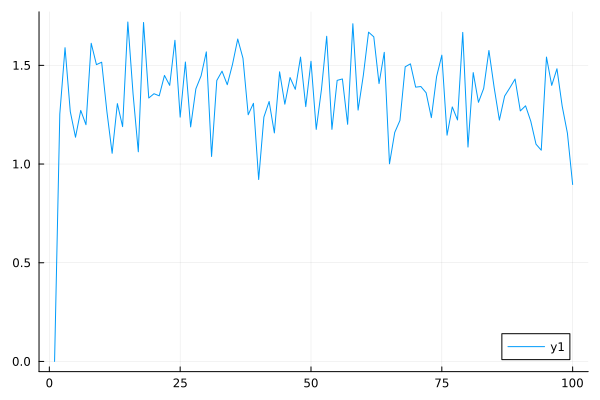

In [181]:
plot(mean)